# Pricing a Vanilla European Call Option

### Part A: Pricing a vanilla European call option

##### Question 1: Simple Fourier Technique

In [1]:
# IMPORTING LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm , ncx2
import random
from math import *

from IPython import display
from base64 import b64decode

In [2]:
# Share specific info
s0= 100
v0 = 0.06
kappa = 9
theta = 0.06
r = 0.08
sigma = 0.3
rho =-0.4
gamma= 0.75
# Call Option specific info
K = 100
T = 1
k_log = np. log(K)
curr_T =0
# Aprrox info
t_max = 30
N = 100
# Characteristic function code
a= sigma**2/ 2

In [3]:
def b(u):
    return kappa-rho*sigma*1j*u

def c(u):
    return - (u**2+1j*u) / 2
def d(u) :
    return np.sqrt(b(u)**2 - 4*a*c(u))

def xminus (u):
    return (b(u) - d(u))/(2*a)

def xplus(u):
    return (b(u) + d(u))/(2*a)

def g(u):
    return xminus(u)/xplus(u)

def C(u):
    val1 = T*xminus(u)-np.log((1-g(u)*np.exp(-T*d(u)))/(1-g(u)))/a
    return r*T*1j*u+ theta*kappa*val1

def D(u):
    val1=1 - np.exp(-T*d(u))
    val2=1-g(u)*np.exp(-T*d(u))
    return (val1/val2) *xminus(u)

def log_char(u) :
    return np.exp(C(u)+D(u)*v0+1j*u*np.log (s0))
def adj_char (u) :
    return log_char(u-1j)/log_char(-1j)

In [4]:
delta_t = t_max/N
from_1_to_N = np.linspace (1,N,N)
t_n = (from_1_to_N-1/2)*delta_t

In [5]:
first_integral = sum((((np.exp(-1j * t_n * k_log)*adj_char(t_n)).imag)/t_n) * delta_t)
second_integral = sum((((np.exp(-1j*t_n * k_log)*log_char(t_n)).imag)/t_n)*delta_t)

In [6]:
d_1 = (log(s0/K)+(r+sigma**2/2)*(T-curr_T))/(sigma*sqrt(T-curr_T))
d_2 = d_1 - sigma*sqrt(T-curr_T)

Comparing analytical and Fourier Prices for our information

In [7]:
# analyticaal formula for European call option
analytic_callprice =  s0*norm.cdf(d_1) - K*exp(-r*(T-curr_T))*norm.cdf(d_2)

In [8]:
# fourier formula for European call option
fourier_call_val = s0*(1/2+ first_integral / np.pi)-np.exp(-r*T)*K*(1/2+second_integral/np.pi)

In [9]:
print("Analytic_callprice:  ",analytic_callprice)
print ("fourier_call_val:    ",fourier_call_val)

Analytic_callprice:   15.711312547892973
fourier_call_val:     13.734895692109063


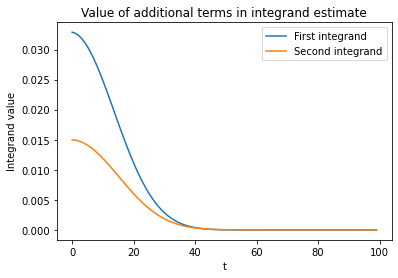

In [10]:
plt.title("Value of additional terms in integrand estimate")
plt.plot((((np.exp(-1j*t_n*k_log)*adj_char(t_n)).imag)/t_n)*delta_t,
label="First integrand")
plt.plot((((np.exp(-1j*t_n*k_log)*log_char(t_n)).imag)/t_n)*delta_t,
label="Second integrand")
plt.xlabel("t")
plt.ylabel("Integrand value")
plt.legend()
plt.show()


##### Question 2: Simulation of share price path using CEV model

In [11]:
call_price = []
for i in range(1, 51):
    norm_array = norm.rvs(size=1000*i)
    st=s0*np.exp((r-sigma**2/2)*T+sigma*np.sqrt(T)*norm_array)
    price=np.exp(-r*T)*np.max(K-st,0)-s0+st*np.exp(-r*T)
    call_price.append(price)

In [12]:
# CEV Model
test_strikes=np. linspace (1, N, N)
#Call price under CEV
z=2+1/(1 - gamma)

def Ct(T, K):
    kappa = 2*r/(sigma**2*(1-gamma)*(np.exp(2*r*(1-gamma)*T)-1))
    x = kappa*s0**(2*(1-gamma))*np.exp(2*r*(1-gamma)*T)
    y = kappa*K**(2 * (1-gamma))
    return s0*(1-ncx2.cdf(y, z, x)) - K* np.exp(-r * T) * ncx2. cdf(x, z - 2, y)
analytic_cevp = Ct(T, K)

/tmp/ipykernel_9056/876971528.py:7: RuntimeWarning: invalid value encountered in sqrt
  vol_est = np.sqrt(2) / test_strikes*np.sqrt((dC_dT+r*test_strikes*dC_dK)/d2C_dK2)


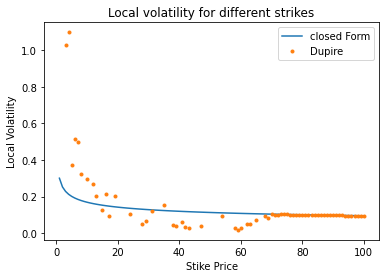

In [13]:
#Estimating partial derivatives
delta_t = 0.01
delta_K = 0.01
dC_dT =(Ct(T+delta_t, test_strikes) - Ct(T - delta_t, test_strikes))/(2 * delta_t)
dC_dK =(Ct(T, test_strikes+delta_K) - Ct(T, test_strikes - delta_K))/(2 * delta_K)
d2C_dK2 = (Ct(T,test_strikes+2*delta_K)-2*Ct(T,test_strikes+delta_K)+Ct(T,test_strikes))/(delta_K**2)
vol_est = np.sqrt(2) / test_strikes*np.sqrt((dC_dT+r*test_strikes*dC_dK)/d2C_dK2)

plt.title("Local volatility for different strikes")
plt.plot(test_strikes,sigma*test_strikes**(gamma-1),label="closed Form")
plt.plot(test_strikes,vol_est, '.', label="Dupire")
plt.xlabel("Stike Price")
plt.ylabel("Local Volatility")
plt.legend()
plt.show()

##### Question 3: Monte Carlo estimates

In [14]:
call_std = []
call_price = []
for i in range(1, 51):
    norm_array = norm.rvs(size = 1000*i)
    st = s0*np.exp((r-sigma**2/2)*T+sigma*np.sqrt(T)*norm_array)
    price = np.exp(-r*T)*np.max(K - st,0) - s0 + st * np.exp(-r*T)
    call_price.append(np.mean(price))
    call_std.append(np.std(price))

##### Question 4: Plotting the Monte Carlo estimates

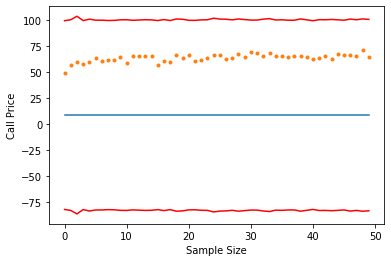

In [15]:
plt.plot([analytic_cevp]*50)
plt.plot(call_price,'.')
plt.plot(Ct(T,K) + np.array(call_std)*3,'r')
plt.plot(Ct(T,K) - np.array(call_std)*3,'r')
plt.xlabel("Sample Size")
plt.ylabel("Call Price")
plt.show()

### Part B: Volatility Smile

##### Question 5: Graph the volatility smile

***Current market price of Facebook stock, from Yahoo Finance***

https://finance.yahoo.com/quote/FB/options/


Current strike price is 302.91

The strike closest to the current price of Facebook stock is 300

3 strickes above and below closest strick choosen are shown down

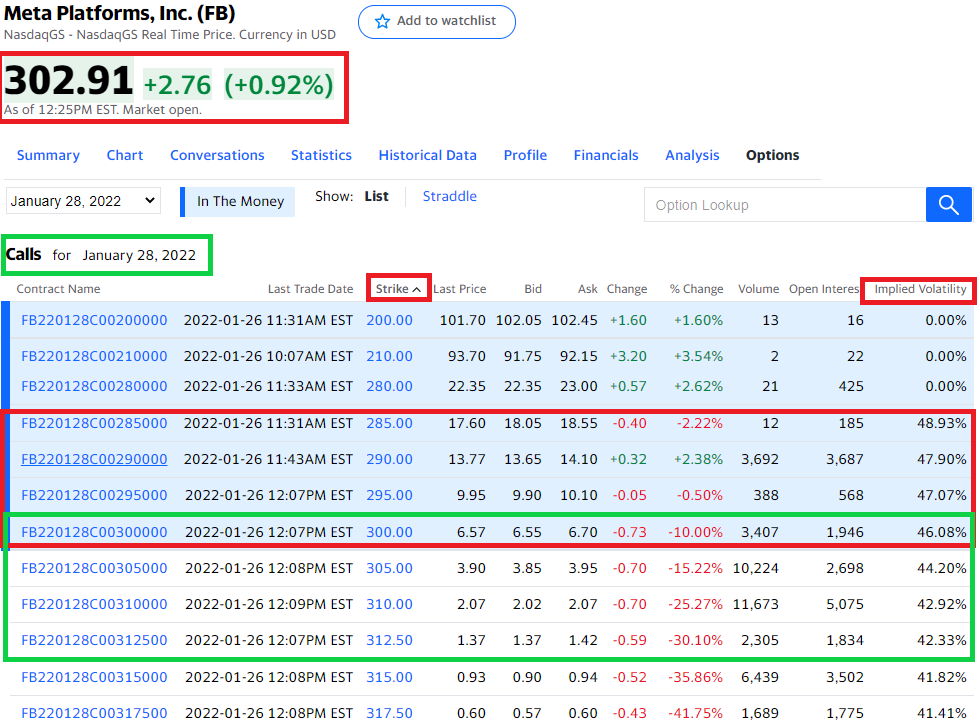

In [26]:
## This is an screenshot taken on given website, at the time of calculation

FB_DATA="iVBORw0KGgoAAAANSUhEUgAAA9EAAALWCAIAAADOIIcoAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHhe7N0LXEzp3wDwR6QLumzKuISQW4tCKLsuWXaFXZvNvlssNtkl1y3WJdYll1Xuav0ll6UsrVwil7YQJorKpZJoStRU0hSmMtT7POc8M821pjSxu7/vzmed88yZc57zPGdOv/PMc57TqLKyEgEAAAAAAAA0Rov+CwAAAAAAANAMiLkBAAAAAADQLIi5AQAAAAAA0Czozw00RJB6MSEX/6vduuegHpwmbOI74d+LTSkoxROtezn0aMmmAQAAAAD8A/zrYu4yXkRgWHRiRGJ8ikNg7rJBNLnuBKkh67x8Dkak8pnZ1dzK5XbMFKhGWewaB/sVsQhxXI4mBjtzaPI7ehIywdw1DE8M8uFGLrNrzqaCD0vsQ3TxPrqVidLzUF4JKhfRdNDAdLRRKwNk2Qr164iGd0d2XWg6AACA9wPH3NJyQ5zoG4RTcDZNZxSdmUnfIJyDc2m62kSlRUWldLr2ZPMmxunhOHPnmfQiulB2sGQhn1iapi6cuxd0UizBTy5qxzH3Pwp3Nc24Qm1qUGm8D70uGb0ng0lRXncMpxB8HOUGO9NZWRZ203yO3RVXLq6PzXTFdusS6n4kAc3Y+Xdl/5WVn6ytXHWi8tydSl5BZelr+hZoeLjwcRXgisDVgSsFVw2uIAAAAO+LfH/uXD6PThFhx66wrbsMATfidzpJCErJz/zq4Yd72Vs2aqStZzwjTGqN9YGfGvH77DGWjrPDpXNeO4k7RvRs3aiRnrHxlliaxCi7eMzvOjvJcVx3JiW3KHemDTsPVOMFr/BmypHjucDVgkmqK17sPu8JvXrMDhew8zaTvdyYidil3sEPmSnwATgah3ovRwlZaMckdGUpWvEV+rwX6tgS6WrTBUDDw4WPqwBXBK4OXCm4anAF4WrClQUAAKDhycfcZS8T6RQj7Hi0JEQWXInwp5OMSL5C9FwmoMpogsRLXqzqCEnyMUzhk8o5zvTz2+jnOc1OHNLF+s/YFPGMziiqfhNlgmjadUSWgC9Jnu29xLEHx4jTUpcmMMSrVSPXL1Us9oZdh8xbNOkNna0itRtK3q0rlZtjkZyz1Kuc6yHeZ5kJjpvjpzLFxWLrTvJytJBbxtGDSV/m7iDuksL3PxhBK6Klo8sSNjnC/7jMsQrel/khaMffaIcrCvoBDepME8GHBlcNriBcTbiycJUBAABoaLS9m5LtPUJIOiQovuVxpuo3/6KUEE9JiIRZjPYMTmV//Of60DQZbMePjD/c5HsZcnq4bE+oWrEU6f4Jkn4jpVeWSVqePS+UKvYtqWETUstLwXutPNtMRwisFO+vo/Rquzh6hqRIsi3JqsPujMoCrp8ze2ngw5Xq7OF5QabQOMOXRRVUlqbucZOsluPgeYrtmlFZKco4ttBRts2Y4xZWc+8exb4lUnlLKYrf6VS1FxZue1OkO2zkRvu5fCzTFVu8+9XhrqYf4Uj1w1Fad1Kk+5aQUmKURi2kSVKJlaUXPGkapyoRvBdlokqnHZWz/qCz4J8CVxmuOFx9AAAAGoxcO3eZQL6pWNy9RK5jCZEreMlOlMWucezpsqmqSRwh3tlNrsPdwp7QWVX4mUHy7d/81JC5fR23qNuEqduxpyQS5T2jPRCkvfsmFJAbBPH+Rkiv9mHEJpeejoui5XIQfTdk7Th7r1Al/V6iVzg6SBUa/+Ja14kjHHpMD5Kslh+96UuvEFKGZdFL7Sf4RsiuhV+kXruzKtF73RxtZ4dV7QUv6Ac3/yR2uix2/QgbB6+Qe1KVqpZErrj30ATrHuxEXenqSVrAnS0ktaxr6+DBTvGPcWluwfvhsgt1a438J9NZ8E+BqwxXHK4+AAAADUYu5s7NTWcnHDxmOrJTbPcSSccSjzk04EGIy2OCq7KLPk5khAqErD2OpZdWiooSAphGTX6IR0B0GerhFB11bLkDScFGLjsWHRUVHUWbV5v0cJy5bE8YSYmK2OM5nDaRxm6MkOlYXY2yUkmYq6t0QLrqN9HSwTs6aqc7m4aQ+06yWLS3Q0vZbCO3nUy2vT81qtpfxHHZzs0oyuDu9WDv7Iv1dfUW9zymdnh70x7h8hKv8+1XB5+J2OMhvk2TfzGa7+wTHHEmeImjuHk57EwsHwmiw3yZsrZeFpVbROSmcMN2OnCU9Nyohes8PXc/2c3F+p0llyJl1zd5LKWXA5zhnnsiuCmpCVHRx9zk+4Eo4PMSaBzsYNPDiJ2qJW6w76ZN+LVogusaJoHj4POzkziHCBm1trBmpxIT0ml8Dxre/BDEMUTrJtBZ8M+CKw5XH3QyAQCAhkPbuylJhwqn4Og9NOhGbscKJB1LPKMuVPW5YDoJVPU5qep4kHvMhU3i+CSwCZKuBdWPdpLoJ+4oomSQDen+CW4BTAwdfcxnnCQYc9yTrsa4Jco2UdUBQ3ZYEqktSroxSPWxmXZM3JmkNIp2MqY7KPVBC6eNxxJ4TKDMjNlStS1JUVxZRlOqspTgR8NKplQlO2XteYZXu+E6qulbIrVTUl07SAlI7aP1Mq78WC7VUlGD0nUni82DqnFLMJediXJdjaoWJl13wPtw5AYZCgP80+FKxFUJAACgAci2c/NzU+hUayMbB6eR7HRQxPFjtGPJQkd7SwtJ9JRAGrpTE8V9ThK3u44YNYK8vvejrdT8FLYtvFplgvux0ceDNvl6z14RRJ6iooagWSNGOODXBO9wugG71d6ucv22q9RlEypU7a/TSHtxQ65uz172dDKUJ9sDxM1roZNNRyOGikbiJnp0okrr1pZ0imhn0ZcN6ZM2jbHQa9S655hZ/hH3lXSkqSuORS86xajaR5vvJ9RuGOyyMnGXHQtO/Ty2JmS2jbH9UvlOO6xoxft4QYPwCUc+qi6j1HMp8y2dAu8PrkRclQAAABqAbMz9pkzcQ7i1sZGFgzPtWRE0YzrbscRzpL1M/403MqMF8q5HR0eyr1hx3FlW/fAagsi1Yyz1jHvYj3Ca7rVorX+40uFDasLcvxix3E5pSFs/m6gJx6IvnUIpufW/ATuX3bT7CsEOj9ijxwjfxHfr0V0zC05rOlVrZZKDSY7FIAeHkZKX4oWIuPVd0kkJodj1rn4XNb2vQF3+UcjWAg3tTmfr4MT9N8P/EOL/03nwnuBKxFWJKxQAAICmybVz87jsBAfhSMhiuIukOzPDkwz91pIjuZstLFMmunTbzvb3kH55O1TT2PkwyHWUN3MnIseBdCyOSriyR822M7ZvCTc1l3TYSD/j952KvsPvsAkVdHHhKOLzEugU6tla2QLvyGLcTm4uN3ijh9MgSfHzoxcFKW/+rT88fi1/FWjJER8zklts5bltiYq6IHl5qBzwvImRzbgJ4sriB11PpZNSHDgaKGtQk/1XkftQOl03+2+Tp1Nui3vNztZCeamwuESk6tmW5WmRAX4n79K5KqrSPwQ4b0EBB6IK6awEPz6U5lmUHhG4JyxNQw/0xFWJKxQAAICmybVzIxpEf2pBmje7OLjQ7iWMhY72OBLX1TOm8wi9KC1DPWzEfX8TCvTshzs4yLxs5G/ze4MkbeP8+IgIdurrTXt2e7qMdrDpqNjLQjkLG7J+u+4clR02GLXeRM1/1ixsvqZTYZFcccRblnKXXq2gaT3ecbQOlTh2Lgt3HovNqCw4Jr6PlY1rBbH7Nm3y9Q+7V18BeFWdJv5xLFYxdH6ZGrYDbzEoVnFA9ObG4iiYl6t6uHQ1laUmiItVWi7vCp3qwak6GEHDiH1IHrbyLuNwZwoqTqa9Gdqh8aXMt3iapqpFFL/La4bnEt9LJTRBThGPm8ATKH6LVaULS3Iy+RqKZakKkTCfl1NE55TAeYtNzixVyEVO0kma59KClKRrNx8UsOmK3m0vcFXiCq3m+QkAAADqhUzMzc8Wd+emqrqXYKRjCfmXw5EE4pl8ATJy+NqTDbMS1ziN+Tko4mJ0NPOKOOzvtUb8KBOJ4zuDDpN3E59IdRXgpfBIuFjGu3hGWYxVH9TcROBO/7Mke6kq40Ujh+99aNPsPg+PHbE8AS92n5f3enZHOZ7fOdZttI7qPAmZ7jjb/3h0YqZAIOCnXkkQN6qTPtOpOxztf/DyWjR7Qi+vsHcOcxlVdYqS1jq5eIdcTOXj7V6PCNoXLUBl0escJszFW5xu/32Q/CCIHIu+4kFFeNl1uwYI8mTvChhl33PUJvHxw3EbJL6W4fNSaGqdh0YBdXfxPhppRafrZusNkaFOoxPf6uH/r7xcm6buopjIu3r6+igl6u8cmvROUv5YsmhPUn1dqiqXH+W71C9SyWCh6jOw9/Lft25cGzor7933AlcorlYAAAAaJd+fm070smBDLgtbR/FP/0zHEkJPTxLnpOfmIqQ70idsNdvZmB+9ZfoYcmsjeY1xmb3pLv1DYMTpIW7+jF3rQt71uSLg2DrSoVGS1o4wbtSokV6n76OV9tyoMzU3wWknHqOFHzLbkWRPatRqebqDPP3F+xsy176TcSf7H/zZe0btVof5jKyu3b3Ois76z3Ya0dfC2Ni4dU+ntXRz61zxZZBAQG9YxdFqaj01VknVKeKHr3V16Nkab9duzPSz/DIk4D8UR8JnFe9htLEXD+vnfyWhTl2webHydwUgi2n+s4fTgi27y6Xjm1k79lV51yzQlFuZaGAnOq2mS5lvL2e9PXBbtOrya/zCE1OttY10G+H/n0x7I0nEy+AX/YwyxTfjU/Rt3MdZoGdJSdk0EVXwuduWTJvuMWn6fO8Qqd96VKWLpezyWHeTHN8L8DK7mBEun8WHeM+fxHxk0bZzmUJmOYmU4BnTvUKYdglhlN+k6QHx5WQ6/Q+vSavOFSPeycXzmc15TJq5ZM81pq8I/9wq7/B0hCIDcPqaSPJtKc08HbBoJrPYdI8Dt8lSmODRuW2eJGWah1/kU5oogbM6yfscaecWJofSHHpM84kqVroXtYcrFFcrAAAAjZKJuXMzFZqArR1c2WZLtmMJYcTpyE7gQJa9TU7XbnlESpiP3DMLMQsjGp7rDveO2O4iibupLm47T0k9vZLjsOxCxCbp3izvTr1NWEzbeUb+KY/VwPsbjfdX6gmO9D7OaBX3cb6r5py+42QLj9PDZSM3YokN3pzNaD/xDtro1tvm6T7K1SmnOd4Ax8HZhU21Wye5JKtiN86LJh6M5r7jfY+cHg7OHjsjMhL2SsbnLuNGbmKnbFwcVPYFBxqTnkcep6K+JH7F8D+Eww4Ip54sW3m5HL8EZZXzB2rjt/D/8TSbiN/Fy+AXXp79oILsa1HZ+jbWtkPs7VHhiYtpbGpOWEDAXe1hbot3b1o+pRN6xaaqTpfo+f36WX0QMhvhs2n97u+tUHnyAZ/9kdpDfl23fvevEzvywlftuIyD2irdrQZrlaY8wIGzKPkevh5MTknGqbyUu6Wm3bsZoiaWI2auxata5zW9u+jSgSMkIjcbsdBrBD5f2n+/fvcmr2FmqCBi26oTGW3HzN3CLDmyPbtq9KrMxPGX9buXftFRxDtwMp6mKsgJP3Sy3P5Xf/9D29evnWSlr7gXdYIrFFcrAAAAzWKHiKg3L9iBqIlSJQ8WLqXvMSNVi9FEZcvXF/U2IVKaveqIP1C7MbPrqCp7CtsrjfLEdWntx46GXs+q6lRqsyRR1V5XjZ/tFqb0Kf7voOCYG123khHcQQMwm1tZ+ppOq2lf0mu0qmTqieq+JlNOlOJl8JJ0XtGjY/PdPIOT8dTruK2zXOccevAWT2ec8Jrl6h/HLIEPvbMr3Wbtv4WnVKXLSP59luuys/nM9Our/q5uy888YWbo7OoLMk8TYLa74dKrt4n73VevXDnL/cD9yjy8ZjZXYq+Fry5LfVZm00yutl6T2UlmgZXhdOkLy8RZurXbVfxBST6f/rnY1X390VuPX5WRdJb0XtQNrlBcrQAAADRKtm/Ju2vODkRNKHsqpC59T+bGR5qo/CmS9UO9TTRRmr3qiD9Qb83L1anKnvz2BGdDNiHkOMtJI+2+VXUqtVmSqGqvOS5L/diOKUEbg+r8hH2lEvf5BDETdpu9XdoxU6BhlYvILXe1MrWP9r6vdPffFk07qfyHj6knyw7cFuFl8JI0SUH6ZW4B4jR7GZ8UlyRqzkFCLpf0pCgWFCHL9ubsMlJUpaskKCpEyLxjWzqrrYdzws+R6TaubfWxBUp/8CA5+Zqh1ZRx1qK7yenpGela3ay7I1RRQjqNeHhMmuk1/8gD+gl5JFcdO3SqZflVaTNu0let+REBG2Z4zF+07XJBrW5AVQ1XKK5WAAAAGlXfMTdoeC9j/VYHoUE+PpPV7h2jadae/puZqPu6l8/Bd7p9TMbDIO9FTAw/yM9/AfQr+SepJuxWJ+BGFcnxiaXazQsvhYYdCA0LvS/U10KXrsWLkDY+h2U+UbitQGW6Ss309HCQ/VT8CREZSMTEtBWdZelbfWyJ0k4euYd6WXW0srYtjg8MT0ZWVpZaSHhxt/eJQluP9Yf2+O92U9XHQ09bH2XmSLqi156+lfOqrfv8V/t801Vw92jEhzn6IQAAAGUg5v7na27nk1hZGbuMdO7+YNgsiEhhxmj3sCjj19OTT/hlPT2ZdaaEe0LE/b7oaKOyOrWJ4pB6Sh/tiwqPn7yU+farbk2qC7hxBHzjcqTQxNlz/RZf+prfF4luxyeVd+3ZC4kSzp1MKRQWF6Zfvye+/1BVuoKS7Mz8EqFQpP/JUHst/olQbkE5QkXxIaHJ2ub2tuJmb4pjZduyNJ1fMvjjbkjH2taqJOcZsv74Y5x1UTk+yrWNWhqgClGO7IMLsMxMnrC4VFTRbdhgE5RwJCAmmwwxLiwseFa7osxJ4GbmlyIdA+OW+s1wBC8pM/Fe0NlawhWKqxUAAIBGQcwNNMSoBztG+yc9OPXUa4jzsR077nuP+nmqPKiLVgaIL3NrYS0k8d8O69iYnZY8+x2nZBVX30lClHQzWdTS2lqqq0jPAdbaKDkyptTWbdZXZvzQzStmeK4IKGw9QJ99X1tFugxLO3vTsqRtS5fM+CMZ6dhOXTiua2bwAg+PSQv3X2o+dOnCL0zpghLm1jYGSMvaltxZznQ1QZw+VgZ4xnDYFyMNsw8s9Zg0Y+H+oqr7zBHHemhH7fQIvxmefpfyURvneV6DDZMObZg202PS3BUBcSoGGlfh1b2jq5Z6TZo+32NXUrNh08b3JIkye1EnuEJxtQIAANCoRpWVlXQSAABqMmEnmjEUfd6LzqpPUFZpvPHlls91rFs1XnChLIlfYc3R2jJKNynv7YLz5ZUrWtDl6kZYImxsoK9D56qoSq8iEhW/0TaselSW6GWJSLv6j6ik8rPlpUKkV5VeIRK+KEW6ddoK81ltfYOqRm5Cfi9q5fxdtPsyOjabzgIAANAEaOcGANRCv47oRgadrhV2EMBtN0TD/xAa6jTa95Uu/j+exik4XdLsXUf6KuJXVelVtOVCVe3mdQy4MZWf1ZEKuDEtbX3Dum6F+axswI3J70Wt4ArF1QoAAECjIOYGANTC8O4osk5dGC5lkX79lZUIR9uXpuhP7aON/4+n2V/a2HfBe4ErFFcrAAAAjYKYGwBQC3ZdyC131x/RWfWN76a95XOdzHnNpG+XxNM4Bafjd2kSaFi4KnGF4moFAACgUY1XrlxJJzFRqfDlG22Z0XdFouLXFU21Gzei87WUzd12/FEn647N6Hzt4PzkZCSnFVY0b6rbWKcxvfkKiV5mZyQ9eaHdopme2hkrLxWWIe2m4lVgFSJhyWvZna2N4uST2642/qSHCZ2vpfLSgscP0h+/aqyn27SqeEWi/Mdpyfmi5s1aKGYM78KrUlF5uai8AtWpRoS3j267iux7mtF5jNQ4u07Ji6y8/N65E/cad+1kLFVedYYPoVfl7MortLS1la9SeLcetyhTvM3qXMUaVotdZo5VmUqXPXoVvxGilyXlpUyZN9LRru+R70Vv0Znb6Ktajh3Dad5oUDvl+4rT8bt0BjSsX0+g0b3RgFo+zx8AAEBtyd5DmRA4KSDJcvzyX8dKnviddGB6eBuf5SNlHgGuvjp/vDT9kJ9vDB+1MGimRW6EKujlfugna5yeErTa96bIqLk2jhcLuk9lEmtWcHrNghPFI2etmdJX3OuRf26Vd7bzHnfm1v/aq/PHK/jcHdsC75bqG+s1Rej1yxKzMUyBV/Aj120IydUz0if7azRauhYIZhckY5BpdxzmvpR5+LP6yBqejJMpMabG6TTFmeKz3DrJb126/do59rVavwr4GAiMpNNI29jKff4se7kh2HDeztXTFisKkw4EbLvG1zYkR87rl/rjf63z0atZtdhlcrDF20t/j6oOP6XfCH6k95oD4oNFW4czctIsF7s6Xh4q1Xs52uGKhkKHhH+4y/fRnGB0Zw2dBQAAoEHM0yjFbu12dZ811X39BfEDkCsrE/fLPwC5Vur48ad/Lned538tT+oZya+Z6eRD7u7+ca+YFIxNVEN++Gqya/N2J0s+Sx65vFv6mc21U8ePC+O2zpq68hhPQOcJZide/e3r+suxp+Rx1gyFPSO7IHnCc94l/zmz/Lnq7j6LrOH3RDojK/l3ydOn6x0+BsTPvn5bnPi7p+uav6X3vl69Tt7jKX/kSIr0n4scbLLfI8nhp/wbQR4hTiv07et87r5l7vVcv0duVH6ylk6Dfy5cibgqAQAANACF/txmI1wGPjvwe7jiU4WFt4PXec6fNt1jmseKgNM8IZuYfi5g4fxJJHFJKH0oWqn4GchLAk4/ELBpCOWc8/Oezyw5f0NIXCFNreDH79rgMRN/fE1IZFjAwqPpOLH4ckik0NFtlr2ZVK8A9kb9MqFQ17DqoeMKd+9Xp+84F+Okrfvj2ZxLU5q34rjgVXgvSOL2S/lMUkVh0j5xbq/zxc+fyL702xqcSAbN9QlOekZT0VPuHh8vXFwzfg2+9FfAgkPMfWcpYYF3zafMdepoyCzDYnbiVWkpam5IGvVZ1e+Zmb29JSooZLMqLvAZVY+DVlpZ6iuO2r5g82UyCnP+5W3ewZF4/WSvV+yJza6q3ChxO6q4WCbN9Fp3KLm6bWkZWA/ohjIzniKUfmjJgajkyG1rPOYH40qv2iKWHx/is2TGDLLCbVHMPqq5iWJuRCySP3JIkRZe2ryErgq7e7Rq73zCk+JwWXn5ncPvJocu3M+9fS7A28tjH1Nfz3BOSCXiAyP0bilJIcsEREQGr8MHjFSBIyQqiBWXOTlgRCl/rPA+ksa+h99N2r1kzzV2DZSSQiYFW1MZyqnxG6GlbWo3dekUq8xTYfHlNO3dTRxARrrwOEhnwT8Rrj5cibgqAQAANADFeyj1rad5OL85t/KQJFwQa2Ht8svq3f5b/T1tC075n0jBSfxrB8JFX6w+tMd/n++sYe3IUsVR/qv+RuOXbj20fcV4k2Lx499E2u3HzVq1fp+/38ZvTa7t3sclsYYoZZ9fQF7X+eu27ts8y/b5g/iiYhLIPnqQhLpZKx0A2Mp+pBZ367qj3IzaPUuCwRm50NU6aX9AlNxnleWtIunEnns952wlT3L2nmjDhMjph9ZveyzOLXrGxuGoXLvtuKm+vlv3bV/u3jLRL+gyCZjKkw/4Bj+1dN/6u7//nP7FyckFL8meFWRkCDnWVsbMB2WZ9re1fBzmG3Au5akaD5MTJt1MR830SK8EUuBXDaeu2npox2LHsqO04pRUVi28Li0ueF76Gk9VlAr4GYJO367137rViXMtKOAy59u1O7b6T+qUdJjGcLhYAvKtF27aemjdpI73AhSKV0bBYz5qaWKEC/1lSWR4lOjTqb6rnCylt1h02c/7SIH1VN8d/oc2rZjanzyrQ91NqDxyRKLnJQLyNG92TmrvMs/9ddfC5ZcVs4ab4DeERfHBkcJhP67w/bYrqkgL8TmS09dj9+9bt35vHr/Dn1tEPiwsysh8a+/x29ZDv03s+uhoaCxZbXHUtkVHCm3dlu/evXX3KtcBhto9bbrlR0XRMLcoJiLOpOfHMqO5yRVyQZtxa7f67/tlqOjSoUj1B+NT7xuh39/atiI55T6drRdbXcizVJYeo7PgnwVXHK4+XIkAAAAahmLMjdMsvpozzuxq4IHbMsGffierjmYG2jra+p1syQOQM2gzpyA/txgHFvrmpiSU5Mdd5Nk6u9u31Ubaem3sbK3YhZC2ac9ubQz1tHX0TAda2yBe+iMS13JjtcdPdrI01kY6JpZDrZUMEZsQOGk6aWyeND2QxI06VlNWzXVumbZ/w5JpHmvETY8SooK78Ulx+JVMHuCsSN9+6k/WvCMBkTLPZlaWN0JU8JQvEiHtlhxDHSa3V6VyO+hj2idZh2PZ01y/uba2vol1324o/UEmTrzNjdQe4f5tN0NcDC272fdT0qG44PQaumve5wrwPOeLX32m9nlx2ffX+dMWBnCVPqs6/9y6hUsWLFzi4Rn8oKer+3AcjzIF/sUXHbVLhWX6A+ysiu8m56iurDrhWPU00dbSNrTq1BHpt2nHTNtZD0CFAhyDkmLRHzPO3kxUKtTqZG9jknTvnuJFQ3Lk/gNBgX6L5y+KEI6cOLoNk2j52UTHvub6suMKF1yLSerq5D62GylzfQNDXILqbaKurF3c7HFZiQdL5oyf5NTT3EBfXxslxUTqDvhqsIlIWKrduf/glrykFHazhpbWFiR7xvb9u6OCokK2Fqyd3EcyBaVtaELW1mvI+I+S428yEfnN+PQ+Q22lf9yQx7Hua66Nj5aOtrZmJQLJz0M1quEbIaajT25jfrchsBWF/ITScqG1+58HVxmuOFx9AAAAGoyymBtr+8WsL1te2rc/RfpH7uK0S7s2LJg/f5qH3wnag4IzcqZr2/u/z/fwmPFrYDwJE/k5fJOOHZV1jMiPD/1tzQIPj2k/H7lGUwqfok4dFAPtxuQH8tfsT/a9Ju3etH6314iqpQy7Dftp+W7/9UtH6kXuCGTayyVKkiPDDoTiV1SyTHoV/b6TPPo+C/nfuQLp+EMxb1rWznPshec2TZs5f9FvYem4HPL5mRXKcks6FRz1814yY8Z8jxA6cHFBPh9ZmLORpbSmWjiCpOGi6Ugvsmvfi69KMDNb51/W7/NfPq8zP8D3KInd5RhafeXs5NheVGwyYuEMe0NSe7jAUVK43zKf9eQVnm2K3rzCyUoqq17hyJKdIMVScmEfs3Wf9dtuikzfihS7Rhi1t+rTy/qz7z39d6yvuo1VmYInfNRcX+a2QvU2QZAjR/RK6eVW7RXk8EXFcQFswfrsvyQyEJXJtyU3pV8gUgtGzeX2y3zwCHPuxZhilH0t6tnIYbbKvhVKaKv4Usp4iy8Gxar7RoiVC8lRUT+DwlTRaUIeXqjdGH26jtyNBz58uJpwZeEqwxWHqw8AAECDUfnn3XTsVLb3s7jFLTti/fbLhl+v9N26z9/LWTLcXFv76atwyupZrdO27TlXjPS09QsL8uibVcrjA7yPFPR337jDf9/WScPYRD29ZohfQLtoSOluZauVdjuJCSq09cgD24z05eMVbQPL8Z8NrkgTt0mzTIb9vH6LL37NHSY1IJ4svZ7Tpg0rCg84mU2jFqV5w9F5Lycv362Hts8bVha17nCyqtyKYgMXHX5mP3P17t1b/cUBdDM9PZRTSFqvZRn26tomPymJbXTWYXatuUIkpsOxHm9v+TItXbFtWsfcaoDtSA/S+cc3lMckGRoZo8Gu7F6zr4mWqipLE4wNTJHJeE+pDPw8VLE9t203W+sBttY9zWt89p6RsYHksoRSbxMEOXKS42+qaOutJSNjE2Ty2VLJRn3XzxuhaugPUgsihYe6GA4ZYf/48rWo+EihjeQXn7owM2mLigukjidRZnYmaYqXovwbQQlvJsVrWfXUzDAjW13QnM/I8Bdue+sybjdoGLhqcAXhasKVBV1KAACg4VXTpMb2fk6Kp7MlBc/1LD8mnSWQsDCHNiXyM1OYlj8dE4v2LZmUbrY2epeucIXsnXz3mY4WWHFhQUXLnn05pA3vWSHtN2Fo078jP/IiGzuKCpLJrXWEjq3zly0v/fF7JLtyTCRu1ctMSsqmEZUwLj4OWVh2ZudqQ8dqytwRrxKSqstbMS+T7Vet365jO6b9UkVuhUUlIrNuVm1J/FOcT9sY9fva9ORzL6UzaxAVpj8Stz2aj57avzhk+/4kSaftcjohTIlPf8ZOi3KuJ2Xqd+qoaoQ70vnni2aR/kznHwvbgSaXwsPFNYJEQpyotLI0Q8fWtg//xIl4pic+JmIyUHdt7G3bJEWdvF9V9ao2UXw/PkV8MFD4yBlvHn9g/YFYvoj9naScn0OK2sTIFD3No/dQCovUCsq1+9va5/8dESvJSalU27IcUgvXzoZl0noW4f8IHduRdsKQw1HaQ4ZYqtN6rYqWtX1/FBkmXn9RfEhocpvB9pZ4uvpvhKhUWJyd8tf2ZQceWDo52dZ0wVNnEweQ8eb6dkBzDpFm1NUn0fm7KPMZedgKeF9w4eMqwBWBqwNXCq4aXEG4muCmSQAAeC8UxucOM9/i84Upncd/xQPn7+Y7MwMDF0T4LTvxRNuwiaiim7VJUkHv5b+OLT25cFtoMTLVRwXlHJeFno6dtJEwOXRd4Ml8hAO+plZDrJ8kt5mLP16asm+1b2ypUQv0ytjKujip2Xf+U/oi9PTyts1H44V6huhN215dCxK03emI16KcyMCtYck59G+2dpteXy+cN9Q0PWzR5iiaqG0wbJLX9MFqjTqsODR1wYk1C05zlrIjHCvmrTM3YGkwt0LPVKtUoGs9y9vd1lg2tyPsm50rHok/LkwK+XV/pFDPCJWaWlXtQkHU9nVH0gT6eqi85eDuxZd0vqVbryhJCdm2NYbPXpYgLW3LETOXfttNFBMw/1Aym6itY+E838PRUrajM96F67aS2ik4vWHR3yYL17n31KUjUqPmeuhlKerotNV7xGsllcVRMj63WMouj9B2VSOCV21LehhymVGipUZeF/Iid+0OSSnRbq4teilCg2ftmybdqEvG50azmOqWonKLOJiOC/bdx32qZWCESgR9Z+1zs1K2CU7kqhUh7Zh3ZeGPbz3ATadXGtrW3y33GmGCMsK9fc891THQF6GuVibJOR+vlds7Qn44eWH6ucBd4fEvtA21RcXl2o7ztrr0klmmai+kxgVHL0oGe/hP6cOsIiNswbpkR6l1SigvZGZo7Rwn+eJCouxLAQEH7pYwx752x8GuC6fYks5Fyr8RUuNza+uZtu321TffDutO7kZtALEP0cX76FYmSs9DeSWSi0rQ0HS0USsDZNmKDE4yvDs8aRIAAN4z2Zi7RqJSoRDJ3fRGEsubyPeREJYIG0vuSxMrLxWKFJbEK3hZgnQMtAvlAiACvyV6qy2/RbxykULiO1KaN5z4toncb/g0t7ILknxqK+xvhUj44g3Op7JgVyQqLhU11pPbIlkPkk9UC9lWKdKVyoPSytIcsjlcK/IlU2ekKLT0ZAq/VptgDhLtFnpV3aOZ6pBJUZP6xxtTC9I5LI7c4HHD1t97RHX3T6qPqVMlu6CJbwQAAAAA6k8tow/Su1rh7zpOVIwR9RUCUExHeTSp3VxlFIXfUrJFvPJ6Dy+U5g0nKvYkV5Zbkk/F/dWqJgzS1lbWmZuspw4BN0a2JZsHpZWlOUzP+/oKuDFSFHKFX6tNMAeJTGzKVEetA25M/eONqQWawwpRQex+39BnI8cNqZ+AG2PqVMkuaOIbAQAAAID6U4cARGO09IyMSQ/kf5+meoamdYukwT/XM27ImWd9pi+Z0geqHgAAAPivq2XfEgAAAAAAAEAtfUjt3AAAAAAAAPwbQcwNAAAAAACAZkHMDQAAAAAAgGZBzA0AAAAAAIBmQcwNAAAAAACAZkHMDQAAAAAAgGZBzA0AAAAAAIBmQcwNAAAAAACAZjV61q4LnQQAAIZJdjqdAgAAAEB9gHZuAAAAAAAANAtibgAAAAAAADQLYm4AAAAAAAA0C2JuAAAAAAAANIveQ8neMpXz8hmTCN6nNs1b0ikAGkqhuSWdYsA9lAAAAED9gnZuAAAAAAAANAtibgAAAAAAADQLYm4AAAAAAAA0C2JuAAAAAAAANAtibgAAAAAAADQLYm4AAAAAAAA0C2JuAAAAAAAANAtibgAAAAAAADRL+TNx3rx5U5CX/yj9Yeq9lNKysvvJKYIiAftWz4+tzDuY97Lu3d2qp76+PpuojhcvXiTE3bydePv2rcTS0lKcgleF12P36WBTM9NGjRqxi6nyoqTkUfqj1OSU54WFD9PS8/h5OLFJkyZWvT9u37FDb+s+Xbt31W7alF343eESwPueEH8zOys75V4yTunYyaJbj242/fv1sOpRtw2VlZaVlgrpDKN58+aKq4Jn4oCGB8/EAQAAADRKPuYuev48YMvOU2EnnjzOZhZQCceLY8aPW7BkoXl7c5qkglAoDN77x9aNmwVFRTRJSvXrwZ89f/rsnwdDrl6KoUkqGBkbf+82ZdqP0804rWhSneAtnjl+ateOgPvJqTRJVrv25j/8ON1l6qQWBgY0qSavy1+fORm+ZYMfvoyhSYwTkWdsBw2gM2IQc4OGBzE3AAAAoFHyMTcOCn+aMj3lLmnZVQeOdH9ZscRl6uQmTZrQJFk4dl/68y9R5yPpvAqdLbts3LF50GA7Oi8Wfz1u/MgxdEYNeD1LVnl/MdaxxoZzpXBuVy5efjb8DJ1XDcfKa3zX97LuTedVqKysvHf7rt/a3/4+d4EmSYGYG3wgIOYGAAAANOpdY26sefPmnksXuc2a0bhxY5okVpBf8Mtcz/NnztL5atn077dl13bLbl3pPKO2MTeG87Nhm994Z6faht21yi2mNMPSCp8V/m97wIHAvS9fvqRJsmobc0s6//w7qHN18S/b5feo+tKGmBsAAADQqHq4hxIHlEG7Au/dvkvnxd6+ffvnwWD1Q9jEm7d2bt7+4sULOl9XJD+/B2Zm8Oi8espKy7Zt3Kx+bjGcYb+1vxULaE93aa/LXx8/euzrUWP9t2xXFXADAAAAAID/iOpi7r62/Se6/t/S1cvZ1xT3Hz7u04u+J+vJ4+yzp87gIJvOMx4+SD92OJTOSBn79Ze/7w+c9uP05s2b0ySxc6fOcGOu0hlljIyN7Yd8MnTEcPxSlRkMR8OREecrKyvpvBrup6ScORlOZ8RwDnE+D58M/SvixMr1azpbkt8EpJ0+firq/N90Rqy8rHztilWz3X6S670NAAAAAAD+m+Rj7iba2oOHfopDzPS8rPDos1t27fBYMJd9rdv829mYv8POh/fsZUWXlpJyL/mlVBM1jncv/30xPe0BnRdznToZr/PLCePX+K5buHwJTRV7+fLlxQtRZaVldJ6BA99vXL7FWbr/9FHy4wehZ46HnDiKX+evRiem3/tpngddTtbNuHjp/FQPXy1Enr2Qz4yFIm3uogUrN6wZ4jDM7tPB7rN/+m37pnYKN3qeOx3xoqSEzjDwvuOwm84AAAAAAID/PPmYu0PHDivXr8EhptJxALW0tAbaD1qw2IvOSykWCF6UVMW4ON7FUS+dkTL26y/ZNTdq1GjUmC9s+vdj0yVuxd98+uQJnWHuibx8i7vtfztxlhTHCTHjtPJcugjH8XReSl4uv1hQTGdqgnN7N+kOnRHDeRvnNF763tB+tv0/H/MFnRGLvx7He1S7fiwAAAAAAOA/pS79ubt279bdqgedEdPT18cvOoNDXn6eYs+K/gNtO3XpTGcQMjU17aGwnpS7yU+zq2Luj0w+4rRpTWeUwRE8juPpjBShUFherm5jc9HzooL8fDojhvOGc0hnGE11mlr360tnxPL5eQ9S79MZZT77YtT2wADFEgN18LayIl8o4L8sxP/H0zQVMERvRfmvinDhFJaWVKJadKwCAAAAgKbVJeYWvRYp9p0wMDRo2lSbziCU8+Sp4vjWrVpzDI0M6QxCunq6SuPptJTqQlhF0rF+3bx9+/bNmzd0Rqxx48aKI5+Yd2hPp6RkZWYp7TtuZGy8dtOGwEP7rPvZaGnVpaiBNBxH7rj5V799brYHZoQkX9Cq03CQ/25rYw/22z+9/363iIfXaRIAAAAAPgC1DgRxcJlw8xbvUQadF+s/wLZ5ixZ0BqFnBUqGePvoo4+0taseu4gjWgNlj5V5+vSp6PVrOqOGUqHMwx1ZJi1b4pCXztSfj0w+UuzOXpCXr3gR8o3Lt+euRk2d4dZUp96ejlkHbysr7hc+DkwKn/f3dvblGbUzLO1ySfkrukS1SkXl53lxxx/EVP+Kz1VymYRD5KwS/vZbxySbXsv9IyY7qexNLSpX2i3+gz23z1RUVti06vpD7zGNUN1j7keCpzgzklw9eJ5dq4ZhvDD+iGQNK67sufQ4SfRWRN+WhfcX77VkYXb5uNxUVcvzXxb+FnsIL/bLxd+jsxJUNefjMscln5RfNaifdmPtnwdMbG9g9vrtm3WxB7NK5O9PAAAAAMD7ovzZ70pVVFTwc3KPHDq8a5u/3Ph3Iz4f6ee/1ayVGZ1HaOtvm3x9NtAZsTme8xcuXyw9jHfYkb/mTJ9JZ8Qm/zBl5QYfXT1dOl8tfA2w3XfLxjXr6bxYrVby5HG2xw8/3rwh0wF9zPhxm/y3ynUiVzp+Od79HXsCDI2M2Nm3b9/mPM1p266tpG1b1ajnmh6fO/zhtcUX/ycoV3IvqZ62zpx+E2bZjMeBGk1SBsd/Xx5b8vRFAZ1X4UvLT37/3JPOMHC0PefCtsS8BzhEpkliu0f/MqbzIDxRq/G5X7wWTjuzPvbpPf0mOvvHLhvcTuWoNdXDVxFruAcO3jsvnTGtRlqfWwzYPGK2gU4zmqRa3qvns85vup6TQufFOhi0+m34zE/N+9B5JtpefW3/oXvnlcbNistjJ9OvekbvxJmk8wiNshiw7bO5chlLykufFO7TtHGT0K9XdzZqS1MZe26fXnV1H967b3s4bBw+s4kWvSEBxucGAAAA3qPq2rnLSssWz/Nq28KUfZkbtrLtYe239je5gHvoiOGrfvORDrhVwRGw4nNzFGU/flxaqqTpWqkn2U8uRkbRGSlDRgxTM+DGDI0MW7Xm0Bmx+Otxil3Scf51dORX+/btG3xBQmeYZczbm38InUkeFj1VGnBjOKrzu/Gnf8Lxeun4q60lU60JeWlfhi6+xb+vGHDX2blH128wYe6wDn0Htqlj5/g3FW+Wxew+cPesXMbw7NmM6zPP+0kHu0rlCwWTwtdIAm4cCn+kS3/eySrJm3l+801+GjuLiSrepDzjqWqoVlweR9LLLgfiPAwxt8Zx9gLbifjS6AIvbtutv6SrqaT81Zpr+/FFyFK7yXIBN+bUbaiVaUc8EZ5+7RZffuAgAAAAALwX7xQXdrfqsX7Lxj0h+y06d6JJjPKy8vw8+VsSNeHNmzdhf4bi4JjOi41y/GKAHWlJVVPzFi36D7ClM2L5/LyNazbcTkhi42mhUHjsz9Dvv3FJvHmLXeAfoYNBq9WfTr85dc+T2WFPZx9/7HEsYqJvdxPSKx0Hmntun0kpyGSXVMq0mfFp5423pu5RfF34dnMX43Z4maaNm4y3/JRdHsNR6c9/73xWSgaNadOi5YGxyzJnHsWbxq9HPx353xcLcZbYJdWHo8x9TKDcRKvJxB7DJW23tXUjJxVHongCr2GxnSsuDfza8tlcvAs4MSb7zumH5N1q7EkKT3lGSsxY1wDvWor7wbvT/7jx/f/6cbrjxKKyEh8mGmaWJRo30vrEvPf+sUvvzwiWFMLG4bNaNCU3IeDlN14PlgT6Jx9exSmdjNrggPub7sM9B/6fa8+ROD3iIbfgFX30Eg6+9945E5d7f3zXT7+yHMwmSsPXAF9bDsETwjfle26fxpcZbDoAAAAA3qN3irn19PTfvn0rfCXfJl1ZWVkh+3wcTcBbCQ87GbBlB50Xa968+dQZP7Q0rbnfgkSjRo0+HT5U8Snul6MuOg4daW7Yqm0LU8tWHea6z/rQHnMz8/ymtju/Hn9siXScJzGl1+grkwPc+oxp3dyE7f2MQ8A+Zl22fzYfh4x4Fkd4in0kpOHlzfSNOM1NFF+xOckZghy8zPD2fT81780ujwUnX0gvIiPPdDRs/dfXPp917C/pvqLbpOnYLvYfm1qws+q7yU9LZiJdq5YdB7buySYqSsx70H23Ky6QM4+U3EGIo9UTD2JwJIqnB7bpMb33OLx3+OXcfdg33YbhRBzThz24Uk13c0H5i8vZiez0nH5OeNfYUm1nYLbls9mtmn2EpxPzHkp6t+s1aRo0ZvGRr1aN7GjLBtkYLgRXq5ELbCeys/cLs9iO1zg45hXl4onORm0/0iNt53jlA9qQmweKyl4+fUm799zMTduVeLK9QaufB3yrql/Q550G4BrHEzf597Nr6hcEAAAAgAbwTjF34s1b3l5LhvazDw3+U3HcD027fi12w6q1ik9Wn7toweChVc2uarLs3tXZ9Vs682/xkW4LHFPSGSntDVt1MW7DTpe8VutmSjk4ktvL3M6o30THrc9YSfD3rLT4xIMreEKrkdbsfk51aNJW6nzGDba9dmDbnup0uVaqsLQkThwNf24xUE9bh53Goe2w9n1xhvH0/edZua8K2XRFOPbNF5L2ZhxA92/djU1k4T3tbUrGwcT5vPLkNpvYRKuJkU7VjcXSBrTpwUbhr9++KX0j8xCoajC9Sg6Uv329cOB31ZRtuxamH7ckPz3lvypiO+QAAAAA4P16p5ibJSgqmv/TnED/XZJnv6saBLAe3YqLX7Fo6ZPH2XRebIr7D9N+nC79IBs14Y/gD06fNYPOq9ChYwfFR9a3NDXVbvo+BydpYJWocv/diKwSPp6W6139oPDxkxekW1FLfcNBbZU8r7QOBOUv2NE5cAj7aTuZOw5rJefFswImYsbrsTCSOT7btDBppk266eOgNveFyhtVBWUvJP1A2BhdAq+zX2v6O8mdvIevROqG0RJ4DV0/Ik85ffA8O/dVEZ7A5Xwpi3RkatXsI3ODVnh2262/bvHvf911yNguduQzKpCCEt+aeSX7Nv4gOw0AAACA96W6mBuHzhu2+T19USB5ZRXlRl2P+cZFSXvw/t17792+S2feTbPmzasPmq9fi13w01zFYUA+HzN6wWIvpU/QVAf+4LLVv+4M2tXZkozlIsfI2Hjl+jW/H9jTroP849/19PSaMB2C/ymelRaz/Rlw4NizJbnfrlZSn2X9lXoRT7Roqj+r73gc4bHp2K28NLZvRgeDVi31DNlh8tjxBBPy0lSNjlc9SevyR3ot5GLlWsF7zYbCek2aGuvKXDi1bmbCNp/jDBepHkXRTN+4eVM9PCGqeKN4t2UnI9K7HXspKhVV1LCnac+z2e5AOCdtm9NHL43v+ikuNHwx4352w5+pUauu7vsr7RJO/8yiv4mewcXMhL23T1sat1tsN1m6zJXqYdJetwm5DnxY9KS4XP63IAAAAAA0sNq1c+NQuLtVDx+/9Yph95PH2Zf+jpY8GqadOY0/pPFzcstKa27/kxvGWw4OuBfN+VmxX/XQEcOXr11paibz5MjaaqrT9OuJE6KuX75w7aKf/9alq5fjFw61/4o4cT35lvvsn0pLSxWf9cNp01r9MVLekeRZg+yLDXBFFW/zhTQRv1t9aFuJKsPSLuPF8HRnozY2reR7sVcPf3zfnTPsLZLjuthbt5IZY+5JCe09bKTTIuj26Y+Dvv/u5KrZF7bg17jQxbYHZkQ8iq1ts2vui2clTBxs0LSZpFe0BA4oJaVRWFrCJgrKXkgSJRFn6ZvXbAcVfKXRuJHK8XMePH9MpxTguLxdC3KA4WKPepwgvSN4+pmQFCmGLxLKRNWNQY53JyT5b3Z6aPu+ps3oKJP4+mf1kOl62jp38zM8o3YGJoW/fvtmlMWAef2+KRAWr762v0mjxmuHzjDTp8tX4yM9Q7blHpfJq9e1bnQHAAAAQP2qS9+SFi1afKqsw3TGw0evXtE2QgOp501KvH37VhKUsx5nZtEpKaatzHR0aV9bObFXufNmeCgNuNdu2iA3fEqdaTdtatX74+++d/VYMBe/cKht9+lgvNf4rYdpSgZfa9+xA53SvHvPeEOCZ/fbP519XeCRMVuS8tKHHKKJ+F28DLuwUrf4D/bdOYsncOj5o81X6gRw0vC2wh9y8URLPcNpCg+mKRHfyhmZGe9743CpqBzHqZIe2AVCgceFzbV9RGJR+Sv20sJYt7mOwl2Diy/9T1IaU06vZRuPF10MkCTiBdglJZo31avtXrNwxD+2y2C2V8ne26d9uH+kFz3BYT3eWefjK7xj9rCLVQ9H53vvnEnMIwdSq2YfuVuPlS7Dryw/iZsSuG7ojG+6D3frM+a08297xyzW19bZEHsQb+v73qPt231MF62WkU4z3SbkS/TydSm+HmMTAQAAAPC+1CXmxrSUDbP9rKBA8vxITuvWZhz5e7yyH2cLpZ4ZiRcWCOgIaNI6dOyg+NB1DAfc83+crdiHe8TnIzdu31RfAXc1ykrLFPvP4N3s0lWmrfdDllWSNy9yW1EZaQ926jb0m25D2XQ1val4s+9OBBvXju5s16OlyouNxo20XK1G3p3+R6r7IfySjKb3+u0b/4Qwtt36famorFA1ZnaNJnYfzka9eEd2JZwYFjwHh/VTT6+LfXpP0l+lcaNGcr29pZ18cHXbzVCch6aNm6wYPFVxgO2PdFtM6TV622dzV3863aZVVxyRn34Ye/xBDC7Aef2+qaisPJZ2GW+3vf8Em73Tfr0SpHTIGgAAAAB8UOoYcwvF7dmqtOK0UuwVjcPlfH7V86hx/J2R/ojOiDVv3ryTJRn/QVplZeW1y1eUBtyfjxmNA+527eX7WCuFo/yi58/xq1bPlpdIS71/8e9oOiNm1ctKza3Xi49bWsS47pQMkj3KgjzG0rqVZcwkmojfxcuwC8vBAbfLyVWZxWRAukFteq751K36h1AquluQcYFHntZprGsw2WqUXCO3tDFd7DcOnyV5Xkw7A7P1Q2ewAxSmPX98ryCDTX93G4b9KCmNA2OXsZ1P8KYliXgBdkmJ6pt+2VH2VDHQabbfcemiQS7svrA6GLTaPnL+L4MmsbOtmn0kGRRFzokHVxZEbcfxOg7K5/V3/qrrJ/QN1XCt+d443Exbf8UnU/WaNF0Y7T//7+3pRU/wZUO+ULDn9ukvjnixvfMBAAAA8MGSibnfvn17OyHpxQvlTy6USE978OfBw3RGivTwHR+ZfPRxH/mnc/MeZSQl0OGNMTx79/YdOiNmY9uvnblMCIsDbm7M1Z9nzVMMuMd+/eVv2zepM0bKmzdvDu098InNoI87dMMv6y4f/7FnX63GNyzIL9i2cbNiHoYMH2b8kTGd0TwcJZs1M5YMks3eJ6et1dhMnybid5VG0o8ETyUBdz9O94DPPSVdPtRUiSpDkiPZVlWHDjbdTJRcaRgo9LeWaGvQsm0LEs5Wf59ibRnqNJeUhokejYONdFtIEvECbCKnmZFid3BW6dvXIvGzY1o0raFYcDyNw+V70w/cnxGMY/pHPx3hfr9rQrehDwVkVHIMVwF7q6U0XHp/3b8kCbhn2oz36Pt1NRctLNFb0ea4I49L8qb3GdOP0/VK9p3jD2Lwx38Z5Jo58+i5iZvaG5jhOvW5doDtqg4AAACAD5NMzC16LTp84NAgq37zZngcP3oMx9bFAoHkqeZ4ovBZ4bE/Q2dNm6H0WYydunRu1ozGKzj4/uzzkYrD6gXvO4hXiydevnx55NCf0s3erH4D+ptIPc6mmoD7k2FDfl6ysEmTxmzTteJL0rkcizofuWbZSslKBEVFa5evxonsLFZWWrbGe+WegN3Zj7PlYnE8e4N73ctj/vkzpBu0NMtuXYd+NlyuJ0xWZtZPU6a7jJ8oeS2cveAxT0nP9dVLf5VeTHH99eV+4eNJp1azAffANj0PjF3CPsClVrKK+Rcfk0sm/SY6rlajlA6d0fUj8oRL7ElJgVyfh8aNGusxPYxrS69JU3ZbpW/K31bW/VlLH+kZss3POGM5L5+ziSzJbZo4KG/TXN2SwQvjmJ697CkVlScX0G70vUw7yQXTOOAOTr6w8KI/G3DPt3X+xc5VnR8ZTqZfO/HgCq4ytz6k2/eJ9Ct4Dd1NzL/v9Tn+eC+zThN7jMCL3St49LxU5lJZchXRtHETvSYNdIMvAAAAAFRR0rcEx6N/HT462+2nYf0H9zS3ZJ/CiF94ordF97nusxQH6cPMOK2GjhgmHX32su796XD57sI4WB8/cqzzmK8dh4z8Y88+miqGQ9ix479sLNVZ/OaNeKUBN3b1UozDgE/Zdmulr8Cdu9gly8vKL0ddknt6Dp7FifgtOo/Qqxcvf/1l2SCrvh2MW49zGM3GwU6fj7Myt8T///vcBbqclG8nf6fYmfuNSPQo/eHlqIuSFw7ZFZ/dgyXE35Re7NVLjfRyxgH3tDNrH5eQYbPJc8jHLJXuF6G+8xlxuS/J82JsOF3Z578o+tjUAkfkeIJXnPu4WOaCCge1T5hnIuKgs4lWLTo1taynITjweiTPkbnJlxl8JrXwMXubJjsSNptYKwl5DxL55GISl61D+35sIosNuJfH7MHhcuNGWgsHufw84FulzyqS80jwdF3sQRzZe9t/j/+Pc1ggJMPFdDJqK3nUDnuRI/2gStbz0mJ2NENcdJIePgAAAAB4X2oR+lTv/yZ993GfqgeAY4ZGRpPdpig2deOYnhtzVelD1J1dv7XsLjN0XXbWY6UBd61UqngWPU6UG0dFQhINqwqXsdHjxkx0/U76CuEDdDv/4eTTayQBd+AXi6rpUsJ/Wbj91rEDd88q3paHI+aT6VfZ6REd+qnqr9zDpIMl82CXorKS3bfDpUctjMm+nccMUNiqmXE3Zhk1tWnR0pQZZqSo7EVWMXkQT93gsHV0p0Hs9PlHcZKHokvv2oDW3SUdVN5WVkRnJazl/pGY9wDHzWyiUnmvnv92PYR9qrxdWyvpXjf4g7sTT0kCbq9BLnP6OdXYpQTDRbf22h8FQsF8W2d2QEbdJk2NmNs0BWUv2SsE7AXzGFFcHUaygXV60VO2EjsatqltJyIAAAAA1Lv6ibldp07+ce4sxQfZDB766dxFC+hMTcZ+/SUOYat/Gs6HA+d2/VZfk5bV3W/XAH7/3PPp7OMnJqzHASVNkpKQl/Z9uE8O82BFHLG10NZffiVo3t/bpV/bboayARwO0X467/db7KGll3evvrpPLsq8V5CRxgxcjUPSoe1t2ERFOLzz6OvUlHlCUFja5QVRO5MLeFkleRtig5df2VPBjBbyWUfbDoYcZnG14C1+bEruCsX5TC1UOXg2ZtOq6/0ZwbhAxnSmsbUcxy72HQzIprNK+FNP+0Rmxl/PSfnxnN8tPnkmvNzoh+ce3Zhyem1AwvHJ4WtTCjLZxLMZ10ccnheYFB6TnYQvUfD/f70S5BAyX7KGBbYTJb1ucBnuuBWGo3YccOPZVs0/elT0ZP7fO+Sq4Dwz4KOcA/fOR2beHNmx/5SPP6dJCFmbkfuS8TXAXeYmVByXX8ggn2WfQESWYODtXsmmz58f0KYH2/sFAAAAAO/Ru8bc7NMZV29chydokhQcQLvP+mmN73rF1m45U9x/+G2b3zs+0UYVXT3dPv2UhIk4sQ7PssH7Mtdr/qaAbRrKbX3BMfTqq/vZh9dgOGDF8eJf9y/KvS5mJbAdf1+9Ls1huo5gGYIcoexzFiOzbrKheSejNm1bVHW4V+TYZdC8/s5ajbRwhH38QcyoIz/b//HTjlt/sV0dbFt39xzwrToNvRJ44WHm1niFePrvTJqNujFvYfqLnSvbSH+/8PHU0+smhC3DcTOexdcJs/tNkH4q54OibPYiobj85RNxz42KSvLBlVf3fndyVb/90/H/99w+LSgnfalx1Lt79CLpNSTlpQfcCpOMS4gvfv66f0mu/PEr5RkN6CXwB7fGh7Zr0fLXT6dJd/se28Uelz+u2cnha/D1wNDgOThexzmf2stR+qKr4JXgTj4ZEUi/iY59W7XG8wYAAACARsnE3Dq6Oh6e81Zu8Bk+0qHGKLmzZZdFy5dcuBbtPvunaiLXpjpNp/3odvzC6W9cvlW6zk+GDfnz1F8+fuuVRu315atvvp4+awadYeBZnEhnEGrcWKvHxz2VPvVdgt3l6Lgrv/y6rMby+cdpqW/4STsy1EzjRloOHfuxXahZOMhjOytjNpyuStvUJXCIPM/WecfI+ZLO0ywcGk6yGnVw3HK2o0itDG1v05FpGr9bkPGo6CmbWDdfWX6yz3EJjlzpPANndd+YZdOtx9J5xvD2NmzHd0vjdpLhF3WbaLOt+NJwgeCo9/y3mwa26UmT3gEubR/uH/j/ngO+Y1vlJdq2MA1yXNzLrBN+F19+ZJXk4U2vHfqj3JiDtwsesr2Jqul5DwAAAICG1OhZOxJlmmSn4//nvCSdEFhv3rx59fLlk8dPSoppQ6mEgaFh+47tm7doofTJNdUoKy17lP5QskI9fX2LzhZ4bbVdT91UVlbmPs3J4pE2RfMO7du0a6ul7E6+V69e5Tx5+ixf5o60Ou9yHbRprrIVWbqCNKESVT4vfdFES0syvt47Ki5/mS8UPCkp6PaRuam+odxIHdXsqYRkl7fEH/W7QUao/KnveG/772vVUq4Uab0uKSh9+9rCsPVHei2UrrDszeuS8lfGus2lc/62sqKwtKT0Tfm9Al5Hg1ac5iaqPl43eP1a5DhTuUJcTfyXzxPy0vHWOxu3les6Uioqn352w6XHSU20muxxXDSyoy2bXn1pF5rL3ArMnhAAAAAAUF9UxtzgfXmPMXcDq1XMjWP3iceXpxc9aalnePirldJdOIC06Mxbbmc3vH77Zlh76z2jF0vudoWYGwAAAHiP6uceSgA0zUzfaHa/CU20mjwrLd6VeAIeAaNUSfmrrTf/wgF3i6b6822/VTW8DAAAAAAaGMTc4B/jK8vB47t+iifCH147n0EeQQ/k7L93LjHvgVYjrZ9svurfuhtNBQAAAMD7Bn1LPjjQt0Sa3C6/FJVeyb5d9ua1oU7zT9r1Vryd8b/sxWvhtSd3S9+UG+m0+KTdx7XqPQ99SwAAAACNgpj7gwMxtzQ4JusLxNwAAADAewQx9wdHnUgUgPoFMTcAAACgUdCfGwAAAAAAAM2CmBsAAAAAAADNkulbAgD4b4K+JQAAAIBGqWjnFpYIy+nkO3nK3eOzZMHCJaF3aYKMCpHwpYhOUyJRcXZ6XHx6dqmogibJE5bkpMQnpWTL5BCvqrhE6lVK08tLJSkyKxThdPEyEnivhXL5IUQvJauVWY/oJc5qcma+OAV/vGox5iW/dxRZoVzxkvyr3mVlci4FHIgqpDMAAAAAAOADpqyduyI5ZH5AhJmTv/cIQ5pUN9kRizfED/BaOKadvpY2khm4DAnvnwsMDI/XG7fF5wtTmpYcMjMgUsvASJ/ExAXlnCnei0e2pe+x0vfNXxWLTA318BKCojeWTouXOnLIG/xzq7zP5RvriZ+CbTPLd6IlQgWn1yw4wadpWtqWQ9wXTrLCq0dxgZN2ZzgvXf9VJ/Y9rOSSz5I9b8f5//qF7F7zI73XHBCvAyHOFJ/lIzmlKUGrfW+KjJprk6x2n3roJ+uUXR7rbtKFKI703knwI5auCWnlum+efVWR3A2esY07eI7/lD40oUZ4c6Htlv86ltn96uGAXoj0cVYBUAHauQEAAACNUtLOLbpxOVLfpE0mN64q0KybwoJnHHt7C30d+YC7OGKDR+ADo/YGdJ5VbjLMe+s+//VbfNdv2breq9ezkLB42YZikdFni/ft2koW8PXzn2GVeSIsvqrB2MqDpLMvEnBTOPDd438Iv5aPQDH7TjAt7gX5eN9KzlxNY5Zg8LmXM/EW0Gs6L8Ny/HKyBvLCATcOeMO23jCftcmPyerWQ25WeJmeP7ELuI8kcTkzrSTgxvgF+TjI5sYX03ks5RpXiP95y87Vs4KIDTM2RBXQOQAAAAAA0NAUY25RUlyy5YhZzn34kVezaRpCwvRzAQvnT5ruMc1DWUeR4uSTv62YMQO/uyLgdJqQ9JFIDl146BLih/ouWbDwqFyjmf7gWbt95zp2Ji3OVXQ4bdpKYnO9tu0NRXmFAjrL0jY152iLs6zf3rxtRaGgiM7WzNzW3qw0PYu5kngjQi1NjG7eTBd358i5yn3V0gTxs9WKTcuEQl1DI106h7Rr04RcIRIhgzYteZfiSmhKefyl2yZtjFFmDr3KyTnn5z2fKe35G0Li2A4kuDz3c2+fC/D28tiXzKSICZNCvDccuMks9iw+xMdrGvPB0Luk80xx1PZ1Z/ko/9y6hUu2KfZFyb68R7x8SCx9l3zkcFTkNqZC8Xpui/NZUZi0b4PHTI9JM73WHUomFwkIpR9aEvBXFLvRGYsDuE+ZVAAAAAAAIEUh5i6KibxrNXIIx7q/VUFMjDhW5l87EC76YvWhPf77fGcNa0dTqYq0kF8Dkjq6+u7YunuVa9tb21eG8hDqOt7byRaZjHFfstZ7nMzv1jhGNTSQhM4qiDJ5fP3O5qSduPiy33SPbZfEkZ+YiJeRqd+poxmdJV1ZgvYfCAq7lMJX3jFamJ1VgkxNTPBkAb+w46AvhulzuUnse7z4G2jYV/aWSPRKWUd20ati2kWb7fBtZT9Si7t13VFuhnyuapZf+BR1Gj/OKv0yl43vRTfj43uOc+6MBK/YLuYi7fbjZq1av8/fb+O3Jtd27+OSFnGRsCg+OFI47McVvt92ZRZjVPAjffenD5o6pb8JqQifIzl9PXb/vnXr9+bxO/y5RcjwE/d5Q0xQyyHzvJe4f0L2vUrRZb814a+HzMPL7/YcIjiyIuAaycDr0uKUG8lo5Dx//61bvzW5tMMvgrn4Sj+0PiDfeuGmrYfWTep4LyAgiuy76GVJ0lNk/9P6fb+vd2+fEfAXV3kfdgAAAACA/zD5yLfgGje9j621DtIeOHQkSoyXatIW5OcW43hU39zUmKZQSTGR2iPcv+1mqKOt3bLbV5NHiKIupyBtbUP9Zkhb38hAn3S/rh1hwv79dy2mjid9NpDhAJc5s5wHyHZEESaFHEm2+mqcJbsHWibWdtb9e1lZtiq5GbRmxppzBZKwuyTpJI7Ft23w8Nx/zWyc80DSJv26Amk36TR4hPmla0z3lbvcM4ZDB3fGU8obzp/G7F/ms568wh6QeR2rKavmOrdM279hyTSPNWyLsrreivAWjeyGjizhxpNYtuTaxYyRw2ybaaOCIra7ibZpz25tDPW0dfRMB1rbIF76IyYZccZPcuppbqCvL25Wf1OctNvvRKupC9le3bgidAd8NdhEJCzV7tx/cEteUooI6eg1w6vW0m9maKCvw3xKrOBaTJKVk/sQc23M3N7d2Yr792Xa4aX7kJE9TXCyod3Uqb0Kubf4qCKJe1V/zDh7M1GpUKuTvY1J0r17bHjdtrNVx5baSNvAtn83VFAi+9MEAAAAAACQj7mz46/y2+oLk+Pik24Ktc1KIy+xPao5I2e6tr3/+3wPjxm/BsbL9h8oyOGLLMzb0DkclOsbVWQ/fYe+4DjgXhZYOGqhhz0N7vXa9LFqI90PRZh0YPn+TDuvWSPEgbiZ7VduTsMG2NqPneq1xtU6OzxCcrWgY9Kll1Ufu3ELV/nt8/7ClOwxvyAHmRqbGPa3tbwdn1SO0m8mdhxoa2jG6YiKC56zH5PRcfQ82lN8EnMZgBl2G/bT8t3+65eO1IvcEcg0Rasnj59pbGKkZWVrI4zk8lBRPDffxtYKmbbioOJitsMGyo8P/W3NAg+PaT8fucamKJMZ8XvgfSQspx8iFVEcF8BeG/jsvyQyEJVV1wxf8ITfsUMnSbcYbT1tlJ2t0DdEu5kOyuTzUT4/s6Lkwj525eu33RSZvhXRDUs0of8CAAAAAABpsjF3SswJoXlHxLt9Nxm/hIbm2ndJSEq0tZ++aus+/9WzWqdt23NOOsI0MjZBT/hV3aBJOy7HtKrLR+0IEwIX7uIP+3neV5YqWsdxwL00MHPAvIXfWsj2BxfTb90RB+uS+xF1zK0G2FoPsOpoVrVCUQVqhkNMY9thlsmRZ89FxnYaOQSH73ra+qWiMrqMWrQNLMd/NrgiTdwUrYY3OEukpdpyoM2ra9zIC5cLBttbauH86KEXpa/wAuXxAd5HCvq7b9zhv2/rpGHsp5TRtnb1Xfft4EdhIXGkoZ1UhMlnS+ldpOQ1b4RsZxJZRsYGmTlVXfZJxsw4ijd9vq7A1yeGyNjAFJmM96xa+Zafh77bsDYAAAAAAP8VMjF3+o1EZDNuutvUKexrjuv4j5IjY0oQ4memMC2mOiYW7Vsyy1bR7m9r/+xyBHtHYEVJUvjl/P62VnIN6OoRxuGAu3DUQrmAuzTndnIO26ZaHE8CbjsvuYC7ID2N9HshRMWxf18otrC0YGeV4hfkGxgZ4QkD2yFW6RHh8b1IdxqEDE0NUCZfjUGvM5OSsml/EmFcfByysCT9UhRUFGbGiXMuRoZMMTUgG+85ZLw+NyQKjbQnedXHcW0+c+lSXFhQ0bJnX+Zu0WeF1dyU2La9ub6+rcukbnEhh1KETEXk/x0RK27bFpWSXiwINdXSRhVsNxAZbext2yRFRWQzb4myI84mWdrb0pj7Ob+A/UR2+MkkE5JDHVvbPvwTJ+KL6ZpEImVjmVPC7JS4tOLaDDcOAAAAAPAvJhMaR8Zqjxkq7jtBmFv3N0m5EV+MSm/vWzFpxvwF8+d7hCOXybLjduvYTl1oX3BgyTQPrxk/LTkg/Gzp99bVD+RRcHrNpOkeZORsfviC6R6TdjF3Muaf892dVFyRHfqbF36XeQWm4PTiuJAdAaEkpi+M3Lo/8iVKj/SbQRfwOJBAPvrq9v75HmzKfI8/+MM8Zoj7pShDRg7R12didu2+trYIDRtsy2TYxMgUiV4rCSXTT5AMM681kXwccGaErKOZnLEvw2baNHulTb7P4g/sDoiUG7TljYht52aLV2Rmb2vOpBuZmFaIXuM41Wyo8+DiA7/MX+A5f8auDKNqdoShP2CSu0WS/+FkEamIzwR/LcE15YFLY+aS0PtkAUO7EfbCc4s85k9jy1nC3GnZFJNL6+ZPm+81beYmbvup89nBzjFh0gFc157zp63hGn07y5HkUNvWzWu8MGz+TI8Z8+dPmz5/xhGma7tS6VG+u4/HPaNzAAAAAAD/cbV59ruoVFjepJpHq4heloi05W/Ua0AiUXGpqLFewz38RVgiFGnX4Q5RtZSXCkXVlXZ1lGVMRJKUro2UG9I3kAx4SB4k9GTcoZ+sRMVvUAs9+RFm8GFAVlW1PPgXgGfiAAAAABpVmy4g2jWEs9rN32PAjWlrGxo06NMW9esyJIu6dN7h4kFZxlQE3BgpN2UBNE5XCLgxfBgoXx4AAAAAAChXm5gb/Dc01TM0bchLFwAAAACAf7va9C0BAPxLQd8SAAAAQKOgnRsAAAAAAADNou3cAAAgAe3cAAAAQP2Cdm4AAAAAAAA0C2JuAAAAAAAANAtibgAAAAAAADQLYm4AAAAAAAA0q1FlZSWdBAAAAAAAAGgAtHMDAAAAAACgWRBzAwAAAAAAoFkQcwMAAAAAAKBZEHMDAAAAAACgWRBzAwAAAAAAoFkQcwMAAAAAAKBZEHMDAAAAAACgWRBzAwAAAAAAoFkQcwMAAAAAAKBZEHMDAAAAAACgWRBzAwAAAAAAoFkQcwMAAAAAAKBZEHMDAAAAAACgWRBzAwAAAAAAoFkQcwMAAAAAAKBZEHMDAAAAAACgWRBzAwAAAAAAoFkQcwMAAAAAAKBZEHMDAAAAAACgWRBzAwAAAAAAoFkQcwMAAAAAAKBZEHMDAAAAAACgWRBzAwAAAAAAoFkQcwMAAAAAAKBZEHNrkgDFRaMsOgM0q+wJirmLyujcf0Jtd/kfUUQazGQFSruJ0grpXC2UozvX0J0SOvefVoGyrqGdB9DOGDKXdRfdKWDSP5giariDXJ3D6Z/8J6CYh8KT6LT6/rnn4YK4o5t3HDzPe03nAdCAOsbcxTeR+wJkNIu8Bi5GF/7jf43wyTcazVlEC8RoNtqZTJLj/kKj/kJ5zCIftAIUuAkNnE3z38f3n5BnBZHB6MvfUWQdIqqGUvYIeS8VF/IidPARTa+z2u7yh1BEeZfQl0tRIPMFkQhcir7cQY86DWYyFU3ciyZG0Dn15UWhIcEoTUhnJUi2xa85/ig8laZ/iJKrskpyuwel1emkHfM76hOMYp4xMwXI53c05CgJsFQVkQbJ7hF+sQdVwx3kahxO7+dPwBM0BxfIanSngibUTaAvmnyTTquv4U8y5eln18+b0Neqbxf8+mSCx6azj9Q+DsuLCkvowoWX9m4I2LXFI+w+Ow+AJtQp5n6EnPeiOGN08Ad06hs0zhSVN+Sp9sMTtxcN/AvFNEc7vkGnfkCBn6BW9J16cGEH6rNak2ftHOS+Ci3koQG26ChToc5t6DsfuMDFqNseOo2Nw5mfg8aZ0NkPTglavgWFVqAdruiUK5rdARWLvzXqV3Ftd1luzR9EEQlRjAAVi+gcq1iAYorodG13qhZ6oFMz0amv6Ny7I9kuRwO6oVEdUd5DNHkH+vJAzS18cpXYQESk2AXN0Sgmt1lJaOByFFNK31RXObqA41prdNQTzR6CkCnymYNu/B/SpW83LOk9Yl4dmpPkhjvI6/twqi9Z8eggPjL5KOZ9XAQ28EmmPGHLl+OXBf3No5eQRbzze5d9PnFLYo0xSd6J6VZ9rT4Z6U9jbJNhPyx2+37y5jHd2XkANKHxypUr6aTa8q6jJQ+Q33z0NT7NWaAh9qgbc7Ir5qG4R8ioDT0F5yWjhALUygw1QeQ3uByEdHPRwdMoIQe164iav0IXItDZOCRoiTobkOXLchA3DRmZorhTKBynG6PORigvCR0+Tz7SpTPSbcSsF59NolE4F8XdRnk6qJspkyjeRKsyFBqOnrZAnctQzH1UpoNa6tMFyM+gz1EH8fL1pewGGnUOdbZGkfPRgE6oQxtk9TGyMiNvPU1AB3PR5E9RMrOnWY2RFRuMV6C8++h4BLpyG93OQS1bISMdkkxLgIPyuOhQIurWHWXdRJHx6OwbNNAQ5ZWjDsbMx+vVwY3IT4h2LEGLh6DObZgK7Y2Y+iRwnYaeIvkUGKLO4q2Tis5BrXRRNLNfefqoGz7DlqC4u+hpBWrL1CZdTHI8lKCYKFJraa9Qx3a0KuWrzIi0nOHpi7dQHD4PfoTatmB+s45BoTGkurPeoHYc5rM4MQmdvY64usheBxXjlbRAxfkor7jq8MOFefwMWVUWQp3xQchsUXKM3TmPjuPMlKM+7ZilMcVN169UNPEmmumK5gxCHdqjfgPQAOZgwIUgX8V122WF/CuuWa6IcNRy5zLdUJ4h6oY3LUJxTMmQTVegzq3Jl7d+vUpHOx+gIf2QPYemYNwz5JJ1zlBy4NV2p4hyFHeBZBt/m9q1R83ZTDMlJtBH2nko9CQq74TaNkKPc1C5Dik6ogJl3UKhkShWsrNKS16c5y+HIivJF4NBst0S7ZuHHPoh51HIgY98bqLiZiSoVb8SVZ3Q6hkfbbiFBgxBG5zRgH7oa2Pkl4je6KEvuyj7Gir94jN7dPg+ytKryvzTLJTXmNSCfBEp+77XM+k9siYvmnOp44fdNd3n5AC4ch8ZtkctmTOtqjJXfmZjKR4tr6UOJxVHDv0TMAa1xTOaPsOIHdqDnn2MvuSjg2XI3bbqK1zb0iCHd2u0uC/KSkB3nqFWrcSrKkQxKQh/V420URb+U3WRfDDtOepoQcq8+u9vPSuP93FaexlfwPfxCD35v/ULfpw6Qj/t6PVMwZ1Twr7TP21bdH71d0v/d/iF5afFIUsW7fhfaGxmM8sBlsZNnkUvmbk56lnpW4QeJV0+c0LY3bndw91bwu7kJOh0/86GnJpL7p/13+S3fvfhw/hTTTjdu7ZqpoXQ7YNfzv3t8D3jTzs/9V+x2HffsYj7jfvYdv9IG6G3hbH71y5dH7Q/9Njh0Au5bYfZmbPlC0CVurRz6zJR7IUEVCb701VaFPpyL0qjcyjmGPryGDk1Y+F70eytaNQe8vOr32k0xBe5/4p2xqNTCWjiOhTKJ8sUJ5GPOy9Hfmz6b2jOb+jLP+lHxu2lDUhxf6E5l9CFNNLiMnkHGhXMpDKb8N6PRv2K3GPQnSKEjNGFvehL5ndP4gla+DsK10BzcdxN0uTmPhIZqihLdx+6p+6/I58bTFI+8vJHoXgX0tCeCNRnKbogIMlsCXhtIL/eet8mOY8JQ+H4+r0EBYYhP/az9Qv/ZS1EyAo5S0JPKXEH0ABftDMVXUhFc3xJ9bGFyVb0l+IanLwV+SUhZIDiDqNRe6saIE/tRe7xiJx1cpD7UjTnKhKUo9DDaMAGuox8lQnQwlXI5wF5K+sBOsh0JcyLQs7hTHWnIu+9aMAW5ogqQUfDEOlQ+gT5haGjzEekD7+s82igD/JJIB/02Y36bCB/JjHJMeZzFV1IQnMOoMnsT8PKNl3PdFBvXKFJ8k28ilVcl11Wln/FNct8Q3PQHC805C90ijkOfZjuuRe2o1HncTCDBM9QYCT98jaw2u4U2ZFFJNt4L0LPo26eKBRHFlgR8t2LfALQAHwmuYGyhDTFl63cUuS3FPXZi/bgwzuN7qzykleTFhrwDZqMUGAMObzVr0RVJzSN0uWgIfgSFEccil9DVV98nPkopl6kMo8/+2UUmZCh4vveMKQPcvp3hznZ4noZuArFlZN0VWXOflb+zIYpO1qkD6eaj5wGOMOwktHRUjRxMBrXizR7sfvLqm1pVMkg3UVCn9C5mKPoy8Oo2ADdOYz6HCYtF+glia3ZMq/++1u/Si6dOMS0Z0+aOdmGCegNun/r5toUT5QHn7j0AiHhs5Tk+ym/z/jc4+B5PJEcHbTwuyXnX6C3JQX3C9myKeHhdNJZqiQPT9xPYb4C5QlbnCcsCzgV/+hZwRP8Ke+pw+aeJXcuvGVW+NfSzyfMDfqbLB/752q3P/AlBXp0YMbkTWdjc8hay3PiU/KgXzhQprIOyip9F1Yazqw0nFvptb/ydhFNvhFIEm/QucqjqyoNV1XymWlfvHAAM1VZeXknWezya2YmsbLrzMrp58gk/wxJ/yObSc+oHDezctIJZppdlUflbXaG/SDj1IaqdLKJhZXnnzIzjMsBzIbKyHRmGFmSna5fJG9Sey2NLRC6p0WVs2dWdt3PTL9lXqx7lZ/KlsD00EqB1D5KF2P9SyRbnHSGzslgMjYpnM5lniE1teY6mVa1X6SQJTWYQj7um0gmSTV5V2Yyu1x6naxnRwqZlquy0svk40dz6SwlVRS3/yALnMqns+TjgXQaqzr8mCx9+r/KUia9NLFy5MxK5zAyLXOMva3c8XOl4VpStso3Xd9OrSVbwcfh9J2Vl6UOVPkqrv0uq8q/3Jqlv6Hsd+fUM2aG9aLSS9XBUH/YKui9sHLckqpXb7xf4nzWdqfIjvxceUPIzAiZUxM+2PB0buUkfGSurTpBsSnsDrIFyx6HVVSUPJtnxZyQ6pD9bh5dQTOvfiWqOqHVM+lvurDyPHNu3HGPzMl9Dav54rMFKJ15yb5IF5Gq73s9Y/Zo3P8qL8fTl4BJlj7ISfbEf3cEUSTd9w4zo6LM2c8qntmUHy1Sh5Oq6q7xYK53ZIs/k91hS97rIk3HalsaVQdqdqUzLupQZrqsco0HPZ3uxt816SOZ0ZC7nLx7bOeeNp17zjkq9SXMD5vDJI71T5VMrzpXUln55snRWQPJ7I/HSeXwj7uRt2zW3WI/9+zoj2S2sx/e+ycHvyPTQ7czJfGEXXIgWfLWZmaF3+25V175puTiaskK6cd/vcasDHtD/wVAWp36c+sgr7Xowlg0WQcF3kBDvNHOu/Sd6mjTf3WZ31t02VkOGiBubmHpsj9f6SFD/H/xRzq0IT/t0RZrnChCxU9QzE2U9lIqHeuKRkn1RR4yhLQshl4j0zHxqJUVGvA+fuqhe2qEOiCUx7Zx4lLXQmUvUdpd0i6CSZfAqE+QoXjH36M7SegOQhMH0tkOI5AzQgfJ9TyluF8dhpN2vvB4Mn3nJrqjh0bhCihBMVmomzYKP0iGO9iTQDq73+CRZQipKtNtSw4G763I5zi6wzZVYngrFai4gPyecDufJEiXlVLFSeggQl/a0R4UutZoshEpZ0ljGz3GtFArfJC9YVKUbrq+jVuMbrsid2MUk4y+9EFzImm6vNrvcq3zz1RKK1vZbpfNUdfmKDwCzdlNflyS+xWr4am1U+yO9EYD9JhZPeSMP1MoHkwDkS4HvZkuB3JikhBqh5x70Fmq9iUvrzH9txarwkuqOqHVt/DTzC28nmjiXTRuCJpuRdOlv4Y1fvFrUP33vb7heiQt08yLbWeVh4uXYfgR8w9bC9WWueKZTfnRIq2m6m6YMwwqJz/fDbEjf/jIeU+L/IGWaXGvfWkQ7dDkDigmltyUWZaA/CrQOFuSTP4uJ6DJ/ij0pvzPd1gD7bJaWpi1wN/NtsM+wzlC6ApP3GSvwrM7l26Tfz8fjAsSoba2n5PPvT5/S/I1aGnQsilq3MLqY2aFRIt27Un7+iH3vn3H/vjz3qtPpH5hAECiTjE3po0GOKIdG1HWD2hABfKO0eDfCTmk28ACNGATCrxc00+WVsjdBB28irKSUaAAzRlCg7D61YqJWrKY7jHqKkU7lyLOIjTnMIoRBwfvhyH5iTlO2QmxjLm/it07Qgf/DRJfM6hihJx7oQtXyakZ/5XCFw+98fElJH0VdCSdCvXJn/NR5nRORmcUOp+EpKGRaIgP6VaElSWhiQtQBx/kE4Wy1DuLlTG/NnaQiiZ1ccUzsbVKyjZd/7RQh8HIdw1KW4qctdDBi8oHEavDLtc6/0ylDJAOuBnu3uigNUpjfmLus/Rdxz2oxmQXdGpd1Qtfqimhzk4p7Ajb863GWJkc3i3l73WuS8lLq0BpODdGZLXqr6oWJ7R3Ns4BZW1gXlvQQRX3Ptbliy9N/e97fRg3FgkC6EsS/tSotmWu9GiRVnN1N8gZhg2Is+KYgVxWoXCclIUu4PqoljqlMXIYalWKLtxBkTH43Iq+ZPoijvJAp4ag8ofIfS/q4EV7SFbR/C63a8/ExCju4VPmX8aTjDjm396dSSf6OnkrV4W6TBdJVFBWTXeRpnbzD6//v94G+KqTF39q09xhP594v3/bwYeprjG3mGF/NAr/U1x1MV1Wh79V6itBO0+iVp+gNPw3wxM5d6DJqnw5nNxq43OStLkOkTTq1KsB/cm5OPB0La467oQhbwE6ugFdWId8viatKe+NBXI2ITeq0i6wUkgbBkJpkqjwCcJnslEKUZqcAX3JqfnUXrSjFDnbMUlmqI8WyjNDs6dUvSb3Yt5SYNgVef2Cbm9DOzgoBsfuCO05iC5YkBDh1C/I3ZouVr1WbUiN3JbkvByl5aNWpswvJ6opblqD2qFRZuRglu/0yajDLmO1yz9TKeEPFQ5aAzRuOrqwDd3+HOWVMINUvFc17xS7I1lVO0KOWC3USny/ryodOAhlojTZi4q6lbxE1jnyA8soW/KNVndVtTyhvSt9ZGjAvFT/4le3L36V2nzf34/al7nSo0WaOtXdAGcYEhA3R85WdCCXyVbML72x9F3l1CsNXVs0Rw8FRqCjWch9oPhcqo2G/B86ugVlTUG9RShU4Y4jTe+ywbDxk8g19utDQSeesJfZj0/4/0kiY53/Gz1M4ZbNgjzmBxcryX3+KrTs1Jm5dH/Cf0H+Kc9IvkX+/byrBflHFR0L5+X7E+5cj901mVyS1NiaDv6T6hJz550nN59duInupKLwAygQn5F7kCiHPVkfDCd/rbOSUJzSgKI+CHCwIiJjUMQobSeUYtiXNKGFPmHaXGlaPcMnI592KC4BTfRF4TfJz3Mx0Wgn06GlenlF5Be9OzfVeGJCMUorQMW1HdhLPc4TyC8V7r8hvwgm8zdR6B5ycmw1HM3WQj6Hyc/0xQXo4B/oghaajq9hqsWemv0SUF4HNIodmEILjbJDeQlo4XGUhSsOHxupKE7ZPuddQwdvkoOnWMCEUGbihqUSJBCRO3KUDH2VQ4YZLpa7zOuNvE3QzuPowhOyuQt7SdvPnGHV/cqhctP1KIn8CIuPEPytuXAcBfJJZ6eu9D2FKq7lLleXf6UHD1Mp6AFaeJRWStpdUsuBx5mFxeuv90F+akWtndJCzsPIfWN+15hD6xryuYsG2KEhNfUiGzUEtRKghXvo/uLzFW3hq6bklSoj3QkuRCBvHzTqNBk+z9uRvqN+Jap/QmsAdfviV1H7+/5+1arMVR4t0qo9chriDMMnAfG4YchbcrXzI5qohy7E1/wnpubS0EJDrFHeExSuhcaxjSn4D+tBdIc5xwqY00s32V1qiF3WsfVY5YAD6PJLq4cNnfDlxAl9R6++JETI2GH9jE+kzgFHfl24ZfOaHyftIO3hNk6DO+N/9A3YyDvUb9n6387KPCyhce+J80m8cP7XH3/+zX/lbC9yp6aF22TFKL5KYejckc5LtmwOCNzz11USbfdp+15Pn+ADVZeYW7c5iosnjwMYsgNNvoH69EWBzBil+GTty0Gh0ajbYjTnCuqqid8TDdBkB9Jht8M8xPkN6dbYRGFELvox2uaqCfiv/mJ0YQj5FW8y27PwrxqeDdF7BJptQEZlMZqHvAvRkGorYcgwNKSc3ErfQTMDGuhao1OeJEj1OU27RbqzvfP1kPcC5FyChuBN/4p8SlDgAjRKWddYGfiM/An512tYVbty7+/QBTsydlifxajDYtRnB4p7Sd+ShmPinfvJwYM35ydER6eTc7TzV2hIPuqzABl5oyzZn3dHOaAOfPJIptlRNIXSQpPnI5/mZEgcvLmJ95HPD2h2NX0xVWy6nrVA5Q/IEYK/NRMjUbEFOjWVXgbIVXEddllV/qs5eHClxAxBcTG0Ur6MIANrZsWggXjhxWhIDJo9ETlLDefX8NTcqQ5O5OgKDWYOrWDUCk9/xyxXLcNh6MI3SDeZ7m+ffSSKqqbkVRKQOp14GsUJkftYFPcr6s38qVe3Emt7QmsAdfviS1Hz+/7e1L7MlR4t0mo8chrgDJMVSzqTfNmXzhJMoIwP0fBqfrBSuzR6f0I6IrayrrqgLUtFQ5hzbJ+jqMMQNFu2gb8hTqr4ItfR7/w+j2GtmqIiXkoyrwQ17em4OPSs35cyG+tuKDgR8Gc8efcbvy3OTKeTFp9MnsN0Bbl9NuiP+3R4b7HO/7cj1PMTU3T/1B9Bh7gvDOw9Du73sKnuSr6pKQelnDoYsCso6G+eTvfx/r4TlQ0GBv7rGlVWVtLJWip7icorkI6e+I4TMZLeGBmytzRpiIg0cRnW8PsQowLtXIi8zVDWLzV0LagXZSWoHF97K5SJUqSgtKv7kbdKBSp+iXSaI9137QpUrXKm4U0LGcoOQkzyif/qyCbWBbMXWPUVp2Rz1ex+9UdCKWm8Ues4YdTbnlaDyRLSUah3uX2s0y4rz39NBw85aKUrnTkMNH6wqU3dnWKKRc2vnjSy/gqp8qypuGpB/UpU/4TWgN7168DsPvah7RdVpzKXP1qkqXHkvGuRao4apVEcjTr8hXw80GzpXpo1fe8abJfLX7wof4OQfgsDqVNrwfG5dt5XEZocmrygJ16gcQsD8fM6qLevS0rK5T5VhX1XR+FTqrDLN9ExaEHupwRAUd1j7g9fcSoKDEU+fOQ9E3l9UB0KAQAAgH+EchRzHPldRWltUMxSjTRXa4h0zG1D0wB4nz6MtizNSLuGDr4k/Qog4AYAAADqoggFXkW6PdCpBf+kgJvQb9nTqntPq5Z0FoD37d/czg0AAAAAAMCH4N/czg0AAAAAAMCHAGJuAAAAAAAANAtibgAAAAAAADQLYm4AAAAAAAA0C2JuAAAAAAAANAtibgAAAAAAADQLYm4AAAAAAAA0C2JuAAAAAAAANAtibgAAAAAAADQLYm4AAAAAAAA0C2JuAAAAAAAANAtibgAAAAAAADQLYm4AAAAAAAA0C2JuAAAAAAAANAtibgAAAAAAADSrUWVlJZ1EKOtpPp0CAAAAAADvSYe2ZnQK/FvIxNwAAAAAAACAegd9SwAAAAAAANAsiLkBAAAAAADQLIi5AQAAAAAA0CyIuQEAAAAAANAsiLkBAAAAAADQLIi5AQAAAAAA0CwlYwXCKN3/MnUe49NoFp1g3V5PJ8A76mBIJ8A7wicrGMIW/DvAX14A6kvMQ52NF5pnFzWm8++DufHbRaNeDulSjqclf6eUx9zwZ+xf411qE2JuDYGYu77AyQr8a8DBDEB9sfkV8Qro9HtkYYoSV8l8taFvCQAAAAAA+Jf4EAJuTDEbEHMD8O8gSD0bnSigMx+G148iDm7ecTSxiM7/J1SgtGvoTgmdk1b2BIUnMVOqlwEAAPBvBTE3AP80L1NDFo3p1Iho3WuE91km0H4S4e3on/qSWaDBJe51+XIifh1MpAms+0cXbgnYtcH/UiFNUEr4oqDoNZ1uKMU3kfsC0nsKv0atRmk0uT7kI59glCakc9LunEOTbzJTqpcBAADwbwUxNwD/LGXR6xw8+U7HcouwxFBPe2P6xvtUdD8lGb+e0Vmq+0RfN7fvF0yyN6EJ8gpDf+rbxXao3d77NKFhPEHue1GHb1DWBvLy6Y906Rvo4GoUmEynAQAAgHoEMTcA/yyJsev5s2e52XCMME53R8dBRvQd7E0ZPyk6+mJ07H3ZXiYCXuxFkp74pIymPEuNvpgqXkiQKjMdnSoXPNfR/Uv7r8XeOns+qZDpZ7LFg7SFk5fH8ac44D7/65zNt5gFj6/CiUG3mWnNy7uDLnCQ+2BkaEBeAxxRB5xaju7cRHF8dCcZxdxEeeRec5TGTJTlkJRiPC9CWalkGr/u5JAFJNhlYu6i4jc0hRKhtLtKlpchXiYuiyYAAAD494GYG4B/FgsLZ3QsIlpZz23ezlljvEMSE8/6u/bo4RrKZ1MFF71H9BjhExqdeDHMe7jFmC2JJO5uwgtz8I54wiyRFOTq4BrEdjV+EuHtEMZrgqcEsYdDEt8t+M4njd/3C4So5O8NXy48eJ69o+RZxvkM0tukJI+8RRTx8GL5b5lpzWvVBrXiowvsvkuUoKNhKAaR2NcvDN1mOluH70Vem9BAX5JC4uFkNPEAuoCD8stosg9aiJdmZJ1HA9ehgzfQnVjkvh3F0WSESpHfcjTxMIpJRkf3ojl3abKMHLRwGfr+JLqTgPw2I/cImgwAAOBfBmJu8GESPIyMTiZNi0AOx2npztaBI3r0GjN7RwRPJvS2mB0QtWejp+fGY1G7e4aEc0nQXRbt5xJhF5pyJsDHc/XOM5GbjDa6+ePw2qivvXMYl7npkhcfIegiCL5IOmMLErlh0xzsjRDiR+90cQ2KVRbb196j2yfKEbLz3H/qaMip6OsP5/dGyMR5V+T6T5m3f9j/MDlhSV9mugFYox1d0Zx1aNRvKJS90sBMkc86NBmhyS7oFH7LlCYjK3R7C0nBOcYfvLEB+UxB3p7o6DAUeBXl4cQStDMcOU9FgR5o9gx0dD4awHwOSzuJfPTRKR/kPQX5eKMdVjRdWsxJdLsXuuHNfHYGSjuNYpgmdgAAAA3DUA8tHoPurEGCAPoK/hF90pW+W49qFXPzQyY2Wnudznxo+IcnMDeVYRNCpFqwVKWrEruGLt2o0dpYmkZIrUcmXdXyqtL/9ZL/N8Llf7K30qnEv7h0hMvXci+viziQyYnwc/Z/+IouV0u8kx4jXALk8lCWsHmEy9KID2MEoXeia+1xhpcbttS+aLdbJ2P72eE8+gZG2qcJveZGqIzpRnIzei3HdcIn4h7LHZ3cJicy4TXHbqSD/5WEMsSLDjXyCVhmfDYBryg13t9pJAm5cWwfXFq6c5xUx5V3YNqWhKyxa8ZZObh4bDrx3kcyGTUfZS1Ezk2Qz27U7Vd0p5SmK+pD+p3IKkV5PCbazmH+n4ECEfqyP/MWJnVOvfMAOQ9EHSQpiqfbCtIdZYAB0y8Fv16iPvhTGfRNAAAAmjamD7rjQ2Lu9iboWjp5ZT8niafnk8gbh+P16F/Szo0D4tYufbmVjNi+rubiMPf62tYuKDhbIV0FHCjb3w3OZRbPDUmwnxhCf54n66Hrl05XtbzK9dSTlStXCgQyDZB4dtWqVXTmvSovjuYWizsN18DoY+dls3/GLyfzi9HmY9lp14/f9ZEx/OzgaO62Y1zpXJRxz66O5l5J/Zc86k2XY/fdsuC7uRl7W/vPCKnmqObn8pBl69Z0DtPVa4ESX5KisRju4nAwNjEzNgI54vjbBYVEP0zkhjs42nLYRZGu5N7Cd9XOedPBOZ+Y6qPyvPvn9652dtmS+L5bcw0tkLsnur0BTX6JfC/SxOqVPULeS1G3pcgrDN3JJhEzLse8HITMUCu6iIwsPuqm9A2JQtJlBa/hTjLzuo+6DURd9embAAAANArH1mxgveEM6uCJxmwhr17eaOxWdO8JE3kvoEvWi3eIua+vpc24hDiWfRIyodHaEEmTsCTWJOlVzcykDXgN/YRUe3BVIo6hJxwOYTewdg/+typWJu3N8iEsP/p4mFOImx07N8gt2Nk7mmmP5/MSkPMEh3ZsuoMPSuBV19QdG70C+fzswkYcnO+8fEKPRZPl+SGbvSXrl0pXtbyq9PqBA24cXg8fPlwSduMJPIvTMTblwyB4eCWxoAyVZMRyr0Rz7/IVoixdUxsH+0/xq685Qua92WkbU0mk96as4C4OlKMTHshcYJTnJJIV4pXL3a8mVoY4pmjtxdiqoLvk75ATrTjobplMHvLY9cQ+lBrLruRBdHJOGSrmJbCbkA7c3wgexjP5yaD5IdmTztsr/KnUhhx22cLOwY6fkqv6ko5j2dcmNCGlai8EOAh36mJBJrv0deQcC954TODsYIEs+o4uitgdjOPvvl2YBeuZid1P22OvX084sXgYnnvKeyhTpe+PARpgjuLU+/kjdD/KGojStqCDnmj2CJrYqg0Z+y+rgs5K68BBt6u5dRIzRd20UDc7NHtK1WuUYss6AACA+oZD7YDvyYTr/0jMXSz1g+fVByT4vpaOerUjTeD1pa4xNw647RJo+3El1wd524vDZYS8XR960fRQV4/D1bXwSrcHV8b6oBX2kr4rYS7HLJj1L5uOY2UaQ7PhtSScFeO4HK089p0kjccLpVMci75IEu9ej/ZGfS3Y+Fs5u2V4c4PoDHqCA3YWWWFfC8n6LSycw45dwfulanlV6fVj/vz5ffr0SUpKYsNuNuDGszgRv0UX+iCknhvX98fJExb5n0m+ErLzm9bfba5V4ybvgOcYv9DE5Ej/eQN6zDvBHkhlyQFjPhnrfe5K4sUDro6j1yYo9j/J4T1E9jM83AL/ihCHvwLu2TPf/uxlj1LySW8ArCz7z+mfDnE9EonXv/Mne/sV52gPjYcnRoyZMuGneZuiE6NPbnS0Hbc2mQ1YH0esGN3jp/9FJF8J2/FNj3l/keV1skJc3IIkg8tln5jt9GcqndGU1LAd0TwBk6c3/Ig/gmNHO9jIfh9kWDt5jN7k7Uv7ZfPP+vmd9XAbyX7Axt4p1/93nqMtCcFthrvyfDelONnbMO+hMl7EjqDY2t1DedDZqm8X5jX9uMyY3Ilbh34+b8PmgMA9hyLImUK/TTvSaaWpQQvm7eObf/5ty6l0Zlrz8m6i8FRUJiLTxQ9Q6EM0uTvzBiOvmh5NbxFqzExUoDh2pG2sB/JCKJC997ECZd1m7rZkDOiFwi+hOPYoFCgflmSUHfIJQRfEQX9ZISqG/twAAKB5Mx1oC/cZZaNm4RDcZRcqKaWL1Yu6xtyDcFR5zIXGr3YOq9kJllPwNLZFmKSHPZTqbKrAbnll5VFxAE3aoaVI2qeZ9XhHMjH9k+hjoT4OknBWGf5hP2/nYDd2GZzP7AnHzJkG880WuZXLaFu4GmL3uYat9hLvo5NUsM6x6EWnpMkuX0VVep0ZGRldunRJEnZLAm6ciN+iC30w7D2P7drk4750z75dngn/i3hIk9VhMWVT1G+rPd1XHwvZ1vPkOS4JSzKC/bZZrDl7ZvVSz2V7uGu6evsxsa8M0vjdo9+3jt8GB19kWxkzjh254zV6dGsDVFbODo6REbzipyKvyJRtZP3BZw6Nufd/a89JosTh3rv27/Sa6/NbaLB7/M6LJIou4+53uzcu4u89fu5Ld+474PVwuj+3DBl85jI73+/sFTYq53H/Spj9f44GzIzmFEXOtjfWI4e0duvZSfZnAtyYVmtVLNz+4E6462rMfAlsFvHdLvo5tqTv2QxyRdauDtbMjLWDqzVyHURDbiRIDJ7rHRxfP83RBhyLgr+PBuwKCvjrTrmx7ZL9P9vp4OQWw77zsDHGu3Tn1B8Hk1+wy2qcbjnasQtx5pEH4nTYjtAnyGsgfWvc5+hCMEn3k9xbKcV5Iio+xzxJZy6K0WPuqsR0kNdMVBbJpM9G3kVolPjs3OErdNQcTV5M3uq2ARkquyOn93foQi+08Ffm47MQZzW6Ac+nBNXLT9xdJVK9+17yEiVLvnoYqe6nqiG1wncgxHn5+yE8Hgq8F65MRPh7NDOjDA67Q66TgHtMH5ryjt6hbwlGeowQ9itoQt2Ib0+096YJ8uxG+qC7PNLO+YQXttqhmriZ6diNgjfTOJ6s2ZzHtrpX/sxrrd5tlBhpgF/hw12uboiuavnarkdN0mH3hxxwY7psuyCOTJobozxUuyY88R2Bus3oHYHZcREX7Sx0HpAOHtwrCeWt7Lh3FPpy5PHOIT3UyuELt7ATF0lEnh0blu/sYNXeogsKy35KFiHrcXMb3p5MYzq2Lt8OD+JK4kvxdpGuniHiM0F8InezcT+TIma70VyB7scoOjkdL+Aw2qP1kYtcsl93w/5IcbO3rbc+0Cr0cDuVkisqJU/EeVGZEeHn2JFJbudyrOoyGHG+O1Z1NdvSzvNoRuUL/IHS3Lt73LpX5VB3pF9loqc4yrbxTKz0Gyl+l+MUXJm7c7RaB5WNZ8LDZJnXnq9NcDy5RDzd2XV/wp3rCVcvJ1y9/vDq/9ysmrIf1OnrFno1IRmnX7/eYOOWGA5GF7Yh/kbyQBz+dhT4f1XPxOn2Fbq9DWVtQl7MdYhXAJ1g6VqjU9uZT21BXq4oJoAOUaJrhQ7iFW5AWVvQwf9D3puQM1v0WmjUHNIXBX8kbQOaPBkJpjPpHHQwoGqZAZPR7Z3MA3o2IsE2qSFTAFCQl7B794lnDq4zKFcLXjAOfmsTtTbrMnLGyC7N6BwA/1nmH5HeI9JdShSdZprA26t6sFst1TXmZqNtc9e+sSSa5cq0c9cCG22Lb0/kyrRzSxvk4MN0EYmN9PYZqTJ+pQF3tiTykOvnvYy7Osx1n6QPjEo0UJZpFA+T6gjO58mOs6tseUJVer2QhN0fcsBd70pyuOgV72FiYjLzyjeasKyvwmMY35ai4RxTZGQ/ftm9v6KzUeK5Xbnjh5PAEodWxcztg2Q9rYylGqT1dA1RPvOWcnm52Ug3/xHdbnJiWZfVruwfLauxHh9vDrlYiJIvBiOPCfaaDrlZTXRxjRs1p3NqaY4/0DCZU6FxUwPjFgbGNNqWpoPTWyhJ1yjd5uSBOLqKp0Dtan9G1GI+pU3npOkaIEPSeK9Ah3ykBsxqDWtVoeA/KD/x5E3br6QjZhxAuzqg6GtSbdiJeZKG8AS2L11e4u6T8YgXHbw7MV+unRu/RVUF7sxKHuL/sWrdDq1snVhV87zyBnJyOcG+JdsST9LZHVG+dwD8Y9Qcc69V1jbMv3IsbDWJk6t6LdcF0zmbRO01RqV2DqvDjl0JiV6hsmMJDnCZ2L2qqa9OyHiITBdz6SyRp5AkMO3sDB4v1GnCp7QlXdnymKr0+sSG3f+dgBsz6+SAmtmPn+vpLnm52snFMwVPUnHQhKNLHVuHb1P8T/4v4gTH4wvSHcjCfDzKLiSN2eY9J6DYlGxmeUZu/iPOxx1ou7ASrSwsW+Vajpba7lzP4Z2YtzpN+NY16Mhf/mf9jb8fK24yBgCA+pb3JB71byM/Fk6zLr3783i5kug2/uSdFpNIG/gkh+cnmcC0lc2Mr2yRhYPrDBszuhCDxOLPHJhlZ3zVMvqQVIgcH13Sm023zcARvfpRt4p14kBZ0jw/vmV0sHzYjQPrk8/xx2psgFfcOwDqzvwjOqFKe2aB6tvC1VdzzC2+X5DtSy3VrZnt7IGjy8MTau5b0s6iL5KsJ8RPanlxLIuDVJV9SzC7kT5hLq7eKjqWMHlQbFHmOHztFOYSRFu2r6+1XyHpa65c7JrWrig4V/KjPMVx+Rlvna6H6S9O+5qrWF5ler0jjZ3/mYAbM/3U9ftYT58D4v4kb8qy8+Q7HJe9wd8SDgnESccP5PeLt9l4B3PmLR1dlJ2fiycMPnVyT/H2+5PtCy54eMBvt67XcFtmTjmb4fMs/JZ6k7HDGeWF/BLaLG40/P+W3dvsc6S3iz0bhQMAgAa8eI4s6H3HMloYWPBKJPdDWDjYdWEGnNTv0tsW3cxRFZYKH96J7+QwmF0Wx+XjbXnRaeKFLRzoOJet2vRHUiuvgYp1kmQLnMzG02Y2X/WX2hTer4eRpP3+M/qxaqm7dwDUKOIO6TRS/bNv2D7fVx8wM++s5pjbZXMwcmlNuluTniS0FZnznX8wcmVSG7V+6JUb4oRWRFfbacNuWSwOW5lP/Iy88PIEp2rljVrzfs4NdhbfK6mIucNSRceS2CCXMIS87ZkVsSYw46VwvjtGhsdmk+y8fcT5J31aFMfMZi8GQul+seg4KoOWSdZDWtPZYFrV8tWsB7wjE8dl4ZvM/nLobdSoI361tJh2TP4eyoLHYai5Hvsjv9VwVyvkNH44e5Mhx6wTSmY7kDRz8MLrCbYnKzEynna657Y/PZU9JbCK1ayIsHGpK7ox2zVq1G2k9y3xYzJ1Ph3zbR7fYcoENrIHAID3p2WLqp4nLSzQsxfKOnJgL0p46KMWVWEuWfhdqVjnixcZqKVBVTK+SKBTWEb0yWiekvZ75dTdOwBqFMDcPbn+G5X9CV0GocGWpM/33Xoa7rlRZWUlnRTLeprfoa3M708fhti1jaId6q2rBj9kTbTDco23Q79371KbRrPoBOv2ejrxQXglKHmDdJoZ6Ujud6yT8mJBeRMjgxp+zZRWVkKe+KNrYCjVN/rupjGf8ryydg5X72k+Hd71oT+A+lBPVgDUmjoHM+mAgb6a0Vc+OsXpdwwmjeyiT3o8B7/oPcOGLkFmeRauI7s0y0vcfacFmahKbJEmuzbJZ6s+RZJVbFRqhVLkF6brbJODk8dX9WwRPow8VNIbL0Ymolt+JbeAqgxIcsgsJbcYABJy0Us1Qn5Cjr1JM7br/+Q7kOCAe70zCcfHbq17O7cgQOarXdd7KBve9WhVHUvq4nrQsS4O//qA+9+smZGB4bsG3JiOYa0CbgxH23jTVQF3+ePonWv9dFa42UMk3eAg4Ab/Ka3aKetN8erhnZsWFq0lrchSTb+vXvCkG4Zlkcbm5y+qemqThd+VinW2aNEJPSupSibN4RKdWrRArbo5WMSfSFSjo4i6eweAOmYeIM+b/KQrefz7+m9IqzZ+fTeIPPg94Hva/l1NQ3ht/SNibnI/YiM7VJ8j7g1aJvUMHQDqLDaw9/RbXYO2/WyjdMgKAACoN6QndPxJ6XE/SFtvNJJ0lSYkXaXZXtS0X7Yi0iG66v7IvMQT1S2sJhXrJMk8yeAqZPQV+U3pdxns0Cn+JHtPZLMWLZH4rlByRUH+FVN37wBQR3Ep+mQdeSxOI+YROWcWkNfv35Mo/Fo6fQJ8r3bkCfD1Enb/g/qWgLr41/Yt+SeDviUAADm1OFeTMUDi6TQZjUSqcwXT3aJlfxR/k2lI7l/VzYP00LiJl540snWOVJcMMswIuy7yFnt3oqquHTKqPigmyYmydWJV2a7KM+lbkmkxib17krl+aMn2MJEs3Mnhq468k0xHlGr2DgBp6vctkcAh9Zg+dBxuHIhffUD7cON0HIV/3I7Mjt1S6wFM5PqWQMz9Lwcx9wcIYm4AgJz6+csrGy7/2/y79w7UnzrE3NV4l7D7H9ufGwAAAAAAgAaEg+wxW+qnkwnE3AAAAAAAAChXX2G38r4ldAr8K0Dfkg8N9C0BAMiBXp0A1Jf67VsiIelkcvUBub1SHTX35waABTG3hkDMDQCQAzE3APVFQzE3xobd7U1Qe0+aUj3ozw0AAAAAAEDtFDNjC6oZcCuCmBsAAAAAAADNgr4lAAAAwHsGfUsAqC+a61tSW9C3BAAAAAAAgAYFMTcAAAAAAACaBTE3AAAAAAD4l7AwpRPvl2I2oD83AAAA8J5lwZMxAKgnMQ91Nl5onl3UmM6/D+bGbxeNejmkSzmehvG5AQAAAAAAaCDQtwQAAAAAAADNgpgbAAAAAAAAzYKYGwAAAAAAAM2CmBsAAAAAAADNgpgbAAAAAAAAzYKYGwAAAAAAAM2CmBsAAAAAAADNgpgbAAAAAAAAzYKYGwAAAAAAAM2CmBsAAAAAAADNgpgbAAAAAAAAzWpUWVlpeGcUnQOgYRX3vkCnAAAAAAD+vaCdGwAAAAAAAM2CmBsAAAAAAADNgpgbAAAAAAAAzYKYGwAAAAAAAM1Scg8l3NYGNAcONgAAAAD8B0E7NwAAAAAAAJoFMTcAAAAAAACaBTE3AAAAAAAAmgUxNwAAAAAAAJoFMTcAAAAAAACaBTE3AAAAAAAAmgUxNwAAAAAAAJpVY8xdJhAroymqveTFXgwL8vWeHZiI5wT3oiMO+29atDaCz74NAAAAAADAf5HqmJsfvekH+06N9IzF9BqtjaXvqXAvxN5hwvRFa/35OD7nR6weMcZltpdvguANfR8AAAAAAID/IOUxd9n1tfatR3jti+XRhPdLkHjYf5PvpqDrApoAAAAAAADAP4eymPtJmNvX3myTNme4554Ibkpubkps1LG9NhySVibITIw+HoSD4E2+/iFnE0mjtjqepUYzoTPzqVieuvFzWfSiHo6Hc1t/bNO3nS5Nq0c3/UeM8iddYT5AZbyINdPtLRsxOtn/sCn2GX0HE9wMmu3YibzTuueYRSGpL2m6UmUPI9aSXy0YlvbTfWOlir8scYdrz9bknU6Oa6Mlm1C99WrXBgAAAAAA5CmJuRMP+4SwPbAH+YSd8nMbbdeDw+kxyMFpmqMFTry+ydii7win6V6LvLwWzXZ17NvaYsTa6zXE3aTh3LTnCJfZ4k/Ze51Vs5d3Yqwvmr3Ux2W0g40mYu43guhINbqqvxfPEhORw6bIIiL32GzdYPtx/qn0rTAv2yCjOdzSysrKu8GOma4O66Kr2QvB3UQ0clMUu6bQ2boh9o476JoE4V6O65Dn2dyiooyd1mdGjNtEr0BUb72atQEAAAAAAEVKYu6ESBp0Oc1ysWvOTsri9HBw9li20dNtEAnCET/ae2b1TcWJ/jNJwzln3LLgiKhje/2WzXQ0bkLfq04ZP/FiAg/1LM2Ojr4oaVAX8K7j2ejoJKkWdrJkqgC/dz82+qa6Le/yygSp7JovxqZWNffSNfOTyFux9yVNuoLUi9FViz1LjWYWI6pdjziHAt7V6MQnUjnFa5DLeTunZctd7DoaERwbl589HK7jjzBvPUwN+sTVdTSHXIW0tJnwtRP/IV+SM0Wcr5ct+87Ogl2TtYvnLIfYK4nMRQ8/4qB/65+93Kw5RkYWjnjiul/ETeYzqreuem0AAAAAAEAJJTE3P5JO9LVkQmo5/T1Lc1Oiju70Wei3Jzbh2DQmMYmbysaCSj3npSaRf3uOnOA02sFpmqdPwJk9zkxHleoJEoLXB0ejlLDf165dH5yAg8pn0d4OPUasDou+GR221N7iy02JbJ+KZ9E+DrM9vrfvO817bQhZsA74x73cNuM1J0YEujn0GuHP5JlZs+uEL0d4hyQmnvV37dHDNZQNL1PDHEaEPWQmsYdhIxzC2MZe1euRzqGRINar74oIcVbLojc7eF3MraklX1eXvVZpyXG8Ghx2lf10GS+VZ9PLwoiZUZcuuykeLxTZdxdXdEsLCw4/IV1V/CzeuiK6NgAAAAAAoExlZaXB7ZHSLx/6DvKJxW8qIyrNSCTN1X7LPRy7sMs6BWdXVsaKP7qaW1mZG+zMzuC3Evys2WnMwm6a556IjCK6rhpxfdiVE6VRSzg2y5kOFURG8GSOzcYEMpkd7IRslkWrvVYJkmcfnF1ZpWfmIM46yZqdgnlMMt7kbgc0+VgumcQZkyoitdYjm8P0PY7IcU86M10a5SmZVq6Uu9yGM/OM5PMZpzzsEKfHd56ezhZ2c45liGh6zV5wl1lzPE4xayK5kq5oUms0wzLkt15Fem1qkDvYaCoAAAAAwL+aknZuzkg6EX1XybAlZdfXjjDX62QzYsIPXl5r/CMkDb3VsfHYt9OJRue82H2bpjt2clyfWPseIInR61u7OtmJ21QtnCa7JoZEi7u1WPS0rF1Tr1JlAgEviVtm5MBP5VW194rbd/WaG6EytTKubD2yOewywW1aRNgVUsiCsyGbRjs50CJSgnfYzSmwx6ZFjuLPCwSZucjZy8fZouwlig31D7mpZnHyQmY5BfXa5DmuFmWlsHWJuqwNAAAAAOC/RknM3Xe0DTsRHRAUKz8aBumZHY1DSGvPM7yiUlEldzV9o3q61h7HUkszEs8Eb3RzYDqVxC6NqPVoIfxcHrJo3ZLOYbotjFGSeiGwGgRXN7n2at1z9IS1IYkJmUVqxtaK1F6PkePkZQnbwxKRIDo8yM19grKuPAQvdPqIn9Gm2GCXjjSFf9it71nH4KOeTl977IzIyNjI2fm1T3U3UVK8sB9GeKJN3L0udFvtLPoilFsg6YyTm5uO7Du2pnMMxa2LKawNAAAAAAAooyTmtnH2dmH7Wietdfpyuv/x6NikxNiL0WE7NkXc4SWwvZNHOjp0NNJtUlZUwMzWgBd7kVeGdC2sHV0W7vSkfU5qj2PR1zosIbUqtBTgINzZon4CvrJoP+dgi+2pGbFRezZ6zh5d17XWZj26wyd4Ib9jO4KD9nm6jFbeVMw77Go/t9RHNuTlPQxDdj0lq7YYPsaen8qX3K+pHC/ke3uPNz4kRK7qlm1h4Yy4D8U/aOACTeL0tajqaq906wylawMAAAAAAEooiblRO6eg4z52zCT/YtBspxH2Nn3tHUZMmMsVfISjXuYNX9e+DiNG2PUcs4OZrQE/2qGTnnajRpY9e7bWYz/CWWJHm9NrwcZpluOmFZvocND8CL+NZzwmO6pxM6aiMoGgrOwlLyLsGBrNYddQxkdIm+m38oYXfZbLpFVDV9caJaSy0WoZn1fVD6c267Fxmts3aJ1PwhJHe2V3IfIOutq7CLzCNzkaiZ/AzzzUs4e1BydgZ8hD5vLjjSAx/FiYtX2PdmROcDXIPxxf4ch6Q0JkV4FXxEZH45d0TcwbHIevnRI3BoWR7i+C2B0+/oO8HAcx76jeuuq1AQAAAAAAJZTF3DicHLSMmxvlN81OppGWY6zbRNIzm596MTrF1IN71JN9s1pGHLa592FqKontLBwXHuOudlAWZNbAwj2Y65Tgasw8jcXGiz8j2q9uPYn5ER7GenotOrmd7Ru83ZVkTtfB42jfkE/1yJp7rC3qNYZdUDUb13WegqXsU2nG+PE5TmxyLddjMdzVnt/aa6Ky0ri51v77ED6K8LJtTZ+/b2y8iRnIz2icX8RS5MNuRdvYMdQi+LAHcw0j4B71nv1liFy/nURfe9eDfBTu1VdqTfSxR98FRbmnepBn4hjb/9Fzzz52PdVtvZq1AQAAAAAARY0qKysN74yic4zi3hfoFPamTPCSNmHqGhlJ4kLSSiyToAbxqnSbG6kcck5NzKpquXn11HbNqpZXez2C49ONV/dISPSsfas/QSqiiZGR9DDqZdHei8q8tive71gtsiKNlKic6g42AAAAAIB/KeXt3FWa4DiMkg7HmNRaxmfiVb1rwI0xq9JIeFjbNataXq31lAmSQrw3nnFZ6lq3gBsjm5F9bhH/eJjxD7UMuDGNlSgAAAAAAKgp5gaa8yTMbbRPkUtEkDqPB1Ib57udnlWjoQMAAAAAgPcPYu73p53LsdyU4Dk20LwMAAAAAPDvBjE3AAAAAAAAmgUxNwAAAAAAAJoFMTcAAAAAAACaBTE3AAAAAAAAmgUxNwAAAAAAAJoFMTcAAAAAAACaBTE3AAAAAAAAmqXk2e8ANBh49jsAAAAA/gugnRsAAAAAAADNgnZu8D5BO/e/RqG5JZ36JzPJTqdTAAAAQL2Cdm4AAAAAAAA0C2JuAAAAAAAANIv0LaGTAABQV9C3BAAAAKgGxNwAgHoAMTcAAPzT/TvO5B8siLkBAPVA7kz9Twle/6HZBgAATYCYW6OgPzcAAAAAAACaBTE3AAAAAAAAmgUxNwAAAAAAAJoF/bkBAPUA+nMDAMA/HZwS65dceUI7NwAAAAAAAJpV55hbVJwRH3lo/4Gg/aGnkwrKaep7Vs5PiUvOEdI5ooiXdJcvojMA1AlzXNXTQS4quBufFCf9quWa8y/7zQxMoTMqiZ4mS9af+ezD+AYUZ3P/ImeMA39FZT6jadVI3zd/mk9UMZ66e9Rj5ppIPpvcAEoy4+Izi+jMOyNro3Vxm1estCrSw7y9wzLpzIcIn+3Fh1N8+lPxPijPdnKIx4YGrCwZxffjU7JL6Ywy6X/MX3W6lpnDf0ROHyXH7aFzSWTfCy+tm38ggb75ASvNiQk7EBTGrSqQ0pzbSTkv6YyMcn56JF4Yfz3DLmWU4IS6FJTGkMOPyZUETkmRHIcy3kftFGezR8jJyLSCej/XfuAxzLtlT3KYZf61xvsvHptYLYXTC85AHI/8mZBQnaVaHNWSk9vd4BmrzhVIp7ybOsXcFXyu35L5/pcLjLr26dXVSPDgqcwe10yUcTnytsxXqLaKE8K4intflBS6O2CZ77mCCpqAeH/7HUkS0BkA6oQcV2FJtQ/ClB2lpQXpybfvJt88e8Qv7DKeuH03o6CMvqeWitJXapzhBIlhfoeibuL13zwb8CsOXsMypa9F5ZTzuBHJ1bxfD4TxAYs3BN7A4b+o4Gb4gevMia84OSIo8JKKny7N+gxxtOukj6dExcpDVU3JuLx7/2V1zv+yVJzWyNpCLjKVfm73/LkbLime89vaujjbmtGZD9HTC/vFh2v8AZ/5qyKYfVCebZGo/D1FCOXxwZv3r/vfZfIHUgWRsHZ5K4ja7vHL7r/zDCx7WVkalWQ9xfUrqu1K3oviKH/fFHPHcebpW/25zLlLGHco4LZem+bM21KEd4O952w4kII69LLq0x49fFCIEz+ofdTPi9+2++8cOofxLv0ell6uTedkNHTtCBP2L1gc8LfABMdC+o+OLpq7IfIpfat+1BTDKI+FGsy7hViSyjIb6OQykMNOV0vh9KL/jLtn37VsOoflXNh9IKVU+cFR7bEhU5KSk5tISD8kdbp7lzKvS8xdfPFQoGDoRl8vl7H21gPsR06aaC0+74qepiXFxadIXZKKXpaIRKLijOSkuOQcNjQvL30aH3X5fq6wuFSEg2NRKdknfJ3NNviJSjJvk9YU6ZXgVGYN8UkpfPIRYUnytaikxyV4DfT9KpyO6FwA+ydBFpu3pLg0SbMim7eCFCYRFyu7aXYTrAr2XXHOARBTPJwkhy5tCFR+lBr0dJo6xW3qV/0MUcfP8MQUt3E99WW/AmRCaj2sipIcvHL5hlL6vUjPl0mlDKy/wuuf5bVxx2r3Ftx1fyQxC4m/SpJVVYiEvMSIq2n5xSVCdl80cNgLYy9zRdbzfvOa7ubutWHrr2M55NeDWG5kbBL3ZjzbLEFbs/JxwTLlYGRuaaZHPy9WfD8+6WY2uTwgmYw6GRR2KYWECBqnrFLoMcCWpNxpTZbVSFLp039ZP69X9kkczuMyf4mvPsgBQxrUdTkdO3PI1QUhe67DPpCzED1cZ/lMs07nJpG4Vjbb9ET6vgJufIxdvZw0cOjIEm681B9gVMRLIRUn9T2l8J8lfP6nM8oVXT5wpHjMr+u93L6wH2BrP3biVwNM6Fu0mqQqRfEIEeIvlIg9SKS/oUxKcmY+PjNk57ALa6CKn6bzrAfYmprZ2lry0vEFpDA+5IT+lEnd6NsSFWknghI7Tl/vM89p2ABb65FO07+woG/RrEplXnEf8Z9vfCSz6dLfRCYlJaNQWFySk8k2OlZ7sqqW9kD7Yc+TkiTVmsI909jWthMzzW5a2S9IzN93+el6/qNfkXxi/z2raSu8Jo0gsdBPyzd+Ljqwj/l1jg1sirPx4ac0mKkqBxXHiTylRa34V4Y94CULyMVXGC2xbKFkl6W/IxWqM1A9Nnvs/maS/aXHeRFdoeglPjFKzhJsWhV9s04dJWd7xRxWc3rRsR3Wt/DSDcnBkXbpmvZIe+YYpn+RlWxO8se6qmrkSlLm5MaQpEgvifda+u87qUo6qUrjlStX0kl1FV45eLxiqNvIzjo0gSpNCVqxIrKw6WtB+sXD+x9whvfnaCN+9OoV684kFwpLnmfc2Bt822zIQJOH505effjgmeDFk0LdLt1M7++f5hd2/VLCk7JGpp2tGnODDt8RvCjMuR0RHJzXZUyflqiCH7n2V9/4l3qvBXmPst527N0o6XBEYs7TZyUFmUKzvh1b0Awg9PLh5egK50X9UnaFC/sOtTRAKDchLNXwC4cuzSqSj+y4mCMU5GXEBh6IN/vE3lyP5M03ivdSWJJzN2rvhaSHiakFAkHa5cPBOeLtrvl1b3pFo1cPzv9x8a3NJ53xCsF/EDmucswdhnaWNBEpOZyyI5ZviSwzM22UdyOhqGu/js+vqThKGcIHMedLujn1Z67sb8t8BZ6f3BmdW/o8Pyv6z4MJep/ad9JB5ckhizeFPqloVJJx5UxsepnZ4C/7meJv3K5lKy6X6L0uuH7sSIbZp9atq67tyfqftCVHPp5ppG9u9jL6SKrp57Ztn13aG3Ln+cvCJ4kXAk/kWY3qbfLifuTx2Fv8wvLn2YVNO1maFdXtsC/dsoNOMfR/nkunWHlJEYkPK4x7W5s3b9yISXl+K+SPmMzyiucFGWmFxoPtOj49su63qKSEM9eupeeb9revOL3ut1jDYXgX8Lc4/qW1w9DWDwIXb7vcZMBY21aFket+3cwVmpiWJ5w4euw584VVUPLixQ8/zunZvatpSyXvspRlm3/7VAKyHWPdmiZiKSHylSKKC/Q4eN+stWFxUnRmM/v2BbKnNV36Qbm1Pb8TcaWy/zhOwrpFgSdvcDMKy1u07dfxTeS6zTwrcpqSP9e11fsgzkIFNyOuoH7s4VoQHxH9trfzwLaN88TZRvxLPr/6JZbrvc5LOh3JfaHfS/rL0kBKroWcMRmxYITehV1prcfZMO1A2eHeGy++NWuJnsYnFHWy7qSPdyTFYOiwro3xd2fNPfMRA/EfKZWKL/65V/TJnNEdZZd5mREdEx4v80fNXFfJEZIS9POyg/EZz1+9yEkNDzn5ovsoKxNUcHqD54lXlt1Qyh//28UtNLLoWedvXPVEmTfCHxtbt+VzzxaYj+0nOHRYNHGW/Uf03Sp3Tm9OaDt5el/JxQQLF1TEtWS5zCvuIzl3rQ2+/qCo/CX/3oXDwQU9x/Q2Rk/PrfIOL7PoonX38LoDN17od+zdo0W66pNVzRpxmj07c4Rv+cXHxngu/ewfKR2cnHoaChP2L9pwUdC4/PmDq7uOPug6pJ+pNqmdFz3w1438feeasN87yXR9/9G/E7E5Uab0mllo80NiywZ90vkhPqsfuZ5UICqXjoiUnLSVHidVJDGMsqLOkf0r0zghcL4vV9ikPC8+LCjFjGxR9o8LR3Bu1dIjGW8rXqRHBUSWDx7SpdkT2e9Iy6zSgD/pphnyZ3I5Mtk7cp//6kVR1uXQE9eT79zkPX+RkxB6KN6YhlveWyOSskrKX+Qkhf4R05gpW/H3sXnBuQ3bMrrhCXLwyOWwUQ2nF1MdQWhEfr9RPcgf2ZTzO1LM/29CjxZPz61bdiitrEL55iLl40y5kmwhOblJdlCcUiyzZPm5X3Zlfzzc0hBvmx+5an1C61G9WjHZEpP7E4Mqay1xv9us/bfoTJXkQ+6/HHv6lpl+m3tm2Sx/7uvKytwLyyQL555ZQqfzw1evDM9lEisrb+129TrCYz8o7cmpZe77kisrX/3t67rmbwFNpZJ/V5aH3LMr3Xbjjwj+9p0679ADvE688mVn8+nbVKL/rJVnnsnk7W1coNvqC2yOxB8RXFjv/nsi3gcMT0/dc4+ZBP895LgSHx4K6OGUh5fZdu0VTWQpP0oZ+Cvg+nsinVH1Fbix23XlWXzk46/A1K3idYsP8so7h9wlxzaeZpaUIOuXOfLx11ZuF5jvYxI7eXaleOE6H/bP2nWRftFUibe513w9Xd1muf7kuXZvXD67AbIvVUWEi4uUA/sWO8vmCpeP2+ozN86udJ/Fnjdec/2nikv79VV/V/fdyQqlV1xSMtbp/6wHfmozcEhK6n2aqkBZtlWc4ljiSkneM2t+SAZNZMic1qqQta0NiUu8EZd4Yd8yd89gXHlkx6WOFnH5K57rPpCzEKkLXHfsa5bvxSdMquSwkT75KznSGsTjYwvnHHogmWAyIziz3tVX5kuJdwTXUX74+vm+l/IVv3GyyF5LvqRVlP9RqyI5QphtsWnkLEGm7wfPWX6GLT38B44pPU1V8dti3oUj+/ccuZha/Oqq/7I/ybH6ukz87RJTOFFQyjIvRbyPMn9hcSIz/eCA57Lj7PK4fJiDodqTlVrwp9j6fXsveM76i8/xFCnME4+Yd/GOHF89dXvc66rakakmJYn18UdfWemJzx54nUtO0bdInpkvvrJyqKGoJSWsrKgx/HHxHuGtiPeIKaULecynqv64FF9c47n/Frt/eJqc/xW/I8pOiaopy17+8eXiL45MyQfeYNKYsnXdcAlvVLLv4pOnkhzWfHqRFC8+9vZ6rr1QjD97bcMs/6tC5u3KVzd2kzXIFjUljjOxqpLEJCc3yX5JUmSXxFt038scJ/jM40W2IkeuPOvQt8TQiFxqyivIyBB27NSGXZ8Wx7qXQUGh/G++2qq2pmPQTPJWRUlO3LnQoEC/HVFPmZ85MtN5ltZW5CpCbYYjPGZZcLfuS5b5HSI/7dJf+w9s2xB4V+EHFC1txYvup4+yRXePLFq4ZMHCJSvP8EW87Gq6CYL/HLnDyWyos11uoKfXum1hXOaXtdqR/gqICpn7mQLWhSQjEXrNfAU6dmZ6NkspyMoQFv69jjk+F+yPF2VnV9eNsKLqV3RhJrn7ec9vASeeIfSWJkpo6rDX4th7+e1bNXf6YE5B7P5Fu+IVfiNk4HJQ3v7FD90Tnl5hPnQwaWoVFBaKtDJCfyWZXBT6AFXwn+azi1ElL164Tp2BKisvR575zGEYnk69n0bfqxuFSun5xTjTGL8Zi/1CTifVeOOU4DHpz307j+Pis96lJ5umZyRXo8rOdR/QWai/+6E9/of2bPX3aH95VUC8VPd/mZP/e5LDjX/V37ptcYnQwGqwPjfyBqkSw2FfjMwN9pi/IeAvrqSrgODW/pUnnlkNGWBaU4aNjGtucK76o6ZwhEhrShdr3cZMmPOU/BgtfMovMtJrpsFvnEHHkROnuE0c1v7e/r/N531RfGCh1yLvJR7e4ZlSfZ+MjOUauJUQZ76GfURN6L9mrVvm5zAdwITZOULDZnq1PFkp1ct+jE5ifApCyUmXzGxtcBDC56ULzS3ZHiYImfa2MsorrEXH4vr4o6+i9AyMjJh/tcRb0LLq2b00J7ekxnKoKurqiYtaRn52urDwxCZm5b8culSWnfOESa/645KRlVl6LXgFWeD/2XsXsKiO8/H/jdGAN8DAcpGgQtQE0Rgw2LANSQD5FUErrKZQ8A9aREkg0irBKIQkFjRasMVCohKq7BMoNErgUVdalI0hXVIIoMKKioK6KsglchHd9YL/mXPZXXb3LMvNaL7zyXnMOTM7c94z55133pnznsMH27++DpdlLTr7yHAZq9uIj2PFNp3jNOP6NV06oEPCgc3LGKe3fz3u2x/PQ5+0ssaC/xrqto0NDdazXmSCVSbMd3q1vb9uaPmZQ2bWIr5ZzamGPmyC4FeuU5lkTgy8w+rYz3oR/ntayhyxPIfUS0303iFG9bWU/Dnx81oT16WBMVE+M+i0cXD/Ab1nOONdIyIW1u7PrWBCbe6fPhC17d93HLzeCd8YMZ9OG4hxMMMv9q9/2Y63v/3tqyQfHpNB+L+OLnUaPyd8+/7UmHfmdIu2pQ39uw0KafYH20VdDt4rVn8Q7MQk6gL1uHGvrWb0M/Vv+7+MYHw5Xdw/dapigsMMS2gTfRa1TzqRvzT4/Yh3tF5/w4ym2o+zfentlbEfeJncP31qsB99neEbssxCli2UMM7eBNeIhM3JaPt0677U2LfVrkXpcOdkZ5pMnrxz26fDdbt13hRbny0Zf/vL2rfMzn0Vl3WKSeSAjucOW+kzx1L3aMSgbeueOCs0znTOm3xL6dlzzPETQZ/02//ehdqv4pO2xycd+FY+TlJBTeomvBqW+rd9GwPmdBXjd+up33bCq/ExzjVffXVqoLeGp85yGHdWikbTgTG025q8HfZWa/ZW5FJsE5v/8b238LRrdG9xt+Tv381YsxTEBdf/X+Jf/5LyxxdPispVo/O4Fx1mtZySGvKCuMGmyfTtEP+fcuKR27TtJC88gm86OGPFgb3rryZ8+z/pqf9KZru54nkp5bzcU94d+d1eZm8YDPJeUK13oUFdkRounBpjN9WWOWLpvtMDZpNNRqIduEENMubVKLryv2zfty8jzIXJYRkHY+ze2cT8IOOLDPxeja4+Mup0dbdOMqEnJv3RJaEBTOW7mv3449kfJSW2bgvxojCq5/595YqS/H7/vq7Lzxwydot8LSUl5ZXf/tfU18uOSeRmCD43zPFfalu+//Pv2GXsvu47d8DU5dVZpyol9DzpTuXJHye4ztfXWJ29aoHnKlpuyEz4PvwZlibjervpecks51dbvz18VtlmbB/rvavXrZ/w6juhL1WgqQ9Fp0zWNdvN18VuwoS7d3R+LEmLWXOcLkskN5QnGeB1G8L/IXSok6Ibv908wW6W11vzTbvafqISB9RSbW7JLt9+6S3Bq1NNx9/vYfrIjJdfuvxDJfM1nk6mX5jOm807LTmlXJng0s/7d9vOFn8uPGXr4zVrDLRdldku9OE7mE8Yd6dT/W0PBRYfMUpq31VxuKRadqer+07r+f/WdoO1nXIw67x9V9mpubHmv85/J5Q/obbg69P3efOdpt6u+fbHO+Mmm0wwHT8OWSA1S3ZAmKt0uOkU2u3ej9KHhq6bgq4FxowzdXB9e+G0+11dtH3iMGuGom3rnkArdP9ypaTFnKfmjPBeesn0bCXjwnZ1DfkjBkPnlKTEcuk21tv468dL59R+999bcB/dIxg3zu6lt9+ca9bNLHTNWPDq1Hkhf3ztfKZwIK/bZWmwueRvGRLlc4x+70upo0tDdHL26AnbMDxX3BK1dBb1oGNUb3HXiQPfOq3yVXMBJ6KeL1eT0NrrHbf27N0Fl5WWpKtbtwQGXyPUFhdahuD58AdRvk54rdFQY6WXqb961axmf+Zpp7feoJ4/WL7Ktz4l+Z5+qHj31Lc1Zq86qWnlOPQfti2IvvvarzXrZND3wvqtd167mpPFakjX+aLck2a+Alf6ZTdFN/ONqeuSksv2c2aNTDtow4wylk6uz9dJytmnrH33tezq7DnzZJLvla8b3sf/6eojo0TnLeZmnf2uZtzLs3XNZ3RIaJB5sXN9e0JNRq7U9U0+1atmu7rc+fY75uNTbeLvpPNfVfvLNDr8TBrDx2u1X5r82supMvtAyYtv/lpXDIgGOh9RDIS1zwcfwIF9f175FfAmQ2cXeMf8LXiezx/DMpO3/PHrCeN7b4PTihhfbo+f5/AS/C0t6sfxv165PZhJo3Hiex/elhRbMmncOBsbM8DddZzLyi03MtM2/hEmjUcOxKur/xY2H2xffqky+4M/Fb6wbGPs2xy+/QSXVVFum7dRzc577U1Xcc7ajQUTYQJqaCp/AMa5rf74esYn609MpM7bOT9i/2p9k3vCL5qW7ISobGpvlv9HH2urU1fN5x9/0zRp/HP378K0gC3U8oUhWqqJ9avec06mvb/ZzBjMbM1pqzThzd9FVKfFvS8xmwDjXn4Juc4YO0F8YGbyh3/MRCftu9s5ZenfErz6hWC1HP7TmsPIL+RNc/JdvdV7Pn4MOutNL/j7Z1H/Hf/cszYzjIBZabC0n9O3O/6PlWYuK/8aOipqP04u+/qr4mxqDBhn+tJ7G6gFJOtX35pR/KUwdqXw1S1fRuA8/cz5XZRbzbb9/+LvColf3ZH81Z9X/5NKH8f/+IsQ5bWvj1qHNuaABbndzJ5hlHweVULvvRbxVaSOm3K9KHHb/3B8SO+dCe9EYUM/Qd2sGfgwrT86bN2TY4V+zFy5Bv9/nJG191rKvCsf5sxa+seFKds2xppNGgdT5r5qoKqPGPcr/3tq1q8CVco/5U3veQVfn5A5T8n/48EWJNW9OzD7nRg06Co/bD8rcPXCTfu/Pu0UNl/Pkwdr7w9iIXNf3Ls540xNoKf7vtt7+1frCifQ1W11YvviC3/J3X5q3P3OW3fvjzN55/3ty0bvFt86eaB8dsQWfD94/09g+/H2lOoJTe1zo5LUR8Bxc1Zvjsn+fNsHJ+5PMJmg6L5jK0CWhMlUx+BrBHuH2Zn58Q3j7t3u7ro/bqr3uzsDBzJWhoAXFE9km7q+yny+wdr7jyFXdiSuLRo/Ec0iXgzYIlBXSvNfL3UV7dkcdZiydWNZW6eXwQ/64+es3RyR/Xncu/+aYAp3emDGm+994K/sAI25H21uewjII1q4MpaPHLIpOtqB+e1QUR9lfGMFX+5IXJ0/3mwcOqlp8Kcfvs38imaca3hs299SV0dhw3Xv9t1fv/c3v9Z9Gn1EMyZ45Ogs3/cnUQc8vNtp8ebHG7Q+oYPRIWHwPEPMi92vvSxyvzZxdaG787g5oVFv/y1t7R/HT4S7nZP4W7a4qvVzHX4mot94TSdxoDGyj/vVW28Lpb0L1U/ByTOPhvO33/FnaGCCKfuFF8z9+10PxvVL4eL+fcW4cRrfPqFB1d4fO2GChvyo5rswwUQVhIUmrw/H6YjJ4uY+mvVOGM8ZVq4brfMSCBQ61OlONxpH+6nK4LUUo7h7B8ZP0OgdOhOxGPik2unccHRSxX0wUgo6aLU35C8GY1HHjNfs2tqNZjC6KxwMg/hDx9rt33cfG0A0EqjgNmuDQLvxnwYrpNtu/+xwaPvgMKz9OXqoilsnU3bcXLHtdzMoo9FWmPj52PfYp+ejcIvRFLffYHf//m0Y109d+2GQJRnwGqFbsiPlumDrO3THun444YtxMWyQxuCNlQHoMSBIJxVj+/dQQxj8vUCmoOdBP1+oOnNlgd1fk3zMdHkdI9wOGqMMukeoJ+q5ak3PrV8fGZ2//d5SkvDnG4KMsHmGWQlt33Jo5kWPuuqs0PDxWv2XsoK4v9yN+FsIsxzWnxH92+/jxvd3uBHjDLZu3CMTqlZHy6Ka+/eBMYN2ZcZNGqzDjdA6L4FAoUOdtM304LUUY6TLTOhMxGIM1nZzdFKVw40YFbXHomp37WH4GborHCW023/MOK2BbfgON0K78Z8GK6Tbbv/scGj74DCs/Tl6qArF3d47V8+ew1+tbms88fW3d2bYKVfNR+EWaw524/Q43AiDLMmA1wh3envuXJGeb8OBZE3fFpy8ZW+nXGMevLEyAD0GBOnkoB1uxODvBTIFHGqm0+sY4XbQGGXQPdJ/1Zqe24j0EcMw0EpoSmhwQQ30qKvOCg0fr9lfdp0tSPvbdxOp0E1DGN46N4FAIFCMzurIqPOUik14SrlzWVJy4gIOITWydv1/XgO8U/uU0iVDF9mAo5YnTHX28tb89vf/DS6fzK62eEfgpPV1oied0TGJ3WcLCjpdVvGH+8biE8eNb/8lNdGn5BrtSXxuAoEwAhCfm0AgEJ52iEkcWYjPTSAQRh4Ny/KUQgYYAoHwfxnic48sGu056OhmAoFAIBAIBAKBMCiIz00gEAgEAoFAIIwuJLaEQCCMACS2hEAgEJ52fhmW/IkF+9xm7zEH2pyOb2X2CAQCgZtJr/+a2Xuauf3Df5k9AoFA+L/HL8OSP7EM5HNvZ3YIBAKBQCAQCL9gJs0l69yjCInnJhAIBAKBQCAQRhficxMIBAKBQCAQCKMLiS0hEAgEAoFAIBBGhemmzA5Z5yYQCAQCgUAgEEYX4nMTCAQCgUAgEAijC/G5CQQCgUAgEAiE0YX43AQCgUAgEAgEwuhCfG4CgUAgEAgEAmF0IT43gUAgEAgEAoEwuhCfm0AgEAgEAoFAGF2Iz00gEAgEAoFAIIwuxOcmEAgEAoFAIBBGlxHwuc8VQcRnalsRlXq+X+L2Imh/QKUD9Ehh+07w2gzzN4PXx5BaCgomB04XQfTHOB1tATtBdJlJx/RB2QHwpbO+gEY5k8zQAcIM9tQs+mrrgW/2srVpnejcMVVB3yQ4x2SA4jxsptM/gswqJpEGNUJAPPX7z6DiFpOouAqZGcxZUJFPDkJPH5OFGGxtmJuQ+hlVJB4+OaZqN8RQahsMikZRehTf3eyZGWhz4W/aXd7N5CDk0r0hi17CWe7vJEs6mFSQN4l3rhG4UEXMHARRqdVsVndlRmLQHFeqNlc3v+SD9erX0p8mcaIfdV6bRTFZF3uZVIau+qLE5cFbRG3MsTad1XujV7vZUDLYLAqKLbrQX3WuitLXMJK4e2dImVRN2spSNwV4CWuYQzU6Lx6MjQyIFd9kjvvTKdm5nG0BfPbiq0wGi77isrw1wQHJ1Rqq3piLJMnUkERenh7glVzcwhyqU5MRHOCltjHXqLiQm/yOAyPY0gRxF9IuUXK/X1KbvrbVRF+PG5Lqqhhm8ZHiZmlmlFfwXs3W163/NPpVVPPu4E2lZldFzD16ac6mHD19RAvdcuruSnq7tjocPVFLbXTroS44upXuEw3GaGCkWcuV2o4ZhpwD0Hf74vd/jdy/Q/wTk6CD6+Xpuctcv3Cf8YW7+5d5alKdTM5ejBJn7F226eSVQdziEcQQ+Xvq8r9+152S33XfVtUv+5rFhXS616L8got3mGRFQ17kXpS4eHXhSZly1Lt2ZNPXR2T3maOfER2Kh+zqUka7cC/YW8PRC34BcA46spLkGGasdBBoWo+nD0VtBnM5Ln7p4k4mVQNuG8tRHFn75dg6ufglFzcxadRgnZinOtTDCPjcil6omAq7otjtN1TqA6joAq/FEIE2L4BaCMxlRsrrl8HeA/K3wPdbQOgPTSWw6wcqA6D+BgSG43S0bX4BNmdCWQ+Tda4Qoq/B5vXwfSyE3oeIbOQ2U9yDE/8Ar12QdwMq+jtkemo7IYRvxoPwUzj9Z9juiLMq7lEZfSBKh6ga8PodUzB9KVhQOdAFu4QAC+HEFhD9FsoOgrCBzoAeCURVQOgq6kRTISIDzlFWpgf5HI6QSdVzIhSMpBB1mCqAGHxtSDZhJpyeCiJU2ypQfA+7JFQ6Ygi1DZLuszXgkZp75daZK7cqs6ONvuav2lvPZBXHrtoFEQebz1xp3DrvaHBQKjOi/FQjBc+EQlzkzPlDYcY5gqCMi1SO7EzNzPBDIqq2gp38i2s8k0t0dwnp5yGry523nkE1iCIUCb9PFLGmsLN693L36X4pRwokNzi6E6ap7qxjaHYNluGKZKtLfczSWOxf0lzNjfEOb3DNKqAkyd3Gt2QyVCgaC5KX2vjGZJSKS7vZeSNNd2VqpMuU1dsKisVN3Q+ZRA2MXwnfeYxqgSuS+DmSyBC2cQYuXlOckSURJ+Qf7391HU354tJ9h0v7WYfyQyniUkljM3OszoNOidgt4sChPcwW7oQS5aV/X7qxdcmhSixYzZ71fPyHaU1d/DfER6Ntib1EbO9D77/jYkJVYwicPW5IqqtimMVHBHlT8RYv1zfXCI+XSrr6TYM49d8QFZ0Xzt4XatsqMBKbmVrReTWZ4X5V89LLUI87uFG+1TO5WI+es3DLydWV9HRtdTh74sNOmdhs2TbVVbz/tjWdowc93YrrRIYbDYSiJvmjjQUScaeqmwxJzgHpPiuMzFy8WvqfYnkHlxGAm0dijiQ0WCQXrDx2ZuWx3DcWMHamryHzaEKVaWLZymOVi8Lk5/6QXHGbznlsGCT/nbr0r9/NHyfY/w6WX+QjmDmOyZEe/2D1T7O3+h87886eiIcZvz98Et+svgbhyZMefmWX1+UE3k3I/JG6qL4r+SeOurgtsWPL/ixwK541P/HoCaYXhMt3uSQfMaC7PW3oGXRkB0ME0WcX7JZQo9WJBL4Nk/GU0iFKXpEEkSI0xpXtcC4N8M2sZXLU4LaxXMVrM+KO++Z2Prp8LLw7KJXxJRqzEg+5RQTZUwcDMEKxJWNh8mR2M2bSEI7zYSHaXCGCD+3ngZ4FvOwHQa5gQf3Y1hlCX4K8RioDIOhdcJ/G1LNwBYT2wTl6XbAPyqog4G1wt4HJ5hDwG7C4DBX0elIXNJpA/scQbU4dqsFZG2qia+D7Jlg8hyV/+XXw6oN2qu3av4XNN2H7BghwYgo6zGd87vYqyHsOwhZjyW1dIewFyGbngWU/gIUzBMzCv3dfBgG9UHYep1u8CRGeYEvVYzELQl+D05egnSoyhNqgHrJ7IWwZrhDVFuYMeT8Oo7ZBwlsSH73Czc7UzMTUjDcvOGKNZ3V5DbV01yLOy7CMig2cZ21iau+BdipTxPTZpwqi44JdpuEiJlbOy6Ki+JWl0hs4xyn8y1BvRx5Vm537xoj1LcIaHcM8QLk4rTwwJtYDVWLlHBgVa5mVI2Fm5011Lcv3XGpMC6IPuXAOTYvymI1kQ+ey56/fGHEzQ3qBzuos3hEiCczZuY65LjtXZx6do0b32XrLuJrvC5MWMAkqZGeaF2ffKtsbzhzrwMzFx3emFdUCqHFWRfvUSi5SLYAYoHhtaSGk7MnwzT9Wyk4zKB7eBStr2CWqUjlUneKDOTwrkN7WWBJXMt6UukBqo/pnbXn6zeiwMGfqFljP9PZ1QU63sbWTuycfba8g22E/l953tjaiqjAEzh43JNVVMcziI8JPNRet40WnT8S6MQks3PpviIqONWbvC741dV8ntW5NWDaVyqoU7asMXxvli5STNw/t2AgLSwd+5sApJ2dX4u7a6ujpiRhj1VWYmagNAVxwdyvOExlsNAB6yzPjjnombmQO1RisnP35qeiruKL+TSNrbl686FiZ+xLmWAe3i0t3SHhJO//fXLvJk0wmT7J7eRZjZ879Z5/irbVvu6F03ouCtdPNhRfLB77Fw6D6sHv6WWafxgD5Qfrd1pRn/5T2W++ZFlh+3jR0IVRGX5246UqgU4SHzSQTi1mBrmGWPx2V/IT8lfNV9+fOegH5F8872brI7uKZt/R4vNg+MRAl/qxwKp6D5zJXe1oxUHcLC4P8sxza9TTDOeh0FKSvKfXfkxXKNIK9y7wRmJH+jLSJs4SWsWupMc7OO3ZtSPm+Eq2xgdvGchVvOy+Rus6xQ3tWzvwlTa3YC63JXCfyTw3HiQbwmOK5u3sBpoEtc6SJxVhmRwe0gB1Q3wcOzPIPKgAOyG+mHwzyIGIF5T0bAnu5FlNAJGEiPRQ34Lox2OKFPqg4BS8vgIW6bPF1dDprsGVrsOVB+zVm4L/eBq/SwyTCFP+mXteCI4a90iHU1n4T2lk5ERZoKtAM16n9kZFtsBjTzdQkK4QFs9kZnrm9nVVL3SWuh7bGRs8yexrwxupq9BtNdTedZ043Yw4t7WdC7kVm4uQcui3YSWuiZQDWzF3okkhyrMOWemKfUs7lrWKPJMLd2kiXijqFpyybx8qmTkd50UEdjyYVl6qrrBx5zzOHnMUxcsk3KZaRAh83gUdO1jF2Uopou1YPbsgEpBYp1787SsXHw9+P8YTGZkMHbFt7HzhUWjb6CzmUTg5NdZUMs/jIgCaQ6z15xuOZQxV69H+QKlqbkZK/PDbEmT5qu1LdNs/Rji1uOc0R8uplzBE3XHLq60paMF1bjUEVNwDObjWYE+k2GiCvzthYujgjwn0KkzCaOHltWvbiJOZAJz1Vks7nwl52w3ZGQT9OZWj76UrbuNl2yms1nQFdFwa+xSPKwPJDg+Ras8+Lb9uhXtZffui4XNdngxxx5tDcZiaUX0S6z5vHNzpZWnsb7jdLrtY5mZnDJeFHrUHxb/z8S6d67LkaTQ014GH7dDudOuEadLorS/Otohd74A6l4BwMnyZkjQWw0JH1g83sXrRuO1OvMT7qsbFcxXlOni6Hj0q6AK6WHqt0tpsK0s+jqlCrTmN+OiDsYDVMuqDiNLM1Kh/cAw7BxPHc22BzPQiDgZ4b9+Mm5J3HC1faXD8Jwong/hJ10Aon0FirVBVzyucezIJAv9oAAsLAsRH8P4XUAxBwGNauhfmU1448VFsdConBo/tk1SXggb+DGt3bAE2HLViHAGFrDqe1h305fPMjBL3GrJoPoTa6CF0cYUEtlbRTi/3DlW2w9Jbnf3k21N8Ti4DGSKSs5spWs7Fzg6qr2n69vDovoyE8hK+cOCm5WiDc7bbWW6cSNBWDvaXSa7GymYVGAHy1Q0RWmJHpGutBn+pqfRXw5ZWxq12emWE9ftAhs9y0laXHrMmqYjtCW3Esjh9dOueNRHnC4QS+Tj9Bg67S4l0uPm724LA8MERUVKYKFJM/AJjN918cnn+QCRGWFWfVRS33sDTjnjlICnenZlJbfiXlZ08VvL/DJn+p46KgaGFJk/b0YPio97ihqK4awyw+uhiq/wPSUpQaa7plower7djov2ijDHbi2c4BONuqFYJpKAZ2JfWurc4AxQti5qjCrIelTgbKyW00FD8kfVSy/M8bnHU9nxmqnIpmaW21pLaq4X57QyPaqZZcNTgIpPVKFcyVX/vr6r3uM/7hpR63LbtVDsbPq26x6XSAK616gqqHzu2LWP7qujsga6bkv9BsqK3ruSG7D5a3/xOzzwvL/8Xi1YfLu+kAxbYrxTDDUhl89jx1s7rQBUwP9AxVVIe4/uODaus978+7kvldXZj3Euy1P9HUCKlAf4GLQ7GrJC3EoFCBXwayRgm43q2i3qN4yRp1kDX5Gi8+PWW0yM4i6zFFqZuW0/hQ3tTKHDFw21ju4o7hO2PkmT427uHl/IMJ/IbU5DPR8YZFldCMUCe4AZnHmK1CzTz60vHcfhAwETbsh+sakcRyyMyE9nkQiHpqfxRS2FwK0QHw8kgIqF1bz0/IHYUwb7BFhqcX8sr6vZU18vSBaB98MwVCX2cSnmaaijYK8p1SI3w4Zie6kB0MX5ftmBDjqxkc3FueHh7SuiU1dB51qHqljPN1xoFg7CbaNN7NUlQmx0Q2x26LwgHNCLlcCk3dz4ekVTy63PnoTHZIQ1SIUEfI16Dh+eecb0n3YKc6Jq+E4MDodVGeZodS0kSGrGN1lxUI/UM80cwSzPiLwyVfFihbo+1qAYwFnrsgtDCnFK9/N0kKm/09nO1ecITCJo7KbWY6OztR21xb2uU3dlp39PuzBe+73BJGO7ziHS0expqlNiPbf/8voKjM2le+MWLFzzvMD6Vrw/Oe8WdwFCzaRPsErfFzVn0+SvE9LBpGQ53e8r9/UOq/ayPTx9UZjpz3OuquVUmv1cke3pbdRDtV0jb23aABUfRIobnbeEnaH8ouv1t25o3/13D2g9F664CTHhmWv+qiHFp/ouRv7jB0yJP3IFdDdn92QtgJJP/l30aZ3IhLrhxgymE0Y0l8WFHluq92LJp+8d/b62b9adm4auHXMcH7EzJrR2VWMRLY8/FLLBvDggQXsxKElb+I9V7DUNyugSudlu/klHWi0fDW3oCzm8KHPAT/sjGeuSJlf3lzWcmXobPq07dUB24JNv0hI3GVV3BUqnq4HRcjNCQ6QuaHzBbEriUjmHju+TjQM+gmCNl3JTHI4d4FZQ6QEQQaCxJowI7OBfcgiFAaTkvwAmhXPgnvwUtZDppLMbrRUVsbfCwE91AIfQOC1oFoPVicBvpDELbmcJ3jeTt+0NTDvrhJC2NOrb3x0NUz4eA07T0wX7koh+iDE19AKoDwPbWH4IOvjS6iXMProX5jQS0IDV22QdNUHOWVBKkF6cHMY5ep9nMBWjuUrdbcegkWTOv3DFFWuCY4HhJKcjSfv6CxM0hQ6i05EEc9eEVM88TuKd48cf04BIIOmaLouoWs/6wBHvnRdhNvfLXTIYd79cqjnsWiaFd2ndncmg/2C950NqGeM5q8Hhy2pKbqvNaK2pAwUlvMNprqjAOjl0TtOCwKPbM8pXDAUzQdy86CM+kx1Mwhcq+EV5sirmTy4AHwrazB1NNnQzVe/64tELaE8JHz8ex4gFscK91scLa7p9NUlWRGU92WxeUclzbusM2IyytnUoeNdo8biuqqMczio4sB+m8ALcUZCRAVwp/IHCPsHARwqVm5MNPd0Qwwx1L7MZGBDNyVtLq2OnqKG1vb0e9sUDGRsZ8Kqkuqhx4gMaCc2kZDhVySKkg3m6MQU0918iT0Ex7m2c5w5Jw8N3BxRMTiME/jGZ5uaCciYoHBt9jEhg8zFjjOMqHeHTRxEoRNaq66if1OuyluIP9JdYtvo8uebsnGno0oNh5Y/gj/52GBEyX/W3MNfTfaxBzpw4IXXXh0c9suCbOB/Fbqm0S86T5wuVX5vKCnA98s034XoLiQnXxLEMuH/MOfyRw+3LNUoKiMzHzcUw4DMZuJjaTvsrhDR1PtU1aq3nf/xcOz8oQX+Xwm7MTMJajfq0dPIdZ2cwBu3lLqZmtrE7jZa3wjgdvGGlJcLv08tiEsadmDrJgPmjy2HkoLkqesGFhnHtcy1Bj8klOb0iFADncKlM3ADvfk/iKgATviK1j4O4iYz6RgzMFxDA78YGiBU6jva7SfLnTXRkWqOCgdMhtwN4dG6iN6853gXC2c1uW4YLPfwkSRItrawMKaGd1teXBK6Uf1wHU5OCqHRupDKNseUg63WgzZEGqzsAILOSiXV/DjVh4TIj9E2QZNU1Ek/6OHSXhUVl2LvZ0/VDWywQ9dzbJa67nTVWMkfht6091YnQ63P7/UvQCNnSrrb+5Iu4Z8d0eciBwaqxqZchqEo0EEdlyvBTDQdhNvM9kn1Mjh/r33UX62KPp1tQW8qfYuVgV151U3W96LPNq7zMGoYGY5HRT9v9Kgg8bS4hJB/I4kZvoRlx4bDtnH6A+VtMgugMlE5F4bL/AIb/gyV1iSYxkpwM4t5ay0DWEJaaz9Ane3NsNjwfWis8cNTXWVDLP4KDOA/htEbc6+wvD32UhuGt50F15tUys7YcYPf/3tdXjDBjJAV9LZtdUYSk8cEvpPpNNoqDFraU5uXLAL/VRnDnKL8RMe9tnOzwRvhsuY8rrrykjoezg8rA/3Zt7z03n3L7eyii3rrIPJ04d+i0cJoxkzJ4Dk5hXmkJb/EXU55jPmjmmWdbBr3jiKxs1OfS1MUZf534ZQ7yV2HVXiO28tXmBjYuHC5zFTjicZE2RHbo7y0+8nCUsHN15hdYNyMHxwF7ubAw5VTzDYn65QvgDT2XqphjfHXmOdVo+NHbC4oiY1+UJUwgr7tmqReOlyj2lmPHdPTwMmKqPrc3f3QA+1nS6C9C5wd6RSe7DDLZoK2xcjG0r9gP3GX89pPGDPXwxBDkzBHtpSjYGFTpD3PZxD5ukBiI5B+wxwZxtAQf1S0YezVEX01PYCBI2BvBKqCPpZAxxvg1cps27rBRvHwYZ0KLtK5fZBTzOco5wRi3ngJYdvvsP7qObMyxDmivcRC1+Fc1VwogP//vRhyJvIXikSNR02yyEjBEzuMjLQDKW2WRBkDPn/pl79bIbsKgh6nXEvhlLbYHmAR+WYztgDn/qa9nZ2d6GN7qDW/CUCaVpWMX6q0lm9N0noGuvBnl2WFyJY07k2L9XDlC7SyXicXXjsLHQ9lBbuCFQ6W5sGzvxwZ2FWlhT1CiRARkpreLgH+0qogiqIyz2424X2+38pUkn3D8jhzlnwVU6oI9AydNOnMvZcHOOWuS2V/qByd1luvtiNP1/r4f4DOVUK++LyTlxcZYjlVG2dVBb+DXMJikaRMIf6yPFN5D3XtzGCydtKsrKPOC94iXXIOIpLj2SI10eFejMzB7QFBkXDrgL83gbcRUplR0UPG7kvXwsJiVttcNg34lljI/UFwn5Q7cNs1FnqC4RlTUw73BQV5pV7uOv4Zstg4exxQ1Ld08dwN8QMqfiIQ+nbLexwyG/hlmRulz7951LR7sosYXGTUpGqj6VIQ3z5yiBmmnmeYfMyhDnUy7hXc/elNYcG+Rpyjzjk5O5KnF1bXU7O4hdLsqqvMr9X3BDlZxW4eLsM7DhydituOTmNRmd1ToYY/8kGY56zqtcoP79DP9sZopz9eN7HP9FH4zYpbnf33O6WI0VXyG+jfWb46T5bIKyg4raNXBbbT8+szqT6L3TXHsmXT+fTT0JefCtsXInwv3U4PPr6kX1NHaGz3x5+N9SDi9exCI1ITg75FddOCk/WUet8NosdvRsuZBRdw1mKa//Jb3su9IXZOGfMbP5UG2F9gRSNa/ebi/6X3fq8n4fqAu5V/2dXw8sf+qAUk6kzxzS34pnUvS4FWD5n4EcPRgEOxaPUg1XCjpr8A1kQ4jiTPvwlwTHo4NHENTVlN/X9xAedkoNZEldPJ4PfC3wC4fGX+9Sm5FNPlbt/yPh7ltvaxfS3nJTmQp+N5S5O0VuemXg2NFGAVdvKkXelGdfQe6sVbEzUnlXq5JlHjx6ZvcccaHN6O7Ojh9O5EIr+DWYOGaQw/ytmF+EwBUKXQgDl7Z3YDRs0XjHiwYkNYNEBm5EvziQxeHnDLk9qD42sWfDJNbxrMRm2vwsL2bfSMzdDOrOLYYrorU1xHj7JBRFtXsZAqBdEe7IhLnI4UQDpUmhEdhAxBjaG4g8aInqqYEMBVFDpAW/C5sVskT6oyIXNUurx91j4JBwCZuDkc/+CQK2IQeF2oFcAB1sbQnEZtmfBN5TbiiYhu4JVTwmGUNugkO6y8duqXDCnSSrojHfBO52SbctjdlIf2XEI35GXHjibWliqSXb1SNBYPY0teRTt2lIcaROZx6Qw+OdUHgjWMd701ufH+W3KweuIPPf4tANJrGvSUrTKJqaQ3qfYIrkcp/mBNLhZEPPS8v5/Kwl8vmzes4J2fJvEW9bEfU5JbuUZkfZlvI+Wz12ZPMM7gdnHCNLOHqK/5tZ2cLnrmgIqkYZpkLbCENdNU/ZXpHuAKGVFdHoluwiKTpGcHrvCkb41HMVrMt19u7Y1xbqrL86hRJeLm27tWFKfbsYH3IY4Vbrbxa86lm23cvUsFZryU2epz1r9hwRxPX1D7T3Wp2/d6qvyP3ARYG+uwejvcYNV3R7Y/hl0e8P2t3H6UDR/hMHNm8LsY9S0iEP/OVW0U7zJcXVXRuUebLLpmyuLv7VVK4pacSErMWhNPo7at+bH5ezZ4mlAPAC3nBxdibtr95eToziaV6/+OPciE8ho77M1Z+d63YvQ/eDuVhwn4jYaXaLEhX5dO5rT/Ps/XuivxkOUcyDavo9zrVWPywoqeDfKBW6LDy5bfe/DymBv3HR9zeKC+Li2BqwhY2ZFOCfHL2RCUxSXCxL//dd8rL3P8W2T9ixxMxnddTBNOOSHi8dXLrr01tF1dIDYPenxDyIb6FCcST6zdqctmsX0sjtX8osiN3XipW6ecVDasig+G1qiOJux+tTsNLoFUPuXJwSfuWw3rqd1fPT+QO+f7X1KDsW7mO0XuU3EqgfY+aekpW500ZhfPf1wjVmYq6LkqPDMMmwKeO4bd2akeDzNPjeiW5wQGZlMxVjbB2Yc3RpCjbz9zYUeG6u7OEZevdMve3YOa3BwVF7yBXu72812m47u8Nf9Ts509v2uZ4bvcz9W5NDzECYPNJMwFFTbffwtYZ0oegD55Jq5fXhV/rnxoONjQ/egR8FZm26GVBsWzAgma68UjKxsgwVNoBXGzOefR5zezu4Ho1Y5lhyMTM1Gx1ejVlZ68SLcaMk/ZHCrgtFEs4G+nDViDEV11Rhm8dFl1PRf0dWpMBrCx6Q5GGZX4iiOhYQR7USj0+VHXk7DUdzuvoe62yQjLXdT0XNb8dwkk59BpsFw/163/J6R8SQj7T9qc+d2d99zJpMGWr1GNShg4J/9fNDqASPY3Z42qBZ48oaqoSPv7pIPOMZx21iDimOQvXpWn9o8tT43gUAgEAgEAoHwlKD0uX+uBzwEAoFAIBAIBML/FYjPTSAQCAQCgUAgjC7E5yYQCAQCgUAgEEYX4nMTCAQCgUAgEAijC/G5CQQCgUAgEAiE0YX43AQCgUAgEAgEwuhCfG4CgUAgEAgEAmF0IT43gUAgEAgEAoEwuhCfm0AgEAgEAoFAGF2Iz00gEAgEAoFAIIwuA/3t9/hWZo9AIBAIBAKBQCAMhum2lvQOWecmEAgEAoFAIBBGl4HWubczOwQCgUAgEAgEAmFQTDdldsg6N4FAIBAIBAKBMLoQn5tAIBAIBAKBQBhdiM9NIBAIBAKBQCCMLsTnJhAIBAKBQCAQRhficxMIBAKBQCAQCKML8bkJBAKBQCAQCITRhfjcBAKBQCAQCATC6EJ8bgKBQCAQCAQCYXQhPjeBQCAQCAQCgTC6EJ+bQCAQCAQCgUAYXYjPTSAQCAQCgUAgjC4j4HOfK4KIz9S2Iir1fL/E7UXQ/oBKB+iRwvad4LUZ5m8Gr48htRQUTA6cLoLoj3E62gJ2gugyk47pg7ID4EtnfQGNciaZoQOEGeypWfTV1gPf7GVr0zrRuWOqgr5JcI7JAMV52EynfwSZVUwiDWqEgHjq959BxS0mUXEVMjOYs6AinxyEnj4mi0GX2AidtWFuQupnVG3x8MkxVbshBivbYFE0itKj+O5mz8xAmwt/0+7ybiYHIZfuDVn0Es5yfydZ0sGkgrxJvHONwIUqYuYgiEqtZrO6KzMSg+a4UrW5uvklH6xXv5b+NIkT/ajz2iyKybrYy6QydNUXJS4P3iJqY4616azeG73azYaSwWZRUGzRhf6qc1WUvoaRxN07Q8qkatJWlropwEtYwxyy6JWNgaNxajKCA7w0No36ZXlrggOSqzVUvTEXSZKpIYm8PD3AK7m4hTlUR/NEzDUqLuQmv+PANMvSBHEX0i5Rcr9fUpu+ttVEX49D9IDoAET8A9qZYwY9qqtiSJr/mOiqETIqhJQ8Q4pakgbdqaWMauEus7dGrcuw6FeDqyLmHr00Z1OOnj5iGFcLlLWtTiyQsQaZQX9X0iOnltro1kPD4ZBzEEZD57WMuJyY5qJ//mHRXvcZX6BtseCfedIeJkOF4or4cIJA9Rth9U9MDubmyeTsxThr77JNJ68M9xYPGgPkR9avYkfw/j+obTvE6pdAcykvcv8fhA3MkaIhLxJXu3h14UmZctS7dmTT10dk95mjJwq9A9wvBe4R+Rd5+YrajBh66HfxSxd3MqkacNtYjuJoQF+OG8rFL7m4iUmjBuvEPNWhHkbA51b0QsVU2BXFbr+hUh9ARRd4LYYItHkB1EJgLjNSXr8M9h6QvwW+3wJCf2gqgV0/UBkA9TcgMByno23zC7A5E8pYE3CuEKKvweb18H0shN6HiGw0glPcgxP/AK9dkHcDKvo7PXpqOyGEb8aD8FM4/WfY7oizKu5RGX0gSoeoGvD6HVMwfSlYUDnQBbuEAAvhxBYQ/RbKDoLSvvRIIKoCQldRJ5oKERlwjrIyPcjncIRMqp4ToWAkhajDVAEEt9hctSHZhJlweiqIUG2rQPE97JJQ6YjByzZYus/WgEdq7pVbZ67cqsyONvqav2pvPZNVHLtqF0QcbD5zpXHrvKPBQamM5/pTjRQ8EwpxkTPnD4UZ5wiCMi5SObIzNTPDD4mo2gp28i+u8Uwu0d0lpJ+HrC533noG1SCKUCT8PlHE2oLO6t3L3af7pRwpkNzg6E6YprqzjqHZNViGK5KtLvUxS2Oxf0lzNTfGO7zBNauAkiR3G9+SyVChaCxIXmrjG5NRKi7t7u+mcMumgrNx5oXvOXBItW0VGInNTK3oPJqa4owsiTgh/3j/q+toyheX7jtc2s86lB9KEZdKGpuZY3UedErEbhGqc4U7oUR56d+XbmxdcqgSX3jNnvV8U5Ro6uK/IT4abUvsJWJ7H3r/HRcTqhpD0NPjTh8E322QfgkqNO4Vt+qqGJLmPy6a8te45Jsm/RO35NG1k3L81mTJmCxrfuLRE5RqVWaHy3e5JB/RUlR9alCTGe5XNS+9DBU/uFG+1TO5WI+eD4S8NMV7+UX3HHzHv8viX4gSbFWqkAFdSY+cDztlYrNl21S5779tTWUMCW45DTMa3NcysnKy8Ow27A8+dmblsTPv7A58lOl3pETTCHRfkMLrCb9lfhM25oigMI82g9DXkHk0oco0sWzlscpFYfJzf0iuuE3nPDYGlh9xr0MydsnWFbv3MFsU34zJYVDUpZ/MKJY3dNP+dF+D8ORJD7+yy+tyAu8mZP5IXVTflfwTR13cltiNo37zhKFngPvlwD0i/wIvv0OUvCIJIkXIkpTtcC4N8M2sZXLU4LaxXMVrM+KO++Z2Prp8LLw7KJXxJRqzEg+5RQTZUwcDMEKxJWNh8mR2M2bSEI7zYSHaXCGCD+3ngZ4FvOwHQa5gQf3Y1hlCX4K8RioDIOhdcJ/G1LNwBYT2wbmrVEYflFVBwNvgbgOTzSHgN2BxGSroKVoXNJpA/scQbU4dqsFZG2qia+D7Jlg8hyV/+XXw6oN2qu3av4XNN2H7BghwYgo6zGd87vYqyHsOwhZjyW1dIewFyGaXo8p+AAtnCJiFf+++DAJ6oew8Trd4EyI8wZaqx2IWhL4Gpy+xi3zcYnPVBvWQ3Qthy3CFqLYwZ8j7kaltCLINFt6S+OgVbnamZiamZrx5wRFrPKvLa6hlpBZxXoZlVGzgPGsTU3sPtFOZIqbPPlUQHRfsMg0XMbFyXhYVxa8sld7AOU7hX4Z6O/Ko2uzcN0asbxHW6Ozh5eK08sCYWA9UiZVzYFSsZVaO5Cad1VTXsnzPpca0IPqQC+fQtCiP2Ug2dC57/vqNETczpBforM7iHSGSwJyd65jrsnN15tE5anSfrbeMq/m+MGkBk6BEj2xKuBtnrDElEr0Z132d1Lo1YdlUKoumtrQQUvZk+OYfK+03Cj68C1bWsEtUpVr/7hQfzOFZgfS2xpK4kvGmaufCCbXl6Tejw8KcqVtgPdPb1wU53cbWTu6efLS9gmyH/Vx639naiKrCEPT0uPpu2PUhnt9qoEd1VQxJ8x8TV8vFJZ6hUYKZuCUdfeJiA0sSiiqpLAfPZa72dLPz5oWHhUH+WS0l16MGlaJ9leFro3yRcqLia6NshIWlhj9z0ORUafrNjRFr3fAdt3KLiI+13J1RTHVGg7rSQOpqrMo1M1EbAgYNt5yGGY0BrmV4cv5U9FVcUb97YMN/Y67d5EkmaLOYFThfAJ0XGH9aCc87eukSFxvmN8t+HcRXVEvpSs79Z5/irbVvu6EaeC8K1k43F14sH/otNoDqw+7pZ5l9CgPkp3nmOVP6Z9Rm1M9xuFf9n89KbUIjmEPkr5yvuj931gvIv3jeydZFdhfPvKXH48X2iYEo8YmEe4D7BcE9Iv/yLr9NnCW0jF1LjXF23rFrQ8r3lWiNDdw2lqt423mJ1HWOHdqzcuYvaWrFXmhN5jqRf2o4TjSAxxTP3d0LMA1smSNNLMYyOzqgBeyA+j5wUK4CWoAD8pvpB4M8iFhBec+GwF6uxRQQSZhID8UNuG4MtnihDypOwcsLYKEuW3wdnc4abNkabHnQfo0Z+K+3wavK4ccU/6Ze14IjRnml3GJz1dZ+E9pZOREWaCrQDNep/ZGRbbAY083UJCuEBbPZGZ65vZ1VS90lroe2xkbPMnsa8MbqavQbTXU3nWdOZxdVLO1nQu5Fxo1zDt0W7KQ1YzEAa+YudEkkOdZhSz2xTynn8laxMYpwtzbSVlE9snWUFx2kAwkMa5zajJT85bEhzswhRi75JsUyUuDjJvDIyTrGTkoRbdfqwQ2ZgNQi5fp3R6n4ePj7MZ7Q2GyolbS194FDpWUci5ojCKuTQX+Al1nVVUeP6ioZmuY/JrqaZWDGdAWEOTLELXVXtPW/qaEGPGz1Lqz2V4O2K9Vt8xztWA23nOYIefXsCvqg6e5E93qKSs55fA8okNGNONiupENdRwy9cmqiy2gM2SyMALLWOphgoz1v14Y2g20/XWkbN9tOaUJMZ0DXhSHf4uFjuPzqKM5mJrW99WdPN1X/5s3jG50srb0N95slV+uczMzhkvCj1qD4N2yYHzwVqLTwFwzniPy0X76ssQAWOrJ+sJndi9ZtZ+o1xkc9NparOM/J0+XwUUkXwNXSY5XOdlNB+nlUVXjKsmnMTweEHayGSRdUnGa2RuWDe8AhmDieextsrgdhMExmktW4CXnn8cKVNtdPgnAiuL9EHbTCCTTWKp9nmVM+92BmYf1qAwgIA8dG8P8UUg9AwGFYuxbmU+4v8lBtNZ6aseDRfbLqEvDA30GN7m1Qjw7V/AlbczitPezL4ZsfIeg1NlKFC+7aaAGUxS0o09hOLfYPV7bB0lue/+XZUH9PLAJyPZGymitbzcbODaquavv18uq8jIbwEH6/8AmKqwXC3W5rvXUqQVMx2FsqR1Arm1kADfhqh4isMCPTNdaDPtXV+irgyytjV7s8M8N6/KBDZrllaytLj1mTVYU6gkGN01KUGmu6ZaOHuqPQVVq8y8XHzR4clgeGiIrKVIFi8gcAs/n+i8PzDzLhqrLirLqo5R6WZtwzB0nh7tRMasuvpPzsqYL3d9jkL3VcFBQtLGnS8TR52Gj0OC44VVeNoWj+Y2OWs4dVwbHv2BvU1dLaC8WNyvtVI6RChwUuDsWukrQQPQ8fNdUAG/0XbZTBTjzbOQBnWzUfpBiKyWxnDzTL+oHVkJtNSHl0zQ0GRJe6QkHMHFWY9XDUyVA59RgNfQxVTkWztLZaUlvVcL+9oRHtVEuuqoJApMepKOcvF7tfnVuwVKB3uetedXVew/N+/OfxgexWORg/r7rFptMBrrRqh0qPALcvYvmr6+6ArJmS/0Kz0tYZJH/PDlcc8+21KPuvRU1qATB3qv8uKV/8VoRTv8dh0wM9QxXVIa7/+KDaes/7865kflcX5r3EboTcjVFHfYD7xcI9Iv8SLr9FdhYNylOUgZGW0/hQ3tTKHDFw21ju4o7hO2PkmT427uHl/IMJ/IbU5DPR8YZFldCMUCe4AZnHmK1CzTz60vHcfhAwETbsh+sakcRyyMyE9nkQiLyV/iiksLkUogPg5ZEQULu2np+QOwph3mCLDE8v5JX1eytr5OkD0T74ZgqEvs4kPM00FW0U5DulRvhwzE50ITsYvi7bMSHGVzM4uLc8PTykdUtq6DzqUPWqFufrjAPBeDlo03glUVGZHBPZHLstCgc0I+RyKTR1Px+SVvHocuejM9khDVEhQh0hX4OG559zviXdQ22qowdFZda+8o0RK/p12u6yAqF/iCeaWYIZf3G45MsCZWu0XS2AscBzF4QW5pTi9e8mSWGzv4ez3QuOUNjEsUhmM9PZ2Yna5trSqxfGTuuOfn+24H2XW8Joh1e8o8VsEMiIMLL994nG2DMwLao1kr9oKVI5viDmELoFTpOUS0T2fBwWvzEsSHAxK0FYyfk4RacajCQOIbHbbPJ95ghQ11jKX52GV2osVXIaig45n/eMP0NFiF65JdonaI2fs+rzYcT3GCKnhtEwkOHIea+j7lqV9Fqd7OFt2U20UyVtY99UALCbHR39WnTEy0t85AUp/6vTM5TIvk9Y1zwj4e23DH9HYoTokWH5qy7KofUnSv7mDqWcA8pvMiuqbCUV873y67RpzUnFkZmX6Jx71cc/k0z7OOJF+lCF0Ywl8WFFleu+2rFo+sV/b6+b9adl46qFX8cE70/IrB2VWcXIMZQB7qmDc0T+v3H5w8B45oqU/eXNZSVfhs6qT99SHbgl2PSHjMRVXsFRqVrBpToYoSHRETI/ZLYgtZUtJp57Pg70DLoJQvZdSQxyuHdBmQNkBIFGwCgasKNzwT0IIhjnCBld8AJoVz4J78FLWQ6GzcJ01NYGHwvBPRRC34CgdSBaDxangf4QhK05XOd43o4fC/ewL27SwphTa288dPVMODhNew/MVy7KIfrgxBeQCiB8T/UQnBPu2mgBlGt4PdRvLKjVpqHLNmiaiqO8kiC1ID2YWQ6Zaj8XoLVD2WrNrZdgwbR+zxBlhWuC4yGhJEfz+QsaO4MEpd6SA3FujA5M88Tv7eHNE9ePQyDokCmKrltoojlL/wN6xsvBG1/tdMjhXr3yqGexKNqVHb/Nrflgv+BNZxMqbsTk9eCwJTVV5w1e+dMrmxF9koEbp6U4IwGiQvgTmWOKpmPZWXAmPYaaOUTulfBqU8R0iDDiAfCtrMHU02dDNV7/ri0QtoTwkfPx7HiAWxwr3Wxwtrun01SV+2I01W1ZXM5xaeMO24y4vHImddjo6HHccKquGkPR/MeInU96QUt9wVeH9hwoLTgQYtcOM6cqb7HZTNzsvsviDh1NtU9Zyb5Bq4kONbBzEMClZuXCTHdHM8AcS+1FKUMxdnrvaOX16gMHDu35qnT/Jl9LsLa0Guywqktdja3t6AhRKiYy9lNBdUn1MAIkBpJT22gYyHDknDw3cHFExOIwT+MZnm5oJyJigaoXm0xz4c9z8Xgjak/gh3aXYzKZ10U0kZUnBEshYcnOZexNtJviBvKfVLf4NrIm0y2pJfCRxsYDyx/h/zwscKLkf2uu0tkaUH4jq+lMzPfk5508/pQw6Yr46hWUrjidse76pFn3v808lpl5rKAKoEqamXmyTv0BguJCdvItQSwf8g9/JnP4cM9SgaIyMvNxv+hsOFoD3C8RzhH5l3P51nZzAG7eUqpia2sTuNlrfCOB28YaUlwu/Ty2ISxp2YOsmA+aPLYeSguSp6zgsvAqHtcy1Bj8klOb0iFADncKlM3ADvfk/iKgATviK1j4O4iYz6RgzMFxDA78YGiBU2i41Wg/XeiujYpUcVBqmw24m0Mj9RG9+U5wrhZO63Jc8OjewkSRItrawMKaGd1teXBK6ar1wHU5OCqHRupDKNseUg63nrB1Nbhqs7ACCzkol1fwU3UeEyI/RNkGTVNRJP+jh0m4Q6quxd7OH6qUD9O7mmW11nOnI4EYZAdDBJvuxup0uP35pe4FaOxUTbXNHWnXkO/uiBORz2pVI1NOg3A0iMCO67UABtrLwdtM9vE3crh/732Uny2Kfl1t8J5q72JVUHdedbPlvcijvcscDIhBsg3QOFCbs68w/H2N0NjG0uISQfyOJGb6EZceGw7Zx+ivN7TILoDJROReGy/wCG/4MldYkmMZKcDOLTUHaBvCEtJY+wXubm2Gx4LrRXeP40aP6ioZmuY/VoxpZ84YLkjEtb78V9RuMYsJkuwmx/M0XWrAm+7Cq21qZSfMskYJ+NsPdyCcyMipqBAJrcJdtF5pHQCd6joacMmp02g8OZiY8+AemhVrI/s+TnDmXixyuNVMBO/56bz7l1tZxZZ11sHk6T+nr8Mtv26svdPeiF42bYHTC2ibjQZky+cXONmYq+ZCirrM/zaEei+x66gS33lr8QIbEwsXPq+56uaTudStc4D7pcE5Iv+yLh/70xXKF2A6Wy/V8ObYa6zT6rGxAxZX1KQmX4hKWGHfVi0SL13uMc2M5+7pWSu5yLyYzsno+tzdPdBDbaeLIL0L3GnT2YMdbtFU2L4Y2VDqB+zH8npO4wF7/mIIcmAK9tCf8BsDC50g73s4h8zTAxAdg/YZ4M42gIL6paIPZ6mK6KntBQgaA3klVBH0swY43gavUqbQ1gs2joMN6VB2lcrtg55mOEc5IxbzwEsO33yH91HNmZchzBXvIxa+Cueq4EQH/v3pw5A3kb1SJGo6bJZDRgiY3GVkUMIlNmdtsyDIGPL/Tb362QzZVRD0OuNeDEW2wfIAd8iYztgDn/qa9nZ2d6GN9lat+UsE0rSsYvxUpbN6b5LQNdaDPbssL0SwpnNtXqqHKV2kU0Eb9C48dha6HkoLdwQqna1NA2d+uLMwKwt/8xgJkJHSGh7uwb4SqqAK4nIP7nah/f6fXFTS/QNyuHMWfJUT6gi0DN30qYw9F8e4ZW5Lpb+Z3V2Wmy9248/Xerj/QE6Vwr64vBMXZ90mTtkUjSJhDv19U32Ng6g+liIN8eX3C40F6ZEM8fqoUG9m5oC2wKBo2FWAn7LDXaQtdlSAuJH78rWQkLjVBod9I541NlJfd+8H1T7MRl18fYGwrIlph5uiwrxyD3cd32wZLJw9DrUJ1dO70d3vo8wCe7f1qO7pY7gbYoak+Y8LefcNRiUUN0QpUdHyLQn+OCgILpZkVV9ltaWjJv9AFoQ4zqSOuiuzhMVNSv9bpxrAPM+weRnCHOpl3Ku5+9KaQ4N8h3GPOtuuMo3eXZsVF31oWXI4n33mwdWVDJGTukymZtQC+VkFLt4uw3AcueXkNBqd1TkZYvZPNnBdy0jI+byPf6KP+uVfPpl/rrmbbqD7t6Un8/LhrZmUEeg+WyCsYL63LfsuTlDbs9bjQw+T2909eFPQ39R78a2wcSXC/9Z1I8W+fmRfU0fo7LeH3w314OJ1LEI9kpNbfsW1k0JmxfqK+GSd7A7eg757bdV52bene0ybjo6MrOby5+E1cmqbixrTzsaFP9uG9bnvVf9nV8PLH/qgSzKZOnNMcyteoLjXpQDL5wz86MFjhHOA+0XBOSL/4i6fx1/uU5uSX4hXHLt/yPh7ltvaxW5Ujpq54Lax3MUpesszE8+GJgqwals58q404xp6b7WCjUm/R9Y6eObRo0dm7zEH2pzezuzo4XQuhKJ/g5lDBinM/4rZRThMgdClEEB5eyd2wwaNt8h4cGIDWHTAZuSLM0kMXt6wy5PaQyNrFnxyDe9aTIbt78LCKVQ6QOZmSGd2MUwRvbUpzsMnuSBiHfpQL4j2ZENc5HCiANKl0IjsIGIMbAzFHzRE9FTBhgKooNID3oTNi9kifVCRC5ul1OPvsfBJOATMwMnn/gWBWhGDwu1ArwDqFhvBURtCcRm2Z8E3VCdBk5BdwaqnBIOVbbBId9n4bVUumNMkFXTGu+CdTsm25TE7qY/sOITvyEsPnE0NkjXJrh4JGqunsSWPol1biiNtIvOYFAb/nMoDwTrGm976/Di/TTl4qZjnHp92IIkd8luKVtnEFNL7FFskl+PUegXNzYKYl5Zr/NEhny+b96ygVyKbxFvWxH1OSW7lGZH2ZbyPls9dmTzDO4HZxwjSzh5ivpLGIVtbYYjrpin7K+iQbo7GwdRkurvI4m9t7Rc5hxJ9u7Y1xbqrgkDoX17cdGvHkvp0Mz7gNsSp0t0uftWxbLuVq2ep0JSfumv1Wav/kCCup2+ovcf69K1bfVX+By4C7M01GL09TrQLNqurwjyVxdCtuj2w/TPo9obtb+P0oWj+Y0JdD+19tubsXM8swV7M9ovcJrrIRvjZ+aekpW50wRrSKd7kuLoro3IPNtkcaoBRXMhKDFqTj6P2rflxOXu2eA5jcRerRwq9i1Q9OT12hSPbUFxdySA50Si++uNc9jL7tcCQ4JKT22h0iRIX+nXtaE7zx089uMzCSMtJcblg9X8yxA/ZmeUYl/g3Po5weh7gtvjgstX3PqwM9uZdyHQ9IdQ0g2+VRc/BO4rLBYn//ms+1t7n+LZJe5a4mTyuZ88YTvnh4vGViy69dXRdhBM0F+VGJnX9xFyC2m/6U5f+xbvAXhdCcTZj9anZaagFqEMcWnPmst24ntbx0fsDvZ+09yn1DnC/FDhH5F/m5XeLEyIjk6kYa/vAjKNbQyhL0s9c6LOxuotj5NU7/bJn59A10AE5yRfs7W432206usNf9zs509n3u0bA536syKHnIUweaCZhKKi2+/hbwjpR9AAyRZq5fXhV/rnxoOPjcfegR8FZ26Dhrg0LZgSTtVcKHptsOpF3diuM8eP10QDNvB+MWuVYcjAyNRuir2aIbKPaOEMGSw5GE810KMxjRo/qqjEUzX8sKKinHzpViM4Co6F/tRrXMIzi6lDCjIoe6mmBIfC0yMmguN2NhopnnjOZNMTlW0XPbcVzk0xGUqbBYIj89+91y+8N5xoxqBIFDKsGAmFwyLu75AOOcdw21qDiGDSYPqvPSj+1PjeBQCAQCAQCgfCUoPS5n7AHPAQCgUAgEAgEwi8O4nMTCAQCgUAgEAijC/G5CQQCgUAgEAiE0YX43AQCgUAgEAgEwuhCfG4CgUAgEAgEAmF0IT43gUAgEAgEAoEwuhCfm0AgEAgEAoFAGF2Iz00gEAgEAoFAIIwuxOcmEAgEAoFAIBBGF+JzEwgEAoFAIBAIowvxuQkEAoFAIBAIhNGF+NwEAoFAIBAIBMLoQnxuAoFAIBAIBAJhdCE+N4FAIBAIBAKBMLoQn5tAIBAIBAKBQBhdiM9NIBAIBAKBQCCMLsTnJhAIBAKBQCAQRhficxMIBAKBQCAQCKPLCPjc54og4jO1rYhKPd8vcXsRtD+g0gF6pLB9J3hthvmbwetjSC0FBZMDp4sg+mOcjraAnSC6zKRj+qDsAPjSWV9Ao5xJZugAYQZ7ahZ9tfXAN3vZ2rROdO6YqqBvEpxjMkBxHjbT6R9BZhWTSIMaISCe+v1nUHGLSVRchcwM5iyoyCcHoaePyUJc/0FVm0aWztowNyH1M6pIPHxyTNVuiMHKNlgUjaL0KL672TMz0ObC37S7vJvJQcile0MWvYSz3N9JlnQwqSBvEu9cI3Chipg5CKJSq9ms7sqMxKA5rlRtrm5+yQfr1a+lP03iRD/qvDaLYrIu9jKpDF31RYnLg7eI2phjbTqr90avdrOhZLBZFBRbdKG/6lwVpa9hJHH3zpAyqZq0laVuCvAS1jCHanRePBgbGRArvskc96dTsnM52wL47MVXmQx0XUVRXnSjUY2TIe1iMpTI8tYEByRXa6h6Yy6SJFNDEnl5eoBXcnELc6hOTUZwgJfaxlyj4kJu8jsOjGBLE8To7DdFyf1+SW362lYTPT2upx62s6obfaBf/9WjuiqGpPmPBU4F09tllOhRgxqhxr3Yq0P/DIW7Mw5XTi210a2HBqLHaJQlR3rTGksZjSNNTIYGV0WMYr80Z1NOP8OiqM2Ioe+Ui1+6uJNJHSZ9zeLCd92/cJ/xhdei/IKLd5hkdaTH/xC8X33Lo/ugVjramKzHhOKK+HCCYC8SHm2LBf8UVv/E5GjSU5f/NX2Z7q77torpn3EXVzTkReL0xasLT8qUQ9u1I5u+PiK7zxz9HAw0HAw8oDxddIoT1Ww4d+caYWvzZGBQfx+0uUDeznJsLV38kotVJggN1ol5HBapPyPgcyt6oWIq7Ipit99QqQ+gogu8FkME2rwAaiEwlxkpr18Gew/I3wLfbwGhPzSVwK4fqAyA+hsQGI7T0bb5BdicCWU9TNa5Qoi+BpvXw/exEHofIrKR20xxD078A7x2Qd4NqOjvkOmp7YQQvhkPwk/h9J9huyPOqrhHZfSBKB2iasDrd0zB9KVgQeVAF+wSAiyEE1tA9FsoOwjCBjoDeiQQVQGhq6gTTYWIDDhHWZke5HM4QiZVz4lQMJJC1GGqAOI8bDgMC1fC6e1QEQ2TpbD530wOV21INmEmnJ4KIlTbKlB8D7skVDpi8LINlu6zNeCRmnvl1pkrtyqzo42+5q/aW89kFceu2gURB5vPXGncOu9ocFAqM2z8VCMFz4RCXOTM+UNhxjmCoIyLVI7sTM3M8EMiqraCnfyLazyTS3R3CennIavLnbeeQTWIIhQJv08UsQ5BZ/Xu5e7T/VKOFEhu6Bk+m+rOOoZm12AZrki2utTHLI3F/iXN1dwY7/AG16wCSpLcbXxLJkOForEgeamNb0xGqbi0m5030nRXpka6TFm9raBY3NT9kEnUwPiV8J3HqBa4IomfI4kMYRsHgOeRtL+Cyjp/KPBhkt+Wgv6+Tk1xRpZEnJB/vP/VdTTli0v3HS7tZx3KD6WISyWNzcyxOg86JWK3iAOH9jBbuBNKlJf+fenG1iWHKrFgNXvW801RoqmL/4b4aLQtsZeI7X3o/XdcTKhqDIGzx3VBqhAme0FFMpyOgzd+goh/sX4zt+qqGJLmPy44FUxPl1GHWw3k3eJSl/eUN+7QnpXOTM4Q4O6Mw5XzYadMbLZsm0rO99+2pnOGArecYOwcmCHB6chobHWuWrk8s5bOUKcmM9yval56GbqWgxvlWz2Ti9nu0yFKXpEEkSKk82U7nEsDfHUVHzTS4x+s/mn2Vv9jZ97ZE/Ew4/eHT2rPWBR3GyRTIvas2M1uAtwHAZz4yhS8xU8zkoybpG2CRpHuC1J4PeG3x86sRPLvDhtzRFCYx7S2Onfq0r9+N3+cYP87+JciH8HMcVQ6V/G+BuHJkx5+ZZfX5QTeTcj88Tb+cd+V/BNHXdyW2NFlfx70DAcGDihPE22FUXG7S1WXo6dzjay1eRIwqL8P3lzUZsQd983tfHT5WHh3UCqjPI1ZiYfcIoLsqYMBGKHYkrEweTK7GTNpCMf5sBBtrhDBh/bzQM8CXvaDIFewoH5s6wyhL0FeI5UBEPQuuE9j6lm4AkL74By9LtgHZVUQ8Da428Bkcwj4DVhchgp6itYFjSaQ/zFEm1OHanDWhproGvi+CRbPYclffh28+qCdarv2b2HzTdi+AQKcmIIO8xmfu70K8p6DsMVYcltXCHsBstl5YNkPYOEMAbPw792XQUAvlJ3H6RZvQoQn2FL1WMyC0Nfg9CVop4q0X4dzM8B3Ft43soJFs6CMXYHmqg3qIbsXwpbhClFtYc6Q9yNb2+BlGyy8JfHRK9zsTM1MTM1484Ij1nhWl9dQs+cWcV6GZVRs4DxrE1N7D7RTmSKmzz5VEB0X7DINFzGxcl4WFcWvLJXewDlO4V+GejvyqNrs3DdGrG8R1ugY5gHKxWnlgTGxHqgSK+fAqFjLrBwJs6LcVNeyfM+lxrQg+pAL59C0KI/ZSDZ0Lnv++o0RNzOkF+iszuIdIZLAnJ3rmOuyc3Xm0TlqdJ+tt4yr+b4waQGToEJ2pnlx9q2yveHMsQ7MXHx8Z1pRLYAaZ1W0T63kItUCAPZ8tj3xpa0Kh5z6fqNdbWkhpOzJ8M0/VtpvFH94F6ysYZeoSrVA0yk+mMOzAultjSVxJeNN6RPhjeqfteXpN6PDwpypW2A909vXBTndxtZO7p58tL2CbIf9XHrf2dqIqsIQOHvcNfhmIvi6ghGyN6aw6FVob2fmzHpUV8WQNP9xwalg3F1GnQHUwNiMyqK3iUziUODujCMjJ51Fb2pDwKDhltPE1ZdtZzM77/CwJTVV57UW1CtF+yrD10b5IlF589COjbCwlL6WNnGW0DJ2LaXzdt6xa0PK95UMVld+Kvoqrki9afrqxE1XAp0iPGwmmVjMCnQNs/zpqETnUvGzk00mT2I3NPBQTFCmTDJ5trbwYkf8r5Zom6ARpPqwe/pZZh/D845eusQFCY8EsJi17NdBfEW1VOveS7/bmvLsn9J+6z3TAv+SN22u3WQqg6t4x/mq+3NnvYD8i+edbF1kd3Fflx6PF9snBqLEnxM9w4GBA8rTw9XcpK0QtkXAHCK4OxfNiFmbJwCD+vvgzUXbeYnUdY4d2rNy5i9pasVeaE3mOpF/ajhONIDHFM/d3QswDWyZI00sxjI7OqAF7ID6PnCwovYRFuCA/Gba3vIgYgXlPRsCe7kWU0AkYcI5FDfgujHY4oU+qDgFLy+AhbrGjOvodNZgy9Zgy4P2a8zAf70NXp1K7SFM8W/qdS04YtgrnTwFTxtO0D/rw5V7sWtDXLW134R2Vk6EBZoKNMN1an9kZBssxnQzNckKYcFsdoZnbm9n1VJ3SWssZDA2epbZ04A3Vlej32iqu+k8c7oZc2hpPxNyLzITJ+fQbcFOWhMtA7Bm7kKXRJJjHbbUE/uUci5vFXskEe7WRrpU1Ck8Zdk8VjZ1OsqLDtboWO66VF1l5ch7njlUR3a+Bryt1YZbueSbFMtIgY+bwCMn6xg7KUW0XasHN2QCUouU698dpeLj4e/HeEJjs9ZwyYGtvQ8cKi0b/eUcWiefB/deOHGa2kc6eQNetgZ61NajukqGpvk/H6yCacN0GU601GBU4eyMT4GcvU11ldZoNsscsrRdqW6b52jHmgXLaY6QVy+j9mWNBbDQkR0XzexetG47U29of+Gi43Jdnw3yRJlDc5uZUH6Ry/jpRfp9RqFZVCC1CvPzotXaDZJrzT4vvm2HepmCfhysD1ycN49vdLK09jbcb5ZcrXMyM4dLwo9ag+LfsGF+9ASh7K1DHlCeTJqKtiVAYmogcpX0wW0EnnIM6e9DMBc8J0+Xw0clXWhKU3qs0tluKkg/j6pCnsA05qcDwg5Ww6QLKk4zWyPzpAaTSsdzb4PN9SAMZkbZftyEvPN44Uqb6ydBOBHcX6IOWuEEGmuVBtac8rkHYy/71QYQEAaOjeD/KaQegIDDsHYtzKe8duSh2upyohB4dJ+sugQ88HdQo3sb1KND1iFA2JrDae1hXw7f/AhBrzGr5kbOkLEAUndD9F745DMQzYBP36YyuGujBaCLIyyoEa+dWuwfrmyDpbc8/8uzof6eWATkFiNlNVe2mo2dG1Rd1fbr5dV5GQ3hIXzlxEnJ1QLhbre13jqVoKkY7C2VdtDKBg1JDfhqh4isMCPTNdaDPtXV+irgyytjV7s8M8N6vHY415BpK0uPWZNVxXaEtuJYHB63dM4bifKEwwl8NX9GupeKnPN2cD/CL9ijNlHuKi3e5eLjZg8OywNDREVlqkAx+QOA2Xz/xeH5B5koPVlxVl3Ucg9LM+6Zg6Rwd2omteVXUn72VMH7O2zylzouCooWljRpTw+GT78eZwObl0JZHgT8DVJ3Qepd2PU7oJfPOVVXjaFo/s9EPwVTR73LaMGpBgAp3lTwJQ6zLm3rH9o0DLg74xDlLIiZw4ZZH6wfOXXSkpONHV/kEqv4tPR9d825AR4pX7RRhmfwbOcAnG3FT8ZaZGeRAZmiDJSynMaH8qZW5mggFM3S2mpJbVXD/faGRrRTLblKxUu0XSmGGZbKSp+nDFSXroXua+8qg54l2graduTvlybH/votw+O4Bsnti1j+6ro7IGum5L/QrGXr7lVX5zU878fXWBTouSG7D5a3/xOzz2vGP7xwiPbh8m4dAYrqxacHeoYqqkNc//FBtfWe9+ddyfyuLsx7CfbanyQ4e+vTjywvNmli+p/99UR56TACo2NtfhYM6u9DMReO4Ttj5Jk+Nu7h5fyDCfyG1OQz0fGGRZXQjFAnuAGZx5itQs0j8qXjuf0gYCJs2A/XNTqqHDIzoX0eaE/uFVLYXArRAfDySAioXVvPT8gdhTBvsEWGpxfyyvq9lTXy9IFoH3wzBUJfZxLgAVzvBMdZOOpDoYCyGqgYzBTiZ6WpaKMg3yk1wodjdqIL2cHwddmOCTG+moNKb3l6eEjrltTQedSh6oU/ztcZB0L1LojGK4+KyuSYyObYbVF0MCXyUKXQ1P18SFrFo8udj85khzREhQhHIsST559zviXdg53qmLwSggOj10V5mh1KSRPR02gaOw8cMx2xLtznUnpKdrlSCbvLCoT+IZ54icKMvzhc8mWBsjXarhbAWOC5C0ILc0rx+neTpLDZ38PZ7gVHKGxSr1wNm5nOzk7UNteWdlOMndYd/f5swfsut4TRDq94R4tVL3eOAJo9rg968BIBRL8G9+7B6csgGlKA0xOOpoKpGKDLcKiB47KKZjp8+UxhAu+wl+8m5csMw4KzMw5Nzuc9489QQl65JdonaI2fs+rzkYnv0SEn88pBVKjPlGM7U0dWafVxr6PuWpX0Wp3s4W3ZTbRTJW1j3w0ygJmvfVW5kgp6XvmP98f/J/jQ1v4vdN2r/kFYZRXqP4pxFz0yLH/VRTm0/kTJ39yhMeTJvk9Y1zwj4W0tv1/eg1wN2f3ZCWEnLr9bdvm3USY34pIrqSmHGhrFjWYsiQ8rqlz31Y5F0y/+e3vdrD8tG1ct/DomeH9CZi3Xe5qPFe7e+vRzNTf5Y5udW7Q7uAqtzjVa1uYXh/HMFSn7y5vLSr4MnVWfvqU6cEuw6Q8Ziau8gqNS2cBXfYyQz+0ImR8yWxC7loxg4rnn40DPoJsgZN+VxCCHexeUOUBGELPipQQN2NG54B4EEcreYAleAO1KO9WDl7IcdC7FaKGjtjb4WAjuoRD6BgStA9F6sDgN9IcgbM2xK6wTWzRj7GFf3KSFMafW3njo6plwcJr2HpivXJRD9MGJLyAVQPie6iH46X/BtjGQ+gfw8oTtH4PQETZkU4/LuWujBVAukfRQv7Gg1oCHLtugaSqO8kqC1IL0YGaVa6r9XIDWDmWrNbdeggXT+j1DlBWuCY6HhJIczecvyOEOEpR6Sw7EuTE6MM0Tu6d488T14xAIOmSKousWsv6z8NXqwZ7P1BDPVzsdsrCrVx71LBZFu7JrY+bWfLBf8KazCfVs0eT1YN0RokPCSG0BzmiqMw6MXhK147Ao9MzylELVKUxm45hpjxXxe0oy7LYK2K+RNB3LzoIz6THUzCFyr4RXmyKupLPwbI1vZQ2mnj4bqvH6d22BsCWEj2Ysz44HuMWx0s0GZ7t7Ok1VSWY01W1ZXM5xaeMO24y4vHImddho97j2byHwPGz/I3i9AZs/BNHbkJfLvLXMqbpqDEXzHzs6FIxBq8towaEGZnZs+LLJNN/YP8e3ZZXWccZAGQpnZxyynMbWdnSEKBUTGfupoLqkmmPuNwh0y8m8ciAITTtxYFV15LYCjZUKOwcBXGpWrmZ1dzQDzLHEK3nWdnMAbt5SuhGtrU3gZm/oC4uT5wYujohYHOZpPMPTDe1ERCygTBxvug9cblVW2tOBDZSpZvSYic10HhO3bePx2w3RfSWSy2pBGm3/2a0vX6IAAP/0SURBVHcN1s5jbeCoYOOB5Y/wfx4WOFHyvzVX3SGTlScESyFhyc5l2o8+TMyRPix40YVHy2e7JMwG8lvVP/Wlr7jiQnbyLUEsH/IPfyZz+HDPUoGiMjLzcb/orAl3b/0F0JS/MeSim/HFHPxgM/t4E1w6mr07VawWoKirc42Ktfn5MKi/D89cyKWfxzaEJS17kBXzQZPH1kNpQfKUFapvJHAxQj73gIzBLzm1KW8hcrhToGwGdrgn9xcBDdgRX8HC30HEfCYFYw6OY3DgB0MLnEJ93wB7qbs2KlLFQaltNuBuDo3UK4zzneBcLZzWpWp4dG9hokgRbW1gYc2M7rY8OKX0o3rguhwclaaH+hDKtoeUw60W5Xm9BeZPYycbY2A+Eu8W41Vw1WZhBRZyUC6v4KfqPCZEfoiyDZqmokj+Rw+T8KisuhZ7O3+oamSDH7qaZbXWc6cjgRhkB0MEm+7G6nS4/fml7gXI4VZZf3NH2jXkuzviROTQW9XIlNMgHA0isON6LYDBbCbrX85kg1KQhf2991F+tij6dbUFvKn2LlYFdedVN1veizzau8zBqGBmOR0UOp/Zmdvw0C2ksxpLi0sE8TuSmOlHXHpsOGQfoz9U0iK7ACYTkXttvMAjvOHLXGFJjmUk9RkEan7SNoQlpLH2C9zd2gyPBdeLzh6HdfUFtajrV2E++9ayHtVVMjTNf5zoVjCMzi7DjboajAKcnfGpkVOFiaW9djAVb7oLr7aplV1lkDVKwN+enkLg8bWCCdYE6Gy9VMObY2/Yug035jPmjmmWdbCLvq1XqsDNbpCVSquExWYRP2Mkt+z7OMGZe7HIY9ZpWo1mzJwAkptXmEO4h8PbHqnmDPqKK+oy/9sQ6r3ErqNKfOetxQtsTCxc+Lzmqps/51I3d2/9ZTBlwfoTW8N9mQeb06aAhf1cZ2c79rmrIZ3rF4Ah/X045kJRk5p8ISphhX1btUi8dLnHNDOeu6en6hsJnIyuz93dAz3UdroI0rvA3ZFK7cEOt2gqbF+M4zrwD9hv/PWcxgP2/MUQ5MAU7KG79hhY6AR538M5NO4+ANExaJ8B7mwDKKhfKvpwlqqIntpegKAxkFdCFUE/a4DjbfAqZS9svWDjONiQDmVXqdw+6GmGc5QzYjEPvOTwzXd4H9WceRnCXPE+YuGrcK4KTnTg358+DHkT2StFoqbDZjlkhIDJXUYGGocZcEKCP6eIuQdllVgq+m0HztpmQZAx5P+bevWzGbKrIOh1xr0YimyD5QEelWM6Yw986mva29ndhTZ6wLPmLxFI07KK8VOVzuq9SULXWA/27LK8EMGazrV5qR6mdJFOxuPswg53oeuhtHBHoNLZ2jRw5oc7C7Oy8MeAkQAZKa3h4R7sK6EKqiAu9+BuF9rX+HQ3S/cPyMLmLPgqJ9QRaBm66VMZey6Occvclkp/ULy7LDdf7MafrxWY9UBOlcK+uLwTF1c9k5VTtXVSWfg3zCUoGkXCHOojxzeR91zfxggmbyvJyj7ivOAlakJSL8qvbGIkedApzU7Ph/CZlAZIj2SI10eFejMzB7QFBkXDrgL83gbcRUplR0XPG7kvXwsJiVttcNg34lljI/VnAv2g2ofZqFPWFwjL2LPfFBXmlXu46/hmy2Dh6nFI2y2kILpG/egBnPsBThiDAzUj0qO6p4/hbogZkuY/NjgVjLPLQHdllrC4CSsStxq0lRWIL7DK1lGTfyCLF+45dxircpydcXhyXizJqr7K/F5xQ5SfVeDi7cK1Um4IHHK2SApFF2/2O5GTiyOltJ3VORli+pPv8zzD5mUIc6g3mK/m7ktrDg3ypRWbx1/uU5uSTz1l6v4h4+9ZbmsXu1E5hvO8j3+ij/L1EsSY2fypNsL6Aiky7Pebi/6X3fq8nwd1vu6zBcKKK7jpfqourr7STd/I+7elJ/Pyx3jzZ7Bv/ffVia80BzqorTuMJi5exyL6O/ey7+IEtT1rPT70MLnd3YM3BfX9bMW1k8KTddQ6n81iR++GCxlF13BnVlz7T37bc6EvzMY53MUp7lX/Z1fDyx/6oAYxmTpzTHMrXjy516UAy+cM/OjByMPZW9GlUYcDDihPPKpVJ7QtmG0GpnMWsCtQXEZgxK3Nzw53fx8Jc9Fbnpl4NjRRgFXbypF3pRnX0HurFWwG/N7LM48ePTJ7jznQ5vR2ZkcPp3MhFP0bzBwySGH+V8wuwmEKhC6FAMrbO7EbNmi8YseDExvAogM2I1+cSWLw8oZdntQeGlmz4BNq2LaYDNvfhYVTqHSAzM2QzuximCJ6a1Och09yQcQ69KFeEO3JrjrL4UQBpEuhkfLIUe7GUPxBQ0RPFWwogAoqPeBN2LyYLdIHFbmwWUotVI+FT8IhYAZOPvcvCNSKbBRuB7wC2AdlQth+nlmis+XB9tUwn74ijtoQisuwPQu+oToJmoTsClY9JRisbINFusvGbyvWPzWSCjrjXfBOp2Tb8pid1Ed2HMJ35KUHzqY6a02yq0eCxuppbMmjaNeW4kibyDwmhcE/p/JAMK3u/eitz4/z25SD19F57vFpB5L4zJjXUrTKJqaQ3qfYIrkcpzWI3iyIeWl5/7+VBD5fNu9ZQa/EN4m3rIn7nJLcyjMi7ct4Hy2fuzJ5hncCs48RpJ09tIzy+9sOLnddU0Al0jAN0lYY4rppyv6KdA8QpayITq9kHwKgUySnx65wxLemPmv1HxLE9WyTOgjiP8+KwOsuNZnuvl3bmmL7vR+GEl0ubrq1Y0l9uhkfcBviVOluF7/qWLbdytWzVGjKTwnZ7+z2HuvTt271VflJuAiwN9dg9Pa4c0WwuYLpU6j/bgwGX1YPdatuD/4bOt3esJ16t3gomv944FYw7i7TKd7kuLoro3KPgMepBvhPwMTEJLBPhK3576VujQ+eOeQPeHF2Rj1d2yA50Si++uPci0wgo73P1pyd64fhQXLK2Sne6pu4q5xdeVJrkC5R4kK/rh3NadQbY4oLWYlBa/Jxu1nz43L2bPFUCtMtToiMTKZiLu0DM45uDaF64jC5cyW/KHJTJ17q5hkHpS2Lol4ivC0+uGz1vQ8rg715PdXpBfEpd5i1cJ7xkgSPPy1T+twNQr/jl2NXJnro+MLA6HMh0/WEULO13yqLngMXj69cdOmto+voALF70uMfRDbQIUOTfGbtTls0Czcdd3GE4mzG6lOz01ALUOk4/uTMZbtxPa3jo/cHev8871PqGw4MG1CeNvAgdWQ5M0ZwG4ERtjZPBrr7+wiYC3n1Tr/s2Tl0DciLKI7ySr5gb3e72W7T0R3+ut+nnM4+ZxgBn/uxIoeehzB5pFQB1XYff0tYJ4oeQD65Zm4fXpV/bjzo+HjcPehRcNamG6o25CMoP9iqgrs2LJjOIiMr22CRd3YrjJnPP484vZ3dD0atciw5GJmajZav9kDe3Ytm1brkp06tO+sxgFsVjCaa6fwS4miAVXdcv0/4M+hRXTWGovlPBdxqoKCeqzzOe6SPAeUcvU7EYmCD4J8Z6fxSuLy7Sz7y7XnndnffcyaTuJdvFbe70XDy7CSTCUzC08f9e93ye0bGk4yG/EdtUA0K0NdKhJ+VJ8vajAwG9fcRMBdoMH1W358meGp9bgKBQCAQCAQC4SlB6XP/LA94CAQCgUAgEAiE/0MQn5tAIBAIBAKBQBhdiM9NIBAIBAKBQCCMLsTnJhAIBAKBQCAQRhficxMIBAKBQCAQCKML8bkJBAKBQCAQCITRhfjcBAKBQCAQCATC6EJ8bgKBQCAQCAQCYXQhPjeBQCAQCAQCgTC6EJ+bQCAQCAQCgUAYXYjPTSAQCAQCgUAgjC7PPHr0yOw95kCb0/GtzB6BQCAQCAQCgUAYDNNtLemdgXzu7cwOgUAgEAgEAoFAGBTTTZkdEltCIBAIBAKBQCCMLsTnJhAIBAKBQCAQRhficxMIBAKBQCAQCKPLM+0vzGR2CQQCgUAgEAgEwkhjLmsg69wEAoFAIBAIBMLoQnxuAoFAIBAIBAJhdCE+N4FAIBAIBAKBMLoQn5tAIBAIBAKBQBhdNN+hfHFpA7NHQf4mDoFAIBAIBAKBMCgmzZ3F7FGQdygJBAKBQCAQCIRRh/jcBAKBQCAQCATC6EJ8bgKBQCAQCAQCYXQZAZ/7XBFEfKa2FVGp5/slbi+C9gdUOkCPFLbvBK/NMH8zeH0MqaWgYHLgdBFEf4zT0RawE0SXmXRMH5QdAF866wtolDPJDB0gzGBPzaKvth74Zi9bm9aJzh1TFfRNgnNMBijOw2Y6/SPIrGISaVAjBMRTv/8MKm4xiYqrkJnBnAUV+eQg9PQxWYjrP6hqU89ql/RrOrSVdTBZcBNSP6OKxMMnx1TthhisbINF0ShKj+K7mz0zA20u/E27y7uZHIRcujdk0Us4y/2dZIlSWnmTeOcagQtVxMxBEJVazWZ1V2YkBs1xpWpzdfNLPlivfi39aRIn+lHntVkUk3Wxl0ll6KovSlwevEXUxhxr01m9N3q1mw0lg82ioNiiC/1V56oofQ0jibt3hpRJ1aStLHVTgJewhjlUo/PiwdjIgFjxTea4P52SncvZFsBnL77KZLDoKy7LWxMckFytoeqNuUiSTA1J5OXpAV7JxS3MoTo1GcEBXmobc42KC7nJ7zgwgi1NEHch7RIl9/sltelrW0309LieetjOqm70AbX+24FVWl3bUyVMTj+GpPmPE20Nke7Vaky28TXhUsKrIuYevTRnU46ePmI4uvWtuyYrkT3R6sRczV7GwNETtdRGtx4ODt1yykqSY+i+rGmClNQI+wsTvJe9JaMiJzxzrWRC2K8mTp8z8bU3J/yr8VkmWTfPnN0/YeXy8WeYQ8Sgio88ikbj3TET35qDBZj+q4kf7DX6iclRo8foQNyE/+dM/cZ5YniS8SVWE7mLP4uuFKf/auK2knFMGjxz+dCEhEPjWE/gZ0S7t+od4J5ObpZmRqnpP01XTf5Gthf3Gw25O87TQm1GZP97aoC5ANmR2NXUAI39kCNNTCoyiWXJkd70+KiRhbyd5bgBXfySi1W/R4N1Yp7qUA8j4HMreqFiKuyKYrffUKkPoKILvBZDBNq8UHNAYC4zUl6/DPYekL8Fvt8CQn9oKoFdP1AZAPU3IDAcp6Nt8wuwORPKepisc4UQfQ02r4fvYyH0PkRkI7eZ4h6c+Ad47YK8G1DRf6jQU9sJIXwzHoSfwuk/w3ZHnFVxj8roA1E6RNWA1++YgulLwYLKgS7YJQRYCCe2gOi3UHYQhOzrpj0SiKqA0FXUiaZCRAacoxzoHuRzOEImVc+JUDCSQtRhqgDiPGw4DAtX4rdUK6JhshQ2/5vJATlUjIXNyvaMgoVTqPQ+EGbC6akgQrWtAsX3sEvpnQxetsHSfbYGPFJzr9w6c+VWZXa00df8VXvrmazi2FW7IOJg85krjVvnHQ0OSmWchp9qpOCZUIiLnDl/KMw4RxCUcZHKkZ2pmRl+SETVVrCTf3GNZ3JJJ5WjifTzkNXlzlvPoBpEEYqE3yeK2J7TWb17uft0v5QjBZIbustSNNWddQzNrsEyXJFsdamPWRqL/Uuaq7kx3uENrlkFlCS52/iWTIYKRWNB8lIb35iMUnFpd//RorsyNdJlyuptBcXipu6HTKIGxq+E7zxGtcAVSfwcSWQI2zgDF68pzsiSiBPyj/e/uo6mfHHpvsOl/fzO8kMp4lJJYzNzrM6DTonYLeLAoT3MFu6EEuWlf1+6sXXJoUosWM2e9XxTlGjq4r8hPhptS+wlYnsfev8dFxOqGkPg7HFdkCqEyV5QkQyn4+CNnyDiX6zf3AfXu8D3dyptX/sanaHGkDT/scGlIU4rlW2Ot/glxhLTKdoKxq2ENZnhflXz0stQjzu4Ub7VM7lYj54PDKe+dRQke2SZrJWc73x0WZLjcTXk96n9tIuGsyc+7JSJzZZtU13p+29b0zlDg1PO2tTI6LP8ffWXOx+dP5Jg8jU/Jkd7kJN3i0td3lMJs2elM5Mz0nJS1BtHxzzj9Jd7tf+7J4yEncuNjrNjjDaKU8Zb/vJMWT2oLmowxUeDn84+A28+yPmfovZ/ih8PPDQ6NPYP+59j8pRcGnPO8eEXJfg3tYcfzD/7bGCSEX3vOYvXP7ex5FH22d4rRx/eihnHXFSj8ceHHq1Zfn8sdfQzwdVb9QxwTx/ypuItXq5vrhEeL5V0qa/ZdBZvcck3jSpoeXS5vT7NuylmaZKEyefuOE8F8pr0DdHF6vfUAHOhKEsQrKzn70Wuyy3Rbs+LG/nJYra5jJ0DMyTUwH2rYKtz1crlmbVUem1G3HHfXGQqj4V3B6UyvkRjVuIht4gge+pgAEYotmQsTJ7MbsZMGsJxPixEmytE8KH9PNBX/LIfBLmCBfVjW2cIfQnyGqkMgKB3wX0aU8/CFRDaB+fodcE+KKuCgLfB3QYmm0PAb8DiMlTQi6Zd0GgC+R9DtDl1qAZnbaiJroHvm2CBzMNYePl18OqDdqrt2r+FzTdh+wYIcGIKOsxnfO72Ksh7DsIWY8ltXSHsBchmZ1RlP4CFMwTMwr93XwYBvVB2HqdbvAkRnmBL1WMxC0Jfg9OXoJ0q0n4dzs0AX+qVViMrWDQLytRXoMeACVWK3ozou1QP2b0QtgxXiGoLc4a8H9naBi/bYOEtiY9e4WZnamZiasabFxyxxrO6vIZaAW0R52VYRsUGzrM2MbX3QDuVKWL67FMF0XHBLtNwERMr52VRUfzKUukNnOMU/mWotyOPqs3OfWPE+hZhjU4DVy5OKw+MifVAlVg5B0bFWmblSJilr6a6luV7LjWmBdGHXDiHpkV5zEayoXPZ89dvjLiZIb1AZ3UW7wiRBObsXMdcl52rM4/OUaP7bL1lXM33hUkLmAQVsjPNi7Nvle0NZ451YObi4zvTimoB1Diron1qJRepFkAMULy2tBBS9mT45h8r7TdBf3gXrKxhl6hKZUs7xQdzeFYgva1uXtUZb0pdILVR/bO2PP1mdFiYM3ULrGd6+7ogp9vY2sndk4+2V5DtsJ9L7ztbG1FVGAJnj7sG30wEX1dKk01h0avQ3s7OmSmM1LR9staYPzTNf2xwashEZZubmYytLtzZHL8xWEvBuJWwUrSvMnxtlC9K581DOzbCwlLDnzlow6lvjfX5r4f4e1M32tx58RJBW2OL1pqQnp6IMVZeKdrUhoAhwCVn23mJ1D/Ef54Z2jea6rt4KYiv616oNjZTE2Yik0gzgnIinqk5MqbG++GaN++bTL4/J/hBBO+ZoyeVy7r9URjtTRjjve4Rc4gZTPHRwWbJ3fXLFS9MfmAy+QHPUb5mFdT8b4zmzP3Vu5+tVrxogX9j8oJiXeSjtkNjLlE5XMWbzz5z1rlvBvqFxUO3Xz3zEx5cn/ty/TPLdspx4s8JV2/lHuCeQn6quWgdLzp9ItaNSWCpv5jj5h/ky0OaP9bMafFyn5v1bWpPNvR0nCcbefXuqNLFSRHMIcYQcyEtS25bvzHUFbsHPNeNsVE2mdkF9E03cfVl3QYzO+/wsCU1VedxcVyt6xw7tGflzF/S1Iq90JrMdSL/1HCcaAAj5HMPRHcvwDSwZY40sdAz8aUF7ID6PnCwovYRFuCARgq6AXkQsYLyng2BvVyLKSCSMOEcihtw3Rhs8UIfVJyClxfAQl22GN8va7Bla7DlQfs1ZuC/3gavTqX2EKb4N/W6Fhwx7JVOnoKnDSfon/Xhyr0GWnNpvwntrJwICzQVaIbr1P7IyDZYjOlmapIVwoLZ7AzP3N7OqqXukqZysxgbcTw95Y3V1eg3mupuOs+cjrsNxtJ+JuReZCZOzqHbgp20JloGYM3chS6JJMc6bKkndjXkXN4qtsUR7tZGulTUKTxlGdWlNekoLzpYo+W1gOJSdZWVI+955pCzOEYu+SbFMlLg4ybwyMk6xk5KEW3X6sEtdm1IapFy/bujVHw8/P0YT2hsNnSQsLX3gUOlZcNaNzUIWiefB/deOHGa2kc6eQNetobJzNHADE3zHxt6NESJNDuhcElS4DzmUAW3ErZdqW6b52jHarjlNEfIq5cxR0OBU9/MrT1+yCn+gVYGuexCk9Mce82HG/p64gjDJacJ6juFOWx0VpPsLPg4GLSwNHqMvXoJ5szpY3v0oxccoKCeVcZ+PFuze2yp94M1b6n73IYXf6zo1WQKI9ATBIOK2zg/ci55trznmQfXxh4/9ciO98zZveOqV98XvKB++T8LhvRWBmaAewqZKohe78kzHs8cqrDmeZcXFjJRFoqrZ2XzXOxY9Xt6UVSmJpX4/fk9T3aIwBhgLjq7kMc8abxyUclpoS8UNumwsb1NdZXWM62wUeI5ebocPipBs8irpccqne2mgvTzqCpksqbRPx2YEergXVBxmtkalQ/ugY3U3Aab60EYrGuUvQl55/HClTbXT4JwIri/RB20wgk01irtsDnlcw9mEtqvNoCAMHBsBP9PIfUABByGtWthPuW1Iw/VVteohMCj+2TVJeCBv4Ma3dugHh2q3W1bczitPezL4ZsfIeg1ZtXcyBkyFkDqbojeC598BqIZ8OnbVAZNGxPvjoNiWX+LFoAujrCgVsPaqcX+4co2WHrL8788G+rviUVAgzEags2VrWZj5wZVV7X9enl1XkZDeAhfOXFScrVAuNttrbdOJWgqBntLpWNtZTMLoAFf7RCRFWZkusZ60Ke6Wl8FfHklFc5lPX7kQmahrSw9Zk1WFdsR2opjcXjc0jlvJMoTDifwDbHkXaXFu1x83OzBYXlgiKioTPVQTP4AYDbff3F4/kEm0lpWnFUXtdzD0ox75iAp3J2aSW35lZRrNVXw/g6b/KWOi4KihSVN2tOD4dOvx9nA5qVQlgcBf4PUXZB6F3b9Do3bKjbvwtpOv92h/s4DzVA0/4niRu7ft0yJjfLVEaXDrYSyxgJ40UYZi8KznQNwtlVX3P9wcQjfmudS6uO4aE1s8qo5SV0Jeza4qd8dzAA9sSBmDhv4eLB+NNQJYeSecCCmM+kVh9UbYzct9SpcWL1zhe6FihRvZVRuaVu/eLARlnPMle/A3kLpR96f+iLApWe0B6be/xltOdm3LUbRv1kNLf6YUBgdOgD/3/IHWs9i1Bl3NPcZ58iHrzCHaqgXd7iXug6+9JvgFfnMwlyFW6Px1pqHW5bfp3/45KM+wP2isA9MPTq3hO/lFpKcuHzRR53v58S7qI1H3B3nCaa3/O8bji7eFe/Uf2A1wFyYzXTxhcNHq9mY5LZryKBVy9gH0co3QBa5xCo+LX3fnTqBY/jOGHmmj417eDn/YAK/ITX5THS8YVElNCPkc9+AzGPMVqHmEfnS8dx+EDARNuyH6xqjqRwyM6F9HgT2+2o4RiGFzaUQHQAvj4SA2rX1/ITcUQjzBls0vvVCXlm/t7JGnj4Q7YNvpkDo60wCPIDrneA4C0d9KBRQVgMVrKmd7ITjVumg2O1OkJr5M4So6qWpaKMg3yk1wodjdqIL2cHwddmOCTFabkdveXp4SOuW1FB6CVD1wh/n64wDoXoXROOVR0Vlckxkc+y2KBzQjJDLpdDU/XxIWsWjy52PzmSHNESFCOmYreHB888535LuwU51TF4JwYHR66I8zQ6lpIkMWarsLisQ+od4opklmPEXh0u+LFC2RtvVAhgLPHdBaGFOKZ6PNUkKm/09nO1ecNQ9R8fYzHR2dqK2uba0ZTJ2Wnf0+7MF77vcEkY7vOIdLR7RNUvNHtcHPUi9eRD9Gty7B6cvg0gZ4GQKG9cz2p6/EtpPQFQhk/NLQV79VUrV+o3++G5qMWpKOBg6u680g39srL+9oheqCzOKajgf++jgec/4MzjqEcdE7hO0xs9Z9fnoxPc8aJZdg7nvxQe6TZG33xV/mSHRobSOyypwdCbeChN4h718N7Fx5yMh57jjH01cuRxvf1a9GjgQCqM9Hz2z/C9yNGn62Tmzn5F/pWbc9riimLH/dHgY6a3H13q25i/P/ela38er6Lef1NEo/vDF5Xeyvus9eeTOKoexGQnP/D7h3oT/jU9YPXFlzPjy9hFyO0aJoQxwTwvdHU2tIFgbv9yuVw6Vh4QHy1nPh7vjPNHIq9OiJL/PiNB+hGiAubDzT4q3zRK487HD4O23r/IWGitVQTXMC05RoT5Tju1MZYdI45krUvaXN5eVfBk6qz59S3XglmDTHzISV3kFR6Wqh9txMULK7wiZHzJbELuWjGDiuefjQM+gmyBk35XEIId7F5Q5QEZQvxUvBBqwo3PBPQgiGOcIwBK8ANqVT8J78FKWg2GTUB21tcHHQnAPhdA3IGgdiNaDxWmgPwRha45dYZ3YojlSjyoIFQtjTq298dDVM+HgNO09MF+5KIfogxNfQCqA8D3VQ/DT/4JtYyD1D+DlCds/BqEjbMhmHpcbWTEh4Gh72Q82mkMZFX9MC6Bcw+uhzmhBrTwNXbZB01Qc5ZUEqQXpwUz00lT7uQCtHcpWa269BAum2TBHFLLCNcHxkFCSo/n8BTncQYJSb8mBOHZdbZondk/x5onrxyEQdMgURdetVoBZ+Gr1YM9naojnq50OOdyrVx71LBZFu7LTYXNrPtgveNPZhHrOaPJ6sDJma/gYqc25jaY648DoJVE7DotCzyxPKRzwFE3HsrPgTHoMNXOI3Cvh1aaIK5k8NFvjW1mDqafPhmq8/l1bIGwJ4SOL8+x4gFscK91scLa7p9NUlWRGU92WxeUclzbusM2IyytnUoeNdo9r/xYCz8P2P4LXG7D5QxC9DXm57FvLz4GtDaPtFrMg+m04fYHpCEqGovlPDjcK9m2Dte9Q0SPacCuhnYMALjUjhafp7mgGmGOp/Zho2LQdDPc77pt2YKPPkqitXzeWfWqdvVL5ZhWLnp5obG1Hv7NBxZ3HfiqoLqkeTgwMB/LqXcs/Grtxz7ZwnxXxaeX1BUFnIzdmaZ3IzI6NwjSZ5hv75/i2rNI6+lpGQs4+p+UPouLwtsyxDx1OfxOa2p9hMmFsB5pZvvio/8D0bPlfxu6e/OjOf4z3po3fm4tGgDGH0sb/6xS64YYUH2FeeIuRP+ot9RWwcUdjnvszPCzcI3+BSdHm2Zo044iTfQf/KXfW1GU9xZ89s2fsxeD7y8DoTx898/afFX8Nhh3BRmeZ3CcPrQHul8SN3DgPkcfeQxFLBKGpR8vOpPL2Cv5eRncP7o7zBKMoS1q3c8qs26XUU9ycKoCqvNTMnPJuA83FROeIvObzYhF+Z/Tw0fc9bMDKxlIZF8C84CQITTtxYFV15DYm1JtFLv08tiEsadmDrJgPmjy2HkoLkqesUH0jgYvHNeEcg19yalPeQuRwp0DZDOxwT+4vAhqwI76Chb+DiPlMCsYcHMfgwA+GFjiFRgEdnwDQRHdtVKSKg9IhswF3c2ikXmGc7wTnauG0LlXD40uLyhtoawMLa2Z0t+XBKaUf1QPX5eCoHBqpD6Fse0g53GoxZNdbYP40drIxBuYj8W4N8Ezcwgos5NDG+hf4uS6PCZEfomyDpqkokv/RwyRsj1TXYm/nD1WNbPBDV7Os1nrudGowppAdDBFsuhur0+H255e6FyCHW7X4be5Iu4Z8d0eciBx6qxqZchqEH8QL7LheC2Awm8n6lzPZR+HI4f6991F+tij6dbWli6n2LlYFdedVN1veizzau8zBqGBmOR0UAz6zaywtLhHE70hiph9x6bHhkH2M/pREi+wCmExE7rXxAo/whi9zhSU5lpEC7NxSXpH6CzGGMtZ+gbtbm+Gx4HrR2eOwrr6gFnX9Ksxn31o2hKFp/hOC9GBKcUiCjkhuGm4l5E134dU2tbKtJGuUgL/9aPgBOIiFfiuIwu5NvwX936zCDKUnjiydsrM1C16Zw7p7Zi4eflDSMiJKazgPbV5VuP0Kb6+88BDdqGkvwtlLY9j1wDGXT4Gfg2Zs1IwlD/LiHrq+3vcK2hwfATx66fW+l3FIiUHFR5bnHRj53RyUdmhcUeRzHysGcrj/Yuxf0vfFP+WukzVisvUVV5x6blv9w7jl95v/98y33g8XvfCA96s+z2vPNDxx8V8UOge4XxA4Qow/S/nAbZqnp1vLxZvK9bKnkBeXpx2OX+ZGP8V1RC6h5Rxnpzn2RoMxF0b0TMNYXiXO4IW4zWSS+2Fiaa8RuqmoSU2+EJWwwr6tWiReutxjmhnP3dNT7RsJXIyuz93dAz3UdroI0rvA3ZFK7cEOt2gqbF+M4zrwD9h4mp7TeMCevxiCHJiCPfRi2BhY6AR538M5NO4+ANExaJ8B7ux6gIL6pQLZqgdqRfTU9gIEjYG8EqoI+lkDHG+DV6nxw9YLNo6DDelQdpXK7YOeZjhH3SiLeeAlh2++w/uo5szLEOaK9xELX4VzVXCiA//+9GHIm8heKRI1HTbLISMETO4yMtA4zIATEvw5Rcw9KKvEUtF9oewY9owxyC+phLwOcJ9NHc6CIGPI/zcV8NoM2VUQ9DrjXgxFtsHyANujmM7YA5/6mvZ2dnehjZbSmr9EIE3LKsZPVTqr9yYJXWM92LPL8kIEazrX5qV6mNJFOhmPsws73IWuh9LCHYFKZ2vTwJkf7izMypKihkICZKS0hod7sK+EKqiCuNyDu11on9UiDbp/QA53zoKvckIdgZahmz6VsefiGLfMban0B8W7y3LzxW78+VqBWQ/kVCnsBsk7cXFVGJKcqq2TysK/YS5B0SgS4qk2/kJqcUl9GyOYvK0kK/uI84KX2AkJR3HpkQzx+qhQb2bmgLbAoGjYVYDf24C7SKnsqOh5I/flayEhcasNDvtGPGtspL4S2Q+qfZiNOkt9gbCsiWmHm6LCvHIPdx3fbBksXD0OabuFFETXqB89gHM/wAljcKBmRI0/wGk2+F9xE775H8yfzfjTp4/hbogZkuY/PvRoCJSLM2oCF3tqhFR1V2YJi5vwz/Qo4TzPsHkZwhzqZdyrufvSmkODfId1jzj0beYrUbys9CL6k+kPOqXHDhXP48+keplKTu6eeLEkq/oqU5Xihig/q8DF22VYcwPdclrPXOhWvDeL+fy/vEV8+BCEOFIDZGd1ToaYkr+trEB8gW3/jpr8A1m8cM+51KOdkZcTec9zvPvmHHmWWrQec+3Q2D1tjwT/j45aHluTO/44/t62yk3HmzP2uecyLrue4o+NcQWRz63v7vtH0gOTnrHdeHuWMtHPXi6hF+MRYyuRw3340b4991+CZ6nfjGVVnKs4hcJo75+f+f+S5DbI138BeNeewRM5BaA7OFH3U5/HAVdv5RzgnkqowfEWfvlHfgtfC30pDs6hVunZeXSPhu7aQ8cKmfFIT8d5kmGeITMb7s52r9Df2jLIXEBHi4wenZHdyw6PKwxOWEU/kGyRFIou3uxnLpxcHFXmt7c8M/FsaKIApeCXNa80Yyvde6tVPTSFg2faX+jn1r+4tF/s8OntzI4eTudCKPo3mDlkkML8r5hdhMMUCF0KAZS3d2I3bNB4xY4HJzaARQdsRr44k8Tg5Q27PKk9OXyTBZ9Qw7bFZNj+LvvVaoDMzZDO7GKYInprU5yHT3JBxDr0oV4Q7cmuOsvhRAGkS6GR8shR7sZQ/EFDRE8VbCiACio94E3YvJgt0gcVubBZSi1Uj4VPwiGA+iLSuX9BoFbEoHA74BXAPigTwvbzzBKdLQ+2r4b51BWJ/gapN9k177GwcQWEskuGisuwPQu+oYwamoTsClY9JRisbINFusvGb6tywZwmqaAz3gXvdEq2LY/ZSX3IzCF8R1564Gyqs9Yku3okaMwsY0seRbu2FEfaROYxKQz+OZUHtL+khvS4Pj/ObxP1ZU2ee3zagSQ+s3rdUrTKJkY99neL5HKc5reR4GZBzEvL+/+tJPD5snkP8zpFk3jLmrjPKcmtPCPSvoz30fK5K5NneCcw+xhB2tlDyyhvo+3gctc1BVQiDdMgbYUhrpum7K9I9wBRyoro9Er2IQA6RXJ67ApH+tZwFK/JdPft2tYUS7+xwYASXS5uurVjSX26GR9wG+JU6W4Xv+pYtt3K1bNUaMpPnaU+a/UfEsT19A2191ifvnWrr8r/wEWAvbkGo7fHnSuCzRVMn0L9d2Mw+FJ6eL0Eor9l+xr6/QL4VEBpdQ/+Gzrd3rCderd4KJr/2ODWEKhN9XNvir2iCu6n6BRvclzdlVG5B5tsPUqouJCVGLQmH0ftW/PjcvZs0fTdBwWXuiKTJ90bHrMr9yIVjMhz35iQmrQMd+H+cnL0RDSvXv0xUxbpks/WnJ3r1Z5cDR5uOZvEidGJu5k3Iuz8U9JSN7ogGbpEiQv9unY0p/lbd5clx8QkiJn3zq3576VujQ+eSY2CIy4nzbOXco3+kPQM/vNPRrA+7d7GNymnucfo4zfHdv/53l+X9PehT42fHgyFZ++yb4xzFH9cnEmbuHQvs8/SR4n33IEl49K9H/wYo2g7MuG1OGUADM2j3d/dWWahpzgCL40LHZUtgONPdl4Cm26wi7v3F41meYxw9Fa9A9xTBx4LUph9jHLIU9RmxK1NKqItv9p4pKfjPD1ojIADmwt1ZVCze4hO8VbfxF3lbCyKRoPIq3f6Zc/OwTVgcDxS8gV7u9vNdpuO7vDv50JMmtvvbUVzWcMI+NyPFTn0PITJI6UKqLb7OJBUJ4oeQD65Zm4fXpV/bjzo+NjQPehRcNamG6o2ZGw1v0n8AHrQPHyM7ivFgmkXQYysbINF3tmtMGY+/zzi9HZ2Pxi1yrHk+AHTaPlqD+TdvWjGPGryDxncqmA00cygL2eNBFh1x/X7hD8N3deem8h+ip6DoWj+0wK3Eiq6OhVGI/Ax6QHBJxo70Hd5OXoiLoss2eh1IhVyvACpt0EYYXQp9ijJ+Wx3zzNGkx8MtdJhFn9qeKAYewcemhhpRKcQHjf6e/FjHBFGn4HMBT06c9i9QTQIatJndZzl6fe5CQQCgUAgEAiEJxttn3t047kJBAKBQCAQCAQC8bkJBAKBQCAQCITRhfjcBAKBQCAQCATC6EJ8bgKBQCAQCAQCYXQhPjeBQCAQCAQCgTC6EJ+bQCAQCAQCgUAYXYjPTSAQCAQCgUAgjC7E5yYQCAQCgUAgEEYX4nMTCAQCgUAgEAijC/G5CQQCgUAgEAiE0YX43AQCgUAgEAgEwujyTPsLM5ldiheXNjB7FKfjW5k9AoFAIBAIBAKBYACTXv81s0dhLmsYyOfezuwQCAQCgUAgEAgEQ5g0dxazR4F8bhJbQiAQCAQCgUAgjC7E5yYQCAQCgUAgEEYX4nMTCAQCgUAgEAijC/G5CQQCgUAgEAiE0YX43AQCgUAgEAgEwuhCfG4CgUAgEAgEAmF0IT43gUAgEAgEAoEwuhCfm0AgEAgEAoFAGF2Iz00gEAgEAoFAIIwuxOcmEAgEAoFAIBBGF+JzEwgEAoFAIBAIo8sI+NzniiDiM7WtiEo93y9xexG0P6DSAXqksH0neG2G+ZvB62NILQUFkwOniyD6Y5yOtoCdILrMpGP6oOwA+NJZX0CjnElm6ABhBntqFn219cA3e9natE507piqoG8SnGMyQHEeNtPpH0FmFZNIgxohIJ76/WdQcYtJVFyFzAzmLKjIJwehp4/JwmdRFkmCvHommUZnbZibkPoZVVs8fHJM1W6Iwco2WBSNovQovrvZMzPQ5sLftLu8m8lByKV7Qxa9hLPc30mWdDCpIG8S71wjcKGKmDkIolKr2azuyozEoDmuVG2ubn7JB+vVr6U/TeJEP+q8Notisi72MqkMXfVFicuDt4jamGNtOqv3Rq92s6FksFkUFFt0ob/qXBWlr2EkcffOkDKpmrSVpW4K8BLWMIdqdF48GBsZECu+yRxz0iFKDvBKLm5hDqGpKMqLbjSqcTKkXUyGElnemuCA5GoNVW/MRZJkakgiL0/vV7kaNRnBAV5qG3ONigu5ye84MM2yNEGMzn4TS9j/x15621YTPT3u+vcQ/RFOx13+eyaRRo/qqhiS5j9OdGgIulNLGdXCXWZvjVqXYdG8O3ijK5Hu1UxX3rthoEtdDZGTRmdn0VIb3Xo4OPR3q05xol7N5DALitqMGNoUuPilizuZ1GHS1ywufNf9C/cZX3gtyi+4eIdJVqO56J9/WLQX/QBtiwX/zJP2MBmKayfT/7mSKus+Y+/KTcequ5UDxONBcUV8OEGgkk1Y/ROTo8ZtydEY9jdei7L/WnydycD01OV/zV5+9l+LLt+jkxUNeZG4yOLVhSdlyou6dmTT10dk95mjIdEp2bmcHVOwPS++ymRo0SnNiV5N//KlOYlKneyqETI63M/q6h3gnhxG4PLzN7LjqdpoODrW5vFSmxGpssAt4i0al6PbYsiOxNKthP2QI01MKgWHuUDeznLcgC5+ycWq36PBOjGvX3EuRsDnVvRCxVTYFcVuv6FSH0BFF3gthgi0eaHmgMBcZqS8fhnsPSB/C3y/BYT+0FQCu36gMgDqb0BgOE5H2+YXYHMmlLHm6VwhRF+Dzevh+1gIvQ8R2chtprgHJ/4BXrsg7wZU9HfI9NR2QgjfjAfhp3D6z7DdEWdV0LaiD0TpEFUDXr9jCqYvBQsqB7pglxBgIZzYAqLfQtlBEDbQGdAjgagKCF1FnWgqRGTAOcrK9CCfwxEyqXpOhIKRFKIOUwVQI/wbAk9B9DrqFG+DCMnDdh6u2pBswkw4PRVEqLZVoPgedkmodMTgZRss3WdrwCM198qtM1duVWZHG33NX7WXmSh0F8eu2gURB5vPXGncOu9ocFAq01d/qpGCZ0IhLnLm/KEw4xxBUMZFKkd2pmZm+CERVVvBTv7FNZ7JJbqHQOnnIavLnbeeQTWIIhQJv08Usaaws3r3cvfpfilHCiQ39AyfTXVnHUOza7AMVyRbXepjlsZi/5Lmam6Md3iDa1YBJUnuNr4lk6FC0ViQvNTGNyajVFzazc4baborUyNdpqzeVlAsbup+yCRy0FIcH54pLpXdZo4RPI+k/RVM4wQ+TPLbUtDfytcUZ2RJxAn5x/tfXUdTvrh03+HSfn5n+aEUcamksZk5VudBp0TsFnHg0B5mC3dCifLSvy/d2LrkUCW+8Jo96/mmKNHUxX9DfDTalthLxPY+9P47LiZUNYbA1eMUNRB6FBYG4fT830HTMUhVOsfcqqtiSJr/2ODWEGt+4tETlGpVZofLd7kkH9FS1Hnh7H2htq0CI7GZqRXOcVqpln7gUPwSY4npFG39NBxudTVATgRXZ3nYKRObLdumEvX9t63pnKExYLdqK4yK213K0eu5zQKa9K5IgkgR0vmyHc6lAb6ZtUzOcJAe/2D1T7O3+h87886eiIcZvz98UttX49lt2B987MxK9JvdgY8y/Y6U0L/pvl4Hdh/movSVxyoXBRldj1lVeoXKeVx0X5DC6wm/ZWQLG3NEUJhHm2h1jHlBO5dTv1n5VbxpVeQxoZQZRG4XH3k3f1xowR/KLq8pSrNtjvl3hgQZpr4G4cmTHn5ll9flBN5NyPyRsnp9V/JPHHVxW2I3jio6VIxfCd95jDKbVyTxcySRIexw0w959U5fvwNmgXloVLp15rtDgbONqfSm/DUu+aZJ/8TFj66dlOO3JktGZegZ4J4ohnf5ncVb0OVHFbQ8utxen+bdFLM0SUJ53SNubR438pr0DdHFKgtszd+kfkU5EfOau8ymaIxlirIEwcp6/l7cSqLdnhc38pPF7BIXl7mozYg77pvb+ejysfDuoFTGl2jMSjzkFhFkTx0MwAjFloyFyZPZjb65FI7zYSHaXCGCD+3ngZ4FvOwHQa5gQf3Y1hlCX4K8RioDIOhdcJ/G1LNwBYT2wTnaE+2DsioIeBvcbWCyOQT8BiwuQwW9aNoFjSaQ/zFEm1OHanDWhproGvi+CRbPYclffh28+qCdarv2b2HzTdi+AQKcmIIO8xmfu70K8p6DsMVYcltXCHsBstk1rbIfwMIZAmbh37svg4BeKDuP0y3ehAhPsKXqsZgFoa/B6UvQThU5LYWFr4EXJZ7DG7i2dHbxj6s2qIfsXghbhitEtYU5Q96PTG1DkG2w8JbER69wszM1MzE1480LjljjWV1eQ80aW8R5GZZRsYHzrE1M7T3QTmWKmD77VEF0XLDLNFzExMp5WVQUv7JUegPnOIV/GertyKNqs3PfGLG+RVij08CVi9PKA2NiPVAlVs6BUbGWWTkSZumrqa5l+Z5LjWlB9CEXzqFpUR6zkWzoXPb89RsjbmZIL9BZncU7QiSBOTvXMddl5+rMo3PU6D5bbxlX831h0gImQYXsTPPi7Ftle8OZY25kBzcmQ3SsP3NIYc9n2xNf2qpwyKnvN9rVlhZCyp4M3/xjpf1G8Yd3wcoadomqVOvfneKDOTwrkN7WWBJXMt6UPhHeqP5ZW55+MzoszJm6BdYzvX1dkNNtbO3k7slH2yvIdtjPpfedrY2oKgyBq8edk0L7SxBI9SkLJ4h2BuHJgVVXxZA0/7HBqSEOnstc7elm580LDwuD/LNaSj7WmL0v+NbUfZ3UujVh2VQqa6Iy3cxkbHXhzub4jcHa+mk4nOpqiJwDdRZjpahoUxsChsAA3epqbtJWCNsiYA414TQLbeIsoWXsWkrn7bxj14aU7ysZrK78VPRVXJH6WllfnbjpSqBThIfNJBOLWYGuYZY/HZVoLhXb8N+Yazd5kgna0G/mC6DzAt3Teb+KimazeC8uiXhxVnVLLefi/UhQfdg9/Syzj+F5Ry9d4oKEp2Rb9usgvqJaqinBJJeFbjMtqN9MtvFwC/K5X3eReWJ5+WLndP9X3XjIRoyb5DT/TZ++5jZkrTrOV92fO+sF5F8872TrIruLZ97S4/Fi+8RAlDgszFx8fGda0Zpm77Eq2qdWcpEaU/pRm/HRtik79ib50JbfytHJwQynXy0Xl3iGRglm4uKOPnGxgSUJRZU4h3uAe6IY3uVD/cUcN/8gXx7qoWPNnBYv97lZ30ar60hbm8eLvHp3VOnipAjmEGOkvBy0dRwV7ua/H+6mMZZJy5Lb1m8MdcWtxHPdGBtlk5ldQN90LnPRdl4idZ1jh/asnPlLmlpxR6jJXCfyTw3HiQbwmOK5u3sBpoEtc6SJxVhmRwe0gB1Q3wcO1PIPxgIckN9MPy3hQcQKyns2BPZyLaaASMJEeihuwHVjsMULfVBxCl5eAAt1jRnX0emswZatwZYH7deYgf96G7xKD5MIU/ybel0Ljhj2Stt7YfJ4Zh/x8mxobxmgtvab0M7KibBAU4FmoJ/yjYxsg8WYbqYmWSEsmM3O8Mzt7axa6i6xT7I0MTZ6ltnTgDdWV6PfaKq76TxzOm0vACztZ0LuRWbi5By6LdhJa6JlANbMXeiSSHKsw5Z64n4o5/JWsS2OcLc20qWiTuEpy+axsqnTUV50UO0B/dXclG0Qn6ivT8rO14C3tZqNk0u+SbGMFPi4CTxyso6xk1JE27V6cEMmILVIuf7dUSo+Hv5+jCc0Nhs6SNja+8Ch0jKdK4UjCqWTuPs/B0p79/IsdBkDq66SoWn+Y0OPhqjR1FADHrZ6F4BrM1Lyl8eGODOHakizEwqXJAXOYw6HBqe69oNDTsM6y4igV86mom0JkJgaiAYA3XCaBVljASx0ZPugmd2L1m1n6ofrVHVcruuzQf4oc2huMxPKL3IZPwpZax1MsOH0ZsZoeAU/A1wmmkbR3FA1xobHLBia8yZcKaxlQmIUrVdk46bboSzePL7RydLa23C/WXK1zsnMHC4JP2oNin/Dhio1YiguVVdZOfKeZw6VSMtypP4hnlhJ5Ar1R09dzTIwYwYuhDlym1rqrnDcMNXvnlAGfflgzfMuLyxkwmYUV8/K5rnYaRcfCWvzOFFUpiaV+P35PU92iNCgU5yR0LUtykfTLHR2IY950nhll3Na6AuFTfRzDy5zwXPydDl8VNKFhvXSY5XOdlNB+nlUFTJZ05ifDgg7WA2TLqg4zWyNygf3gEMwcTz3NthcD8JgmMwkq3ET8s7jhSttrp8E4URwf4k6aIUTaKxV2mFzyucejL3sVxtAQBg4NoL/p5B6AAIOw9q1MJ/y2pGHasth7fHoPll1CXjg76BG9zaoR4dqd9vWHE5rD/ty+OZHCHqNWTV/2R5OnILrbNBI+y3WC+GujRaALo6woMx2O7XeMFzZBktvef6XZ0P9PbEIyC1GzrC5stVs7Nyg6qq2Xy+vzstoCA/hKydOSq4WCHe7rfXWqQRNxWBvqewqVjbIW2vAVztEZIUZma6xHvSprtZXAV9eSYVzWY+f8dKcTTl6wsoHQVtZesyarCqmIzQVJW403Zbho5z5qMFE0Xk7uB/hF+xRc8q7Sot3ufi42YPD8sAQUVGZKlBMjmzobL7/4vD8g0x0mqw4qy5quYelGbczJCncnZpJbfmVlJ89VfD+Dpv8pY6LgqKFJU391tFHCPUe54DsUQOcZqXD2o5+QEnPqbpqDEXznxRqhFQoocDFodhVkhai5+FjS1FqrOmWjR7a/uKN3L9vmRIb5Wt4kM/gGUjOATpLQcwcNibyYP1oqBONLC82aWL6n/2HELvSIjuLDIjq4bLlND6UN7UyRwOhaJbWVktqqxrutzc0op1qyVUqXqLtSjHMsFRW+jxloLp0xERLj/8heP8fgr9c7H51bsFSgY7p953q/EtXQme6cbrjw+L2RSx/dd0dkDVT8l9o1rJ196qr8xqe9+NrOWGItoodWP5/LHvjx56E30TxGT/FJtAnaW5bjNeXcckFMYv+d/v9xVEuOGt6oGeoojrE9R8fVFvveX/elczv6sK8l9iNkLvRVhyLzebSOW8kyhMOJ/A1fePO1ks1YNV8DMdtj3/JQu0to1nOHlYFx75jzWlXS2svFDdqheGqD3BPHkO/fLAPTD06t4Tv5RaSnLh80Ued7+fEu2gUfxzWZkTpLf/7hqOLd8U7cUyRFJUZKUdCYnV4mWYzXXzh8NFqNia57RoaTqpl+LkBt7lwDN8ZI8/0sXEPL+cfTOA3pCafiY43LKqEZoQ6wQ3IPMZsFWoekS8dz+0HARNhw37WxVQih8xMaJ8HgchQ9Uchhc2lEB0AL4+EgNq19fyE3FEI8wZbZHh6Ia+s31tZI08fiPbBN1Mg9HUmYeFvIOgOhH6K5ySh2+A48kKMVQuBTzZNRRsF+U6pET4DrpmpkB0MX5ftmBCj1ZN7y9PDQ1q3pIbSs2rVK2VDfoGD8R7QpvHKo6IyOSayOXZbFA5oRsjlUmjqfj4kreLR5c5HZ7JDGqJChCMR4snzzznfku5BTXWwl2CeFcvRVnYeOGY6Yl24z6X0lOxypRJ2lxUImYUKM/7icMmXBcrWaLtaAGOB5y4ILcwpxevfTZLCZn8PZ7sXHJVzdC1sZjo7O1HbXFvaMhk7rTv6/dmC911uCaMdXvGOFrNhVyOCRo+z9YCNEyE0mZqBJ0E2FXKtHoT2y8Wej8PiN4YFCS5mJQgrOVeIFZVZ+8o3RqzQtt3y6q9SqtZv9Odc2R0RBpJTT2d53jP+DB1geku0T9AaP2fV56MT33M1N/ljm51bfg5v4F5H3bUq6bU62cPbsptop0raxr4bZBh2s6OjX4uOeHmJj7wg5X91msNNX3NR4Qf5E/4U8Rq7ZD7C9Miw/FUX5dD6EyV/c4eGDLLvE9Y1z0h4+y2dzWsy3Q/JH+30e89nT6aUq16L7O5qbu1zWTvf2+7hPVD8R3iGuTSjGUviw4oq1321Y9H0i//eXjfrT8vGVQu/jgnen5BZq2NOMihMXgnBr5qsi/I0O5SSJtIyevJu5GI2ymdura7sfHS5vTHWPD04kXpbxtgzMC2qNZK/aCkaIPiCmEOorNMkDUs0lAHucTL0y0f3qwM5joK18cvteuVQeUh4UDXoUDweazOCyKvToiS/z4jgXJVvKc5IsNwSxZ/IHKtj558Ub5slcOdjh8Hbb18l8sNsTHT9Ug3jmStS9pc3l5V8GTqrPn1LdeCWYNMfMhJXeQVHpbKBr/oYIZ/bETI/ZLYgdi0ZwcRzz8eBnkE3Qci+K4lBDvcuKHOAjCBNXxMN2NG54B4EEYxzhGYZ4AXQrnwS3oOXshwMm4TqqK0NPhaCeyiEvgFB60C0HixOA/0hCFtzuM7xvB0/bu1hX9ykhTGn1t546OqZcHCa9h6Yr1yUQ/TBiS8gFUD4nuohOFjB5i1QGIvfOkWN5oeuZcoAtdECKNfweqjfWFCrYkOXbdA0FUd5JUFqQXows1Qz1X4uQGuHstWaWy/Bgmn9niHKCtcEx0NCSY7m8xfkcAcJSr0lB+LYQKtpntia4M0T149DIOiQKYquW2iiOUv/A3rGe8AbX+10yOFevfKoZ7Eo2pW1sObWfLBf8KazCRUVYPJ6cNiSmqrzalPGYWBEn6QxKzGyfsHE+ny8xpxeeglkx9Mzd6uspMlsHDPtsSJ+T0mG3VYB+zWSpmPZWXAmPYaaOUTulfBqU8RU0CHmAfCtrMHU02dDNV7/ri0QtoTwkcV5djzALY6VbjY4293TaapqgDGa6rYsLue4tHGHbUZcXjmTOmx09DhjCI2FijjqHes4WIvSxwCPWp3mVF01hqL5TwpmM3Gz+y6LO3Q01T5lpc4XnhB4YICoEB0Dw42Cfdtg7TtUUMcoMpCcejqLsbUd/c4GFQ4e+6mguqSaY+43HJryN4ZcdDO+mIMf12Qfb4JLR7N3p4rVwq70Ym03B+DmLeUafGtrE7jZG/qW2OS5gYsjIhaHeRrP8HRDOxERCygTx5vuA5dblZX2dGADZapjodhkmgt/novHG1F7Aj+0uxyTybxSQtHXXJz/hyT4U8E7I7YSrIWNB5Y/wv95WOBEyf/WXHXfWlaeECyFhCU7l2k/h6QwspqL5Of/KmhH2J7Q3q0p/6P85rYjcSdOevikRfzKO/SdL8p++yfe1Zi/n2Y+XUKjuJCdfEsQy4f8w5/JHD7cs1SgqIzMHN6LzkZTnbE1WxK147Ao9MzylEINo23GQ5bf1ZNP27qx9svU3pax80kvaKkv+OrQngOlBQdC7Nph5lT10UprgHvyGPrl38iN8xB57D0UsUQQmnq07Ewqb6/g72VqY8ZjsjYjhqIsad3OKbNul1JPcXOqAKryUjNzVN+cwWsZheGBSzjWoSc6R+Q1nxeL8HuWh4++72EDVjaWeLHMEHMhl34e2xCWtOxBVswHTR5bD6UFyVNWcFl4FaPVxTUZg19yalPeXORwp0DZDOxwT+4vAhqwI76Chb+DiPlMCsYcHMcwD6MxLXAKDbcG2EvdtVGRKvh5N40NuJtDI/W8e74TnKtVPQRXB4/uLUwUKaKtDSysmdHdlgenlGrfA9fl4Ki0XNSHULY9pBxujYjPMczbZkZj4NQFcJ81QG0WVmAhB+XyCn6qzmNC5Ico26BpKorkf/QwCdsj1bXY2/lDlfLxXFezrNZ67nQkEIPsYIhg091YnQ63P7/UvQA53Crrb+5Iu4Z8d0eciBx6qxqZchqEH3AL7LheC2CgvQe8zWQf0yOH+/feR/nZoujX1ZYuptq7WBXUnVfdbHkv8mjvMgcjgik/4nB6qDe9xuxiZwGm01ycnO3Vgn1YzG146BbSsXeNpcUlgvgdScz0Iy49Nhyyj9EfKmmRXQCTici9Nl7gEd7wZa6wJMcyUoCdW2p+wrwQMyjG2i9wd2szPBZcL7p7HIURpe2Tn4NTUrB4CWgrqEd1lQxN8580TJBkNzmep9XmoIHhfZ2R3AdTikMSHmdspW45H0NnGYApC9af2BruyzyumTYFLOznOjvb6ehLurFzEEBFPTsZwM/feXPshxs8YD5j7phmWQf7NaLWK1XgZqe/UhNzHtxjejqir7kob+VHj6Kwwz28D3oMGdn3cYIz92KRwz2AaaUYM8nSCBT092RwaA31riSNLd9z4r2LPWrfZlLUZf63IdR7iV3H/8/e+wBUVaSN/w/+AzMFN9GLfyrINDD/YKsG38X3FcNXIUshN4OyDE0N1F+Ctgq6m6FtCO5qXNdEsqhLmkKWcbUMWLUXVAr8k6CpXBULFIwLaFwUPL+ZOXPuP+65XC5c03efz561c2bOzHlm7jMzz5nzzPBD3m//NeUJj159Rvu7V/xwpb1T3RJufR8CU5dlgsugocFQUKJ/8WtsIHprpKsu4iuiC/yUn3cy2H+EfrSyOMDdzbSx+NRX0/9R/Rz2g4GBfpXnrujny36H3qa9PBK2YU/cs37iCOtNTMK+Pr7DfDyldwZt3ofxsLqlJ7cJfLWli+6HPKV7hN9gFthqd9FYnLzmp6j45zyritR5U8MmPOjmHhAYaHFJqymOtbnr6qGeHce/gJRaCPBmofXU4Fb3h3emUL8OeoPkT1N/nA7YI6fATC+esF58Z+4EY4fB9u/gNBl3m0C9F6ofhgCpAhrZnY23aZQhiZXcBsLMTrB9P0tCbjsL31bBKNbdDJgIMV1hSQocusRib0N9BZxmxkif4TBRB58fpOck59QL8PIYek4YOwpO/wA51+j9x/fA9h5SSYmoKbBcB8oI6NXAZRBprJGEuQmHPoF3mmDuBHZpJbdHYaYL7PiaLf2sgI9+gJlPcvPCHtnaShPtjxZrYz98K9j1hraulhziAKzwfzr01Ia0ffSrirbo/YT0MbETpKeXb48InaN9bXvyBFcxiZZ3ELXU4N49JnNDpDewcCk3M3z9I33T09LoLqpEAGXS1cjICZJjdCNLSNM1NdSSc0mLzKg7TAxu1ROfqGZ5gyhDnfgol8Api/1S1yaLvm51hzJ25Pn5j2zxQtykY6lon6XT0uQGc0THctOyKHoPL0JjmTpdfNU2vEKQw/9RV+g1xJ+/TpSqdxRquCRN2lMfpeyAyMGsNzz1lTJvUdSsIH3CwOdnRsP6LLpug3SdTTCIec87B4S9BvGrVntQt29CZxdn428CJrD64Qd7ZGlW+iHp6VfUu7cXTAiwsGdLW5FtcbX0ZY/SBKez4W8XIOZ/+NctK6p7fC9thhS7NP/OIaMh5/anFV2StOVa8Y4P0yDCW+zQ6wrT0vdp9IpUtDfpVESwv4WBoSBPWfz8lECLn/vbjIy62iSnfGNhyXlWjb+od6RljQ4a3a45QstyGt6lyfHEEDdw9XmCv1dri1TKPOlPNsh1C+7+YZNPJu1gk4J1h5Xvpfm9NsVPjLKZP0yetspk/O40xL+/R3ppFt1y+1bFF0c+uvqHkAmsIdWVZKUfvUir7sKBHacr6sT6vXX91IHtO+C/BoudGEmy/cXFt17+cPJ/u+qu19WTQxq9HMPoiXvnmnpylh9cFnqy/rUJf5nQSxTgeiPbP7vx8oH0Az/STuzXon1FF6vEfcdv36wq2v7RdY8n+rG5/P6Pz+qU9dHBi+JIWnf+m731UhTlZtE3688+9pfJpEJ69R/cqeIqte5u1jZC3242bnrQgiu5+/aXVvHfVFe1P+2jr3yfGMqM5hul+95PE/8ExKDJUbNK4pO2M9XVafbtULnP82cqrav7has60dWkqGjdinjuRyE7wN1NtLP4Xr6z+qV8JIaT3+tk5t7dUnJKh/Y2dwQ+5c8P2u0MGmG019Yv6t0q32l8/ZYeo+7iWmW5WJl0CI5ctjs8/hU+x99Kd3GjIHVVyaxVoVS1+3m7X6ygLeVGzdXWXVPAqXqg2LtyHplq8tXn+Dv8xArHM2AW+TecX3JOwchP+CnBqzfMmgrTmbWXsxGWmC2xc4ecJdDnGiwntjgP4kwMgvWB7IyMrGnwt8v0tE9PeGcBjO3NwgFSl0MKP6XwJFZzazwDf8sAtdi/dYJZEyE6UHJx0UFOFqScgjLWj5DYmFl0Q0NC/Q+wJAuOsvDp42H5FCnJbTiaActPsc/fXeBvkTD9YRp8+jN4voVnY/o7MBKgOhcm7uchA9zhndkwUiqOXG6ExgvwThp8zsxW8hKyPtzwlaCtsrWVU+s9QlbrJ8xFErK0caPpiTZ/bdjixFz6buIV+e72FL4baPGaMRPizWZPY/cL0WMq9833mL+dh3CmqQo/tLQ50Y3SHctC3lTReXT3gLgNHyZIpknlF694LN4tnjNW5F9Y1mIQvZK1eGiY6d9KgslbKzY/J3Y0mrwVc5ZtYpL3C5y7YWvc5BY2d+Gah4Pi+TkldENJpribW9WusDFzsligCK+Qqt0RY97sve0od+mWoALvfVp6dGna7Ffj80qlKvUKjduUNpdOwxenBgTXrtXEBhicQFjg6HNv1rz7dGmKmz/QOqShpzaODimKleqtwDjKgLn8TEiTp3tOWJSyenWwwU6iSUD6cW3GSosz6g1I440Jh2AjJbSsuvXwzt+hLgje+W8abo/m3zFkNOTcRyHz16rPSR5+g6YlbUiOGc1sxLw3vWfXKgs30y5b/HHL42pWt/QfPZkcEqCJvWimSHYip642y2m5sZD36tl/zZCSe05erUpcZPTlqu3IyWkMveerMK75tepVY0Nq363YQNdWWusW6vLi589fw3wuPZ9XZq+O8O4AVfnt4o4v5r+ppZO77i4zNzwbxdYgXs/b9ezsm38pDA9yv5A1+xtlXrNkTHcaHfenv84dRm86tXdiiPRHZCRmZi2Ialu7aw8/pY7JSTfvov/rULQPnPv2xafO/1f2vLnD6guSdqxOuSXNXnd6dO6wv8b+6SGx6hrPbl+Wl/qFWDqzqBLl7GNDNpAaYJfUfeXEhUFd6692j972fJCdXjS16qTnolMKpc+qRA/XpMQ+x37HUmWoX3RfqW+nf9Dk5eh9zPVo0LSUzcqoYdQYMlYPE121OsDdNbS3+DR82WsJX4g9v3FyQof2Nr8H5iNg3VdzRrzrnX0oRu/kSDHuLoy6bveAmPjkhGf5RuYU+e5CV5QY8tEQFetwCNQfac1PnoOuVwx6M/vdaSYmxP2Pm7zjPlB+tgNs7juKDuqboWdrbxK2QnK7Rb93W6SxHkhHYh57m87Kd+sOFrYGuwn1jbK5WYDdTwyEnhbf+eVzo4JZTNWBstmBTlvX6MK3f+5wbmjrmhyWOZWcfmCSWtQdhD0awGFFsw6tVXDu4dbaPncdQRPUNwB0lVk6aUV1jbBH839vGsVpb+f27lrtaGyVU6axiMl/n0bUNnR1tbqO1/nfrtfd7tbrfvnp28brdWQ4cbJ6z93MrZt1OlKAbr0sDlek+M0yUcaQTBqhA2qgSVd3Q9ey2yxXRewboTJeTkfVsoub2dTjvaOrMrSv+BSHjqf3FmJlWqwlis3dBanSzhY6zw62ua/UwqS/83PkHiLi/8Gyp/k5giAIgtzb6ApS1tbMWn3vbHLXsfyHF/9u5d6f50YQBEEQBEGQu5uWNrdj11AiCIIgCIIgCII2N4IgCIIgCII4FrS5EQRBEARBEMSxoM2NIAiCIAiCII4FbW4EQRAEQRAEcSxocyMIgiAIgiCIY0GbG0EQBEEQBEEcC9rcCIIgCIIgCOJY0OZGEARBEARBEMeCNjeCIAiCIAiCOJbW/vZ73FV+hiAIgiAIgiCIDdz/5P/jZ4wHys+2ZnO/w08QBEEQBEEQBLGF+x9/lJ8xiM2NviUIgiAIgiAI4ljQ5kYQBEEQBEEQx4I2N4IgCIIgCII4FrS5EQRBEARBEMSxoM2NIAiCIAiCII4FbW4EQRAEQRAEcSxocyMIgiAIgiCIY0GbG0EQBEEQBEEcC9rcCIIgCIIgCOJY0OZGEARBEARBEMeCNjeCIAiCIAiCOJYOsLlPfwFz/250fMFCz5gEvvMFVDexcID6U/BOIkxcDiOXw8S/QnIuNPIYOP4FRP+VhpNjeiKoL/Bwym049CEEi1H/gjIdD+Zcg3Sl9GgJa7nVw+fvS7m1eNDpvYaEwQlwmkdA4xlYLoavhNQfeKAIqYTpcez+v8PRGh7YeAlSlfwpJMnfdkH9bR5Fn6JPkgDbS3kwoTrfpOrIcegaj4IrkPx3llsc/G2vod4IbZXNHnSavMQ5oaOdHnYjh1doVHKRXjDCJfWaGV40aqjPm6pSvWx1hcpVM33G0CROY/xC1uySoqznZkrjSeViPw965+iQlDwtD5WoOpT85vSJ6cX8siWNZeqUKP8AJsPDo/3f3FhQx2NEtKdU0bNFSYb6rNpXyYPNqC39YlVY+Ap1Fb+myJbODMuVU5m3YmL4dNOD528SNT9GmX+FpSCUZZDCppoVVleQMn3iGouSFyv1+bBDeYoFN/6UwUVy83hqanxeLdEu9RqTO9lhWl7rWGlxP38H0StpOG3y3/FAyjWq0sbanpzPY0ywS/N/fy5l6X/32auyyqU+0ATZe4rTzX6L9+VVvH2UfxUr6j/V4a80PNQM+bJYb552oT23K3b+9Ng8vdozbH2QpaZKcICc4HR5/30vj+vxkE+PP46/77OyzjzYjMsua8PpPQ/59vhLRrcbPBTgWPcXw3oYHx8e4zF3DjnZDHT9dqWJkC+udDHUrOXknUu23fdfJHBcj7X7u/IwcLqQeV98ZleLraBDqTu0Zn6Q2Lm1UOkmMu5EPDWURgUEzUk9bFCDuuK0VQYNzzhnqSruDVr05CZDwyV1yhw+ZgUE8eGAcM8X/6RyvsEMsDK2mtLmoVl36v0wakuMDlmzz6BX5dvnrNou03Oa0gE2d+MNONof1kdJx/+w0CY4WgsTp8Bcckwk1QHPZ/CR8ucL4DkBdqyA71ZA+jTQ7If1h1kEQOkv8HwkDSfH8oGwPBUO1fOo07sh+jIsXwTfxcKsWzD3I2I2M25CzgcwcT1s/wWOmmqJldxy0uHz7pD+Fhx/G97xplFHb7KI26BOgahimPhnnjBlKvRhMVAL69MBxkLOClA/A4d2QfpZMQLq8yHqKMx6hT2oP8xVwmlmW9cTm8MbUlk+ObPA+RRE7WEJSCV8Dc8fg+h57BH/DWoizyUeBTo42gWW6+szCsb2ZuG3IT0VjvcHNcntFWj8DtbrrZO2y2YPvxafgsD43TUnLtacOJP5sosqdKbyHI8rTo0M+WF4yqGLNYW7YnSrA9fs431Z+YniwZGZapLkYk1Wov+5OYFr9rMoa7mZck295rkEmK8uvFhz6F3f3OnBqSd5TGNZ1pqpHsGLlbl5uXXyXXldSTFMSM5gMhR+FO280/+V9/VvObqixOCQD92e315BJTmY+fwQFx5jQFu0MSzgoZCkr7LyfzEZqmVLZ4Jc5Sj838zc/KH+UM0dXlHr1rsXi6v7JRfGREUviYteEjPFVb14fMS+X1jENc2OvNwte3JN7M6CzKS83PyyCn5tTJM2P89vruEpkcNIoC73vakxV5/OJFV64mLx5kX+riTQdfQ0+ri46Kc98/M8J4vnM0aL8tiCXItrLIZZ2TB2Jg3f8WfQ7IVkvXF8G36uheA/G7T9tT/yGAN2af7vjy43KSjsXICKVvLBNP+fokJXm/xqFGv36Orycke/rv/hMje/6MtjOpTGQ/GhL5b6v0/1X70x8FyM/5o8sykNq3LKN0/7qCtMnj+69+y1WfvyNHXNPJBi04Nkm2qHy8kodYle7DRs3c2TR26mz4fEMOdvpTHGiG5b53c+6tP0v0cav8+43biu6zv7u/AYgEOlwpwPGzdJx4xRPPxOYU02PTeq4L6wW3ohNy275c5jZJKXdovZL3xUcuNidnPN4q68Tspc/popzAm7ZeEBHY2L7/PKfNqfk255te8PL4bpf+tTm8KWlQVuyBcuaBuyYtx2T47YUcYirmWtmZDW67X8M1rhQr5qwqWIF5JbtNZ7hWZteZ7bs2sNXcfC/1bwqEsZi4Miz45Jy2KVk7HWv68Yfq8XX1ecsiR6n8EMsDa2GtH2ofmkctm3wRmklvZG1s1MpnNVhLK0VZl+c2d6sotW6CDfki7Qs6d0GFks3iNhLDnGwFx/qD4D4lvAYyEwcwz0YTcP8IVZQ2G7qPQAMxdAwIM8n7HPwazbcFq0RG/DoR9g+n9DgAf0fACm/w/0uQBHxWnRWijrBTv+CtEPsEsjZHMjVXQZgsdDn25U8seehIm3oZrVXfW/YfkVeGcJTB/GE3qN5DZ39Q+wvRu8PIVKPmAMvDwQPpJmnQ4dhj6+MP1Ren/AszD9Bhw6Q8P7jIe5gTCA5dPnUZj1Rzh+HqpZkuOnYOwfYSITz+tPNLcU48m/TtCLpRIPZ/FXKoWPbsDLz9IMSW4v+8L273ludshmD/1Do5eFj37QrZerW69+vs9GRfkX5p4SDcFC9ZbCyNeigge5urkPJyce6btzxXfKYZFbZwV5u5Mkrm6DAmLmLqpML2b2rpXcTKnKS0vvG/vay74kk0FBsa9FFGzZz4tXV1Lad1nxd7sTnhCvZXB/Oi76OT8iG3mW+/DwuXMCiwqK+SvvSeXKtb3ffT9h8hAFk8R7mJebGGOE5sfKsM3nyzbM5Nd6ZEtnjHzlOLOE/LiWnb7Rf2GknzOLIvQa4u8fEOgfEPzsqpRYn4zd+WyuorkB+ilgvfoHg12kzdulcu8Hp663MJU43V0ND2Lt82RBypXol1mV9nJVDA4KHk2MbhfFMPq4QP8RpO/wfFw891Xo5WkVuRZ3+hRUD4XnWZvqMwyifSH9AFddEWcjbe9JWqUZdmn+78+x3JQrMXNf86OV3M9vblxs341K/uKkp7V7XNz0P5xbrx48sGM5dWhN1aKYWWOo/ruPiYmN8kj9KMt8QkheTivN0z7KT1RM+ajm0PuR/FrCtgfJNtUOl5PgVPxVp+Kg5jnjb/XqecsnvGmuu1P2Af20rsSxzpvLhAWLGwf2bHL31s2dDx9ndjGqX8G1Z1Mv6XDMTyxPK7IZ6OIs6IXs1VN6FZJJXlHiVOJ7+2FyQ59mv3FOv9LBtdvWRU7PJupooMPpNSZ4gtif09868uWni384I070Vp4rKp4SFjGMWgsu7pPDpoC6SjQkykp3PBkxLYh1dw/4Tnk6tKqs0vRz6D2Gi77fIAe3yrT73o3If16VOI+PhoPG+PK3p3u7+LqijVG5UxLm8kuK9bGV0/ahuepM/qkxPoPIHf18/Z/WXKXKU5w6Tz0tOZIG2sAd8ueuuwHwIAzgV+b0sfLiKwp4DUpvg1c/dk7oA15EScRG5A5zn2PWsy1Ixe3TG9T53NOj8Rf42QUG0Ik+OHoMHnsCxrac6AT4mTxOAQOkHAa4Q/VlPvD/XAWj+rMzgiu9p9TShCNFKmn1DejZnZ8THhsC1ZUmVkhLqq9AtSQnoQ95FaiAn9l5x8hmDy7O7GNq1cWiquHeg6TXnr4PesP20nJ+ZY57F0v1S+G5mVFelgVjvSWFdhv0iKLqRKnYMIgxPTdA4WzHxIkLl+HUIdWpaRGBRJ9A1yg7U+47a20466ZbRyqdtmhXxinWm9tWOdo8ZXzt2qjJMk9xkQbjqsul4EcshuQvvpWm8a7l5n0buXBxIJRVWBwuLTDAczJk5h5qOSXf0TCdpM2/G+j7u8ceJcXgqmsL9mn+706dllRvb0nRAIb7T4CsctNi23KPg9HWEi29v7v+1xk2Nhh2a8z004qcVpqnfQyLTHp2eMv3XhsfJNtUO1xOQpdL58HH5/Yf+KUw0AuySiVllKg471Q1UBjUU7wS3AcIcNDpsnj1e9NO2eSSe/gKvvs7F9Q7NV3u8u0xYZC7U8n7XYtm3wodKIi33kluaH4sVAzuJ2qUm7uXYm+m5Bl1SfMjhA4S7ZIHFBMOq/ZxVxNd+U+aYT6etn/iuzeozc9XKV6eGkgbu850guZeLn5jYXLC/pC3Xw+UhggzZMdWO4Zm92GBo/dk55O3yEu5ewt9B/WHU5uifiBd1oPsXhsw7x/spBaOHudHmTjZzuCemmtheSmkhwNvmsZcge1n6MRVS34+AOk9IGAou7gKOWSs1ffDDzCbuy39pUluANNfBu8ymPYWJH8I0/fAa6/BSGa1Ewt1gIXenkJH956GItCB/xob3auglFwa/doDHoDjLYd9HXz+Pcz8I581f8wTco7Bz6Kbx22orjG1Qqq4vzt1ipU+AogCiMkJfdj7aTWz6tormz3oirYrz0ZG+LMXITqePeLBv1IRvRzgA1By1dQXk3IpK32j32tBLX9vk9xMqSwvIe+Uhq9CfR/0hwLNVX7Vdm4U7NhaMmtaIKs/7dXzxdCvYi/1b+s+tI9TwIw1+eK0hx0Yl+5K7kdzInYU0i7MlsppLFQmfRURa7ElNOnK96d99JXfE0Pp90EdGS2G+E+bErljF/dOK9+X9mNU2IS+bubdqIH83RuTU9khigT9Qxe+67FjqvdTM6PT92scMZ9h3OK8SH90Fo5L0lFtZ21Nz/L1kqt3rtGaBwl7NP8uoNcQ3wnkxeawVOwrGlLiHy8SiQ20ek9SEHW7ZIsQcqvkvafagdvg0cGwJ7tIcsyrukyeXlRuOh8vL2dHN09Z2vkgh8jZ6eJB8OyjtyNv9X8EgJih/JJTWeYEXoLoH0hwp3an0y8GJe00zYf6Q//X0/e9f+QO+Dqb0JpsBrJXdhOdtiMTXM7UO4mBssm9bibPg60h902c7zQ2o9GvzGV1cfOKsFv8vjuC5NP81OjYxrdyFwaI74su/jHq17QxAWNDVq2aEz5N9URe2rPinJRX5Orto3Mnez81J3bNKz4JtfGbl7SYFr2XyFrsI7mz7yrlPfyl0h/AX1fIFm8oupt4MN+7xb9R8N6S7Cnr44bpZwRMsTK22jM0e0cmLtalTvYIiCzw3xXvfzZ5zYnoONu8SkQ6yOb+BVL38uOo0ZgSLPpzh8D0HrBkm2Ri6tFBaipUD4fnH+UBehpPwfJciJ4Oj3WEgC1zq/+VmKPwchAMIBp3A7YfMlmV1fHcBvUW+Lw3zHqSB4z9H5j5G8x6i76TzFoL3xIrxIVPBPYcRv1WRafYd4ZBcurd5KIqUb4rct5H3vGLg9vwKnyjICUy4uqK5FnDeYAe09wMyxcsLwq0gap9sabrHvRovogJ3TEsee5k8dVKV0dMtzLd4NVFhVrhQnVZ7AMp4auy7LFBzUrXL3RDZcNq/pRWqdynjO+7Isrf9MvyvjlsvVef7qGrNFP2qeeynKsuZUEXcA8InbVblUvfxzT5uyumTfAdNNC75fSkhMdgX99h7Hh8AB97hs3L/q4ka+HomvRorxFB0Xn65QQdgVmLGzABYnrArDXsDTwBPmL6zJ3QXCFmEdf2HS9CdQ5E7Wbh/wfwiohd67Fjsk8o0cOp/rM30MmRvvebjgzW7vF+9ihbY0CO3fHueyYGv6l2xNvRoGkJcQPSQgP8aXsJCtlSSDojD3M/FlvK8h+AYTXh24alge3gkabcg40nj9BDtQz2zu72N0vu1B3IiW3SOshtNn4bJtweu+ymKOTJ/beeutx50gsu5AXGKs2PhP2WdvDGga9+e8WrizLe6YX4m/cd6R4/u8eLi7sXVHeQ2WEVvjolatbk3nsTkw392zXN1ebRc2Min7i/4eoNdfrWXKnP1NZdrIBpsbHTPBtvQNFu5RfFclMYdz1/CIw7wfqNizXqLaFX43xe2cTcqHS6U6Cp+0PEhqPCBa1w4qOIs1ER6dzT/R4tvq5oQ1T+C0pxcLSE5bHVZlomdxn8XNK2gopD+7fOerQ0ZUXR8yvCXQ8rV70yMTwq2bDVgTwdpPzekPoXfsyU5pIJ3J97JHX0nHkF0qW1khRicK+HQ16gnGn46CxCBuzoDAiYCXPpai9GX5gIUC1+9yDU06ksL2kZh3Us5FYFf02HgFkw608wcx6oF0Gf4yBuBDHgAfhZ/xRTBijoc/ULZKgwD7C5N3dSeu4OLlJdDyP1k3KE25DzL0gGSH/d8BEc+sHyFbA7li4aI5UWQsrSm8/kOffjLuDkeCwEYh6AQz/RcFEA/RREPXtiH/a9w37Z7KJ895zwOIjfr9J/TxnkFQrnK/STRnXXKgB8+hpPWhOTdGZoblD+h8vM355b5Ob2+Ay2em9J3LQRxGZVDCIvn1dq9NbG1asa8PPUv5tapNeICDEH0yWAmn1RExMgOSslXP+J2Z08dEygf39mPXTxfPaVSFCVWl7KaQWLpZO+xLdaOY2FaVt2Rz7/tPm78uStFaRnJEdhgWruk5L53gT+/RTgGjh5SdEXhzRwMiu9MsKf9DiduwPUyMx0S87ZAYHDxJIynPv7PbtM9e2psncHKJdtL+Ch7cZCi3OBWbFwdBlbJbkMXiPhncBdnJ3uBgM8uLb3eRSi/xuO/2TudmKP5t8VuAx7Pbvw56IPP8zc/EnutjeD+4KiL//GrcfKPW6DJJ/UXg8Gx74dV5WW+6MjxsEevnO3V5zJU9PVQnuyF07wgH4efc0/08rJaU/ztIt2Pqhj5Lw9LKwpahk9nvW+TS4fGg+aaj7pS/qPa+QF/xHBbGBSeAlQ5sS+7VDqqsj9Qn9RSXveeqQPd5IeOL4hbjZ8fKSzQ6d/Bv4Xlz/qv+gMmDXZDDR7eN3intx9br4Q3/w/ZZ2Os8+vNiTvfGJzl3Pht54F5zdWOv33243/CId3w51bM9k7AL46JXTWhpwPXymav5YtUdAVpEREweuZcRGhtOs7mv/8T2GrVHShWdWuyJBvgzd8GDP56ajVO8sOvaX46MWE/HvU6nZRDBIXSjE35di3Qov2F9FXiwcU/uD5xHjfXuzFrteT4XpP93u0+I2HEuYl9n70ei77iqv6AeCH7cmpKsO+ZHJjq4jdQzNDd2pT7NmXE55tSlu8VDNhdeaGmbqk55L1+8DIcSdeOCmd6CKnKv1PSAzuJDj0MDW4e5qKQAbsuZ/A2D/D3JE8hPIAeHcy+hhdCcfIcGtDf2k5N+apQr93i3hAwANQxjqOkcPg9EnDR3Bj6OheabAGqqqgj4KP7gPc4Zh+QrYeftaBt/5nYxuhrG1mBrfZDEYnbmo4d4JjP0HAo63YCn36QR8dVEn2Bf2q7s5d5O2UzS7Kd0WEvtkQa2RwE9wfGu1+UnNVMu7Ly/Jhmqdk1zKTdJp/bkAWMUnN5sUt5ebi7mtiINKGcVTvZUW9Qdx9PK2/cDn39xVz8DcsAdR8Md9/ZXMCNbgNP4TLoKHBUFCinx5ubCC/fQO/sBH50om0UjmgzfswHlbLenKbUln+E/TqQcxrlycmRJ7dmpG+X9V3fig1bqmLtqbqV/G2ttDF84kAvyrbfcGtYrnFMfhCyW5w7BT0GQq2f42zT/PvFnqIg59L41F1er/I0eQluCW23ONg+JohF90PeUr3CL/BPNgUS3La0Tzto50P6hA5mz1GNfqNo8eIgc3k/ffBR6DkfCdphO904RiEeJn7RnkQK/yy0y+S+l4uc4LxAtHb34U/eHH5/byoG0s7ZWs1eeOxbmtLm5eF3ao44vTvoOanBja5j7sdeNnprCX3FYfRq68n97v7VfPjSf/Hh0rzDq5+/kGQRzsU5mYgro1jDBof8sSVUnu607uZ/p6j+2X9eMZg3+huECWm4929WvxHwjbsiXvWT/yK601Mwr4+vsN8PKVBv5WxtT1Dc2Nx8pqfouKf86wqUudNDZvwoJt7QGDgyfxzlvaBMMaxNnddPdSz4/gXkFILAeJYUk8NbnV/eGcKsVfYDZIrYf1xOmCPnAIzvXjCenELv04wdhhs/w5Ok9bdBOq9UP0wBEj9ZSO7s5F0dU1GSazkNhBmdoLt+1kScttZ+LYKRrExfMBEiOkKS1Lg0CUWexvqK+A0M0b6DIeJOvj8ID0nOadegJfH0HPC2FFw+gfIuUbvP74HtveQSkpETYHlOlBGQK8GLoNIY40kzE049Am80wRzJ7BLgEN7qWVMuQ3VhbD9GgQMYZePwkwX2PE1c3itgI9+gJlPcvPCHtnsonx7ROgc7Wvbkye4autq6cHXHQ4PfHm4Ml1VTEefSxlbNlTMmhnMf59aapLuHpO5IdIbWJK6Wt7mZXMzxd0/bPLJpB27ac9Yd1j5Xprfa1P8xCho0rGEtNfQaVkOYrgZTdTgXqyN/fCtYNcb4rO4DIMmR80qiU/arqEJdZp9O1Tu8/xbGhyNTDyaqKmhlpxLGitbOp0m7/00vuO4lcoh/KLerfKdNsGSJ7cFGohSDXqAzoM6B4S9BvGrVntM9mPma2cXZxCXUbeEyWwsXmlW+iFNnVgHV9S7txdMCJAWsLcD2RZXK6l0E5zOhr9dgJj/4V+3yg7DcWlRb+MV+PwIjBzC7enje2kzpNil+XcB2qpLYrGh7mTasujMZ9dE+rPhvq4wLX0fUzn5e6oOZeX9JOnzteIdH6a5RwY+LlkLHcm1ynJRn5u0pz6KXLY7PP4VtsrKNjmtNU/70DFF1bJGrddYaw/SFqmUedKfbJBrqh0vJ4DgE3Tb56vOnx0jb/GdLmd22VwlhE4SvZa7FGd0/1bcrtv79qyBTh9ndCPtv+myS+pmeCmsyYNGdC34yvl8tbhuvNOvpS4ZGfDSuGbDl7I7gKxsnS/s787KRdqo82fHuvJqbOz67w87f+11eyRddW4lOaPR+f23nV5K0JGQPwwEYp1TG64RSB/Vw6GFrMzfrT53RdKHX9Q70rKGjfam/Vt/7yfGZH30Cd9RjkTt3QPP+9ARcfCIKPe0lC9ELSINYW/mvuH+g/XbD9xTnNufViS1VrH4o4NGU1PSJXDKYr/UtcnimqW6Qxk78vz8R9Lh4x4tvmFyjR60jINGGE20WR5bjboLu4fmGwWpq0pmrQolN/fq5+1+sYLmcKPmakuvvBY4VQ80MTAemWriO3z8HX5iheMZMIv8G84vOadg5Cf8lODVG2ZNhenM2svZCEvMts5wh5wl0OcaLCe2OA/iTAyC9YHsjIysafA3tqS6T094Z4G0azVA6nJI4acUnsRqbo1n4G8ZoJYM+lkTITpQcnHRQU4WpJyCMmaRk9iYWXRDQ0L9D7AkC46y8OnjYfkUKcltOJoBy0+xz99d4G+RMJ3tiHT6M3i+xW5U6e/ASIDqXJi4n4cMcId3ZsNIqTjqf0LyFelLeheIeQ5mSVOGjRfgnTT4nPUX5CVkfbjhK0FbZbOH4jVjJsSbzYbG7heimZXT+FPaqplz2F6nCv9lqs0rAkXn7H3zPeZvp2cGpqkKPwx3t5qbGXV58fPnr2HOUp7PK7NXR3jz0hWueTgoXjxlhG4oyeRrYow4td4jZDUda41IyNLGjWZn9C9lvBy9j30sHTQtZbMyaph5s6n84hWPxcZ+xivyLywjA7Z86a5kLR4a5bqzdHUQtY9lKodS99WcEe96Zx+K0TtiMOgT9z5dsfk5s0mnghQ3f5Bq6dTG0SFFsfRxLaIMmFcRK3hp2uxX4/NKxTrxnLAoZfXqYMP7PU0C+vqxFSstzqg3II03JhyCJSX8eT9E/1tqa+T+J+CtUKbV9fDO36EuCN75bxpuj+b//tBfJEk87Rc4d01K7HOi3mrz3vSeXass3Ey6bLl76N/1WLw4Po+pJVWb15NXx4UPttMr0SpGGuIeEBOfnPAs36LeJjkJss3TLqp2hY2Zk8UvKIamavlBtepVY0Nq363YMI1+9ZBpqpSOlVOk8/kM51cTnOiff3KGRRtuxoxnNne981/Hd6l7++Y/nqaXN8q6/+2FTp+xGRe/2U2bljayrU66FGxw/sv7wP90lDPMib+1JOymI35iK8jI1u3Dp7umBDV9v7gRLrssCu/8hTQz/fC420nrdGOklaMyyQmdi9e5pHvzGiAvGNmLuyWeB486GLTs5joe6Bi0eauDV60vkL5pmLadS+o1MdGp+8WNiz0nr1YlLhK/T+pOvR+5eH3GOeaSa9oQ7jHKt0fM/isviGkZCZq8FXOWbWI74pGGvGFr3GTxi+P/geKbj4CWx1aT7sKOoZmgK0oM+WiISsxB9Fld85PnoOsVg97MfneayRfc+x83Wa34QPnZDrC57yg6qG+Gnh3VK5HcbtHv3RZprAdik5vH3qaz8t26g4X96W5CfaNsbhZg95Oe1sKGxE1Q30DNfYslpYJZTNWBstlLY6220Vm/G2jHoqur1Tn3cLNnZ0AboJJ3cdQWyCKOrBy7uKGtawLHVakJokp3Ndm/X4/Y1rr1kLail8Eezf+9oT86uPBt0WWwcg+Lcvxv1KSru6GD1vTfalkc2zyNaOeDHCJn57p6J+eeTVZN+E436js1d2vu5azf50SEpgUQ7uvZ/Ptpr5xsBpoau/xG26jFe1pPLkIzgdZv6yCstR2dtq6R+lO1/MVoKgcPBHcGXnxLZfxPKH6boKVu59BMBtPOFnK4921uBEEQBEEQBLm7aWlzO9afG0EQBEEQBEEQtLkRBEEQBEEQxLGgzY0gCIIgCIIgjgVtbgRBEARBEARxLGhzIwiCIAiCIIhjQZsbQRAEQRAEQRwL2twIgiAIgiAI4ljQ5kYQBEEQBEEQx4I2N4IgCIIgCII4FrS5EQRBEARBEMSxGP72u1e2p3iCIAiCIAiCIEiHUBaiwb/9jiAIgiAIgiAOB21uBEEQBEEQBHEsaHMjCIIgCIIgiGNBmxtBEARBEARBHIvsGkqnzd+Qf4+/I14hCIIgCIIgCNI6Iy5O4mcMXEOJIAiCIAiCIHcCtLkRBEEQBEEQxLGgzY0gCIIgCIIgjgVtbgRBEARBEARxLGhzIwiCIAiCIIhjQZsbQRAEQRAEQRwL2twIgiAIgiAI4ljQ5kYQBEEQBEEQx4I2N4IgCIIgCII4lg6wuU9/AXP/bnR8wULPmAS+8wVUN7FwgPpT8E4iTFwOI5fDxL9Cci408hg4/gVE/5WGk2N6Iqgv8HDKbTj0IQSLUf+CMh0P5lyDdKX0aAlrudXD5+9LubV40Om9hoTBCXCaR0DjGVguhq+E1B94oAiphOlx7P6/w9EaHgiX4W9reUlJkr99AfW3eQyhzbkRrkDy31mSOPjbXkO9EezJra3oNHmJc0JHOz3sRg6v0Kjkoms8hnJJvWaGF40a6vOmqlQvW12hctVMnzE0idMYv5A1u6Qo67mZ0nhSudjPg945OiQlT8tDJaoOJb85fWJ6Mb9sSWOZOiXKP4DJ8PBo/zc3FtTxGBHtKVX0bFGSoT6r9lXyYDNqS79YFRa+Ql3FrymypTPDcuVU5q2YGD7d9OD5m0TNj1HmX2EpCGUZpLCpZoXVFaRMn7jGouTFSn0+7FCeYsGNP2Vwkdw8npoan1dLtEu9xuROdpiW1zpHt8OslUwJWbPKqeDhFLtU10A7k/+OXFKnzOEaEhDEK9+YU++b1Tm/p0U4OSwk7yjK96/hTYw0xvcttCU5OVuqjWU97BhaaarWK816N2IfTpf33/fyuB4P+fT44/j7PivrzIONOLGtx4thZkf3EyzqQuZ9M8fTtOT4r6fv+/BYFxbsIDpVHem+NKzHh8f4Neeyy9pwJoNvj79kdLvBQ01p7Pbh/B5/ZHK+vM75Vx7KsJy8c8m2+/6LBI7rsXZ/Vx4GTqS88ZldJUvALrT5iWHSqOHx1MzYfZd4hAzavFVmnZju1PsRTw1l7XHGmnxp0LnDza2dtDbkaQ1lDJqTXmxJ1U8q57fIodVO4K7GQolsGNll7BaCoTZMbAaiP2HUlhgdsmafhoeRm7fPWbXdcGmFDvjb78czYFYTfDedX0JX6OlCVBhGfgLLZ4IXCbkJOV/Dtw+CehY4ExMwG471haceo+d15+Cdz2DAs7D8SZp0+79gQAiM6k3PS/fA3FOQ8hcI6EkvT2fB8yWQEgmjusG3Kkhxht3zgMaQzD+Btedpbj8Pg+Ph9GYRK7nlKOGjnrB+JvTpRC3s5w9D6l9hbDdqcKtTIPk6RD8LTz1I76wqg14joQ85q6WvCnX+EDMeGk/D8ix46lWY9Si9pz4fpmVD9CvwlAKOfQ7Rl2DHCniMvM5cBnUtBLB8Gish+UNwngJ/+xO9tCe325C+llbjO9PBmeXWKwSW+9ubmx38kpXyic5/ZvBgV9Fijlx8IvLb/VFMgYpTg0bvDcjesNjf5VJmwnPxrhtKV092IxGn0ub88GDMlLEe5AeqPaFcNTVl0M7S1UFuVnMz5Zp6lX9k7Qp1/DRP3dGkxTNypxzKnzucxjSWZSUtjtr9c3co07y8X4gew+5vQdVXa3boAp8N8iaParykfu/1iB9fLMma580idUWJgaH7Azcro/37uYCuovyGxzAvKrkR2qKNkYtXFYOXpnyEqvDDcHceLl86E2Qrp7FWa9TIdT8kBybdn5a1zM8ZKr94xWPHkMzoAHKbripPmaByeztPNbk/QOGah4Pi3ZfkfLcqkDxUpDEvduj05GFri7Jf9+VBeuj9Ddsuxj7Br116uZJi5iaNjChnVeoMuqtHi+rGBo92rjxVWEJsb/gpIzwGVu8Jp7/F/T5P+Cr0D7LO8XzoORTcSTsCpmwa2LHSftU10M7kvyOXMhYHxcCSrNiZVPdqf9K4jPHVK49IUaJTqC77xGKxPAT2AxFuaOuMrJPyXREhhyKMda8DIZmHxsHCTxKmDSHdZc25S91HD1fwOAlZOX/JmO+TOaEgbQpRThFnt14spqOxoalaqTT5bqQdlHafFtbJf/PN+b5weU/XWevg7wd/e4qNMXqaGrv8dpOfEy7vcp5ypPnwZp0HsbkPutR4NT1CVIPY7iR5Aqw58tv/mCbvEBrLXBKXdv7iMp1tmpVxY9EoHg7QbevTXb96sillcbPz5a5rwzv1SGxMCDKzirt8u8z5L3W30xNuDdR13jy/S/7UW7vniUWSSV7afcrb8K+MhoerXZaO7/Q/R1idlHV/OR7eIoEspZ1oi/bl9/L170sVrOaHDRGz94dlH4oZJka2oGp3RPArGVXTDJ123b7oiYtrYnclT3mwgSY/FJa9nyW/g82tPdgy5JWrQgI2e25OS/DvB1cPxS97UfN8Ufbz1BST0BWnTB2dVAixRjnY0gncvVgokS0ju+zQDCeTQ54rmrVL+fxwt8Zf1EnPh5ybX7YtwpOGr3bbvDNy0JWsN4fmTr6YMoE037K02W/CahLIMtXjyL/93gV69pQOo97WeySMJccYmOsP1WdAfAt4LARmjoE+7OYBvjBrKGwvYxEAMxdQC1XMZ+xzMOs2nBbfYm/DoR9g+n9DgAf0fACm/w/0uQBHxTfUWijrBTv+CtEPsEsjZHMjhb8MweOhDzEOusBjT8LE21BNbQ2o/jcsvwLvLIHpw3hCL9HgJlE/wPZu8PIUKvmAMfDyQPhIeqM6dBj6+ML0R+n9Ac/C9Btw6AyLGAjBUj59HoWZ3vC5JIA9uZXCRzfg5WdhAMvtZV/Y/j1Usxh7crOD/qHRy8JHP+jWy9WtVz/fZ6Oi/AtzT/3CogrVWwojX4sKHuTq5j6cnHik784VpxaGRW6dFeTtTpK4ug0KiJm7qDK9uJRGWMnNlKq8tPS+sa+97EsyGRQU+1pEwZb9vHh1JaV9lxV/tztBMigt4/50XPRzfkQ28iz34eFz5wQWFRTzmY+TypVre7/7fsLkIQomiXeLZknQ/FgZtvl82YaZ/FqPbOmMka8cZ5aQH9ey0zf6L4wkBjen1xB//4BA/4DgZ1elxPpk7M5nr+nNDdBPAevVPxg+9Wjzdqnc+8Gp62Zff/R0dzU8iLXPkwUpV6JfZlXay1UxOCh4NOk4XBTD6OMC/UeQ12/Px8Vzmw1uwkh/8HqAK3zA/8BEHZSJjdQu1TXQzuS/G9p970bkP69KnMd1b1ALg5vj0lv6daQfiNBDH+LWq0vR7sSKuBjHWADXslLm5E7bnDZrjCd7nKfsWGtRToaLIdxBBrdtTVW+0qx0I3bjVPxVp+Kg5jnjb/XqecsnvGmuu1P2Af20LqeLc1OvntLRrfPujbBicSMxuAkPj9f5DhSjSPLmF8DpzHkW0dH8WuLUd9nN/81sHssDJI513lwmLFjcOLBnk7u3bu58+Dizi/mHreouWV/B3MU6nz5NvQY2zpkvFG/uLM7TyyWvKHEq8b1Nbes+zX7jnH6lg2u3rYucnk3UtcvgJriNnhw8uJ/4E3tOeCV68sn8c5ZGDcqljITV8PKKUH5JqczbruwbFfv8cKJCnhPISWFSnqgFd6y5tQ8bhjxN0V61/5yYyUNoWQY/nfBahDppVwGPpOiKNkblTkmYyy8ZtncCdyOWSmRLdyE/NFedyT81LWLacJrEuX/wlKmQ9zMdf2n4GB9qW/fz9X9ac5UOcMWp89TTks0Nbjk6yOZujbobAA/CAH5lTh8rX9REAa9B6W3w6sfOCX3o9HmZ+KHAHeY+x6xnW5CK26c3qPO5p0fjL/CzCwygcw1w9Bg89gSMtTRm0ApXwAAphwHuUH2ZD/w/V8Eo/RyPK72n1PirushtKPsFAtikO8GO3KqvQLUkJ6EPeRWogJ/ZeXtlsx8XZ/YxtepiUdVw70HSa0/fB71he2k5vzLHvYvcmMxzM6O8LAvGeksK7TboEUXViVKxYRBjem6AwtmOL7IuXIZTh1SkaQXSOQBdo+xHT99Za8OHtXips4hUOm3RroxTzOK0rXK0ecr42rVRk2We4tKDn1RdLgU/YjEkf/Gt9MXwWm7et5ELFwdCWYX5cCnHAM/JkJl7qGM+r1uk8TIc7wR9mLrap7p62pn8d6M2P1+leHkq+xyhk3sdsolTH8Xvfjrh+fZOylqmrjB3R7/oKROo3ja2S0zHYltTNWBWaVa6Ebvpcuk8+Pjc/gO/FAZ6QVappIwWcCr5sEtWUPMMb4EHGFPWiRiyCnGGp6PxeLph3rhbzi063orzTlUDhUF8Zl1wHyDAQafL4pWey07ZIDwykMv8h4GCe6OThjUyueQevoLv/s4F9U5Nl7t8e0wY5O5U8n7Xotm3QqVMOojG80U/9PN2l+rfFM0Xa+NhVbLJ/C5oynfDE0OkT/oPeA7qV/njedKJmODQ5tZObBjytFcvQq8e3fkVuA0LCK0q0ehVvbEwOWF/yNuvB0odKuVe6QQsYrFEtnQXVoZmYqO771ZJnkua8hKY7EXVxn1Y4Og92fnkLfJS7t5C30H94dSmqB8ik55l7gy2YKV/aAu1cPQ4P8rYhLFIsujPvRaWl0J6OHMFMeMKbD9DJ65a8vMBSO8BAUPZxVXIIWOt/i3lAWZzt6W/NMkNYPrL4F0G096i36mn74HXXoORzGonFuqAlrOcDDq69zQUgQ7819joXgWl5NLo1x7wABw3Gva3s0qY9VfIGQjv/A8PtCM3MYm+S+7D3sGrmVVnt2ztQFe0XXk2MsKfvQjR8ewRj74sguA+wAeg5KreBVnPpaz0jX6vBbX8vU1yM6WSqDv0692LX5KG4Q8Fmqv8qu3cKNixtWTWtEBWf9qr54uhX8Ve6nHbfWgfEw+/NmNcuiu5H82J2FFIjVpbKqexUJn0VUSsxZbQpCvfn/bRV35PDKUTDzrSfQzxnzYlcscu7qRYvi/tx6iwCX3d5A27/N0bk1PZIYoE/UMXvuuxY6r3UzOj0/drTL3b20V1Pm/ywV9BzFzmr2Wf6hrRzuS/G5dKfwB/XWEsdShUdG/pL2hgrT/3oYxKNjju6/kl470VvWOjgvVNoGMpL8uHMQ0/rAoJcHMaqnAa4zdnx08yiiQrZ9ZiH+o0KS5p6EB1MqKNTdW80jq6G2F0ungQPPvo7chb/R8BIGYov2xBtXPKBoiZ32hiIx7rLjp5/9fTnZ7YdvPPA3nwnaGyzAm8BGkmCNypTez0i2kDIoY1sacf0DeygcJYcLrMDHPZ5F43k+fB1pD7Js53GpvR6Ffmsrq4eUXYLX5fe6naF0v9raf6/GmVLn5PvH+LVwlC+fbYhB4pb08znaz9RfMj+ekf0I/xHoP84IdLprNQDm5ujsd7WJBi31e50rSOtuqqFnZr+OWNgveWZE9ZHzfMtNLa0AncbVgukU3dhZWh2Tkg/sPF2oQRXrNjYt+cOnH32KLE55gueUcmLtalTvYIiCzw3xXvfzZ5zYnouJkmjtnW6SCb+xdI3cuPo2QUlAieAnPJEQLTe8CSbfCz0QpCig5SU6F6ODzfwv+y8RQsz4Xo6fZ6HpvSMrf6X4k5Ci8HwQAyBt6A7YdMVmV1LGNZJcz0hrJT5CWKB97rlO+KnPeRd/zitnRMNwpSIiOurkie1WL+wDQ3w/JBuxdj8U6ZHOZLADVfxITuGJY8V/TZAl0daYdlusGriwq1woXqstgHUsJXZdljNJiVrl/ohsoG7hnWOpX7lPF9V0T5S5PZIvvmsAUcfbqHrtJM2acWfU+rLmVBF3APCJ21W5VLnbI0+bsrpk3wHTTQ29CxmuMx2Nd3GDseHyD2TC7D5mV/V5K1cHRNerTXiKDovFaWItlKz0dYkx8PAV0hJbtFk/+PQqc7BZq6P0RsOCpc0AonPoo4GxWRfpJH6hk8s6TwYs0JeuQs7JcZPj46z2Rs0BV9kvTDophpJtN1HUnj9WK4qO07Q3WINAFtzfvTS96MtLB6TFbOPwTGnRDDa9RbQq/G+byyyRH+PW1qqo6qtK7fruTrIN82LA20kc7F2zofDW96xktvozMeaY5a1hS1uDlsHKQndinukIFIsuP1izXvOM2PhP2WdvDGga9+e8WrizLe6YX4m/cd6R4/u8eLi7sXVLdzVO81IiJ6SVz0vKhAt8ykDWoLnd6ljDV/9UhcYYfd7PDm5nhc/F9Jm/VzRKgfHQFDgyL3XgQY7sJcBHVFG6LyX1C2XMZgYydw9yFXonaP7E0V5Zfh8dfjnvfrratuyNuqzOdDpMvg55K2FVQc2r911qOlKSuKnl8R7npYueqVieEWZ0xa0EE2tzek/oUfM6W5ZAL35x5JXatnXoH0wzycQgzu9XDIC5Qz6fJHY4iJHJ0BATNhrn5lRF+YCFCt/xJeT6eyvGxztrKQWxX8NR0CZsGsP8HMeaBeBH2Og7gRxIAH4GeZ7+0DyEtOPfkfhwrzAJt7cyel5+7gItX1MFI/KUfkZDUQHA47pkBKBt8FxY7cxCT6KYh6dk8f9lnEbtnso3z3nPA4iN+v0n9PGeQVCucr9JNGddcqAHz6Gk9aE5N0ZmhuUP6HdIGgCS1yc3t8RhztUpfETRtBbFbFIPLyeaVG31quXtWAn6f+3dQivFMmx4zRRt2uZl/UxARIzkoJ139idicPHRPo359Zol08n30lElSl51hcG7BYOsl9pdXKaSxM27I78vmnzd+VJ2+tILYaOQoLVHOflMz3JvDvpwDXwMlLir44pIGTWemVEf6kx+ncHaBGZqZbcs4OCBwmlpTh3N/v2WWqb0+VvTtAuWy7scOf/Tj3Y03+T/A30hVUQ8pBGmiP6hrRzuS/Gw8o/MHzifG+vdiH4F5Phr/8dPEPZ8xfI3s9yNcDUAfTVcnRV5T5J4x+xV+ytqyF12YY1st2OO79AuERf3/muUhaxOiZln1kZeV0UQwSV2Uwn8jYt0KL9hfJvPu1h7Y0VQuVZk830pLbw8KaqIm8rOlZb/I6efuh8aCpduKR0OUaecF/RLA8MFV3Td0Gc8Numr5Xk7fUm37jGv3G6xZta1wzsNPczR3xQ4t2PD2arc+bK8gLQJmTfjOruio6pd3ftAF5PEJnr6/pG1mVkwaEgSxfG5J3PrG5y7nwW8+C8xsrnf777cZ/hMO74c4lPNY+nPv70t7s6ah396hnnQhL2m3WpjQ7YiLO+bmcU9Evex99q4Hz2R9tTM4rA+jv+Tj56a+RbkKk4up5eOJB0bme4fjmdid4MHj1/oacfZmbP8z8dG/mtEdqYBhV9cZDCfMSez96PZd981T9APDD9uRUFd2Rw8ZO4G5DvkQ2dRfyQ7OuaH3Yyi4xm9dGTn4ubkNBadbMkvkxaabdmu7UptizLyc825S2eKlmwurMDTN1Sc8lt/qi0kE2d6t0ooucqvRDCTG4k+DQw9Tg7mkqAjGR534CY/8Mc0fyEMoD4N2JOn5wKuEYGW5t6C8t58Y8VbwkexE8IOABKGMdx8hhcPokHLdkuNDRvZJ7kRKqqqCPgo/uA9zhmL7V18PPOvC24CNBF5bBbT6hbkduffpBHx1USV0f/aruzl3k2y+b7dDVzW82xBoZ3AT3h0a7n9RclYx7+qFqmqdhSQExSaf55wZkEZPUbOLBUm4u7r4mBiJtGEf1DtD0m5G7j6f1Fy7eKZPDsARQ88V8/5XNCdTgNjjDuQwaGgwFJfq21NhAfvsGfmEj8qUTaaVyQJv3YTyslvXkNqWy/CfRV8/liQmRZ7dmpO9X9Z0fSl8nqYu2pspkGy/b6OL5RIBfle2+4DZCmnwPaGTz3Paprp52Jv/d6O85ul/Wj2cMvYnuBnllapt2ndqVtC8i3qGupX29/Nx3F53Vi9nUQA1TGxym7yxtaKoWK82ObqQlzR6jGqmJPK5xxMBmUkkPPgIl5ztJhnynC8cgxMvipx2nkszO2XKe3JzmPwyEKqMdTuxHtOPpcdOyr7MEsafdLzv9IjWty2VOMF4gbcqEgUIIOF2QvLzrLjuVOAsPskbWavLGY93WljYvC7tVccTp30HNTw1sch93O/Cy01n9G3Q7cev7ELTw1u39xKKc1ZHB/Mveg72hj+fjvr6DqI+l56Bp8EOZtKdbbUX5ScXjDxkkvgPN7U7hIr4GO3cp/WF/8YQAtnr7kbANe+Ke9RO/eXoTA6qvj+8wH08yRN4jnUALZEtkU3chPzRry0uKnxjhIxkPbqMnhMD+SuMhsrE4ec1PUfHPeVYVqfOmhk140M09IDDQhhcVx9rcdfVQz47jX0BKLQSIm7PVU4Nb3R/emULsFXaDtKln/XFqIo+cAjO9eMJ6sQvqBGOHwfbv4DRp3U2g3gvVD0OA1F82sjvp6N5klMRKbgNhZifYvp8bBPVn4dsqGMXG8AETIaYrLEmBQ5dY7G2or4DTrKb7DKf7MHzO5u1IzqkX4GVpk52xo+D0D5Bzjd5/fA9s78FLWnYYjlfwp0AtfH6APlr8ZmVHbvAozHSBHV+zpZ8V8NEPMPNJbl7Yk5tdlG+PCJ2jfW178gRXbV0tPXh/Nzzw5eHKdFUxbaiXMrZsqJg1M5j/PrXUJN09JnNDpDewJHW1vGXL5maKu3/Y5JNJO9hkRt1h5Xtpfq9N8ROjoEnHEtK2pNOyHMRwM5qowb1YG/vhW8GuN8RncRkGTY6aVRKftF1DE+o0+3ao3Of5t9yvsJGJRxM1NdSSc/0utnKl02ny3k/jO45bqRzCL+rdKt9pEyx5cluggSj5IOaP6BwQ9hrEr1rtMdmPTZB3dnEGcRl1S5jMxuKVZqUf0tSJdXBFvXt7Ae+U28M1yCmEajHP21BdCNuv8WZln+oe30ubIcWu5L8/LoFTFvulrk0W/QjrDmXsyPPzH0l/rLrCtPR9TOWu5O7bX8p/iCbtqY9SdvSL8h/B5mYoBXnK4uenBLb9E3kboIo0JjlpY24daX1N2vxdafljAoexd2Bb5Dy3P63okhgBjb+od6RljQ4abfRK2WHIN1VtkUqZZ/iTDZYrzVo3Yi+CT9Btn686f0b31e50ObPL5iohdJLotdylOKP7t4bturt9uxn+HNRkagF3+3eG8+V68Z5Ov5a6ZGTAn72JKe8IOtfVd6mrciI/sa6uCznnHaX37VkDnT7O6Eb6pqbLLqmb4aWwJjbt2/nC/u6sXKSRNf/PeNi8zYWOg/XOH25w8p3fzLsr2eSMRuf333Z6KYHuikheJ4h1TmcEGklHAT3snUdmeljFu19dFV3o4isudIEbpft4l+s2WJxwYccTQ9zA1eeJgMDBdFJD4f906KkNafuoD4C26P2E9DGxEww9xp1obu1FbsgzFB8ar1XypqqrzFsduep6wsJptNsxTEXRgzbSQSP4tJSVTuBuxkqJbOouZIdmxeCxfqQ+uQs4qcY9mRDhbTAMbhSkriqZtSqU3ExXW16soDncqLkKHr3MP2SZ00H7c5N/jTbGprD9ufV49YZZU2E6s/ZyNsISs60z3CFnCfS5BsuJLc6DOBODYH0gOyMjaxr8jb1s9+kJ7yyAsdLSjdTlkMJPKTyJ1dwaz8DfMkAtGfSzJkJ0oOTiooOcLEg5BWWirdwJYmbRDQ0J9T/Akiw4ysKnj4flU6Qkt+FoBiw/xT5/d4G/RcJ0tiNS2V6I+U7Kh005vzMbRkpitzU3QuMFeCcNPmeGKXkJWR9u+EpgR25tpnjNmAnxZrOh+u0wG39KWzVzzg7qYazwX6bavELsuSr3zfeYv52eGRB3S7Wamxl1efHz569hzlKezyuzV0d489KxzarFU0bohpLMZ/X7tEicWu8Rslo/2y+SkKWNG83O6F/KeDl6H9uwctC0lM3KqGHmzYbulr14N7+grMi/sIwM2PKlu5K1eGiUq7RXt0zlUOq+mjPiXe8WW8zSJ+59umKzuG7DQEGKmz9ItXRq4+iQolhpE1mTKAPmVcQKXpo2+9X4vFKxTjwnLEpZvTrYYCfRJKCvH1uph5QNkKp/GzFtVm1W3Xp45+9QFwTv/DcNt0fz7wo0eSvmLNvE9p/qFzh3w9a4yaSb1ea96T27Vlm4OdS9Njdlzpyk/XzizT0gJj454dkhks19MjkkQBMrbgHrUC6p10RFph6i+kBkSFQmTaDDrU1ykjfn2X/NOMcdGT0nr1YlLrL8waf9WG6qtepVY0Nq363YIC6Yk6802W6kHXQ+n+H8aoIT/atqzrBow82Y8czmrnf+6/gudW/f/MfT7LK0+5Qwpxhxm2oD3T4N75p8jC4tEglZ3JQwz3SFZUdxrPtD4cYTbMLGg789y95bb5R1/9sLnT5jc9V+s5s2LRUF6Pbh011Tgpq+X8xMumrn5HldNrLVSA8H3f4gseERqeZkkhM6F69zSfeWagC6Zi/ulngePOpg0LKb63hgm6lVJz0XnVIoTVSTNrUmJfY59juWKkP9ovtuNe8zq3aFjfkqzGinbW3+2rDFiaxJekW+uz3l+Tvf3NqD3JBnVHxa5DlZYvSgaUkbkmNGW/iI2mK8sNwJ3EOYl8iW7kJ+aNbkrYpetZGvFjCtRl1RYshHQ1S8w2E+q2t+8hx0vWLQm9nvstcbEYv7c3eAzX1H0UF9M/Rs7U3CVkhut5jLhyUa64HY5Oaxt+msfLfuYGGznptQ32ght8YbcJMYBM7Qs+WGhm3PjUAF67jcOhb6R14c9hcx6mp1zj3c7NkZ0Aao5F3cWn1JbQ+OrBy7YH8GooOrtAnq2Re8DlNdI9qZ/HdDp61rpHuxy1p47AZwsPq1CvsLTdJfurGIvJwsrdUydhzta6oO6UY619U7OfdssqvwNC35j73JO4RON+o7NXdr7uVsxfXFqbG+c2O3272c2eutCbYkp9A/DwSt39YqTbq6GzrmPmGiq+WqiH0jVDb9nSOqyVZV/R7EpPhiU237cNN6J3CvYUt3Qe+xXFe0u7CpGslg2tn8tv8TNjeCIAiCIIgxuoKUtTWzVt+7e/y1j//w4t+VOPLvUCIIgiAIgvwuuPhF/ydbnP/hxb93QJsbQRAEQRAEQRwL2twIgiAIgiAI4ljQ5kYQBEEQBEEQxyK7hrIsRNqOB0EQBEEQBEEQ22hpVOMaSgRBEARBEARxOGhzIwiCIAiCIIhjQZsbQRAEQRAEQRwL2twIgiAIgiAI4licBEFwe52eCfNN/mQO/h1KBEEQBEEQBGkrZn+HsnYENapbs7njroqXCIIgCIIgCIK0yohrL/Izhmhzo28JgiAIgiAIgjgWOs8tnrmesDANjiAIgiAIgiCI7Vg0qnGeG0EQBEEQBEEcC9rcCIIgCIIgCOJY0OZGEARBEARBEMeCNjeCIAiCIAiCOBa0uREEQRAEQRDEsaDNjSAIgiAIgiCOBW1uBEEQBEEQBHEsaHMjCIIgCIIgiGNBmxtBEARBEARBHAva3AiCIAiCIAjiWNDmRhAEQRAEQRDH0gE294nt8MwKo2M7Cz1lErh0O1y5xcIBao/B0pUw9HVwex2GvgHxatDxGDi6Hf78Bg0nx7iVsPM8D6fchm+UMFKMWgdnGngwpwpS3pUeLWEttzr4OFnKrcWDTnxuSDhyGZzgEaA7BXPF8MWQVMADRUgljItm96+Ag9d4IFyEhX/hJSVJFm6H2ts8hiCX25V/m1QdOb6p4lHwC8SvYEmiYeHnhnojtFk2O9Bp1G/P8X/UieHl/2pyQTWPoVxQxwZ70RgPnznbSvWyaQ8ro5/x8WBpPIaHxH4qRVnPzRTdMWXEcJbHoyFr9mt5qERlXvKcSROV3/PLlujOqde86s+EIzn4z1lXYJqFtnhbdIgoiYdP9J5KHmyGtjRjWdjEJWrjaNnSmSFTOQTN3jVS0YwFq1QvmThxEj/CXlfm6p96LoMUNtmssLqCNZMmxlqU/HulPh92KItZsO50BheJyBQYryYPrlTHmtzJDtPyWufgBzBpMVNC1qz2XObhFDnVraLhxtoe/28eY4Jdmv97o8l4dSJXDqrhymJzzWVcyNLrRsiyLE0TD6bIq01HQjQqUBKTKOF7lsUkrSTt9RAuzTOxGaclcVqojWU9bDfavDVhfqLGsrb2uYZHmKL5PFZsy+b3OEbO5kv7a2aMq3bzqR46/ldV2U0ebETxtmvTw8wOrdgIbUnecTRdOVITFXbt/WP8mnH9fTPZtl3nMXrqr7+/7JqfLxXSzbd6ZkLtT408RldWl7j42mgSTo5x16Ler5fGl5snt7HwcddW7deP1c1lmb/GZP5mrOHWqcxNfnXixPekyuLoit+LEPXVK3hNrqVRQ75b1ha8Fx0i9rdmamxE8b/C9P3kXYZN8jNkBjX53kb7fVq0ISqjtIUe3O0cU4ZZNgO06mWWBzLrhoGM1UHUL4wmeTQkdo+he9F8PCf6Y8s9kjmCRK/jQcYHD7WBI6mC6yZBWysdv7HQYsF1gbClUDhAju+E2KXCkE1CA4s5vlPY8p1QyW6+cFiYsUCIPcAiBGFLovB1Gc/nAMk2Svi6lkcd/0RwXSp8XS5orwrpa4QhSYJWjNAJX24UhkQJI6IE11QxiGMlty//LgRtEip1gnBTOL6DRh0g54Rm4TOS+ZtCejFPeLpQqGQxQo0QGyXM2Uklv/CdELRAeK9EjBC0eVSA9BJ6/9ebqJzHm1nEBeEzKZ/KEmFOlBCdw8IJ8rlVZguuq4TTLJV4NIi5NQvvLaViX5Byi81j4QQ7ZLOD8syE1ap8TQ2loki1wBeeTJGeU5T0JPgtzy4jMcVbwxWKqC9reMSmyBR1SQVLVJabEAyKKDWLspabKVXZUQpF+JYikkmZOs4P/JKKeUzD2cyYCQrFYE8FQEIBD2xJRVZCQkY+kY0+qlgVNQr8Nuof1ZC/2g+ejMssZTJWlBSd5ZIbUZOfGOoJnp6DAWaoKnggRbZ0JshWjlCc5KsI31pMLxvKs2NGQfAHZSyiQjUDAldm5uTm5ORmq5YHkwrILGcxBQmk2SqW54itSaThmxgS6Lu+iF8bQ++Py2YSMli6hpw4qUppmdXZ+USEhooi+ricnE2RAJEp4nlhhfGDrHMkTzh9lSstVbYlkrJZUd0K4cUFQvoZnooeYks0xi7Nvwsoy5G0jmj41pcUMDvTXDnoDwHBifn0h6jIT5qqUCzV/7LyatOxnM1RFUhi0gdBZFbLB9VkzqbCUG24VVO0KRQUcVzQclUohG49KWbAsF1j2kJNQXa22Eh5P+Cr7wf0NOTS6kwqYNVZkESaTcw3kjQOkbOk5inv6rcO3NDWNZxQVQ8ZdW1vHY/Rc0un09YZjhMfVLvO0/4sxtmQvENoOK9dHlo1ZGzVEO+qd01qrf5d76q3DhhJqLvFY/QU1yz6oPZMFYstr3v3haoh8bXi6Pvznl/f3VV/kSWsLNEuCap66oPrNKKk5k8v1JwnJ1Xa172lQp2veU4MtIGGssw3AhUKT9qzr87ngYyaL+losLWY/MRl2ctJ153UsteT75aLUuamSFpUlrOaxmSbKntDYYIftYwSTJ56t9C6/AyZQc1Kb1OVGQl+cWrW21cVpcwwH2LudhqKEp5kP1sLM6DiM9KlmQ/cItYMAzmrgwzZU7bSQbqC1JhU+We3BouBplg0qjvI5jY1dinM5j7CL5gdGSUc51cmHEixlJygE+IWCOvEcjYL64wN1h+FgAXCl1fZeYWwLp1az5+9JZOPiHFugrCOvA+c4+fiqP8Z+0FEOQ+Irw2m0Ci9DcGs9iEf8nPy6IB0fk6MgGjyoBP8ypgj7xsktJIbjXpLMvSNKRaGkFJLDex4uuC6ht/Wftns4ezWQAhVSYYgGakzq9g56RgSfeGlzJYqThv9UvM+lGOcmykVGaEwSt+x0rFfsZZfkTaTlFvRoCGjqTWb24yyLYGGFkiaEARvPSteyFGU8oaqqErIX2256UrIlE6+cmjRFmbruzaaP09Obe7QDP2jyrYGSZeH4kChUECMUY9I6oQGWa5YanO3GD8sBuqxHmsjPxualRXVNW59stil+Xcd5IdrWas00OinpNrY1jbVweSvtKhI+Qngl1LKL0T7lctpfH7nKFNNN24gHCq84aWFVZq+wTpAzqajiVWui2qr+WX9hqCqeXusWiq62pWjqjaUNLGLtie3F2Icbzj8W0O59mVLNrdpSCs0HPjV1fvXo/zKhPMq/jrx865q18R6Fvbbp69Uf0Ir/boypPrTcrHgrVOemZCYU9FQRrpBU22kHaNvojQaUEtRkVDIr2SQH3QacmLMBo76/IQn/RLW0uD2doB3gJbyi8gNalZ7G/iTYc6LDkzWRrq7DfqO4bc2wUJtaFThg8MTVttUHGPDQM7qoOFcl0gXJFZyUdKToSoNCzPFolF9h/y5tdcBPOEhfmVOv678xAKd2b9X4fhtGOrBzgl9YSjAmZ/ZuQJiX4J+zuy8VcTcyBMfgJ153NNDdxkudoeHetPzg9/DCD8Y352em3HxF4D+8JBUYQ8p4MpFuMLOL1bCuEHsjOBG7zlezq8M3IYz5TDpAX5lJTc5rvwCV4icbvyyX18AIjk7b69s9uPi0oX+p1JTVDnK27MPCwPweNgbPi6V+9Ci6OLCz8zhuZmhOZcFft6e/MrN81FFZXGp+J1IMT0uZoLCYqpWcOEyFOepimdEhAwmpzqd7EdP36j14b5S6awjlU5b8GlGMfvuaaVy3BTeip2qrAvsAjSakxA6WCqoKd3v5yeV5aUQEBs7Ozljr/S1qzpXvTcyflkgnK2w9WP5QM9QyMzOs+xE0CHoLsLRTtCPNSsrqmsL9mn+3YamtBim0DcjY7Q15Cfo3V3fIEb5B0OWhvnktKlNdRyaku8heKCZmASFYkqBaif/9qq7UKIZNVov2+/AdU1RAWk8kk5wtDWkxfU0VKevXzDs1Diu0m5ePA/DfTpLvXqXB71ge6kV14nmkx/e2hHULcJbHIjamtx++j/de9G47lKn126cwUqXS8rW37fzmP23DtU3N11u3Hes04PuzSff1x2dfd/MgdII3BoDQ+OWBipcWo7EGs1O8H9M6iT7eHoqKovOtt7tyQ86CqOy6Ar+EZP9jDJmAuu27g2M5efIDWpWehvoowj+TpX1HW/fmlKN73BPs9Z116I7nByjDlG+EdjiZ9NkrIqHtcmRtCpsQ2ojclaHYnigX1Z2LqmnC7mZBb6eA6H4H1H5ryeFP8xvbRVpsGonNdRaFY8z4q/G4J6af4G5J+GbueDKg434BVJPwcKx/MqYi/sh5X6YNIxdVMIeMtbqa9Sd2dxtGVpNcgN4aQGM/AnGxkC8EsZ9BkvfgLHMaicWqmh8t4SO7q6GIvRzp28CVIRKOE4ujdTzob5wVO+BDZDKKmHSG7DnIUh9lgfK5iZSyb3Aqa/5TzxMTNKPX0E/dnaFPchu2dqBriBdWbIgIpCNzlRBH/XQvxMpBvkAlFgwAC9kKdf5xU7x5ZcGTHIzpZJYouDRW18Ij4f94ZCmgl+1nesFaZtKomaIj9JWnC0GRUVmuI+HU/fuXWUdBG3CuHSVuSnhEWnMRLFSOS4T4tXLtDGeXiGvx84JnKjyK0p7oUUVNOk0e9NSPvfz96ZRDaQPfcw/Ympk2qfcQU2zJ61oSVgwsT90cr59+ap1ycnsSDvM2ufA0PiNHmmB3j7PRCv3aoyabHvhqxH+AiN3QcIbMF5sVvKqKzJ3NdV2cXWH8ZoHEXs0/66h+D3mPezn5fW5f356pNkblZu3bzB5+flO7xutIb9pEf3H5jbVMRQrmYuz/6NeWX75qtktX/w8Izdlj1b7ew+PiF0W5rNUG/95nJ/BjMmKGET9HkXf2Q5UJ3Mkn2yfR2N1ibnxE8wMKTfvMcSKyC6QXFEry1l1GtYVdLCczWUH4ZE++kHUZcAjAOebZfWv+nryBlgxv4dkZLcxucNYG25wyG7t6Q27M5rHzO/WsguHxvrtHwqRYc60eXrdp5wHypCasfOb/TJ6BJTVryjusjrM0lxWG7msKSJDgLthNPAMgPwLVkcD2UEHNDuVyU/GBv+RX+q+S4hShymX+8qZ53cbZvJLyA5qVnobGByZ8uXo7ABvn/DY2D/7xGjjM5cbte+7mesFCQuyw/4V1/Jn03wcG3N/inKGBavCAiaGgbzV8Xhk2jJdcoCH1wsFgXvjA08nxxZHJ71keabMIh1kc1+GpCx+HBSnnxkzQiGWHM/BS/fDSylw0Ww0bYCkf8KV0TDHmwfo0R2DuWqID4cRHSFgy9xqrxFzFBZOhYeI+l2H1ByTVVkdy3hWCXOHw5ljkKpfjymP6yg4/ne4yI7UkRD/T0gp5VF3D5pPI0NTvZOXBRvZ861xvWDNCxEVq5OjRvEAPaa5GZYP2r3IqXJPrJhDi5UTmozXQ9OGJ8dMFQXXaUlndE7nnVhEvyjdKkvokzJxWZY9g7FZ6RShqoaGFP4UeZoqNOUw+o24yIDeDVUN6k3KXD7nTckKZws4unb3X6YJO6SOYTlXXsiCrqCYEBq1U5V9jgRocndWRAT5eg7ylp/S8/D+o68vO0YPFHsmF9+F2ZryrPgxNcpXvXr7RauNntseXIewJj8JJnWFhF0tmnxLekPCCq7tB1+DK2qY8SmP+b+BZ1Bc3PK4mEWRoWdT4lMLzPuZwREJ6z3SAnz8ia4G+ock5teQX+v+Oz/YeQYuJ3LGRM8KLd0UrzxsoTvUVpMhJzR2dZjndR0czlR+KpWlT2CSuCqjpqb449CKJT7B/3DY8jO30RFUzqioqb0zVye3VFrPGQlJg9L8ff1p2/cLSSqg1ekmfiPqCDl1+1bytYYr9rd1yLhVuO1WQXjX57xsneu1n2NaaU2kfrGmHF1mfnX/xSM96ZHZtd+exvHL6uTX2d8sXPfb/Mud177SgwcYaNi1uPEjr66Lg0Td7TYkrPf2g32KvnpgntfN9fHNL8f36HFEGzP72vTFNYeqHTKXbxH5QUd3eE3ErIqEf0RxY5yYbgtzI/4VY8E2vysxl9+A/KBmrbfRasmry4zYhBmeuutQsFOZ8b3jbKIORFeQGJU7SykOjiZcyIhd5pG22kYTxcwwsIKL9wtJ2Scrygq2Rj1WumZJUeTq8N7fKaP/PHHiq8mGrQ6swDxMKBZdT2zBFn9u0SHbsPKJ8Juw7k0hKFXQSr6YehqKhalRwjpjJy3m9GlYHVUrxBo5Z4vI+XPL5Zau93gvp6uy3j5MTz9bJQR8wgJbQIupX7gprumUvK7XLTAp2ntLhBez+bkx2hyDU7uV3MwgIk3dSU+46yoLJGjzDDXcftnaRNlnkZ6KcGMHJlPnJ7rMxdwfrj4/YYLCbzVdqmdGi9waKgrZ6r3cnKJy6npGvZwXGBaKFK038tEUoZ6aJo5cDeVFYg6mSwDLMmd7Kl5SlRlWCbVw9bPodCsh688tXzqCfOU05K/2NVozV0MXvvClGGb+3AbyV0LgFnJLQ85yBT0pTvIVM6dO2MZO3hKtOmffKts6AxTGldAh/tzNVNnm7KOnVlTXjAt7BNflwgV+xbFP8+86rPie1oumYINQkx0l3dN6m3IMNVlUTP1zObSJGXmIalThCkVcbkttE8rSQyHIwnKiDseKg3uDvjpJpbUsC8M+OW/+XFx38DA9ispvkkFs57yqP21mqwYpur1LqyQ/5hZUUV9qyZNbpC3J20TdDVHIg4dvSM7iDCaDNe/tw9RXO7flKmZK49F/Vg8J+bWgrqVP9m+fL6oaMk97kV8ac7Pon9Xzdv0mlNc8F/Tr3nJd5eFfnwqqsXVNEe0GTV2x80nfZLSYuChplOV+kiLfLTcUJAQq/BIO6WNodwoTIhMSk5LIsSAYIDgqMWlrgcUe/fenhfzGtDaoyfU2RqsAy9Jp+7YwmtxlsDXTgZGr2a+WGEV/tgVJSR+QX7xs6xTwnhHDwpPiXvKFUeFxiUnZlhdutTQMbLA6hIaitYHhGWXC2a3Bo2KyNTUVuQl+Rj02waJR3UHz3K3SCfr1gsrf+BWd4f4rfDMYdr4KrqYi6I7BM1tg/CsQa/zFpC+M7AQX9Z+9foYjzHezVSznxjxVhuq/BgyESX3hDHu5HzsKThTBUbONCBkP9aeeMHon1MpK6Neff+8mkhzRz+7XwcUGGEluboFrL+rVLb48WslNDnpDA1TW8cuL5IkK7iLfftlsR/NphP+ihoQClbEDk8JztOKYpkKaH9acy4cZnobPLdcL1gT5Z0/IUq/0M3uLtJSbi+KPgYET6OHLJmU9B4dCgd6TlX44Uwyny9mt4DLQV8wh8I8Kac5QkzHLP6opIf+DcE+DA5yLp3cwHCrRTw/rGsjvY+nnt4J86UTkK0erOVns7+sjSejmFxQCe8mvZ4VKzWlwu787kdw/KLJkU4Zyr8pjUSid6qAu2ppKOxxjunj6T/CrtN0X3EZIk78fdM301Irq2oJ9mn/X0cdDQboei1N897sxXHQFaqUi0u9xGtZKm3IYbu5UTPM5rsuaLPD30btFPhwYElBZWmnPB6GOwk3hKedM5SJVZ/5+pWK2X4vPqPbTtf+ongHj6OE7sCtAt4cegZPnm2t5bFPZMZhmeRq7+WTmrd0GT24R25O3kZ73iUIGjLtP8mNpJzcL19UH7e/00ae9nuxpJmHDrvk33mzsun+z64M8xIDu2PVVpV1WhXX/5Ujz/qCukwc69xvXNehy8xm7Hfg8PWdA/jnDaKA5phhtcTSQ75Z1h9cE+mUH7lTH/ckQ4xOqylkZ7id+DxzuIX4blL4K3l1YlN+I1gY1S70Nc1/20XcvnhNC/En7tvtXumM8GqbKjQv/k/gV15v+bMPJz+fpAr39l+akLAjmX3cf7g3unqP/6GvJRd2iYdC61aH7Pjm2NCr5Bc/KQrU6NCz4YTfFhMCQY/mlxjvkWkQ0vQkWTXJbsDLP/bW0/9eRT+nOA+niCtlaYd1SYexG4UK1tDuY9GqvLaS7fcV9I4WTQ3rlpk+JF47X0t396HZ+RpNbDezO9FXSloVSEtncxP3F9vA9+LQlbBL9RxalE957Uxiyim4ySGObBW25cFx8u2Gz47Hf0FMxZ5Pd/aLYPirNTE5pP77TB4Qj5dJOfzV0i0PXv0tiy+f2dZZwQdw4pVmoNN7+TCesWyLMSGdfBtjcvNmGa22SzT7o6y8EJxWKexVRGsRXw4b8hFEQvL6IvheyOTDDVERNfsKT4P1GZlkVT6Lfo0s2NzPoHJsiiu1tUXMowXivQOEWm9I6uTUUIE7NcuARptwqU72kgKlJ4t54DOlGcUug9DJ63UBvUyy0sPmSOHOWvRxg+tYScqafjJIrXUNZ9sat+eKmE/KVU7TeD55MyOG3VWQv9ZW2k5Ob56bbNUjbn9E5HvJiz2cfKzLDLe2exiatW+wVeDIzJbeM10FFdtyT+j0KGfbNc18VvvxOqDRTXalZyamu2EZEGn4W3l4qBEkfmo5k0WZIsUvzf39OZm8tkCr5Vk3RFroLn7gPSU3B1pQvmcoJNRUa8Q6hhm0ISCdORKy0qQ6lRL01XyO1hyqTPQ0Ncho3EypqSqikbCw5T91QTnXJz+Kele2lIuez7BLpq5X4IGn/ipr8D1Kyz7KoqooysW2KFW70Ac0hcjYU//on72plMRlYbl3cZbzZX8NRVc3e8zfFC0Gof3dU1est9iSRT97hNNKd/kpqIvjOgI2iKJWHtd+cbxDPb9XVfzivashScR+Vm+e/qfmkWIzRFSRWuwb8uqe8ge8nKCUXhBufzqtyfaGmSNxJkEUZ+nBd/buh1Z8zjW84/OsQcYcWXe0y/e6B1mBdbsnW6QDLWe8lPZHOyCqi2AcO9mFQv1dgfUmmvsuVH3TYCOIdk8U3x6RIORvokA99jkFWfuPiyw5qsr2NuAOjSmxE4magplO29wL0G4jF7cuozhhmqY26CyuGgRWrg0A/ofDde+lcu9hh1mdH6XcPZFg0qh1rc+uPsfFCuvQ56UtiehpF0UP8HHxVmGMWvsDIEeI3If3vPHDIm8IBo09m6ywmsZpbw4/CnP9PCo8S4rL53uGU34QvU4WxUYZYbjeQQT2fuqmI4dFZRkmahQPv05cKGrVISJd2ITydZZTPAmHEW8IRI7HlcvvsbSkrciwS3jP6GN1wTohexKOmvm/iltNW2eyhMKHlfIJexRtKt0qrgxWBK3MkxavIfEkMNELUfqu5mVHzTZy0vNIz8oMSQ+lo52iM5b3AitZaeJS+S20gBoQ0gec5I6XIwsdd9onTGP7lTr501AI27NUtUzmEsuylwYbZhRlJvNOUtblNuhWTrdDkehzzKmIFP7k1+HF9nXgGL802srjtHXJqqcUsaiA9TJuVnOpe2GPSRl4UDWtCLXsxZq4pBHs0/3fHpJIBBocm8W/BNdkLFZJfBP3VOIrAmAwj3bamNh1JyZZgtjqXY6SExnLSZhKuL46RqOTN2Si5Z2iiZQ+rdkPeeP2MpvkVgW+oSsSmWkMsDAgX95s00nbFhBhVqaE6HSRn4xnVNV/vKldyjKpec0B6Xl3tslFGG/+V1PzJsqEpk7zDKf6VPsJwVO9kv7H28K/PjTWEPx2vPcOnrK5vDqka8k9awZV7qvU3SAdPXvRPs3By6LcRbDyaWD1vj37fXep/4htS/XQAefewtBmvGUbtgmHUGdbkrJRGg8GRW/U/8ckUP36b9W7ZHAvd7F1rc1uR31B8isygZqW3aSjaaGggZm3nHkFmBCTVZmxzG3UX1g0DWauDOoUG8g6HQl1TPJ8MDHzcO/Izk4HUolHtRP4v5up6YpJ4IlI74ht+dlfRALXN4Crtm9ZeSG63mMuHJXR10Cg6hBhzG2qvg3N3cGm5v2Ej1DZayE13HRpv0+2VXFtuaCiX2y2obaBf5y2WlArWptwIMrJ1ODqtVufi5uaQL3Is7/vd7NkZ0AZo7l3c+HIrxyBfOTSGfhG/w18yr2u1TdDBVSqqbsuGw5BTXbGtOd8PLlad3ezR/N8d9tsyfwfZX9f6zy+vNh2JDWIyqM5YuElM7ngxpQdZUdomnfa6DmTasoPkvFlbD849u9mbaTuTt5NmXX0TaX5dejq3XBrZsTQ1Nt6ALq7OHeA/Y6lVaLZFZPmqLCyn+8+gZfFpJbVoCKwJyLYAi0n+g2F6ZssQSTpGUm+mlWrRqL7XbG4EQRAEQRBjdAVrVtVEJbZlK63/S/yHF/+uBG1uBEEQBEEQBHEsFo3qO7VvCYIgCIIgCIL8p4I2N4IgCIIgCII4FrS5EQRBEARBEMSxoM2NIAiCIAiCII4FbW4EQRAEQRAEcSxocyMIgiAIgiCIY0GbG0EQBEEQBEEcC9rcCIIgCIIgCOJY0OZGEARBEARBEMeCNjeCIAiCIAiCOJZW/vb7xZ+vipcIgiAIgiAIgrTKiGsv8jOGaFS3YnMjCIIgCIIgCGI7Fo1q9C1BEARBEARBEMeCNjeCIAiCIAiCOBa0uREEQRAEQRDEsaDNjSAIgiAIgiCOBW1uBEEQBEEQBHEsaHMjCIIgCIIgiGNBmxtBEARBEARBHAva3AiCIAiCIAjiWNDmRhAEQRAEQRDHgjY3giAIgiAIgjgWtLkRBEEQBEEQxLF0gM19Yjs8s8Lo2M5CT5kELt0OV26xcIDaY7B0JQx9Hdxeh6FvQLwadDwGjm6HP79Bw8kxbiXsPM/DKbfhGyWMFKPWwZkGHsypgpR3pUdLWMutDj5OlnJr8aATnxsSjlwGJ3gE6E7BXDF8MSQV8EARUgnjotn9K+DgNR4IF2HhX3hJSZKF26H2No/hWBKbYDk3wi8Qv4LlFg0LPzfUG6HNstmBTqN+e47/o04ML/9XkwuqeQzlgjo22IvGePjM2Vaql017WBn9jI8HS+MxPCT2UynKem6m6I4pI4azPB4NWbNfy0MlKvOS50yaqPyeX7ZEd0695lV/JhzJwX/OugLTLLTF26JDREk8fKL3VPJgM7SlGcvCJi5RG0fLls4Mmcqhj34vQkzv5TdH+b1erkr1kokTJ/Ej7HVlrv6p5zJIYZPNCqsrWDNpYqxFyb9X6vNhh7KYBetOZ3CRiEyB8Wry5Ep1rMmd7DAtr3UOfgCTFjMlZM1qz2UezqmDnUp45j24wq85VlTXgF2a/ztjq4Zr1MtCuHK8llZ6nYcWv9fit5B+u46ltdahx7KctjaBdtO+tmbSoPjRFt2Wo/nS/poZ46rdfKqHjv9VVXaTBxtRvO3a9DCzQyv9kK0n7wh0hdt+nTmePoUcfuE1uwwPuv6+mWzbpB9WT/3195dd8/NlyX2rZybU/tTIY+SLdvPktmujyf3jrq3arx+rm8syf43J/K2JX7ZOZW7yqxMnvmdB61vt82nX2rJXt9TF8W6T9KuBXLtoK3ivWKYV/M5U7ok1lT/WohJbHjHNxwJ6SHVYrDSLslTtdzXHlGFGKmFjd6H5PFZUEnrP5xoeai25rvi9MNq/PBoSu8dwv+bjOdEfGy6tIUj0Oh5kfPBQGziSKrhuErS10vEbCy0WXBcIWwqFA+T4TohdKgzZJDSwmOM7hS3fCZXs5guHhRkLhNgDLEIQtiQKX5fxfA6QbKOEr2t51PFPBNelwtflgvaqkL5GGJIkaMUInfDlRmFIlDAiSnBNFYM4VnL78u9C0CahUicIN4XjO2jUAXJOaBY+I5m/KaQX84SnC4VKFiPUCLFRwpydVPIL3wlBC4T3SsQIQZtHBUgvofd/vYnKebyZRVwQPpPyqSwR5kQJ0TksnCAvtmxuzcJ7S6nYF6TcYvNYOMEO2eygPDNhtSpfU0OpKFIt8IUnU6TnFCU9CX7Ls8tITPHWcIUi6ssaHrEpMkVdUsESleUmBIMiSs2irOVmSlV2lEIRvqWIZFKmjvMDv6RiHtNwNjNmgkIx2FMBkFDAA1tSkZWQkJFPZKOPKlZFjQK/jfpHNeSv9oMn4zJLmYwVJUVnueRG1OQnhnqCp+dggBmqCh5IkS2dCbKVU/ZBMIyKyiylyUuyovwgeOtZMaZCNQMCV2bm5Obk5GarlgeTCsgsZzEFCaTZKpbniK1JpOGbGBLou76IXxtD74/LZhIyWLqGnDipSmmZ1dn5RKKGiiL6uJycTZEAkSnieWGF8YOscyRPOH2VKzxVtiUGZTuSLoxYIIxYJLi+JTUoEXnVNWCX5v/+2KbhReup+mWT2yqKtr6kUCzI5spRzxJKFG0KNtO9jsJq6zAgJ6dtTaADaGdba2AJJSqyl3r7rs63XbdlKKl5yrv6rQM3tHUNJ1TVQ0Zd21vHY/Tc0um0dYbjxAfVrvO0P4txNiTvCOq3Lq355nwDE+DGwcRq11HXvuEPqn/Xu+qtA0YS6m6JEQaKaxZ9UHumisWW1737QtWQ+Fpx9JUtWknNn16oOU9OqrSve0uFOl/znBhoAw1lmW8EKhSetGdfnc8DGbb1+XK9uqkWlGfHPOabUMC04GyOqkBsBKLmQGSWQ9S4nVRkhML0rSWioAwLOiw3Yt4yLX5xSjCEqsRhRcin44Sax1DqxfB7hIaihCepQatXCVu6i4bcOAUEJxXQuyoKksgoG/MNr07Z5MVJvlO2lpGTisxIiOKd4NmtwWKgKRaN6g6yuU2tRgqzuY/wC6Eym9q1x/mVCQdSLCUn6IS4BcI6UVeahXXGBuuPQsAC4cur7LxCWJdOrefP3pLJR8Q4N0FYR94HzvFzksOLC4TP2GgmynlAfG0whUYZ2RDEah/yIT8njw5I5+fECIgmDzrBr4w58r6RhPJiy+ZWLAwhpZbU5ni64LqGmy/tl80ezm4N1LfYggTSR2VWsXOir4m+8FKmJfugIWepeR/KMc7NFNrLjEqSzMmazNmgWMuviLmQlFvRoFGFWrW5zSjbEmgwX0gTMli6chSlvKEqqhLyV5vb3KbIlE62cspU0yFwi76psqLx5NTmDs3QP6psa5B0eSgOFAoFxBgZ3SQhDbJcsdTmTjCPsBiox3qsjfxsaFaELRuF4zWsrzC1ua2orgG7NP+uw7KG51Pl0I/uVBvDLbSc+pwYha/+VdOhmLQOA7bJaaWBdzBtbWumkDHS6Da7aTqaWOW6qLaaX9ZvCKqat8eqHa+rXTmqakNJE7toe/IOgcjgXfUuVyZqc0vnNtFw4FdX71+P8isjjIr2865q10TRZvvt01eqP6FKf10ZUv1puVjw1iHvq4k5FQ1lpBs0+5Vt6vNt6tWJqgfD7ExJp03IX3ln1LjN0NGwtXdvKyOmEaQFKXwT9eHU5rZ9DL3LoK9YfmsTYmSLYLm7oL/yUsNASrsLy3VrSE7rludDhm9Rx8h7fqhKw8JMsWhU3yF/bu11AE94iF+Z068rP7FAZ/bvVTh+G4Z6sHNCXxgKcOZndq6A2JegnzM7bxUxN/LEB2BnHvf00F2Gi93hod70/OD3MMIPxnen52Zc/AWgPzwkVdhDCrhykX8lv1gJ4waxM4Ibved4Ob8ycBvOlMOkB/iVFbHlcrvyC1whcrqxcFKEvgBEcnbeXtnsx8WlC/1PpaaocpS3Zx8WBuDxsDd8XCr3oUXRxYWfmcNzM0NzLgv8vD35lZvno4rK4lLxe5pielzMBIXFVK3gwmUozlMVz4gIGUxOdTrZj56+UevDfaXSWUcqnbbg04xi5ksgXznaCg243a/XNjffCaGVJzUWv3d3v5+fVJaXQkBs7OzkjL3SF8PqXPXeyPhlgXC2wmJaCwz0DIXM7DwHfj7VXYSjnaAfa1aEuQthhKS6xlhRXT32af5dSQsNv0yUw9fbUyqbwtMbMkov8Cs9xanxqukJkaP4pcORWocB2+QUkW/gHUzLB9nWEWnV6+Nr1keF2tairXDz4nkY7tNZ6tW7POgF20utuE40n/zw1o6gbhHe4kDU1uQdiR19pgHnlslNitbft/OY/bcO1Tc3XW7cd6zTg+7NJ9/XHZ1938yB0gjcGgND45YGKlwsjMS29Pk29erV6uRVNUmLQi11S5qS7yF4oIJf3WtYGTENHFPGfxyWMNuXX97L6A4nx6hDlG8ESqONZVp0F9oaMkD37K4P9fULhp0a63aLYnigX1Z2Lhk5L+RmFvh6DoTif0Tlv54U/rB4V+tIg1U7qaHWqnicMRrH40V/7r/A3JPwzVxw5cFG/AKpp2DhWH5lzMX9kHI/TBrGLiphDxlr9TXqzmzutgytJrkBvLQARv4EY2MgXgnjPoOlb8BYZv4SC1U0vltCR3dXQxH6udM3ASpCJRwnl0YN96G+cLSKnxNSWSVMegP2PASpz/JAWeRzEwXoxwIJ/djZFaMoO2RrB7qCdGXJgohA1i/RRv6oh/6dSDHIB6DEggF4IUu5zi92Sst2bpKbKZWak2Tw7K0vhMfD/nBIU8Gv2s71grRNJVEzxEdpK84Wg6IiM9zHw6l7965OXsFrcuXdylvBuHSVuSnhEWnMM1a+crx9pyiyPs+VGrm2slJroc036TR701I+9/P3piI3kCHkMf+IqZFpn3JHPs2etKIlYcEKNzK+sICW5KvWJSezI+0wa58DQ+M3eqQFevs8E63cq+lA0/vKv3mTH7kLEt6A8a29DMuqrhH2aP5dh4yGX9ZkgaeH3vhTeFDlKDdtOZczEpb0TlgSbMk46GhMWocRtshJkG3gHY3Mg2zpiHSHlfGfRyTM7QAhm8sOwiN99IOoy4BHAM43y+pf9fXkDbBifg/JyG5j8o6h+dJXtzZ6dQkyeoFbG858tcddi3q/vrWnN+zOaB4zv5t55ZkVzes+5TxQhtSMnd/sl9EjoKx+RXGX1WGW5rIcgS29uq7gX/GZLyVEmbzHcp9m/0e9svzyVbMlq/VuY2cE8zP28HkmNuPHlp23LSNmZcba2N6rY4JNXzvj/Wi+bFFHbuUdevlrN9cLEhZkh/0rztfKm77l7sLNe0wwZGUXSCsYKmmHVqQxW4ZEME7+eGTaMl1ygIfXCwWBe+MDTyfHFkcnvdQGVekgm/syJGXx46A4/cyYEQqx5HgOXrofXkqBi2YrCBsg6Z9wZTTM8eYBenTHYK4a4sNhREcI2DK32mvEHIWFU+EhYqVch9Qck1VZHct4Vglzh8OZY5CqX495j6P5NDI01Tt5WVvsgOsFa16IqFidbNrNUUxzM6x2srwo0AYMC03Ml0lpMl4PTRueHDNVFFynJX3xOZ13YhH9onSrLKFPysRlWfbYoGalU4SqGhpS+FPkcAl8LS2qPMJ/OOvo/SIzibk9yjDHmBXOutau3f2XacIOqWNYzpUXsqArKCaERu1UZZ8jAZrcnRURQb6eg7zl39E9vP/o68uO0QPF7F18F2ZryrPix9QoX/Xq7RetlpmzbCuuQ1iTnwSTukLCrhZN/j8Ve9oLR1ewLSl/aUwEnbRzNGato43IN/AOpl0PqsxaH++xOipQ+nDUJnT7VvLFgiv2t3XIuFW47VZBeNfnvGyd67WfY1rTFY0Gbhyri1wJKxLuG84Dusz86v6LR3rSI7Nrvz2N45fVya+zv1m47rf5lzuvfaUHD+C0LFq3IWG9tx/sU/TVA/O8bq6Pb345vkePI9qY2demL645VO1gc86GXv1yVtIqj4TXAk3tNM/A5XFxy2OiZ4WWbopXHnacUWA/bgFJ3Ou8plg1tSJmeHDyMR5lO7rDaUmHYmJeMLYUvcNF33fC/nhF1kTfRXRd/V2PriAxKneWUhwcLSPfXXjOSEgalObv609NBb+QpIIaMla6mfUM5sldvF9Iyj5ZUVawNeqx0jVLiiJXh/f+Thn954kTX002bHUgTwfZ3MPhy7X8mCvNJRNG/hHGs2PuUpj7C6Qc5OEUYnC/Bd8MgZ2vgtn7CTGR/7wVJr0Ksfo6UsBUgCukQkTq6FTWUP3El1Us5FYJ0f+CSQsgOhDmxsDxFdCvEJKO0JiH3OGi/immPNSfmOrkfxwqTF8296aAkeTSSD2v1MJYd35OGMpqYMYcOBgKCVsNu6BYRj43UQD9NEQtu4dO7LVDNvvQ7JwzcQkkF6j031M8B4fC2Qr9m7S2ipz6eBjPlRHFfSY0OzhfvdLP7OdukZvb6HDS8dEjwpeM/QpPMjxU1OgLUVGpgQBP/VSWRdx8I8Qc4sJHG5kPmqxXJ8ZAcv4H4frvbgryUL/AQNES7eIZ/lokbCstZXFtwGLpJOPZWuU8HJxS0FB6KDPzs8zcQ5kRj9bAcEPR9P7cFSdVMX+SynELAhUKcAsMXV6UkaeBY1nKiohAottdugPUNFgeJjxHTwgMZIcvt7kpLgP9wleqSsrLtg5SRn7cMVt+uPRnTT4Q3iNdwVVI2M/D5ZBVXSPs0fy7iZbtxQB18tFU6CfhtDVUOQYZtRxqHEBsuJlx4Ahatg4jWpVTvoF3MFYf1GpHRK2NnZGR0+2cwuw8IqzbkmX0mEGdKDp7jYfz1fr3ysZrVQCPdLasf9W/KbdBVFgPI3O1LcnbxCNcSHI8yIMoN47VzJx9O2jb/ctGdeNB4PKgl4trT2d6DOy1amXnK181n5C2JTHlZuGG+hcPdNr3aa8xZl+vLBRNz63izY0/hd/3HFyfv1IIevv+zeGwOvz6SR7rGFrt1el7bNbsyDDz91g3b9pJBoevzCza5Bk/Pfku3LnDZaCnp5uIwnduQvL0AnWh2UxLqyMmfe2EJRGmr51uno8peMYPByesi6v8V27R3fjSYYIuLyH07d4+13PZV1xVPkB+enLyNqOdl6z3S/f7xnxZ0VCoJuNvZl52fJAHKDw8jCccrCXXFf8jtmRuQnhTWsRCTXBipuolXfyU1nWmg2zuVukE/XpB5W/8ihrcf4VvBlOD29VUBGIiP7MFxr8CsX/kIZS+MLITXNSPuj8DsZAfMjbpZLCcG/NUGarvdQfCpL5whr3cjx0FJ4rgqNlGhAw6uv/CvUgJlZXQrz8f3YkkR/Sz+3VwsQFGkptb4NqLenW3qsZyudHHNUBlHQsHuEjuUXAX+fbLZjuaTyP8FzUkmBoQCs/RimOaCknTNefyYYanYVgjihvknz0hiyiu2QSapdxcFH80MRDpOFqgd8qk3w0Vw+midSu4DPQVcwj8o0JqKpqMWf5RTQnUpDD4Arp4egfDoRJ9p6WjRquln98K8qUTaaVywEXs6Fy6lObvLQ6e4Gu1aJWa06ILuIt/UGTJpgzlXpXHolD60YtZRZXmn1BtoIun/wS/Stt9wW2ENPn7QdfMr+Sworp67NP8uwSL7cXAQKIcxZpySTkulOZDqOdAfkUo/pQYB/GO9+S22DqMsC5na02gw2hvW9Oqt8RDov2e3F37j+oZMI4evgO7AnR76BE4eb5ZeudrKjsG0yxPYzefzLy12+DJLWJ78jbS8z5RyIBx9+lXEBGDe1r47YDN9y8bZ+PqJ2NuFq6rD9rf6aNPez3Z00xCi0Xj6I5dX1XaZVVY91+ONO8P6jp5oHO/cV2DLjefsaOfsp3WevVqddoqkPHk5ri5K4idcNfbnJZpZcQ8piKvnfH/Jzy54dEwVW5c+J/Er7je5L3CY7iv73BPPujb1i9JA7Auf79SMdvP4HVhNbnu++TY0qjkFzwrC9Xq0LDgh90UEwJDjuWXtnRNMcWxNre2DmrZcXQ7JGhh0ggWWkcN7p2DIHU6KRW7QfKnqf2emshjp8PcITxhrfjK3QnGj6IeICfIuHsLdn4OVx6BSZIS6diddHS/ZZTESm4Pw9xOkPoV6NgMQ20pfFkJ49gY/lAwJHSFl/4O32hY7G2ovQwnmDHSbzRMbYCP2bwdyTnpPCz8f/ScMP6PcKIA9lTR+49+Bqn385KeOQhHL/OngBY+/oY8gHqii8iJLZcbeMPc7rD1C7b08zK8VwBzx3Pzwg7Z7EPzcYR/uDZ2T3Kwm1aEr1AZFRg9SqncxvY0vZCRlFgR9VIw/320VHFVfpmqBd4gJRJjZHMzRREQFnosKW0n/Rm03ykT/uUXO9VPjIImHUtH+9OGGpaDGG5GEzUpIrSx6sTg3tdZCulGz6lRUSfj4z/W0GudJutjlWKhfwtfJxAfU0Oe08Seo9/DVq50Oo36vTS+H7N85eiqK7kgukr1isjo+oT4GdZn4BqgCTz70B7AZUJYLMRHr/AIDWBJuri4GM9EmiDWjQh73o9ZyjwNf3SlWpVe0JqtbwNVsOd/4Yo4tN2GK/8LqVW8WRF0rKVrb5EhmnUL0ghoRXWPfk6bIcUuzb8bkNNw7eE05R6mcuAb+Lqv8l9pVDmIlq5PqlgQGWywuQvU64sjpwZaGTA6APnWYZOc8g28g5F9kLZgm1J9jp1b6YgIl9Wqbb4RQR1mbXQeHtR5+Fe3VMdI5910KVO3oarTzEmi17KuMEO7r0z6oxTQsHczRAR101vADCvJO5bm2iPE4G4ek9g90gdq6xvp0Uhfh68cqd1fxpeBNNVf/2hbc7+nO4+gNvmtsv1a1TExpvEwMbj3dPpkc3dvaGLJbxr9whaLxmi8vvHt25EJruTF+A8DO/W7fJtObDWSf53ub93sZ11uDV2+Ytazy/X510uzpC7Xeq9euV+VNop9GzSidG9awQUpq+ritC1pMNu75UDwe1Oq3lag4aOPrpKt8wkew/p/o+JbGzFJn7InqXh2cKDpa2dlXpb6tEnxFQsCR1uYGb67MEyu0WM0qQhPX2mizZbuorqSV2aTtjg1MnJneLLe3ch6t3a9IHlZSdTaUNK3uCm8FeJr/vWaipauKS0RP14TLG5rYgtW9grUH2PjhXRpi7ov15hE0UPcPuyqMMcsfIHwYraYSBB+E9L/zgOHvCkckPZXIqyzmMRqbg0/CnP+Pyk8SojL5nuHU34TvkwVxkYZYt/7kcdo84WpUnh0llGSZuHA+3Q7Mxq1SEiXdiE8nWWUzwJhxFvCkVbFJsjkRmg4J0Qv4vdPfV/QSlukEdoqmz0UJrQ0y/Rb8zSUbo3kn+oUgStzpA2YKjJfEgONELfjsZqbGTXfxEmrujwjPygxlI5tVm2E5d0Gi9ZaeJR+36CG4pRQ6SOj54yUIgv7ktKd+0zguwXJl64iM9xoQ1CZymEbD0l4zkjKN2xeZrZXoB6THZ1M9zaS2ezJvIpYwU9uDX5cXyeewUuzTfYWtW+vwFrh7aVcA+lh2qzonpj6KHIY9RiWVbeWbby9T7ywS/N/d2Q1vCZ7ocKwh119yVZptZZiQlyO8QZ2dMszaQtYhyHfOmyRU74JdDDyD6rJjlJAuLQtpVxbI9RkRRrtodYxNJ5RXfP1rnIlx6jqNQck9aurXTbKaOO/kpo/6bepNkEmecdSpZ0nPsLoeHkX3RFXe/jX58YaAp+O154R/1CFcH1zSNWQf9K+sHJPtf4G6ajeqVdT+aIdTayet0e/7+5vny+q8g2pfjqg6nVDoDy0NzPG0BnK9fknU4hdqb9Nvlene+e1/FMGJVuC2Rp1jmlvfPdQpnrBSMzBoUmHJAU3Lb7siCkUJY0C/ab1empyE4Kl6qIN5w1Vyb21PzfFeAS0rbsw0iXFhBhVqb6erHdrDfmrA/UdDvlRMmd7ej4ZGPi4d+RnJgOpRaPaifxfzND1xCTxRKR2xDf87K6iAWqbwdWu5S8WILndYi4fltDVQaPoEGLMbTor79wdXFrub9hI56pb5qa7Tl7t6fZKrm36pCeTG4EKZjG3tsvW4ejIy6CLm5tD3o9Z3ve72bMzoA3Q3Lu4tf6S2g4sVw4NZd+37vykwnWttgk6uEpv8TnstimbFdU1wh7Nv1egv8XvogRt5B6R05EdkQVu1taDc89u9j6uncnbSbOuvokMdV16OltyyO5Imhobb0AXV+eO8J+xgGZbRJavyng5XVt7dbEz/n16Y9tp0mmvWxgzWhSfNYK2dO98LHLYIHs3IlZm+4d+0jGSTEzVxqJRfa/Z3AiCIAiCIMboCtasqolKvCNbat6F/IcX/64EbW4EQRAEQRAEcSwWjeo7tW8JgiAIgiAIgvyngjY3giAIgiAIgjgWtLkRBEEQBEEQxLGgzY0gCIIgCIIgjgVtbgRBEARBEARxLGhzIwiCIAiCIIhjQZsbQRAEQRAEQRwL2twIgiAIgiAI4ljQ5kYQBEEQBEEQx4I2N4IgCIIgCII4llb+9vvFn6+KlwiCIAiCIAiCtMqIay/yM4ZoVLdicyMIgiAIgiAIYjsWjWr0LUEQBEEQBEEQx4I2N4IgCIIgCII4FrS5EQRBEARBEMSxoM2NIAiCIAiCII4FbW4EQRAEQRAEcSxocyMIgiAIgiCIY0GbG0EQBEEQBEEcC9rcCIIgCIIgCOJY0OZGEARBEARBEMeCNjeCIAiCIAiCOBa0uREEQRAEQRDEsXSAzX1iOzyzwujYzkJPmQQu3Q5XbrFwgNpjsHQlDH0d3F6HoW9AvBp0PAaOboc/v0HDyTFuJew8z8Mpt+EbJYwUo9bBmQYezKmClHelR0tYy60OPk6WcmvxoBOfGxKOXAYneAToTsFcMXwxJBXwQBFSCeOi2f0r4OA1HggXYeFfeElJkoXbofY2j+G0UexUoyqlh1HCNstmBzqN+u05/o86Mbz8X00uqOYxlAvq2GAvGuPhM2dbqf431R5WRj/j48HSeAwPif1UirKemym6Y8qI4SyPR0PW7NfyUInKvOQ5kyYqv+eXLdGdU6951Z8JR3Lwn7OuwDQLbfG26BBREg+f6D2VPNgMbWnGsrCJS9TG0bKlM8Ny5VSql0ycOMn04PmbRIW9rszVP/VcBilssllhdQVrJk2MtSj590p9PuxQFrNg3ekMLhKRKTBeTWqkUh1rcic7TMtrnYMfwKTFBtXdc5mHc+pgpxKeeQ+u8GuKld7AGPs0/+5AW/ppbNikWJl61GS8OpErEG0FymJJNYvfa/FbSL+dQ7Ck3kbIyWlFhx1DZW7yqxMnvtd6TRT/K8y4xmxtqm2k+dL+mhnjqt18qoeO/1VVdpMHm3D9/bBr042Pbdd5DPz2VcK10T40uV94zVeXm3hwB9N4aMO1ICakhQddrlsVzqJ8qxdn3LjBQ1uiO/Q+EV5rXvGWk988uY2Va9y1Vfv1Y3VzWeavMZm/tauQ2oL3okPEsYB0XM/EZpy28DNq89aE+fH+nv7Wn2t4BEVX/F6EqAdewWtyDYNOsdJMjW3Qsd+LVoc8zd410ohpPN7J9jbGmDWce4ZjyjCjOrGpvZPBNFCqD1JR7xnqQ16FiP6E0YhHQ2L3GPRK8/Gc6I+N1UweQaLX8SDjg4fawJFUwXWToK2Vjt9YaLHgukDYUigcIMd3QuxSYcgmoYHFHN8pbPlOqGQ3XzgszFggxB5gEYKwJVH4uoznc4BkGyV8Xcujjn8iuC4Vvi4XtFeF9DXCkCRBK0bohC83CkOihBFRgmuqGMSxktuXfxeCNgmVOkG4KRzfQaMOkHNCs/AZyfxNIb2YJzxdKFSyGKFGiI0S5uykkl/4TghaILxXIkYI2jwqQHoJvf/rTVTO480s4oLwmZRPZYkwJ0qIzmHhBLvEXrdAePs7HkUPsaoJdshmB+WZCatV+ZoaSkWRaoEvPJkiPaco6UnwW55dRmKKt4YrFFFf1vCITZEp6pIKlqgsNyEYFFFqFmUtN1OqsqMUivAtRSSTMnWcH/glFfOYhrOZMRMUisGeCoCEAh7YkoqshISMfCIbfVSxKmoU+G3UP6ohf7UfPBmXWcpkrCgpOsslN6ImPzHUEzw9BwPMUFXwQIps6UyQrZwGllCiInupt+/qfNZMKlQzIHBlZk5uTk5utmp5MKmAzHKWpiCBNFvF8hyxNYk0fBNDAn3XF/FrY+j9cdn8EQSWriEnTqpSWmZ1dj6RqKGiiD4uJ2dTJEBkinheWGH8IOscyRNOX+XKSZVtiUHZjqQLIxYIIxYJrm9JDYphpTcwxg7NvxuoKUgKHQyegz0BQlXiz2dOWY6kmaQVbH1JAbMzuXLUi6Gcok3BZrrXcciqtxGycsrrcEfTUJb5RqBC4Ulb++p8HihDQ2GCHx3fEvT32dZU20pJzVPe1W8duKGtazihqh4y6treOh5jRP273lVvHdBp66RDd4uF3zz4dpXrCzVHq0hgw9HNJPmvueI41MHojn5Te4Y+hRw3vnm72jWo5gSPuq4MqXrq7dqLdbrKkpp5o6qWfNPyt7t5fs+vT4+q8h1b5er961EeKCKTvKTmTy/UnCcnVdrXvaU6OV/znBjYHopS5qZki311TVnOavozZrf4GWsKsqV7xCHDVz9k1HxJB5OtxSS2LHs56fmTpE4zn3aUajERo55H3FXYNOQVJ/nSMtJ6aSjPjhkFwR+UsQj53kaiZcO5N2goSniSyS3ViU3t/WyOqkCqDzo0Q2QWv0dWhUjdTtlKa7MiMxIk3Tu7NVgMNMWiUd1BNrep1UhhNvcRfiFUZlPb8Ti/MuFAiqXkBJ0Qt0BYJ5azWVhnbLD+KAQsEL68ys4rhHXp1Hr+7C2ZfESMc2ND+JZz/Jzk8OIC4TM21IhyHtCP6EbQKCMbgljtQz7k5+TRAen8nBgB0eRBUo9mzJH3jSS0V2z9uTHtl80ezm4N1FsSBQlEXTOr2DlR90RfeCnT0uDdkLNUZrw0zs2UioxQGKXvGWsyZ4NiLb8ixnRSbkWDRhVq1eY2o2xLoMG2IE0IgreeFS/kKEp5Q1VUJeSvtmKUEGRKZ2PlkHZruI3a3KEZ+rvKtgZJl4fiQKFQQIyR0U3qhAZZrlhqc7foQC0G6rEeayM/G5oVYctG4XgN6ytMbW4z5HoDOzT/bqBoU4yKjHy0PuVsblPIj2ux5utzYhQGu6GjsVG9jZCT00SHOxrylp6YU9FQRppGKzZ3fX7Ck34Ja8mLqJway3dEbaHpaGKV66Laan5ZvyGoat6eljYrtbnftfDj1a3xrlp54Ca/Yslf3mVp8OlYyrUR3tU7xR+p+Nch3tf28PeEphObq1znaVu0z9/2JP56sPzmxV3V5ja3TPKfyZ2Josn626evVH9CVZ9Y59WfljexwA6jIYf+xq30/GWq6fq+lParvonSYFJFzCZFQqF4QW1u2weR3wtbhjw6Yi7M1ushbdcWVb1lK2694dyd0Ikzv7UJ8spgU3vPXyl3j0GFaN3ye0igaDkUJT0ZqtKwMFMsGtV3yJ9bex3AEx7iV+b068pPLNCZ/XsVjt+GoR7snNAXhgKc+ZmdKyD2JejnzM5bRcyNPPEB2JnHPT10l+Fid3ioNz0/+D2M8IPx3em5GRd/AegPD0kV9pACrlzkX8kvVsK4QeyM4EbvOV7OrwzchjPlMOkBfmWf2HK0Vzb7cXHpQv9TqSmqHOXt2YeFAXg87A0fl8p9aFF0ceFn5vDczNCcywI/b09+5eb5qKKyuFT8eK2YHkde+i2magUXLkNxnqp4RkTIYHKq08l+9PSNWh/uK5XOOlLptAWfZhSzD5e2VY5WvT6+Zn1UqMxTut/PTyrLSyEgNnZ2csZe6TtYda56b2T8skA4W2HrN/2BnqGQmZ1n6ctiB6G7CEc7QT/WrAhzF8IIN35uHWu9QQusaP7dgO+CpPBRthWboSkthin07cmM4tR41fSEyFH8sqNpg3qLyMjZig63l4GhcUsDFS6WemcTdAX/iMl+RhkzQVI+GeQ7Ilu5efE8DPfpLPXqXR70gu2lNrtO1AvXAO7vpdf37mODYHdZM79yGDfKbhc6d+rXk57/cv72lYGdHmLnZJzpO8AJDt6+JF4Z6P700t4BA7u27Gblkvf37Txm/61D9c1Nlxv3Hev0oHvzyfd1R2ffN3Nga0OZHSjAev9/XVNUoPBWiM1Qo9kJ/o9Jg0kfT09FZdFZB3pCdTi2DHlupLg7VVkXxCuN5iSE0k9t5rRoxbY2nLsN3eHkGHWI8o1A63K31t41Jd9D8MCWva+JCimGB/plZeeSkfNCbmaBr+dAKP5HVP7rSeEPi7e2TgfZ3DXUWhWPM0bjeLzofPkXmHsSvpkLrjzYiF8g9RQsHMuvjLm4H1Luh0nD2EUl7CGDsb5G3ZnN3Zah1SQ3gJcWwMifYGwMxCth3Gew9A0Yy8xfYqGKxndL6OjuaihCP3f6JkBFqITj5NJoYH2oLxyt4ucE0RV10huw5yFIfZYH2oiZ2ISELdx1deHHBhd5u2VrB7qCdGXJgohApqLULH7UQ/9OpBjkA1BiwQC8kKVc5xc7xZdfGjDJzZRK0mWAR299ITwe9odDmgp+1XauF6RtKomaIT5KW3G2GBQVmeE+Hk7du3c18/BrI8alq8xNCY9IY350tlSO7rAy/vOIhLktawagSafZm5byuZ+/NxW5gQzpj/lHTI1M+5R7zWr2pBUtCQsmPYJOzkM1X7UuOZkdaYdZ+xwYGr/RIy3Q2+eZaOVeTQea3lf+zZv8yF2Q8AaMt/GtUkS+NyC0TfPvKbjrtp+X1+f++emR5sPj5YyEJb0TlgQbtePfB+tyWtPhO4juu4QodZhyua+1AVa2I2obzWUH4ZE++kHUZcAjAOebLerfWtHpedy1qPfr+Q09u4weBXv210s+0LcuX6bJiUo7giv7a5g3efXoBOGtzB4BrGX+XCaAl5N+JqjfQFKW2z/b3APKJve6TzkPlCE1Y+c3+2X0CCirX1HcZXVYq29LbUWzU5n8ZGzwH/mlCdLqFJ9HY3WJufETmDpc1hSREcTdMJh4BkD+BcNgEu/HHHipD3RuZbv8zn9PXCbEq5dpYzy9Ql6PnRM4UeVXlPaCYWSVa8U2NZy7kOsFCQuyw/4VZ01ua+2d+/H7P+qV5Zevmm3Uq1lUoccj05bpkgM8vF4oCNwbH3g6ObY4OuklC680cnSQzX0ZkrL4cVCcfmbMCIVYcjwHL90PL6XARbMVhA2Q9E+4MhrmePMAPbpjMFcN8eEwoiMEbJlb7TVijsLCqfAQsVKuQ2qO5ZVbHcJ4Vglzh8OZY5CqX49pAy3FnrEULv6dHUuh30kYvxFqecydRvNpZGiqd/KyttgB1wvWvBBRsTo5qsV0nWluhlVZlhcF2kDlnlgxhxbLuTQZr4emDU+OmSoKrtOSAeKczjuxiH43ulWW0Cdl4rIse2xQs9IpQlUNDSn8Ka1SmbU+3mN1VKA0mS2SFc5Wd3Tt7r9ME3ZIHcNyrryQBV1BMSE0aqcq+xwJ0OTurIgI8vUc5A07NTLfFjy8/+jry47RA8WeycV3YbamPCt+TI3yVa/eftFqPinSXlyHsCY/CSZ1hYRdLZq8FeR7A8Ldo/mOwDMoLm55XMyiyNCzKfGpBaZ9ka5gW1L+0pgI+inmd8aqnJZ1+E5DBuCFuRH/irFmTct3RK2i27eSr4Ncsd/2IaPLzK/uv3ikJz0yu/bb0zh+WR1by37ftJVdBmQ0BjxNMwwKbyhsBOjl1IOlaRfHtKKQxkseXb27LlnWbcnsLpN73k7c0NBiMrtj6TYkrPf2g32KvnpgntfN9fHNL8f36HFEGzP72vTFNYeqO8Sa1R1eEzGrIuEfUZZ/a7fREcuJukZFTe2duTrZhv7NO1zy363ZH6/Imui7iC4svydpqtCUw+g34iIDejdUNag3KXONim+5FdvScO5GdAWJUbmzlOLgaJlW2rtnINWTmOhZoaWb4pWHjZq1ZRVy8X4hKftkRVnB1qjHStcsKYpcHd77O2X0nydOfDXZsNWBFUQXE4JF1xNbsMWfW3TIjs3jV5TfhHVvCkGpgrbFkr6GYmFqlLCOe1kxmMu1YXVUrRDbwr9TzjFaLrd0vcd7OV3d+PZhevrZKiHgExbYAlpM/cJNcU2n5Jm6boFJ0d5bIryYzc+N0eZYcGpvg9hmFNIaFpd+tl+2NlH2WaSnItzYgcnU5ZquUzF3CKvPT5ig8FtNl+qZ0SK3hopCtnovN6eonPqkUXe0BYZ1MkXrfc29TsvNndsayovEHEyXAJZlzvZUvKQqE1cwUVq4eck5qjJkHV7lS0dotXIaChJ8zb1gzfy5DeSvhMAtRHcbcpYr6Elxkq+YOXUaNnbylmjVOftW2dYZoDCuhA7x526myjZnH78SkfXnlu8NLGCb5t9F2O7PbeJgyqC67ThPbhPa4M/dQk5LOuwgaNOQcbukjQImRCYkJiWRY0EwQHBUYtLWAqN2abWptsrNn4vrDh6mR1H5TaK2O+dV/WnzdR4p6PYurZL8mOU5/Kurt/FayUa2tLGxgSUf8s+OWLlXd0MU8uDhG5KvuTEGv3PqeG1YTylov7nWYpWkAXqzaawNyW8W/bN63q7fhPKa54J+3Vuuqzz861NGSeyF6Fugwi/hkE0/o9ESGuq0rV/CTj1xR1nuZtlAYKk7vUtoMeQZ0ZC/2lexVC97Dd0kwNIKP6NWbEPDuStpyI1TQGDkaiZ2YhSVe0FS0gdGrbst7b0mi9aHfqQ2xtIqrIaitYHhGWV0EcuomGxNTUVugp/RQE+waFR30Dx3q3SCfr2g8jd+Ree0/grfDIadr4KrqQi6Y/DMFhj/CsQafzDqCyM7wUX9N7uf4Qjz3WwVy7kxT5Wh+q8BA2FSXzjDJh7GjoITRXDUbCNCxkP96bfvi/wKKiuhX3/ox86JJEf0s/t1cLEBRpKbW+Dai3p12zI7Yllsedovm+1oPo3wX9SQUKAydmBSeI5WHNNUSNMCmnP5MMPT8LmFvGgG+WdPyFKv9DOb+LWUm4vij4GBE+jhyyZlPQeHQoHeAZp6gyiG01XbVnAZ6CvmEPhHhfTFSZMxyz+qKSH/g3BPgzOci6d3MBwq0U8P6xrI72Pp57eCfOlEWqkc0Kq3xEOijV6wlZrT4HZ/dyK5f1BkyaYM5V6Vx6JQOjlBXbQ1lXY4xnTx9J/gV2m7L7iNkCZ/P+hs8U6V7w1axYrm35P08VCQ7sloGrD406Ss2fEO8+S2F3M526TDDsQnVJWzMtxP/Koz3EP8wiN922m9qbZK1/6jegaMo4fvwK4A3R56BE6eb5a+uTSVHYNpXm11We7m2tPZtWc3l8bGvK8g4sk2eWPJ0PM+UciAcffpHT+M6Nx3AOgaBXLW/5FO/S7f/rleDIdLZbdhfKcB/Kp1Wk2uO3Z9VWmXVWHdfznSvD+o6+SBzv3GdQ263HzGbgc+iu7wmkC/7MCd6rg/2fQzuik8Jb87T88ZkH/OMJhojilGtzKY3HNoNSeL/X19JKV38wsKgb2ka2yBUStupeHctTwapsqNC/+T+BXXm8o9nMjvyeVuY3t3c6f1YdFCM1Ihju775NjSqOQXPCsL1erQsOCH3RQTAkOO5Zea7ZDbAsfa3No6qGXH0e2QoIVJI1hoHR1idw6C1OmkUtgN0m6ltd9TW3PsdJg7hCesbWQRnWD8KOoBcqIO4Bbs/ByuPAKTpJaiY3fS0f2WURIruT0McztB6legYx++a0vhy0oYxxZ4PhQMCV3hpb/DNxoWextqL8MJpq39RsPUBvh4Pz0nOSedh4X/j54Txv8RThTAnip6/9HPIPV+XtIzB+HoZf4U0MLH35AHUE90kbaKfeV7SSoCy63fIzCS9dB2yGYfmo8j/MO1sXuSg920Inzd4ajA6FFK5Ta2veWFjKTEiqiXgvnvo6V6r/LLVC3wBimRGCObmymKgLDQY0lpO+nPoP1OmfAvv9ipbDsjQpOOpaNWckMNy0EMN6OJGtwR2lh1YnDv6yyFdKPn1Kiok/HxH2votU6T9bFKsdC/pXeD+Jga8pwm9hz9/rpypdNp1O+l8R3HrVQO4bJatc03IsjGb3oNpIv07EM7EJcJYbEQH73CIzSAGfBdXFxAU2F5LBPrRoSJ92OWMk/D66BSrUovCJ7g296Rpwr2/C9cEV9YbsOV/4XUKt6sCDrW0rW3AJpZt6B/r5HvDY5+ThWeYJ/m3xUY9AYa9JVPCnE4TbmHqdyP6rTD0g/RpC1OTUmDSG+DG0mBen1x5NRA+wxE25FTb1vlbJsO2w+Ts4YuaTBp7dqCbUr1OXJheF2nhy9pF56jpVd3Kx2R3XQeHtR5+Fe3VMdID910KVO3oarTzEmi17KuMEO7r4yuO7hypHZ/GR+vm+qvf7Stud/TnUcw9b1W/ZvozE3DF9/cPb7rK+PasoTYRqrrdx/87Uqj2Lne+uWgLu0IjPbpRq+8u0YOvJ2WcZ28NjRdrlVuhsgwZzYpc6tsv1Z1jFdQU2NjbX2jOA5pyUm9tJ5CNjmj8frGt29HJriSkD8MpNY5ndhqJP863W//m4X2O2Jwq/yzVFGPm/6M10uzeJdbmbtTXVrJZdddVqdtyvIdw1bDgCJwemhxYloWG0wK3ktQPhkbzPaYq8zLUp+WFKK6OG1LmmJB4Oi70OaUG/IMxVd4+/llbUzjC5N0leqsTJjtTQc12VZsteHcxRgm1+gxmsrtK020ybZ3fXcBpXvTCi6Y/Oi8oqypEON6QfKykqi1oSSErlgVp9Su11SAh1urznXidDfB4jS4LVjxLdEfY+OFdOlz0pdrTKLoIX4OvirMMQtfYOQI8ZuQ/nceOORN4YDRJ7N1FpNYza3hR2HO/yeFRwlx2XzvcMpvwpepwtgoQ+x7P/IYbT719xDDo7OMkjQLB94Xhoj3LxLSpV0IT2cZ5bNAGPGWcKQdYmsLhRmLDIFTNwqnjbaVaqts9lCY0NIs03/eaijdGsnHYEXgyhzpU05F5ktioBHi92uruZlR802ctLzSM/KDEkPp6Fd7Yyx/wS9aa+FR+o/TDcUpoZL14DkjpcjCx132OdsY/mlbvnQVmeFGG4LKVA6Ffs8y/SDFkPMtMdnQin7wMjgDyOx1ZV5FrOAntwY/rq8Tz+Cl2SZfHu3zLakV3l7KNZAeps2K+lDpo8gh9RiyvUEt23ibuabYqfl3AdStyASxVmuyFyr4l0qTHwJgcGiS8edyupGlhe2HOxo59bZVThkd7nCohhvDG0hNdpQCwvXbUuoxUWP5pto+Gs+orvl6V7mSY1T1mgOS+tXVLhvF/Te0h399ju5szY+n47VnJMcSutWgpfAOpq72rRDDg4icy3dd1zvEXD9f87ok3tOJ+n0Pr28OMTi6GMtJj3nan8UI2eSExqOJ1fP26Fvqb58vqvINqX46oOp1Q2Cbof2qOVwNTqb48fOa7OV+Rh8SFYFvqEoMvXpNzkppMBkcubWU/2I1uQnB+ndI8yR3E3JDnqH4hLLspcH6GvCckZQvOn1Z72302Nf///4Yj4Dy7d2ouyjZEmxkRxtVVCsq1JC/OtCow6E+q55PBgY+7h35mclAatGodiL/F3N1PTFJPBGpHfENP7uraIDaZnDtqGU6JLdbzOXDEro6IO/15rG36Tycc3dwaTkd0UgnpFvmprtOXu0BnMG1I74airlZFqDtsnU45B1c5+Lm5pDXY5b3/W727AxoAzT3Lm6tv6S2A0dWjl1c12qboIOr9Bafw+5wZbNT8+8JqGaQ/9xVymGJe0XOO87N2npw7tlNvlaadfVNZDjp0tPZbIlkU2PjjZsWwh0AEZIM9k49enZr0d6bbtQ3N3Xr4ups315+tianhQW7n9Iqmm0RWb4q/XI6UVst928yfbG1JHc9ZsXnpWlZSmzFplipjzboAxlMif1gmoNFo/pes7kRBEEQBEGM0RWsWVUTlfj7b6n5+/AfXvy7ErS5EQRBEARBEMSxWDSq79S+JQiCIAiCIAjynwra3AiCIAiCIAjiWNDmRhAEQRAEQRDHgjY3giAIgiAIgjgWtLkRBEEQBEEQxLGgzY0gCIIgCIIgjgVtbgRBEARBEARxLGhzIwiCIAiCIIhjQZsbQRAEQRAEQRyL7N+hRBAEQRAEQRCkneDfoUQQBEEQBEGQOwHa3AiCIAiCIAjiWNDmRhAEQRAEQRDHgjY3giAIgiAIgjgWwxpKBEEQBEEQBEEcAc5zIwiCIAiCIIhjQZsbQRAEQRAEQRwL2twIgiAIgiAI4ljQ5kYQBEEQBEEQx4I2N4IgCIIgCII4FrS5EQRBEARBEMSxoM2NIAiCIAiCII4FbW4EQRAEQRAEcSxocyMIgiAIgiCIY+kAm/vEdnhmhdGxnYWeMglcuh2u3GLhALXHYOlKGPo6uL0OQ9+AeDXoeAwc3Q5/foOGk2PcSth5nodTbsM3ShgpRq2DMw08mFMFKe9Kj5awllsdfJws5dbiQSc+NyQcuQxO8AjQnYK5YvhiSCrggSKkEsZFs/tXwMFrPBAuwsK/8JKSJAu3Q+1tHsOxJPaVf5tUHTm+qeJR8AvEr2C5RcPCzw31RmizbHag06jfnuP/qBPDy//V5IJqHkO5oI4N9qIxHj5ztpXqZdMeVkY/4+PB0ngMD4n9VIqynpspumPKiOEsj0dD1uzX8lCJyrzkOZMmKr/nly3RnVOvedWfCUdy8J+zrsA0C23xtugQURIPn+g9lTzYDG1pxrKwiUvUxtGypTNDpnIImr1rpKIZC1apXjJx4iR+hL2uzNU/9VwGKWyyWWF1BWsmTYy1KPn3Sn0+7FAWs2Dd6QwuEpEpMF5NHlypjjW5kx2m5bXOwQ9g0mKmhKxZ7bnMwzl1sFMJz7wHV/g1o4qqtLG2x/+bx5hgl+bfBWjUy0L4D/9aWul1HmrChSy9boQsy9I08WD6Qwdy1aK68V6xud53IPL6aUBOztaaZwdiy4M0n8eKbZm2x881PNQErXpZ2xTbCs2X9tfMGFft5lM9dPyvqrKbPNiE6++HXZtufGwTFeFW2f6aqKdpWnKMfvraxiOWa77dNB7acC2ICUkOv/Cary7rfz052UxoulyXOL96KEsetLjmcHUzj6A0XTpYM2c8zzyIJ795ctu10SRk3LVV+/VjdXNZ5q8xmb8ZaY6daIvTXhebFfmVo63+kGa/tTb37TBp0PHweSY26wKPINigOb871uQ30KInNxoaLPdIrQ2R9wLHlGEtzYDK3ORXJ058Txz0LKD9Pi3a0K1l6CtEfmTXFb8XRhM8GhK7x6Akmo/nRH9sm84I7eZIquC6SdDWSsdvLLRYcF0gbCkUDpDjOyF2qTBkk9DAYo7vFLZ8J1Symy8cFmYsEGIPsAhB2JIofF3G8zlAso0Svq7lUcc/EVyXCl+XC9qrQvoaYUiSoBUjdMKXG4UhUcKIKME1VQziWMnty78LQZuESp0g3BSO76BRB8g5oVn4jGT+ppBezBOeLhQqWYxQI8RGCXN2UskvfCcELRDeKxEjBG0eFSC9hN7/9SYq5/FmFnFB+EzKp7JEmBMlROewcIK82JXZgusq4TRLJR4NYm7NwntLqdgXpNxi81g4wQ7Z7KA8M2G1Kl9TQ6koUi3whSdTpOcUJT0Jfsuzy0hM8dZwhSLqyxoesSkyRV1SwRKV5SYEgyJKzaKs5WZKVXaUQhG+pYhkUqaO8wO/pGIe03A2M2aCQjHYUwGQUMADW1KRlZCQkU9ko48qVkWNAr+N+kc15K/2gyfjMkuZjBUlRWe55EbU5CeGeoKn52CAGaoKHkiRLZ0JspUjFCf5KsK3FtPLhvLsmFEQ/EEZi6hQzYDAlZk5uTk5udmq5cGkAjLLWUxBAmm2iuU5YmsSafgmhgT6ri/i18bQ++OymYQMlq4h5/9v73ygmzjORf+FvyaB2rySsE5JiQghFbckFieB2C9wH6LmNHbILXLoLXZpSwyXgoFesHEvseGeEMFLjE0bYtME7KTPiUxeQM45EJkGns0FcmT+5EgQWjuUIOEaIhEbJP8Bydhm38zs7GolayVZlhtzO7+zwM6MdnZm9ptvvp2d+SgQmxTXucZkRkXwOCz4drW1u7MBskuF87MO+Y1Cc/oY/+U3VGixsG3wCdvpSv7JVfyT6/j4V8UOJeDgf76Kr7xIr8KH0BPlRCX5QwHLTixaJiTkDkv5Uo5bZQoUDvwgIK3IjB+Ew1y8kOM2ik/2Uq2hXpBZQWwgu7qvaMUEZfmUCFFO5e4ZYyK4kacOF7O4nhSzvhh1m9wjgfLr+Ai1ZWBHjpYG14/Ura8ev+Vu93xhaJ2WdONwO02R0fGGuuXV4153u3h4u0n87UNFN/db0bUo0vPFgRvPqVvfvkxSYoz3zJG2iy3C3W8dea01PtX1BU1SKpucjjdTW1YaOlrRqff24dda4pe4xGL2NB1AtW59m9bi1pkGMv43uJ4TftPiXq0W2+Sy6yXfhdHTYdZjcTUKatfRaLEpd4s+z9plPmii+tplM21KhqRiQWlGIjlDAMXy+9Fs0IGu/ILwM4JYFSWNFHKIvBfwWJBUIHxmgMdmXK/lOBU2DraaaWQALcZsSC6oIWNci6V0sW9gVRzZ0ZD9fDkepB3o2hzafJfK04TICIiRze1vNWKIzX2aBogdmcOfpyE/jpcGuxzh5QtW8TsErdrL75AbrH/m56ziD35Dzh38jkpsPX/0qkI+AvLceH4Heh/4ip4Lo/5HpFMK5TwuvDb4g5NkNgSy2qf9kZ6jW8+ppOfICFiDbiRqNDmn35GVULnY+EYBdomAlZ+Gai3ql/OVfPw2+rOBly0aLpVrQWcQDUFkEhhbyDmS1yINLDUGG9I8tRsVOoA8N38cVTqZZnEZlwG3nYaQpiiuc3jsSMWEsrkDsO3R+rQw6kKQVn5JCChhKV1vsLTw5q2hh2qF2ik3Dq7aWpOk2nH+9HJsc+uqpFvZylPF4MkC4DgOcmVGN2oTHBW8YbHNrQ9MCBopETo1Qq75uhVizy7+vIvoimA2t/Sz4EQl+UMAM37wkqGMJS0zsFegpyl/lPg3wXuBebPyyDFAIum8yuUM0T1jSyQ3wq0kvQwIdQnosHZD5tRM/VZdTGzunjNFLfHr2rAxiiG26SFfvxTBdu0b4V9Ebv1R1/LLA8EGn9jS7M5St+6nzzuCsrW4f6m+cUR6FbbejFffPCOct7etVrdsPt4lhCSuHWiNL+ogp7f3/ar1AywonWXprfuae0jkQMDPNEL7JuyzxgMHFePwkjMEkZXfD2JzB1MjEWgkgt8QeQ+AJ86St+tz5WZAs1FfVOvw2NBIqqg50Uj3nG+mD2uY4LX2jez4NzQ3m2GRYDlYip/VGewkLgL+Tuu53Z0AKphMQ4FMHElPgjCc/P0NnL8LTySSc8RD8ATAxWvknIO8pTBxNDkPi5AbuuN3Yf8xutLDexWaxsDk8fj8xOfwZDLMHYPPA2j6GuBhmCw22GQOrjfRr+RNTpj9CDlDJODfnG+mIR934WIzLPguDfWv2ITrX8N1VM4EGpz4EAAqOTkfaNmiJy5uBP7Habc4k9SqCSQOIPFRNbzfqPShhRsRR88CobkFYP+qGpLVKhpKUD3OOa2NwqcyblFB7jwu6FVhiKNlsB4zWBdnpU9Fp16v4kdPTc7OTI1Yu9CItXPX76uyktUyIRongVNz+w3i90G7/QLopooV9WfMWHribG6EOXl5y0qqDotf/1rrag5nF+Zr4ZIj0s/lk1Q6MJqODeYygCY4Mwwmkm6FWLEWnhRFt79EJ/nfPlfRg9eoVWK5OZUaqhr9vwW7XegRjB8jdYiklDSotgesycHYGz6HtEl4zi7mRNJ5Q5QzRPeMLRHcyO1CPW6cr5ia5DTYb5fVxV61pRC2l2Tj/h4D7jRdhhnTh4tafcT3p8CHjQNaOhE3+j56Nmjcst09O3rYxHE0GJ5xw6aMvmv8RFgT0vu3y3dh7rDvkZS2Uz2G0cMXzh0F0OPt8i04eVgz/Jmj3Sc7enuudv3p3LDvP9h74R3vmWX3/2ySOAJHjbWuyqpbmo7FwBt6JU74Z+29ZDEjDYwlP6zkDEVk5Y+MCDSSD3GIHPp4T5Xk1qSXrdeKow1hkq5go5aLC2bMSUzg0j4zVH8mjINee6NdM0NqnUCEkZ2boU2uNtWhK67UGes1qklg/V2OeXVx5qPCr8IjDlYDxIWtVeG4KBvH6UrN/4AVF+DICoin0TK+hr1/gbWzaEhO01EoHQsL/okEnHAIjbVSiz5IbO7+DK1+uQEsXQVP/RVm5UJhGcz+CDauh1nE/EUWqmB89wWP7vG+Kkx8EL8J4CI44TwKyh7U5IfgjLQCG2AvaYQF6+HQZNj7LzQyDE66ChyvNf8rjRMKMJGGYCI5u05uFHXZBoC3vrKsYVWWlpgBeDh8PFF6J+IemQ7QEMQAvFJdtiM573kNDfrwy80fJ7JEIXG8VInER1PgpN1BQ/2ns75id0POYuFWbsclK3AOY+b0xPvGjBl535S0bXXKy8rDIK+ds640M6uCLIoL0Thx8wpr8t25qinpq/OWa+cbki0VS/o0QY/Xfrii9OPkFDVO8qCR7wcpWQuzK/bRRYr2QxWWDRlpXILyIGQ27CgpIUfFKdI/J+kKdyVWaNXTX1xTdtgu67IDhe5G+A946gDo18PcyN4qV2zF0i7s7gjc8xCd5A8FrtqrQZUojYhcIn7wzX69IkGtSUMvP5+JD85pR8kW/JeAtYwsx0x5fEp1stmwLPj72ACJpPMqlzPW3VORSG6UoH4GvQuY6sVFmU7c2hbpHcb+fl7u2NKyxUG0THT02k7AYxOkQTTue48BXO4NKn/bM8mK59k3ct7pCPqDW6e7ym3DfvLPg2XpXD/qIiu2W2fq+VeND8yR9cwwZRs9LrdqhFt/e1bmzS357p8Yhx/bMfZhkvI3211IgrP6GzOnuzmNy7eifcr9ZSuhLN0169e9yVUPzLF1vGIdsTUjpPkTGW6H/RwkXjXiZf1jxtx335T017D905cQz9p5KA+vctZOV+V7S44VanGLh5GcIUWw8velOusR31pk2kQRaCSM3xA55Oms168yZfyhQBNFz5maXXpwpmmOenpmXt5Pp+e6C42bkoNkIx/Zf5hdgZp9TuKUJfXaw4XaL0vyrGuKl/ZDM8fI5r4KxdX0OCFMPxMW6yAPHS/B0rGwtBSaAkZTDxT/Hq7PhOVqGiHhPQcraqAwE56MRQH75tZ2A5mjsHYhTEaDSCfsrfXblRVb5pJGWDEDLp6DvdJ+TGXik+D869BEjr1PQeHvobSRJg0d7PuydXvVJflpMns+HJ3125ZkObaW5CTRCAn/3HzbB4NvCowAqpXQEbhTyl61WlcxoyR3oVBwrxtZ2F951UUW/EWp26afUDo/vzoaGzSgdpzO4PGU0rso0+OwN8PM9QXZc8Z7Wjw1u8vqZLMO1ZlkC8fIMSn59oyTNbkkZ+eVahgJ3Dxdzn6D6SsUYa/b78hK1ageUStPzCSqn9ZoyDFzkqBS4jRrTfbm6sJnXGUvTxmfvKZGabajn8RPI11+ASwYCfoDfbp8X8aD/hUq7Sf+Da7XwOJ9NOUfgqlZ+p2JFXOmp+BBNCW9yOxCT2uspPZV2k0FBZty1/xC17i7sOzU4GmpcIQp51BBtVhf/EhFiiYF9/3k9OJ6XMwE4RvRlaq8/MSKrf1RWX3w/mkz3Wv4ytHIH8aIn30ytun0OHwYR0481DU3vz1wL/vVttxf9/5T4ZgfRz79HIJzbrohMsMtbR6LV4/ckD9qw7IRPx53t+hNz99odARlg54bl/le9fDczOFj2/lb53rKj9Otot52gGv8/8h44EzDBHfDuP+zkM/59W30agQwalrG+A9PTLB88t2VU+7sLOz9ZeEDD5x25y67seg3rpOt0X8K6HSjtyy7V11yliwBsOsTds/P+7iPwg75rBM0WQWoW63NSR9vLCyqEXRmKMkZYgQtvx8TtMXCRimXy/q+zrFhetrvFDcR9iFgiBzieOuLcup+USYMjv3H7b7igMV5+sUqbyfU7y+r+rxPtw60W+LUS4pNFxy2+vKcHzRu22DJ3po5/rOyNT+dP//lEp+rgxBgwR0YkaznFhZk+3Y+IW7zO37Lp+7l3X229Hms/MIcfsdZGsSQRZ++3VFtfJ5scbaA0npupdwqpRVhzXhX1mun8OlHW/g5H5DIPuBqShs3hT2d4srUHav8qvbWBv7nJnoux10bZFF7mGXopEgL9+MTp7B0lUQi3Md8LTzwsvUL20fZKi5TvoDJf6kl7zqYE7gguMOsn8clb8Vb9QLok5vHcZbs3qurtTTj9XV4lbNs85llZ5+Vdnj5mt96bk+zRcjBfwugzbhMxS012Hy7hPqswMbrVhWXMiuu51auHUK5cTzmrRrfXjTehXdz0qWKAeu5fZg3g3YP+omndhOHT6zFGiFzvAhbvshbJOzi7G5b+WLg5I0Qk/XcvVjYlv+JhgSCrOf258ohPn4Tf4WGKNFJ/rcPFkuNb5+fy4QffNBdBx3C+Oghv+H0cmUl4qrORimB65djQfjOKxGsnOG7Z4yI/EYeqZioLrTRbOXPg3pxbnFRMToKlmogKbOgqNgUZiNHIHeuWdtPnMKHpfkOGsT2r2x57u1Omsh7D29sEdcxK3MKr4euk+8UbnavntWy8sCtvrsXo6T9llDIE6duiWvN5SitOw9WNtSa1pvPJUmRPe5TN3+kFpZo85cNrfEr3ddIAsZvpbjAHcvvW1ceuM03u15KvXm42etEl/t2cPYbT63fml2iD/us1o38WVuKkyBTtpskmOQMZQLLHxRbpQ5SybASXiP1HSKHNGTnqzZ7K37QxUU5aQBpq4qL35UPxHgkVVrPjVWfbG+ArTKT4wr8xtBQI7vHsl2bWWXjL5WnJeWa7C5HnT5ZpkiViNE8d1iGwcTvgPM2DeEZ7v+EI1Nh/8sQ718E7zl4cQ/M/RXkPU1jMA/BU8OgSfrsdQ1Ok7WbYQmeG1mp8oT0NWASLHgILpKX+1lJ8IUFzgQ4IiRMfhivhBFWkSKcTpj4MP3ejUpyWprdb4cmDzwlfHrzJ/47eFV31FNV+HYecLbTYBO6I0eXyA+8bJFj35eVss6jrzfIFzBxqpncObtDnG6wf2WGxSrf5xb0ppiaYppXXbM5OeDdOVhucdzTWu08fGjIpKxqqg7qpQWmeDUINwPvRQ5B3CSNkIP2aU6ci7NX/SIlp0dvfjdT5Vv/HadSp8HJBmmqwOtBzyfY4w+Bcu0ElBvHbb9gTdFMF0uYkJyaDofR0wuB0/4lJIwdg0qekprdsLuq7LAhcZ0Of/TCS7TtzigWxoxQpcxLdka+FjxCUJcfC165U7FoiU7yv30moQdvtTeLD/5Koxl0qkk05MfYBEKct76mjMtO/iGNlpPwIIcU12BMdIfpvHKClTOK7hkdkd8oTiym+WgZtyyZfEYdn7KxtnRVGv3a8+h4eFA182mN4uJNBUY+nDRuzmx8aCaNBBg1+TG4cLm3jab22M7BT6b0c8ny1bZfL+zuzb+/NOP+KPalBGfc/UIh58y+X9pBJGP4Q98DbxdPQ+G4efnuhdnDnqBrUYbHzx6ZCvw1omgefmzYxBN3L3aRFMQd/hZeC0dDCO+5zi2NI7ZkjPn6dO/R1JE/njR6Irr8au/FaBfwIYX9PNRd8FfYohtikcifdUKiCuTbeIJJzlAmsPxhCKORgg6RQ5vHMwx1BZnPCV9x1YkAiTM0mhmqCD/AkS0i0yVdp5qXnuJs9I2hIUd27+cleY05JUtUzrM1NbqMtEcTuHna9HPmxrDrkajtPQBCzHN/Kvr/Or0Pex6oFDbStvE7NvKzdvFXWkXvYOLMgPss9vZVcESMR4f4yo3vUsifb8Pe/bA7P9nklof8snKL6LJQvEQxN8G/2CHqg8/dQCbR/0ySvPxbv+WnbcFOBnFqL+9u5s8Lr5FkdjzvCD4Vcpbm3fE8XA7xo9JLyin64/vyOH+6WfT058IuDuNfD1/sT6v5K8Le9V7eKXd/5uV3bOAXV5IvA2Ru3jeB3f+yRQd+EYS04rPUWRHCI7wQe8z6JEjbacGvg3aDn7sxF3btpF5vtLXQS/A0AkExtwDw2zmXQ97mXSf1fj7CusnExIVyHUBBDcmBJvjTbTMs5WBhseAbjyD+UHBAVmnDYQ/+GbfWN5cmIcx/mDYBLCpvQGfSXJZS7Tw2065yszDjo9w4xHOTvpb+zGHaqIFlRpKmNM9tMywC0YkVnuRAL/bU6YrDmCmfw5DAk9Z9fAVeMJbW2WgbOEwFz0o+CgnRzXN/wx/8jHcGiK7QrVDlOrCQYweCgh9M0TuD0EcEPNf41zbyqeKHptPVuBtiopL8IQD+jgHPF+MHTyRQ8szlqi8vPUhEjnc57MJj4F3ETx+eOCE01JSb7aKYtmDHXqJsxBpl+YyknKG6Z2xRvJHL/G6p6RIpXovDJvTNbpdlDy7Jmj8jAAAiaElEQVRmUH8CeH4rJpPxeA5Y3VpmRcq7m3jNk3wFes4YXIcv30FnzlPuI5c9QuN1t3f8cWXLtI3U1Ul3s3tlUsu/vt3hDOWqb8C0tH98/JaT5nzn2vGbP1K3vNmAXYgol+3O5SOuD6wkhfhDfOOUoJzvXDuCqnzjEK1mZ1l6y4+K2sklnhNFrfHpLl8H9Ha8oWv9mGg3z6mb0wQHL962fMl7YDS4DmKFbSCP23OJiKvgxK2jwSipXBl+z9pRa6xpcFDt7XFgj5OizoxMcr5lQpRfVn2iOoSHil3QIvWeTN3IKmqkUEPkPYMZj1vyz924Fg3liwA2kQGQVsinLuSyhJ/7btkXP2W7BYPnv6n3XjzXLmjmDlOO5D1QmcG1uaVjViFfKX5OOohMT1kSPoTPwd/wywPiV8kWQtzmK1+nkdN+yx+XfTLbEfSSkLl5/swv/3cxPocvMFHf4Zjb/MG9/KwcX6pkN7jNeJmKEL+mWnZJL3/8HfxSgZPW8ZWiF8Ivq2X5rOKffJU/HbbYPP/Ra2JW6FjHvyX70Oz5il+zjiYtfMdvWU5/yxYNZ/V9Z5UkEfc0los7xDnt5lpR8BzGpUKkDEEDhswtANeRAnFDhyr73QZf7bB1KCe4nzXL9iC3kmxKj7VUJ+5tVy0utUj2tA/yfUoO/ValXDtsAft8dSs0DsJm2pjme89eXCyOGUo2t59a8XdoFahxKIFNRCp+oTzth1KbqNI2mmQWd7Q2dxu2mAUJxId/t8JrqKQkdIga48ohvz7yc8GwRrSRF2NxaUo0kj8U6GgoFzc+cvMK6MsV7zKt5UR/fPipUThtbpVPthv2pJFNsxSZbMQeBfmMqJwIxe4Za4LfyIVem8Uv7DJp5+blGhqDlyVmNjfPd1003NCoW+LRkdS67bh4v/a2/CS6fsN96uZLs8gPyPFCofsinV/pKEnyxdMj7NKUKGhvezVddouk1k0HOoUFMcpl63w7vWXa74XC9DQdkf1sVuubp2TN2ty2SUeTpuluHvZ5A+w6U9S68pDk+vD2x+taNOmtL8xpWe2LjAqPZZdO1Jkq3S4LLcyF0mQ0APTRmX7P2oUMUNknHLkkRyY53zIhyi+rvq0yU6Y6VLoi2dKI4BopzBB5jxAwAspUFoHKhlxdYFnytZXsuSuP7Bj06qKVLenBC3JUz2q1P1Rnf+Q3kAblPvSH5nhP4IG2XoiP1c4GlFs3WfIRDG87dAkLQuTchbZOGD0G4vr6N+yCtq4guXk7oesuwGiIj9wzYDe0efDX+aA1xQULmlv/yxZzvG63Ny4hYVD2VpG8xyZE4xkwAnDuIxIGddOMcuPgFPxdc1DaTZlOt7sHYtykguj27TghEfra6LEQF3KxWzSSPxTA7Rzq6YZ4/CSJfPMefNlQlk9KSDElVw9a95QR7kY9XnenFwa5Lwdwp60DRo8bpdx0vd6OHiTiI8aNfoDG/P1BhUSD/X0PjBvl33QRlk342bD4cX07WYgkP3q6um7BiPjRA/YYSJ9ygBjY38uq1hjCb6cTJKSvJH8bkhMNCuUPqL6gOoJ313Aa6R8N3FYDfO6oSVEOEbTovWZzMxgMBoPBYMjx1m/b4sopGpBfmnuYf/Dq3zswm5vBYDAYDAaDwRhc/l5+SxgMBoPBYDAYjH9UmM3NYDAYDAaDwWAMLszmZjAYDAaDwWAwBhdmczMYDAaDwWAwGIMLs7kZDAaDwWAwGIzBhdncDAaDwWAwGAzG4MJsbgaDwWAwGAwGY3BhNjeDwWAwGAwGgzG4MJubwWAwGAwGg8EYXJjNzWAwGAwGg8FgDC5h/u/3pmvf0DMGg8FgMBgMBoPRHyZ/7yHhJIzNzWAwGAwGg8FgMAYIW1vCYDAYDAaDwWAMLszmZjAYDAaDwWAwBhdmczMYDAaDwWAwGIMLs7kZDAaDwWAwGIzBhdncDAaDwWAwGAzG4MJsbgaDwWAwGAwGY3BhNjeDwWAwGAwGgzG4MJubwWAwGAwGg8EYXJjNzWAwGAwGg8FgDC7M5mYwGAwGg8FgMAYXZnMzGAwGg8FgMBiDSwxs7i8+hBdfkR0fkti/+EVu/BCud5N4gLZzsHEzPLEaElbDE+uhsAa8NAXOfAg/XY/j0TF7M+y/TOMxd+FIGTwlJO2Aix4aTWmB0jfEW4uEyq0d3i8Rc+tzoy8+9l34VD58QRPA+xdYIcT/BorraaQAaoTZa8jvX4ETN2gkNMHa/6A1RZes/RDa7tIUSt9it0ChrN2Eo/C/aOLegCTZhf0uWxR47TWvLU95/D7ClJSXS+pbaQrmSk1e2hSckjh9+XuN0jN1nypb8+L0RHJN4oz0vH1iUujc/PGeK8uaQfJ4PH3bUTeNFXEeK1m+YH7Z5zTYF+9XNdteTiGFQzmkLN9R75+F2/remnShJInT1xxy0ugA3I1V+RnzN9TIkxVrF4BC4yDsh7eJVZMXzFmzYf78BfTIWF1WJ931qypU2ZKAynrrty2Ynxe05J+XSfmQo8xKor1fVtEioTJpC2vQjZ01eX6/JId/fUNz4l1Y8BsihKRbHbpK4yntsL8MXnwLrtMw5shb/iKNDv8fCEQn+UMAe01+On3w/1bR2EljA7lSsy2TStGUZPqAMMpiE2MiuJH1rQDZEMrpJ6j06I/M9IvQekDC16eQYnnL15wRXt4vev921LV4dmvC9NYn5t402O7Q6OD0XnjvxqIMt1Qim/HGwrn4WnTMfOHGO+e6aMLg0dG+JePGK0f9H3HHrQP6G4s2t/fteIjrR12LMlCx5YfrT1RZd74TkPSeION3UE1nonrNvrHlqDRW99qMN3ONt3tocCCE1fmKWr0HjTtZQmebkry85DOfGNg/zhN+jzX5x3YaOyQJWX3lLhk4FuBDzMRaFpAk6zj3BufKMvq2ibOu5OWI6mL9Q4Y0OPoIcrnX+lYG1pWPp+cd8gmJ/f3la96PTGb4AXN6Lx+/m3e3icdtEmvl41fxe87yx9HxGZ+3kZ+2m/eQlPP7+T2f8U7y4yun+MWr+LzjJIHn9xTxn9poPsdRtjn8p2006fwHfPxG/tNm3v0NX7mNn1bMu4UEL39wFz8th38yh4/fK0RRQuR28HU+dTfv9PL8Hf78/8VJx9E5opf/CGX+W77SSi/88izvJCm8i8/L4ZfvxyW/8hmfuop/q0FI4N3HcAEqG/DvP92Ny3m+lyRc4T8S83E28Mtz+DW1JB6hVOxe+nt6OPiCdfwOK03csYp/7TNZqtDUiCjKFgXNRv1Wg9nuwjgshlUaeLZUvI+l+FlI3mSyoRRreSbH5Rx00YTd2aU1DQ5yka1OnwZcTg1JCpWbPy2mHI7L3GNBmdhqCpIhuVhsEM8lY+48jpuq4gD09TSyL45qvb7KjMqGb2U15CRB8i7pVh7z1mR4tsDYSMroaLBcoiWX4TIX6VSgUk0FWGxw0EiMYu38UGwc3lqs4TLLrTjoaTblJkHauzaS4DAsBu1mY21dbW2dybApDTWAsZmk1OtRt+U21Qq9ScBzJBdFanZaaFgO/n2BiZSQQK7z1BaITYrrXGMyoyJ4HBZ8u9ra3dkA2aXC+VmH/EahOX2M//IbKpxY2Db4hO10Jf/kKv7JdXz8q2KHIng6RGEWrirl5+ylikJOFJI/FLDsxKJlQkLusJQv5bhVpr7CwdsNSCQyd1H5tNVbRAFTFpsYE9GNzFsBNsnkSBAk9ARpUMBh2qjWbDVHLjP9QFkPyLFV4eYsrafNabaKzRnZ5f2kwfUjdeurx2+52z1fGFqnJd043E5T+uKx3vyRuiVeffMMjeAvH3efafa629FBLlffOKR8eSy4/fFKVICWXx6QOpDnzNutGnWLZlZL/Er3NRrpj7eLlJAe147cfCb15hlhvOQ73lC3vHrcl+r2duPoBtdzS1yX0UmLe7VabJPLrpeEyAERmc5X1OqWIg23tNzSgn/jOJirgbTySzjeU1fAQVpxPf69o74YKdzcI4MixQMkkuordslu/xRraRroDMKwwpvxOFFDUzAdQvw9gseifxYbtL428diM67Ucp8IttdVMIxXwnNUnk6t9v1O6HA3Zz5fjQdphzIYcqtAvlacJkREQI5vb39jFEJv7NA3wThO2a8/TkB/HS4NdjvDyBatEc7OX3yE3WP/Mz1nFH/yGnDv4HZXYev7oVYV8BOS5kSF8z1f0HOXw81X8R0QzC+U8LikkGThJZkMgq33aH+k5uvWcSnqOjIA16EZf0JCc0+/IShhZsa/s5+NfF98uSLGlKsgZeNmi4VK5Vuqx9XoOso1YkWGQXoOlRrltKuKp3ajQAeS5+eOo0kFSsWhOuozLgNtOQ8iYLq5zeOwGXUibOwDbHq3PdEZdSFS7ylhK1xuQmsZmh7/N7Y9C7ZQbB1dtrUlS7Th/ejm2uXVV0q1s5ali8GQBcBwHuTKjG7UJjgresNjmlqkSgaCREqFTI+Sar1sh9uziz7uIrvC3uf2w4TfwoIZlFJI/BDDjB18t1gdLWmafXkHkeaPfGxQl0j41YCK7kUw4lUFjjyyr2BJCD/hoQQNhcGsposv7Sc+Zopb4dW2tNNjxZmrLykNB7o3xdryR3lry+5tym9uf9m3qljdi8B6gRE/TgVbNyptvrJTb3B3lhe4v2rtxRZRsbj9u/XFJy2pfHbHN3bfM1w60xhcJNtvtfb9q/QCr9c6y9NZ9zT0kciBEpPMVtTrWqzk1UvGxoSlkYt4MIOuGuBeEUvXfGv0e8hS7JBqtOE2R1AV8TXEPgl+xkrfrc+VVaDbqi2odHht64mEUV4dZ/2yyfju+2vc7hcuxGqFBm2GRIGOW4md1BjuJi4C/03pudyeACibTUCATR9KTIAwnf38D5+/CE4nkHPEQPAFw8Ro55yBvKUwcTc7DIuSG7vhd2H+MrvTwXoWmMTB5PD4/8Tk8mQxzx+DzAJq+BngYJosNNpmD6030I3iTE2Y/Qs4QCfg355tpyMdduNgMC75LQxEV2w2l/wX6FyGehhUZaNmiJy5uBP7Habc4k9SqCSQOIPFRNbzfqPShhRsRR88CobkFYP+qGpLVKhpKUD3OOa2NwpdCblEBeukPelUY4mgZrMcM1sVZ6VPRqder+NFTk7MzUyPWLjRi7dz1+6qs5ANsiMZJ4NTcfkP1FRIAu/0C6KaKFfVnzFh64mxuhDl5ectKqg6LX0Vb62oOZxfma+GSI9Jv+pNUOjCajsXm83pQvE1wZhhMJN0KsWItPJlAz5U4Ug3u/wkLw/1MTgjJ//a5ih68Rq0S68Op1FDVSJ+1iNtc9x63RqfFQuP1++Dfrz41EGJ3I3fNzkLXzhxdZD2lv4TQAxLu+roKbk1Gat/mjOjy/nKn6TLMmD5c1Oojvj8FPmwMqkXunN3VdTR19Op/puEg2HqtcN/3BqftMFc7txfBFn3cFBoWGJv9WvyMcZFq0BtHvdvbR/z6BSUNTnlYM/yZo90nO3p7rnb96dyw7z/Ye+Ed75ll9/9skjgCR08kOl9ZqydwUznjvmq7EHnFbgGdahI6c7uQrh43RqqXJjkN9tsHo7sNkH4Oecpd8lxZ4fsZ+mUaGryX8Z4qya1JL1uvFUcbwiRdwUYtFxfMmPPDW/+7XNOLZbnz/K5WupyboU2uNtWhkfNKnbFeg4TH+rsc8+rizEfpD8ISI5vbha1V4bgoG8fp0uT/gBUX4MiKYLbj17D3L7B2Fg3JaToKpWNhwT+RgBMOIUNZapMHic3dn6HVLzeApavgqb/CrFwoLIPZH8HG9TCLmL/IQhWM777g0T3eV4WJD+I3AVwEJ5xHQZmhMPkhONNCzxHCUtQF6+HQZNj7LzQyEs4cgINqWK6mQQH9Hrp0de37viXyUZdtAHjrK8saVmVpORzA49njidI7EffIdICGIAbgleqyHcl5z/ft5365+eNEligkjpcqkfhoCpy0O2io/3TWV+xuyFks3MrtuGQFzmHEq2nHjBl535S0bXXKy8rDIK+ds640M6uCLM8O0Thx8wpr8t25qinpq/OWa+cbki0VS/o0QY/Xfrii9OPkFDVO8qDR4gcpWQuzK/bRVbP2QxWWDRlpXEKgleHDbNhRUkKOilOkf07SFe5KrNCqp7+4puywPYam9/X/ol3+qQOgXw9zI3wZRhJwDvR2KNTRYF/6J/lDgav2alAlSqMdl4gffLN/r7jSaIYUTz1ZSDpmjHw5daR9asD040ZbUvByV7L7wrfBQMR7qqzw4yz9ikEaxSPSA/avzJDsMZM19Lg5Zyyv+FJozlirEUKv7QQ8NkEaROO+9xjA5d6+8nfr9K0Nx4fv/M3YILbqObewEnrmC73PvPdAFjYABwPPh/ruB/QP/GQgNn1XZ8WOu/+af/8MGqZszyRL0mffyHmng9Z9yv1lK6Es3TXr173JVQ/MsXW8Yh2xNSOs+RMjQmj1OO0rNXnu3Cnq9DX5y+enGlLOVmTiJk9QP5MG1aZ6cceFE/dTiz1gR8q9hnKXdFZtzxu/NTfNXxwKk0n/xjuL6pyKM1BDjM56/SpTxh8KNGFeBIPj/UyfU5NRtiniq3+YXZHvLZmTOGVJvfZwofbLkjzrmuKlwWfKghIjm/sqFFfT44Qw/UxYrIM8dLwES8fC0lJoCthB6IHi38P1mYFmJQINwCtqoDATnoxFAfvm1nYDmaOwdiFMRgq5E/bW+vZxxpy5pBFWzICL52CvtB8zLE54ywKFaSAXhcUboel1cmyEiRdg7i5ooyl/b+z7snV71SX5aTJ7Phyd9duWZDm2luQk0QgJ/9x8W0CCbwqMAOehPLoRJHA7l71qta5iRkkunU31upEu/sqrLiKLaLtt+gml8/Oro7FBA2rH6QweT2nYOdseh70ZZq4vyJ4z3tPiqdldViebB63OJDt9Ro5JybdnnKzJJTk7r1TDSODm6XL2G0xfoQh73X5HVqpG9YhaeWImUf20RkOOmZMEgYrTrDXZm6sLn3GVvTxlfPKamoD512iJn0a6/AJYMBL0B/p0eWUOHQTufwX/xIQYOpIfY7xeK9jdE7IMjfizo2t/VsPLWWXnaOKQQr2U7ltwuWoLOeN8zZoav7dTZ/XOwsStOVrxg8y3grcTN2dipoGsrXRV/7Rh+ZI++6IGgPdPm+lmwcBtiCHo6nhz890lO8YFmKqUx0ZtyB+14TcjfjabryjynI3JLkrRjhf3a/b+zXj7P78z6hUy/x81X3/StX3CiF/NHUXDmBE/+2Rs0+lx+DCOnHioa25+O9mmP2paxvgPT0ywfPLdlVPu7Czs/WXhAw+cducuu7HoN66TrYNszoXU6q12R8/M3FeyU8Z5HJ01ZbvrBJ2pWqwvfqQiRZOCR43k9OJ6F1KbCd+qMA8YxS7pPVVRfDI3d4ncUlRnCmvfEUcLuer5mnV4X/2Qx1tflFP3izJhcOw3yF5fW5f1h9z+zBPEqZcUmy44bPXlOT9o3LbBkr01c/xnZWt+On9+sJmIvsTI5p4BB7fTY4U4l4x46mmYS44VG2HF11B6gsZjkMH9KhyZBvtf9jMrEchE/mk5LHgZ8qR25GAhwHXUCwTa8VTWExNpKDRBcnPCmj/AglWwRgsrcuH8KzDxLBSfximTH4Qm6S7+TH4Ymeq+kR4X5iHAReDgKRSUief1Npj1ID1HPEFaYPFyOKEDfbnPC0poznyC58Vf9H99mqyC+O+QYxIU/hSuX4bzREVHXbbosO9fPn8DlNQbpO8pqqk6uOSQJo3cLeh0eqJ8xhaZpC/qTGnmms3JAY+7T24JMzMLCjbhI0uDbFZOhcYqh0uqhMNphzkqaVouKAmaLCGHgsyZMrPXXv3y/FwoMb+bKX1i5tBNk7VawRIdocr8t2x4r7GRpPWDoLUTl68oN463/n9n5IzINe7M1i0pMFxoNP+iIWN1hWQ3S+u5HRcMuc+J9egGLcdBgla3yVJ1zA7nqsscWVok2yOQueryBDcEVDPnabXk0FCbGxM3KTlzs6Gh2Vb+SFn2+7Fx+RH3MOnyWngLqYJvQH+UxocGddK3nLD0RzTYl35L/lAAL+CxOyTD1O3CD/4R/+8YEzgtqFLmaRLIx+KE5zLXLLKayZKH8H0qRkR4o4RH1VyCgCpte0mBs6zO6pM2PIrvz85e1I/5nn4SkR7gUHM+nqJNEjpLQvLSNbpz5kY8WxmNGunL8CcziImcP2qxejgKTpkLl1ul98quGy3Ihh7uL3/dJ3d0FY27r/NI+643Xbuq0I/vfvimyyC5KBl3/5zZ4+bMjc9/b2zJpN6fv63k26Y/CHY8Ob6Pglc7cjfzyd/pNaACvOn9fza4fNS76812m/DjCOnq/OAdPiszYGlK3PenxMWPG42PSd/Zsnn49U96v/B7bei2vt3118z7X4LOX2/mU18b+3YmbM3svEBTBwdlre6t37YoB9Ybi5fpsOprNGc3Zqx5j2jcsZrcgw7P2RrjR0bjMVNhaiJwiYnh5kyGMspdEtvisCHL3xZPUP1A7N+Ppul3FDj/UGcZvJnIGOE9pte9Nn56Zx35imswA5grS0reC/BLpoS3brtu2/jp3qPkI3AlvtogfQoOj9f6u7yGFfrMnoqstfa0IqNhqbfw+ZKwb/gxsrnDMgwmfgect2kIG9z/CUemYoM73r8IaPR9cQ/M/RXkPU1jMA/BU8OgSfpmdw2QhTw5guEneG5kpcoTkihOggUPwUXydj4rCb6wwJkAR4QEPLp/DU00BE4nTHyYju6oJKel2f12aPLAU+jHfUAWA9yNbELdDe9bQP+C76N5aAZetsix78tKWefRywxuBKeayZ2zO0RZxV94F6t8fR2ZpKkppnnVyCQNUGLBcovjnvYzELFNUC8tMMXfDbkZeDNxCOImaYQctE9zoo1pr/pFSk6PHhvcvsVwcSp1GpxskMxcLzZagz3+ECjXTkC5cdz2C9YUzXSxhAnJqelwGD29EDjtX0LCWGRex6WkZjfsrio7bEhcp8Ov6cTCc/pNPUbGCGTzJTsjXwseIajLjwVvLw2F5uinaIzs30pugRCS/+0zCT14q71ZfPB4GYmweFTGJFUyV22ReefzIJurB0tgmD4VO2JxI3fNnkIoGqyV3AKR6IHEqcncfkuD1Jw9HlwtMq0ahRrpy8iHk8ZhE3n2OM2kkQCjJj8GFy73iu98PbZz8JMpgUuWH3th9KH8kcnPjtCgQ30fwH3Tnx0x3bciRWLkhElwPbSzwQgR7Hh83I/XmsePWvfe6OxUUoBnh39/HEx4bDg6j3B0Ebhx9M52CL+SOwDvuc4tjSO2ZIz5+nTv0dSRP540euLskalXey9GoaciR1mrt9ot51Jmqn0aV5sGNVd9mi9OMDrjvOajZdyy5D4f4O8hlLvkOQOyxQv/W6zkhsczDHUFmc8JX3HV6BU6cYZGM0MVoZRO1xlqN2cmCx+BZ+Cr1b5PwWHwfl6S15hTskTlPFtTo8tIezSBm6dNp2/4IREm0gZCCL8ln4q+vU7v46et4isFrxRt/I6N/Kxd/JVW0fOX6JXGfRZ7+yo4Isajg7okIncp5M+3Ye9+2J2f5CuQ5z3kl5VbRJeF4iWKuQn+xQ7xHuLuwN2AHSy89WeS5OXf+i0/bQt2MohTe3l3M39emG0k7k3yjuBTIWfJKxl2npBD/Kj0knKK/vi+PM6fbqZ3QTet3ObnhESp2IgAbwwCzrNiqRAkN18j9L9s0WGrzMQOlc6KH6FcLg9xDcV7zPokSNtpwT4aiO8zn7sxl1n/LKjXG20t9BLJy5hibgE0G3TA5RAXGK6Tej8nX4LzowvlOtHPUXCnAd02w1IOFhYLvvEI4g8FD2KVNhz24J9xa4M4dBN8LJk2ASwqb0Bnkh8lpdp5bKZd5WZht7hy4xBfcvpa+jOHaaMGlhlJWoDfEgmbYRGIbhksxfjTjbg932HMBE0Q92dBfQVeMJbW2WgbOEwFz0o+CgnR+S35hj/4Ge8UHCL08k7Bc5/QrVDliE9A7EBwC/8lkna5ayAivdIvJU5XY4FHRCf5QwCPeasGni/GD55IoOQr0FVfXnqQiJy/DLjqsHiXXiAJIfpUbFG+ka+cjlpjTQMVmG6XZQ/+lUlyhoB7aDDZiy2KesBlfrfUdIk2J/Z7uLXWhTRJt6sWO4wTPZCGUCNR47HefE7dWmZFyru76YDcV6DnjMF1+PIdIeDDKvdb0nnE0NHULvymu7XBtTJJ7hJkkLi9389vSY+H+Pg78lpL/K9cDZKzP/7O5SOuD6xSYfBVz70d6D7Oecp95LKHSkV7xx9XtkzbKHlxIa5adK0fEynxnLo5TXDw4m3Ll7wHRoWSzu9oMEoqV1Gry8QDpRD3rNSzUIvDJlSPindm5J4o/q5EUn2Ecpc0b+XEUcaHo85oahSzalF2bDqkCXS9QlqqoXyR6OSUVk+uLmT0GfUULid0mPXzqPde7GVSaM8OU47kPVCZwbW5pWNWIV8puqg7iExPWRI+BPdh3/DLA+JX8T83CRehTs9Xvk4jp/2WP+7r2NiPmPR7dNBLQubm+TO//N/F+By+wCRzCXybP7iXn5XjS5WsAbeZXyjGr6mWXdLLH38Hv1TgpHV8peiF8MtqWT6r+Cdf5U+HLTbh4Ov8nA/ouQQyKRav8/1+4S7+S5nh0t+yRcNZfd9pIUnEPY3l2XifOILTbq4VBc9hXCpEyhB8MIXMLQDXkQJxe6Uq+90GX+1wP5ET3NugZXuQW0m9y2Mt1dGSg2pxqSVwYEFgC9gP6i1IuXbYAvb56lZoHITNtDFNmlNULS4WlaaSze2nVvwdWik4ewpsIlLxC+VpP5TaRJW20eTnWzQ6m7uNf20jlUB8+Hcr7BNTSkKHTGO4a8kbJg2JtJEX4z/h0yglfyjQ0VC+jD5ebl4BfbniXaa1nMwfn820XpRuTpt70PcolMUmxijcSFZOV63+ed/cNzcv19Doa2lXdbbMDd8gElwPuJCBBZmSW0q7KXee2Jzzck0yy0lRjQyArouGGxrsdbslPql123Exz/a2/KRgfgP9be4/LmmZJlxLjl++3S4bIAaJAJsbB6UC4IP6+Ot8O71l2u9FXdjetlrdUtbnddZ96uZLs3zXvlDovuibOuo6U9S68pDvRh+va9Gkt74wB71XyLpv/1HS+RdKk2Xr8RS1OhIPnySrdEX4fybAyLINEO+hRWTVV+6SeKam79s7ettPE5sLK4H1hoYg4+AQJ2AExEE5tHEC1IVE4KincDnGY96qleVgMy5TqZ7Van+ozv7IbyANyn3oD83ynsADbb0QH6udDSi3brLkIxjedugSFoTIuQttnTB6DMT19W/YBW1dQXLzdkLXXYDREB+xD4cQCLkFL0D/yxZzvG63Ny4hoX8fICOE5D02IRrPgBGAcx+RMKibZpQbB6fg75qD0m7KdLrdPRDjJu2GNvIVN+bCFqXkDwVwO4d7usoioCw2MSb8jUghYZC7SThIMcMJbZjmjLUaudPWAaPHjYrqGXW3daDx4b5oL//W6fV29KCRcsS40Q/QGEV6urpuwYj40QP3GBgU+3tZ1RqDfDsdfthBxTWofPR43Z3eb1u8o6dv9fsLaZVYjwj/ICAljyQngi58r9ncDAaDwWAwGHK89du2uHKK+uNK678T/+DVv3dgNjeDwWAwGAwGgzG4/L38ljAYDAaDwWAwGP+oMJubwWAwGAwGg8EYXJjNzWAwGAwGg8FgDC7M5mYwGAwGg8FgMAYXZnMzGAwGg8FgMBiDCcD/B0ftS/wqmk2JAAAAAElFTkSuQmCC"
display.Image(b64decode(FB_DATA))

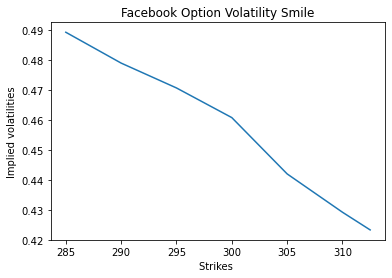

In [27]:
# x axis values are strikes
x = [285,290,295,300,305,310,312.5]
# y axis values are Implied volatility
y = [0.4893,0.4790,0.4707,0.4608,0.4420,0.4292,0.4233]

plt.plot(x, y)

plt.xlabel('Strikes ')
# naming the y axis
plt.ylabel('Implied volatilities')
 
# giving a title to my graph
plt.title('Facebook Option Volatility Smile')
plt.show()

##### Question 6: A function to compute the implied volatility using Bisection Method

In [28]:
N_prime = norm.pdf
N = norm.cdf

def black_scholes_call(S, K, T, r, sigma):
    '''

    :param S: Asset price
    :param K: Strike price
    :param T: Time to maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: call price
    '''

    ###standard black-scholes formula
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call = S * N(d1) -  N(d2)* K * np.exp(-r * T)
    return call

In [29]:
S = 302.91
K = 300.00
T = 1
r = 0.0276
sigma = 0.4608

black_scholes_call(S, K, T, r, sigma) # We need to use a black-scholes model to find Observed price

59.89900679991058

In [30]:
N_prime = norm.pdf


def vega(S, K, T, r, sigma):
    '''

    :param S: Asset price
    :param K: Strike price
    :param T: Time to Maturity
    :param r: risk-free rate (treasury bills)
    :param sigma: volatility
    :return: partial derivative w.r.t volatility
    '''

    ### calculating d1 from black scholes
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / sigma * np.sqrt(T)

    
    vega = S  * np.sqrt(T) * N_prime(d1)
    return vega

In [31]:
def implied_volatility_call(C, S, K, T, r, tol=0.0001,
                            max_iterations=100):
    '''

    :param C: Observed call price
    :param S: Asset price
    :param K: Strike Price
    :param T: Time to Maturity
    :param r: riskfree rate
    :param tol: error tolerance in result
    :param max_iterations: max iterations to update vol
    :return: implied volatility in percent
    '''


    ### assigning initial volatility estimate for input in Newton_rap procedure
    sigma = 0.3

    for i in range(max_iterations):

        ### calculate difference between blackscholes price and market price with
        ### iteratively updated volality estimate
        diff = black_scholes_call(S, K, T, r, sigma) - C

        ###break if difference is less than specified tolerance level
        if abs(diff) < tol:
            print(f'True value is found after {i} iterations')
            print(f'Difference is equal to {diff}')
            break

        ### use newton rapshon to update the estimate
        sigma = sigma - diff / vega(S, K, T, r, sigma)

    return sigma

In [32]:
observed_price = 59.89900679991058
S = 302.91
K = 300
T = 1
r = 0.0276

imp_vol = implied_volatility_call(observed_price, S, K, T, r)
print('Implied volatility using Newton Rapshon is: ',imp_vol)

True value is found after 2 iterations
Difference is equal to -2.9088312203384703e-06
Implied volatility using Newton Rapshon is:  0.4607999747343423


Using this function to validate at least 2 of the implied volatilities from the
website. 

* Note: We need to use BS_Model to find an observable price

In [33]:
S = 302.91
K = 285.00
T = 1
r = 0.0276
sigma = 0.4893

black_scholes_call(S, K, T, r, sigma)

69.79456192186751

In [34]:
observed_price = 69.79456192186751
S = 302.91
K = 285.00
T = 1
r = 0.0276

imp_vol = implied_volatility_call(observed_price, S, K, T, r)
print('Implied volatility using Newton Rapshon is: ',imp_vol)

True value is found after 2 iterations
Difference is equal to -7.637574498176036e-06
Implied volatility using Newton Rapshon is:  0.4892999308061113


##### Question 7: The volatility skewness 

The change in implied volatility (delta y) divided by the
change in strike level (delta x) will give us volatility skewness

$$ Volatility Skewness = \frac { \Delta Implied Volatility }{ \Delta Strike }= \frac{ 0.4233-0.4292 }{ 312.5 - 310 } = -0.00236 $$

##### Question 8: The volatility In Black Scholes

**In Black Scholes, does the volatility depend on the strike level? Why or why not?**

* No , the volatility is constant in BS_Model

Volatility (the standard deviation of log-returns) is not directly observable, and it is the toughest input to determine. Two common ways to estimate volatility:

* Use historical data
* Extracting volatility from other options

Volatility is assumed to be constant in the Black-Scholes model. This is why you can estimate volatility over a historical period and use that volatility over a later period. But this assumption was made for mathematical ease, and it is not realistic.

##### Question 9: How does the Heston Model better estimate the volatility smile? 

As we've seen in Question 8, The Black Scholes model assumes that the volatility is constant. On the contrary, the Heston model allows stochastic volatility which is more flexible and can perform better with empirical data. 

Heston model serves the following pros:
* It factors in a possible correlation between a stock's price and its volatility.
* It conveys volatility as reverting to the mean.
* It gives a closed-form solution, meaning that the answer is derived from an accepted set of mathematical operations.
* It does not require that stock prices follow a lognormal probability distribution.



Thus, It is found that overall the Heston model performs better than the Black-Scholes model.

### Part C: Discussing: